In [70]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
from pathlib import Path
from collections import defaultdict
from itertools import product
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations,permutations
from sklearn.tree import *
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
import random
from math import floor

In [71]:
training_path = Path('/Users/karankamath/Desktop/ARC-master/data/training')
test_path = Path('/Users/karankamath/Desktop/ARC-master/data/evaluation')

In [72]:
def plot_result(inp,eoup,oup):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 3, figsize=(15,15))
    
    axs[0].imshow(inp, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Input')

    axs[1].imshow(eoup, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Output')
    
    axs[2].imshow(oup, cmap=cmap, norm=norm)
    axs[2].axis('off')
    axs[2].set_title('Model prediction')
    
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_mats(mats):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, len(mats), figsize=(15,15))
    
    for i in range(len(mats)):
        axs[i].imshow(mats[i], cmap=cmap, norm=norm)
        axs[i].axis('off')
        axs[i].set_title('Fig: '+str(i))
    
    plt.rc('grid', linestyle="-", color='white')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [73]:
def getiorc(pair):
    inp = pair["input"]
    return pair["input"],pair["output"],len(inp),len(inp[0])
    
def getAround(i,j,inp,size=1):
    #v = [-1,-1,-1,-1,-1,-1,-1,-1,-1]
    r,c = len(inp),len(inp[0])
    v = []
    sc = [0]
    for q in range(size):
        sc.append(q+1)
        sc.append(-(q+1))
    for idx,(x,y) in enumerate(product(sc,sc)):
        ii = (i+x)
        jj = (j+y)
        v.append(-1)
        if((0<= ii < r) and (0<= jj < c)):
            v[idx] = (inp[ii][jj])
    return v

def getDiagonal(i,j,r,c):
    return
        
    
def getX(inp,i,j,size):
    z = []
    n_inp = np.array(inp)
    z.append(i)
    z.append(j)
    r,c = len(inp),len(inp[0])
    for m in range(5):
        z.append(i%(m+1))
        z.append(j%(m+1))
    z.append(i+j)
    z.append(i*j)
#     z.append(i%j)
#     z.append(j%i)
    z.append((i+1)/(j+1))
    z.append((j+1)/(i+1))
    z.append(r)
    z.append(c)
    z.append(len(np.unique(n_inp[i,:])))
    z.append(len(np.unique(n_inp[:,j])))
    arnd = getAround(i,j,inp,size)
    z.append(len(np.unique(arnd)))
    z.extend(arnd)
    return z

def getXy(inp,oup,size):
    x = []
    y = []
    r,c = len(inp),len(inp[0])
    for i in range(r):
        for j in range(c):
            x.append(getX(inp,i,j,size))
            y.append(oup[i][j])
    return x,y
    
def getBkgColor(task_json):
    color_dict = defaultdict(int)
    
    for pair in task_json['train']:
        inp,oup,r,c = getiorc(pair)
        for i in range(r):
            for j in range(c):
                color_dict[inp[i][j]]+=1
    color = -1
    max_count = 0
    for col,cnt in color_dict.items():
        if(cnt > max_count):
            color = col
            max_count = cnt
    return color

In [74]:
def get_num_colors(inp,oup,bl_cols):
    r,c = len(inp),len(inp[0])
    return 

def replace(inp,uni,perm):
    # uni = '234' perm = ['5','7','9']
    #print(uni,perm)
    r_map = { int(c):int(s) for c,s in zip(uni,perm)}
    r,c = len(inp),len(inp[0])
    rp = np.array(inp).tolist()
    #print(rp)
    for i in range(r):
        for j in range(c):
            if(rp[i][j] in r_map):
                rp[i][j] = r_map[rp[i][j]]
    return rp
            
    
def augment(inp,oup,bl_cols):
    cols = "0123456789"
    npr_map = [1,9,72,3024,15120,60480,181440,362880,362880]
    uni = "".join([str(x) for x in np.unique(inp).tolist()])
    for c in bl_cols:
        cols=cols.replace(str(c),"")
        uni=uni.replace(str(c),"")

    exp_size = len(inp)*len(inp[0])*npr_map[len(uni)]
    
    mod = floor(exp_size/120000)
    mod = 1 if mod==0 else mod
    
    #print(exp_size,mod,len(uni))
    result = []
    count = 0
    for comb in combinations(cols,len(uni)):
        for perm in permutations(comb):
            count+=1
            if(count % mod == 0):
                result.append((replace(inp,uni,perm),replace(oup,uni,perm)))
    return result
            
def get_flips(inp,oup):
    result = []
    n_inp = np.array(inp)
    n_oup = np.array(oup)
    result.append((np.fliplr(inp).tolist(),np.fliplr(oup).tolist()))
    result.append((np.rot90(np.fliplr(inp),1).tolist(),np.rot90(np.fliplr(oup),1).tolist()))
    result.append((np.rot90(np.fliplr(inp),2).tolist(),np.rot90(np.fliplr(oup),2).tolist()))
    result.append((np.rot90(np.fliplr(inp),3).tolist(),np.rot90(np.fliplr(oup),3).tolist()))
    result.append((np.flipud(inp).tolist(),np.flipud(oup).tolist()))
    result.append((np.rot90(np.flipud(inp),1).tolist(),np.rot90(np.flipud(oup),1).tolist()))
    result.append((np.rot90(np.flipud(inp),2).tolist(),np.rot90(np.flipud(oup),2).tolist()))
    result.append((np.rot90(np.flipud(inp),3).tolist(),np.rot90(np.flipud(oup),3).tolist()))
    result.append((np.fliplr(np.flipud(inp)).tolist(),np.fliplr(np.flipud(oup)).tolist()))
    result.append((np.flipud(np.fliplr(inp)).tolist(),np.flipud(np.fliplr(oup)).tolist()))
    return result
    
def gettaskxy(task_json,aug,around_size,bl_cols,flip=True):    
    X = []
    Y = []
    for pair in task_json['train']:
        inp,oup=pair["input"],pair["output"]
        tx,ty = getXy(inp,oup,around_size)
        X.extend(tx)
        Y.extend(ty)
        if(flip):
            for ainp,aoup in get_flips(inp,oup):
                tx,ty = getXy(ainp,aoup,around_size)
                X.extend(tx)
                Y.extend(ty)
                if(aug):
                    augs = augment(ainp,aoup,bl_cols)
                    for ainp,aoup in augs:
                        tx,ty = getXy(ainp,aoup,around_size)
                        X.extend(tx)
                        Y.extend(ty)
        if(aug):
            augs = augment(inp,oup,bl_cols)
            for ainp,aoup in augs:
                tx,ty = getXy(ainp,aoup,around_size)
                X.extend(tx)
                Y.extend(ty)
    return X,Y

def test_predict(task_json,model,size):
    inp = task_json['test'][0]['input']
    eoup = task_json['test'][0]['output']
    r,c = len(inp),len(inp[0])
    oup = predict(inp,model,size)
    return inp,eoup,oup

def predict(inp,model,size):
    r,c = len(inp),len(inp[0])
    oup = np.zeros([r,c],dtype=int)
    for i in range(r):
        for j in range(c):
            x = getX(inp,i,j,size)
            o = int(model.predict([x])[0])
            o = 0 if o<0 else o
            oup[i][j]=o
    return oup

total_accuracy = 0

def submit_predict(task_json, model, size):
    global total_accuracy  # declare total_accuracy as a global variable
    pred_map = {}
    idx = 0
    for pair in task_json['test']:
        inp = pair["input"]
        oup = pair["output"]
        oup_pred = predict(inp, model, size)
        pred_map[idx] = oup_pred.tolist()
        idx += 1
        plot_result(inp, oup, oup_pred)
        total_accuracy += get_accuracy(oup, oup_pred)
        print('Accuracy:', get_accuracy(oup, oup_pred))
    return pred_map

def get_accuracy(oup, pred):
    r, c = len(oup), len(oup[0])
    correct = 0
    total = 0
    for i in range(r):
        for j in range(c):
            total += 1
            if oup[i][j] == pred[i][j]:
                correct += 1
    return correct / total


def dumb_predict(task_json):
    pred_map = {}
    idx=0
    for pair in task_json['test']:
        inp = pair["input"]
        pred_map[idx] = [[0,0],[0,0]]
        idx+=1
    return pred_map

In [75]:
def get_loss(model,task_json,size):
    total = 0
    for pair in task_json['train']:
        inp,oup=pair["input"],pair["output"]
        eoup = predict(inp,model,size)
        total+= np.sum((np.array(oup) != np.array(eoup)))
    return total

def get_test_loss(model,task_json,size):
    total = 0
    for pair in task_json['test']:
        inp,oup=pair["input"],pair["output"]
        eoup = predict(inp,model,size)
        total+= np.sum((np.array(oup) != np.array(eoup)))
    return total

def get_a_size(task_json):
    return 4

def get_bl_cols(task_json):
    result = []
    bkg_col = getBkgColor(task_json);
    result.append(bkg_col)
    # num_input,input_cnt,num_output,output_cnt
    met_map = {}
    for i in range(10):
        met_map[i] = [0,0,0,0]
        
    total_ex = 0
    for pair in task_json['train']:
        inp,oup=pair["input"],pair["output"]
        u,uc = np.unique(inp, return_counts=True)
        inp_cnt_map = dict(zip(u,uc))
        u,uc = np.unique(oup, return_counts=True)
        oup_cnt_map = dict(zip(u,uc))
        
        for col,cnt in inp_cnt_map.items():
            met_map[col][0] = met_map[col][0] + 1
            met_map[col][1] = met_map[col][1] + cnt
        for col,cnt in oup_cnt_map.items():
            met_map[col][2] = met_map[col][2] + 1
            met_map[col][3] = met_map[col][3] + cnt
        total_ex+=1
    
    for col,met in met_map.items():
        num_input,input_cnt,num_output,output_cnt = met
        if(num_input == total_ex or num_output == total_ex):
            result.append(col)
        elif(num_input == 0 and num_output > 0):
            result.append(col)
    
    result = np.unique(result).tolist()
    if(len(result) == 10):
        result.append(bkg_col)
    return np.unique(result).tolist()

In [76]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def combine_preds(tid,pm1,pm3,pm5):
    result = []
    for i in range(len(pm1)):
        tk_s = tid+"_"+str(i)
        str_pred = flattener(pm1[i])+" "+flattener(pm3[i])+" "+flattener(pm5[i])
        #print(tk_s,str_pred)
        result.append([tk_s,str_pred])
    return result

f0afb749
94414823


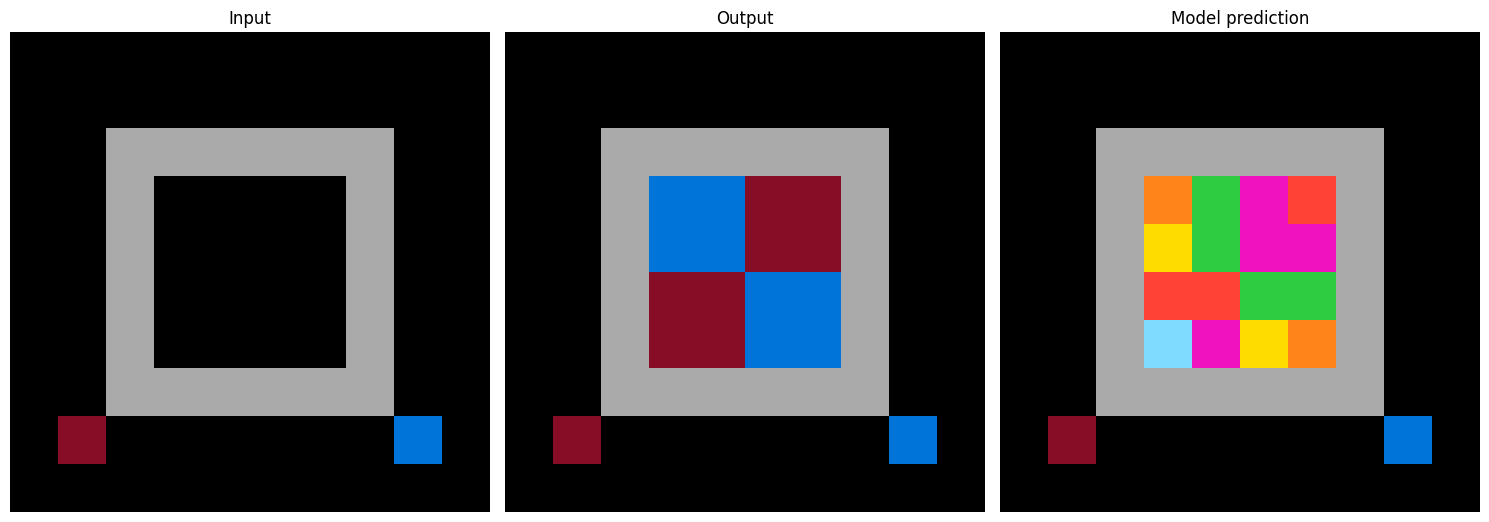

Accuracy: 0.84


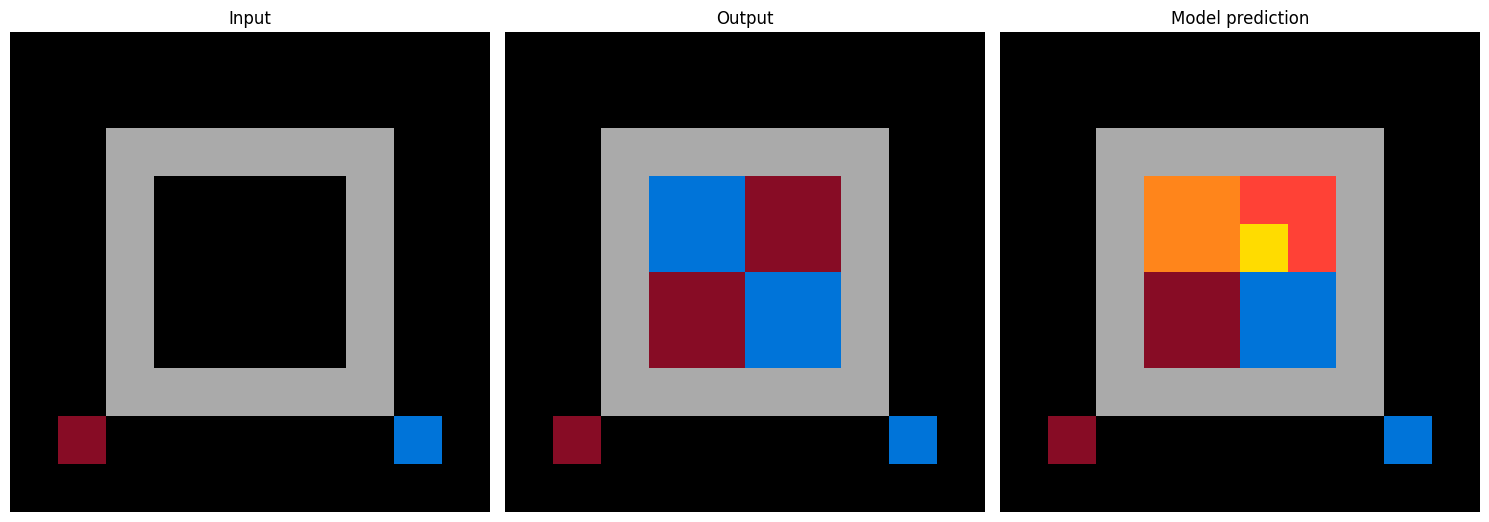

Accuracy: 0.92


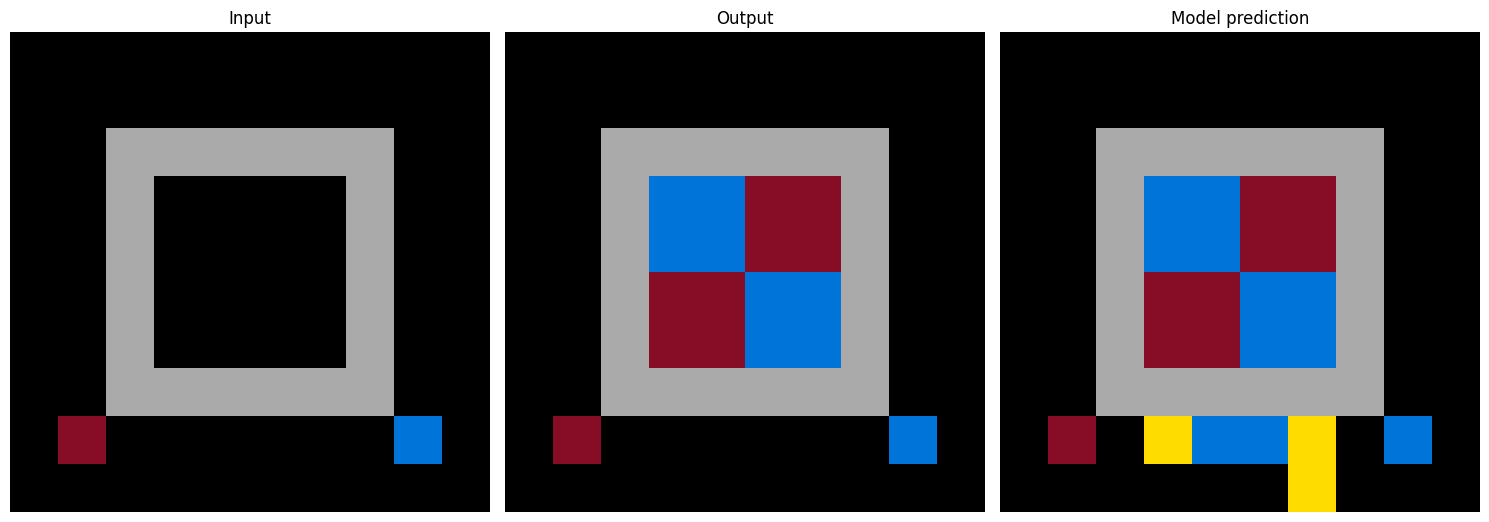

Accuracy: 0.95
dc2e9a9d


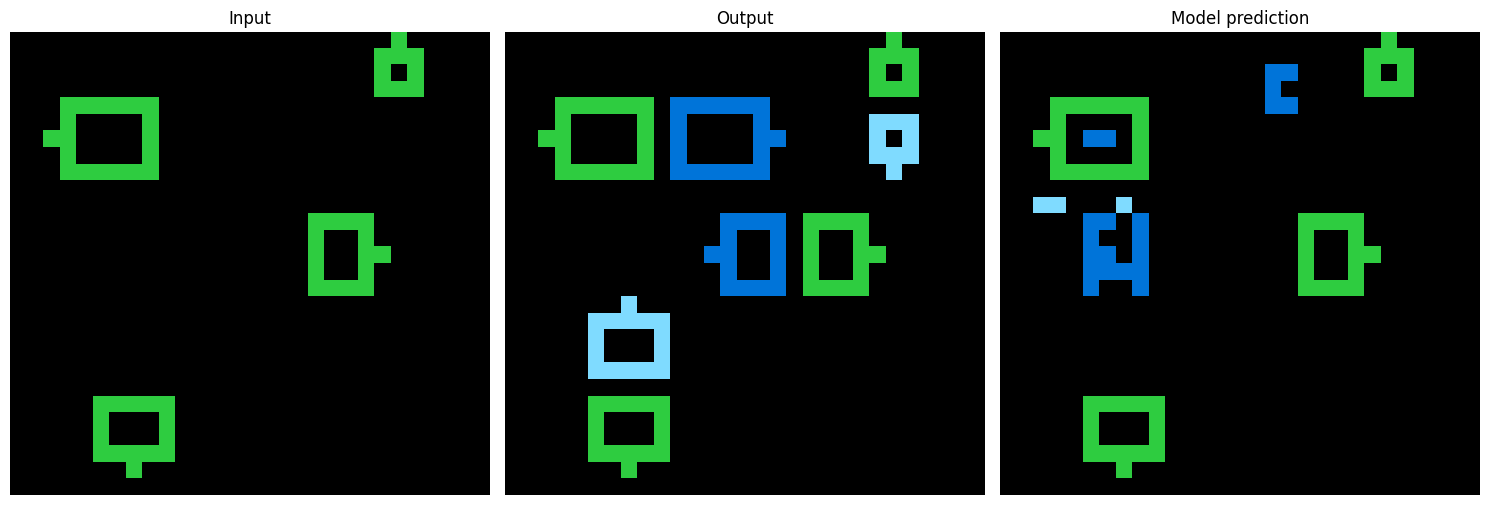

Accuracy: 0.8990147783251231


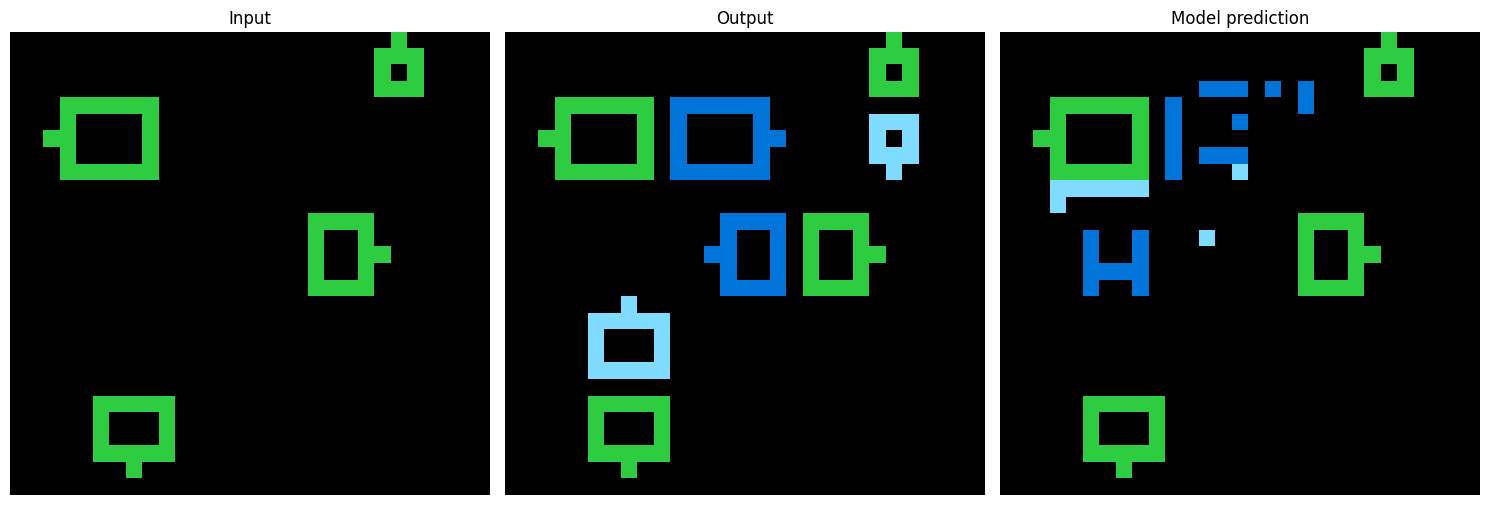

Accuracy: 0.9002463054187192


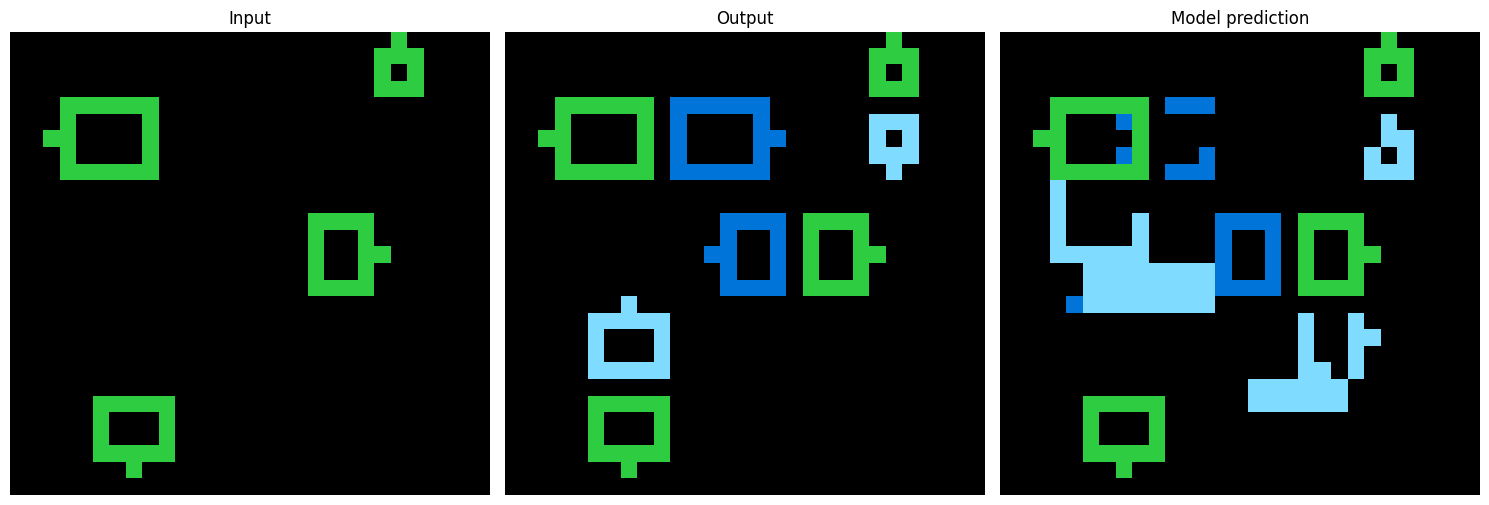

Accuracy: 0.8817733990147784
f83cb3f6


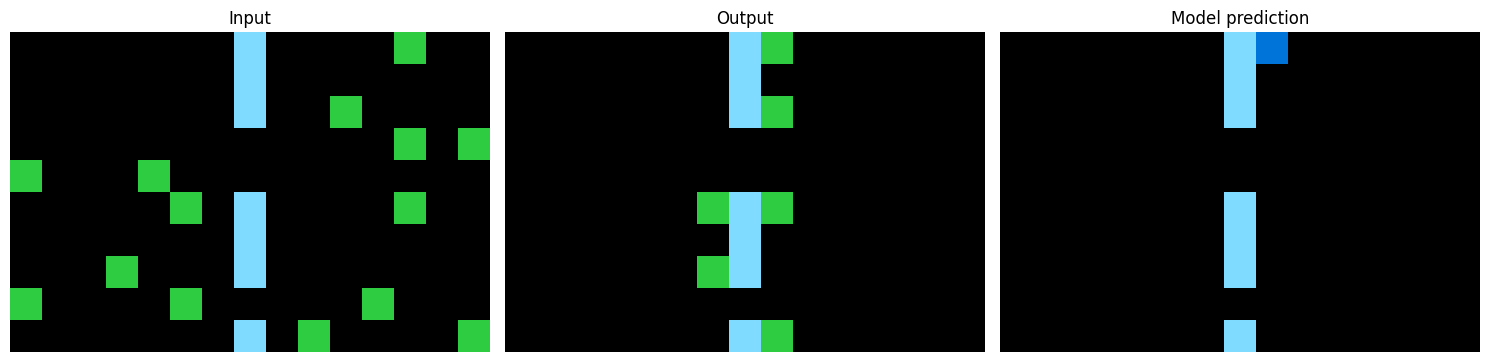

Accuracy: 0.96


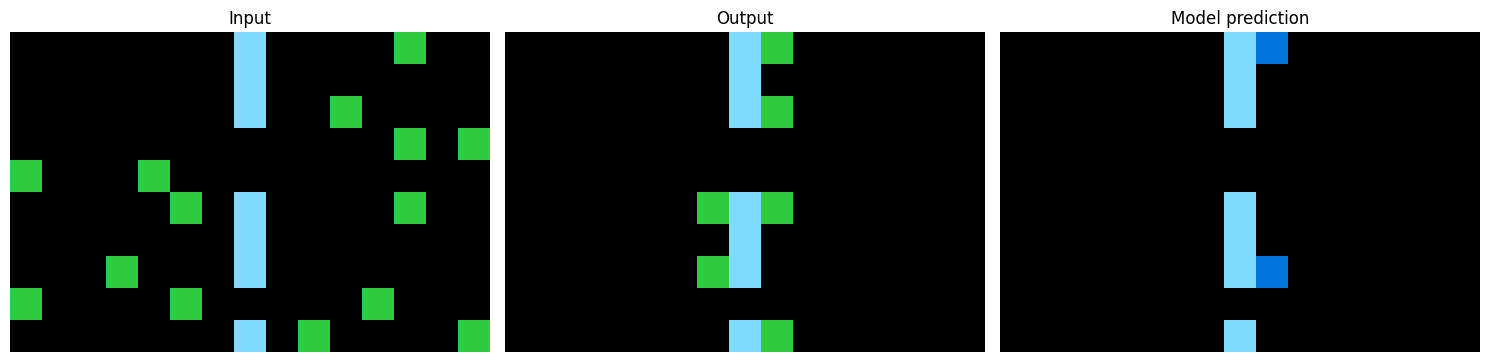

Accuracy: 0.9533333333333334


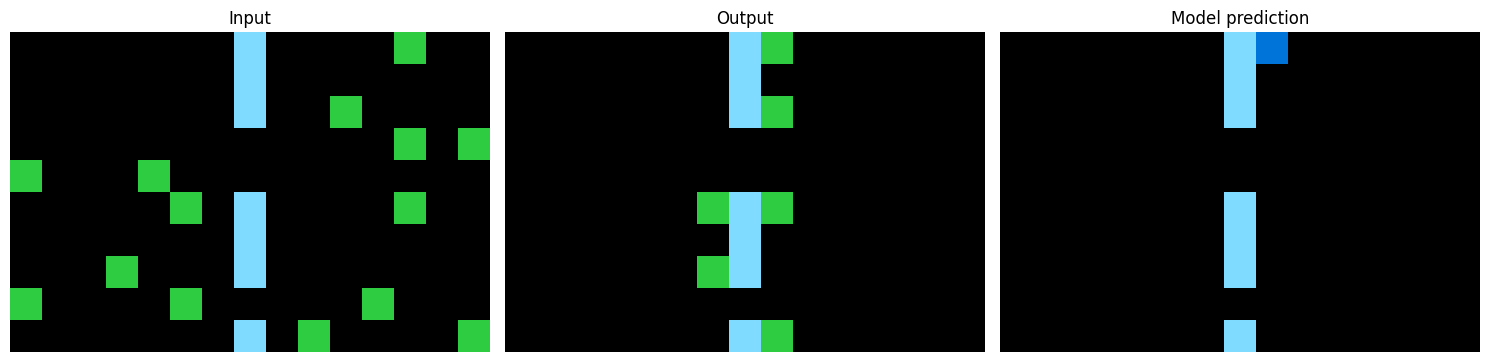

Accuracy: 0.96
baf41dbf


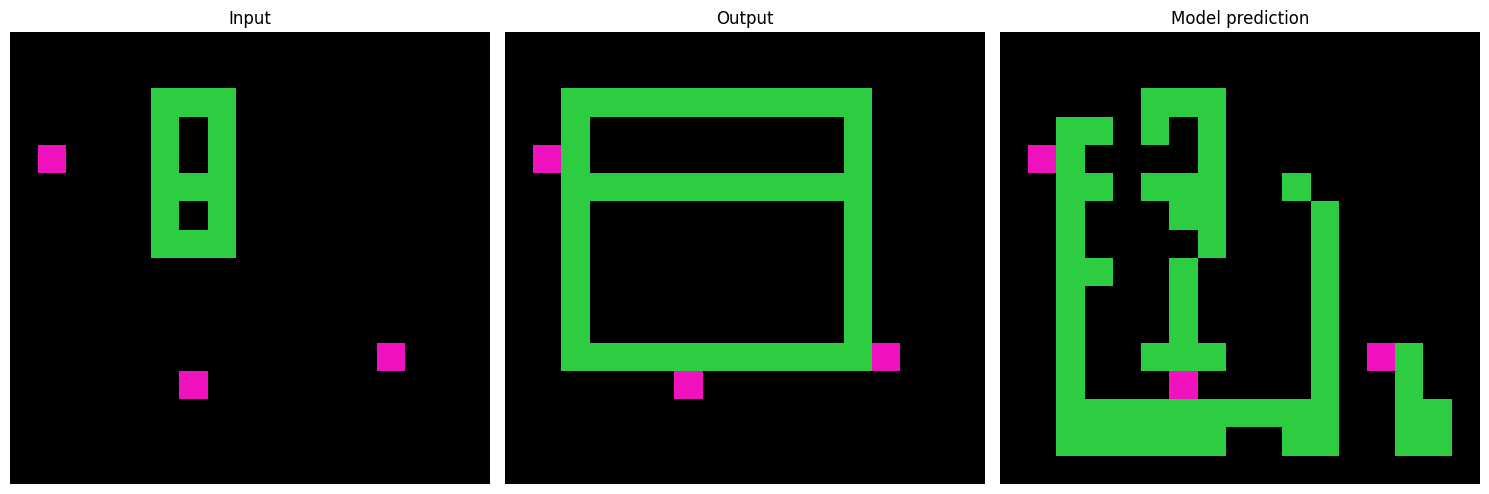

Accuracy: 0.75


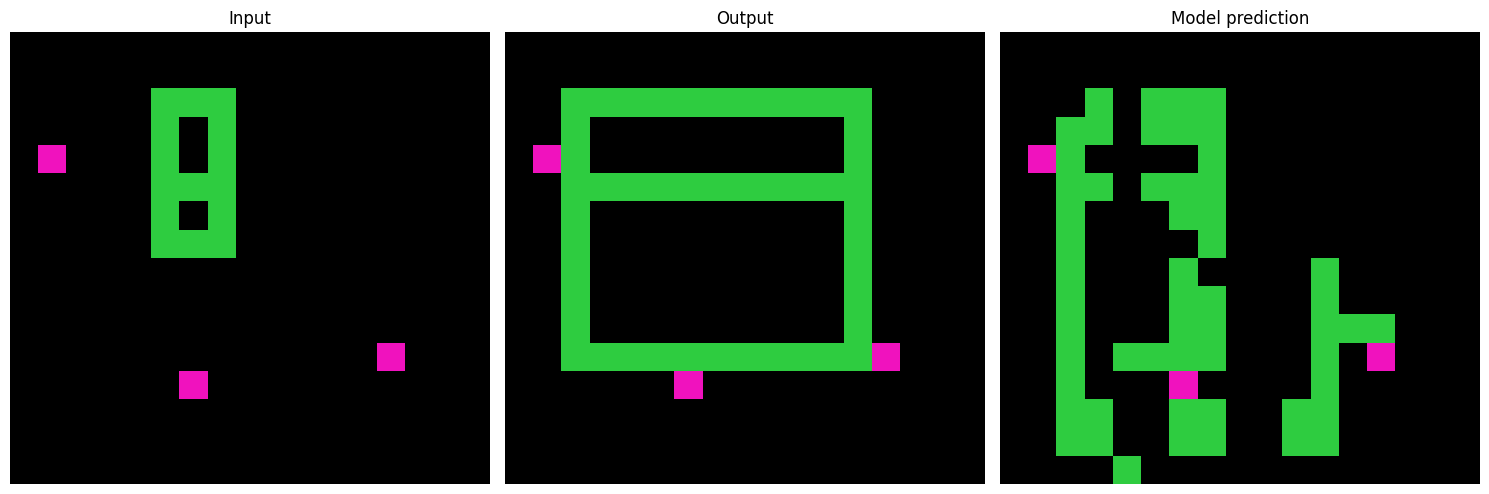

Accuracy: 0.7941176470588235


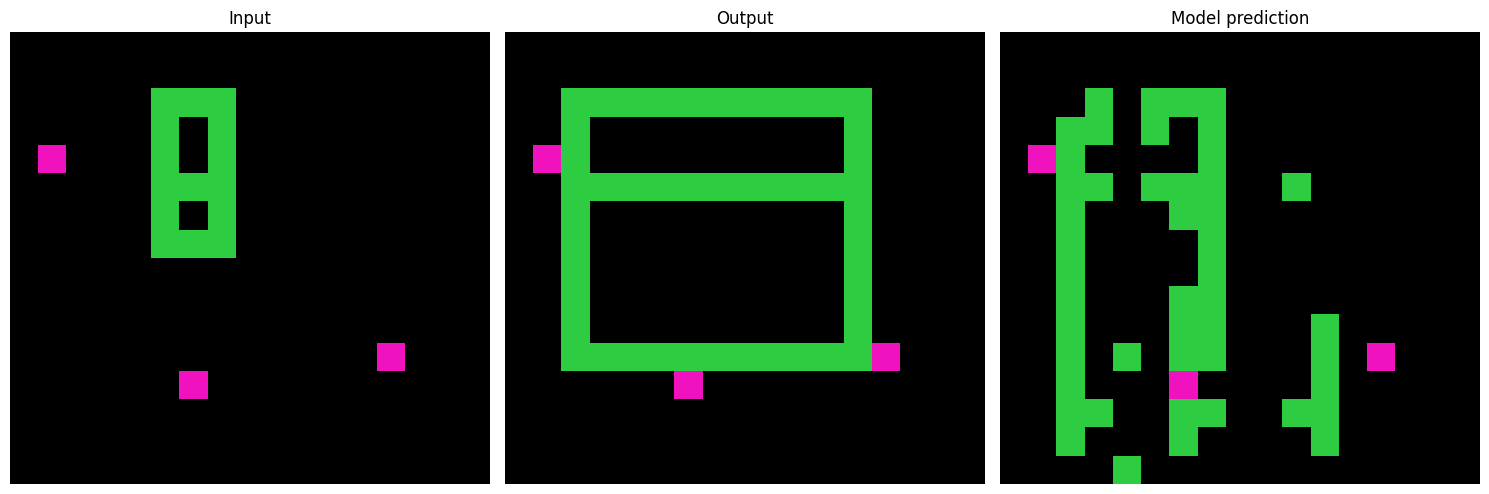

Accuracy: 0.8161764705882353
93b4f4b3
ff72ca3e


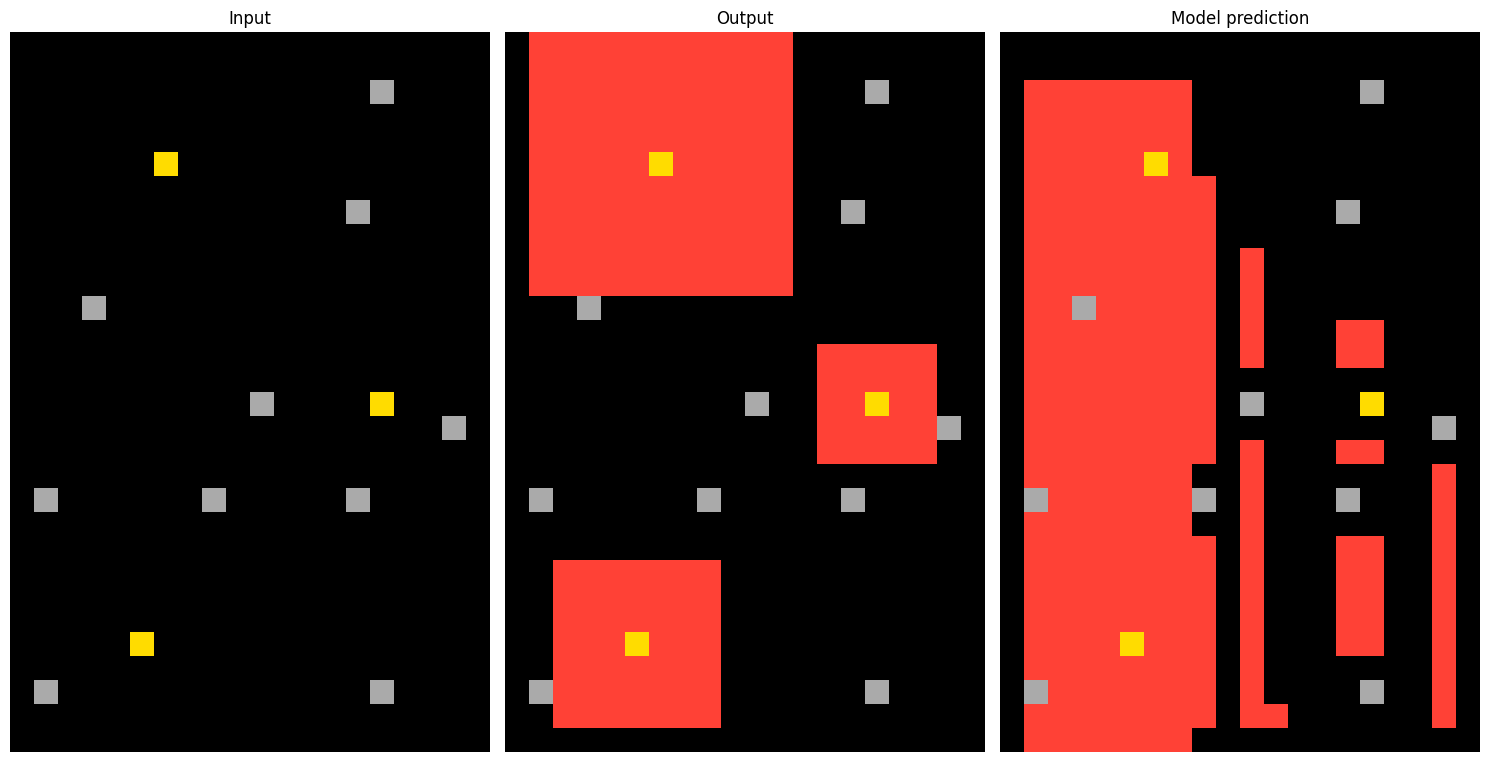

Accuracy: 0.6566666666666666


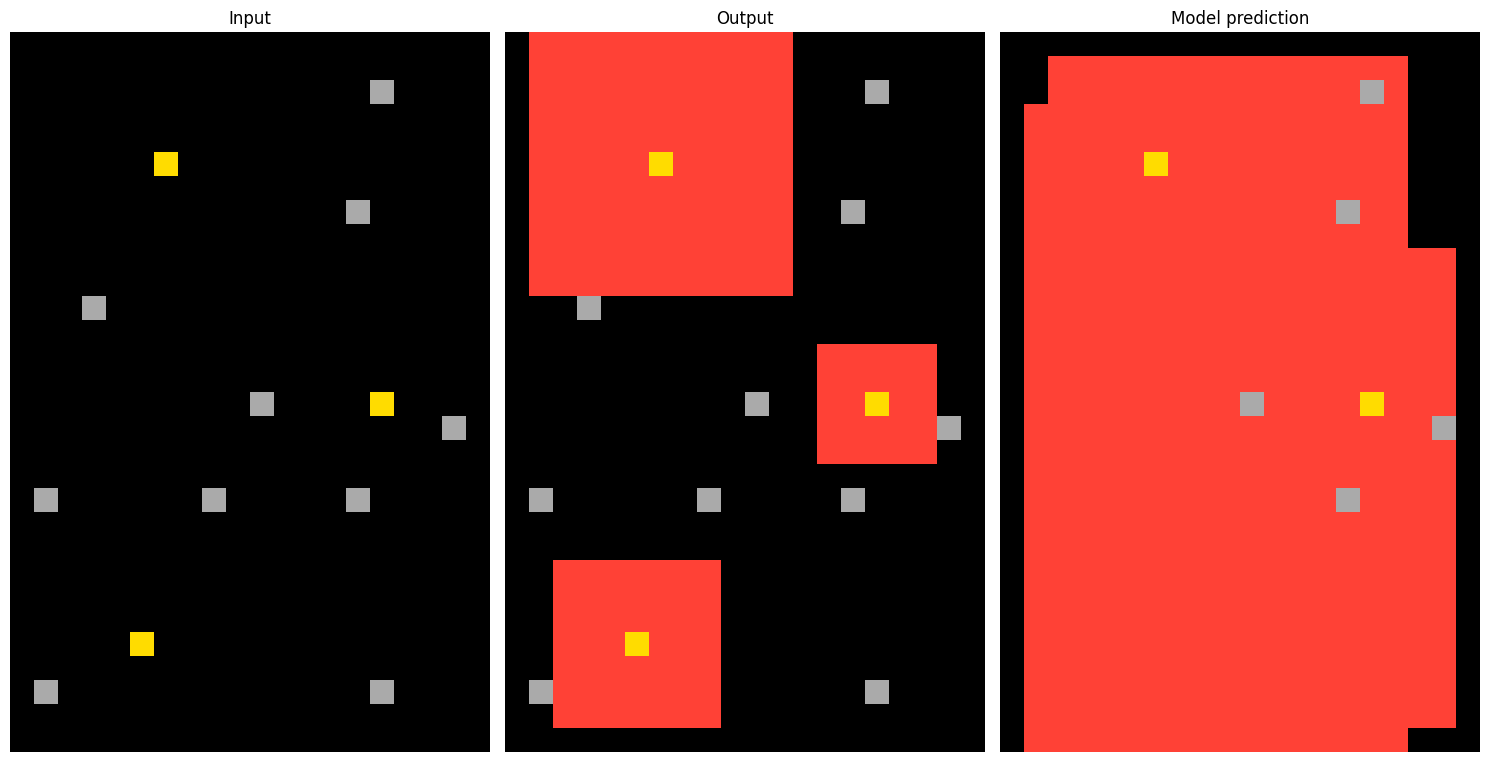

Accuracy: 0.45166666666666666


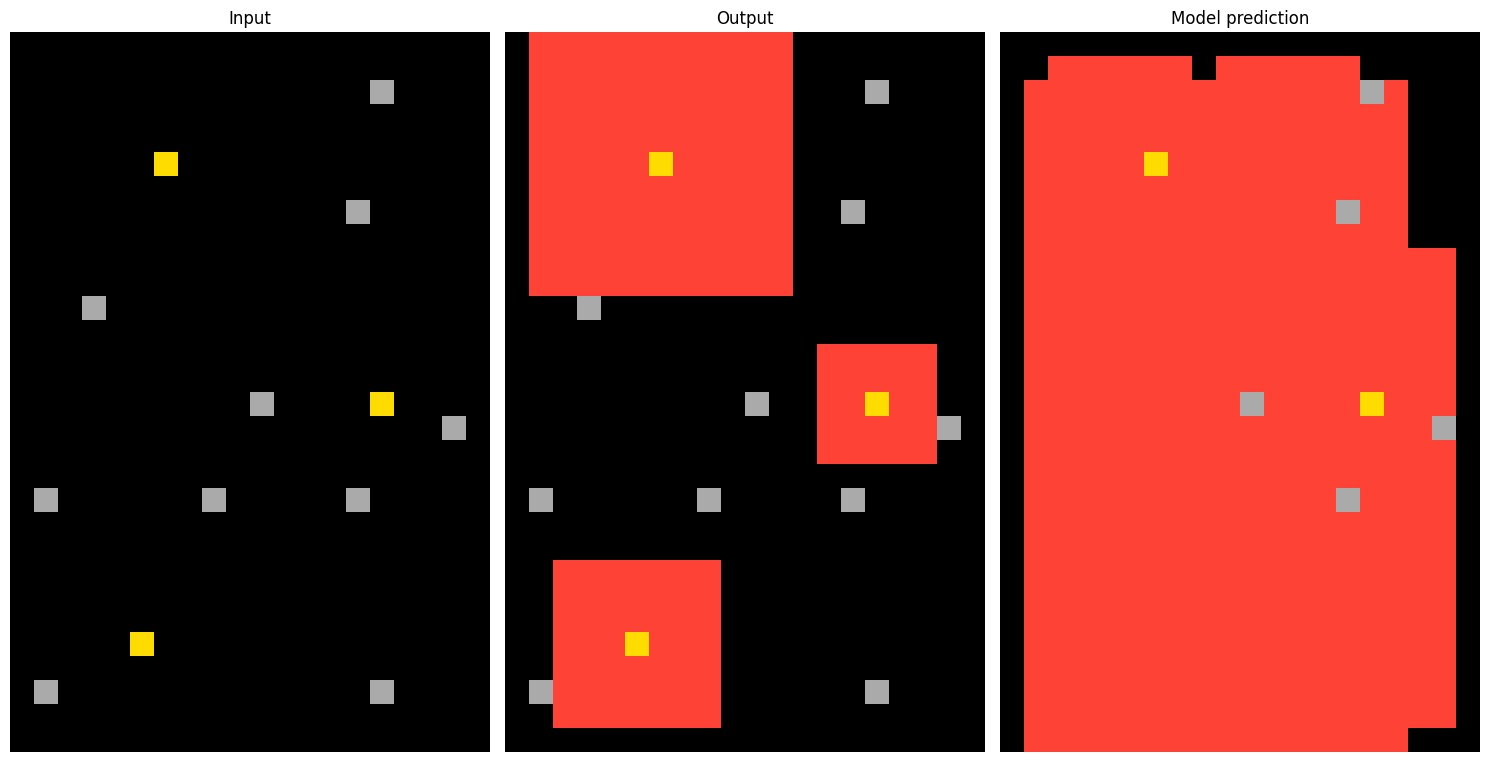

Accuracy: 0.455
50f325b5


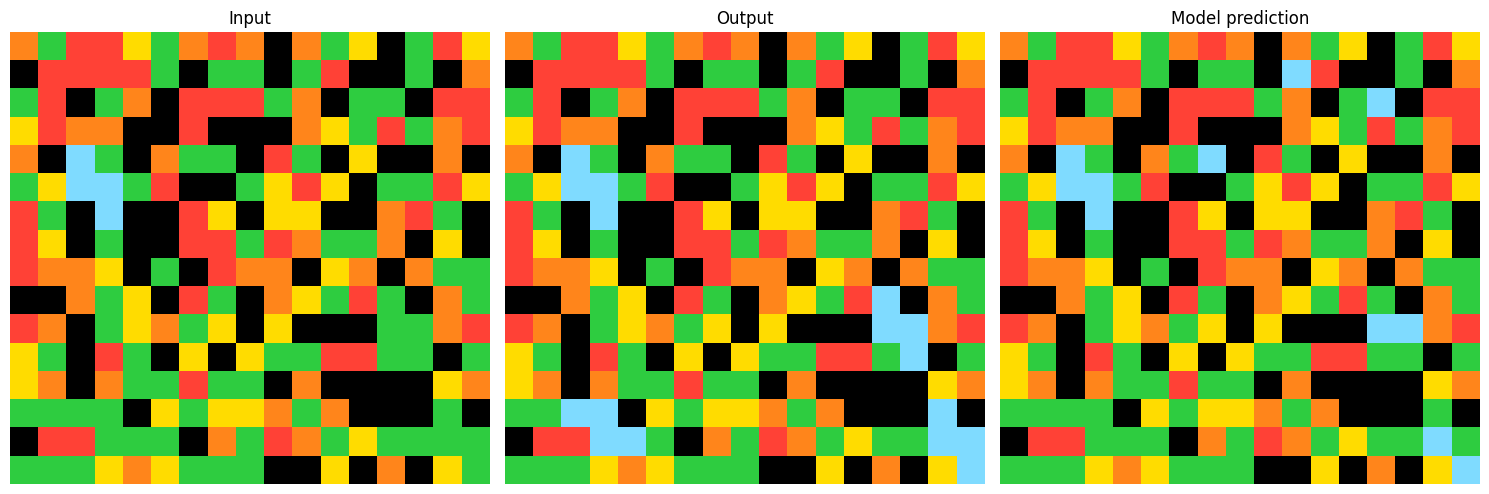

Accuracy: 0.9595588235294118


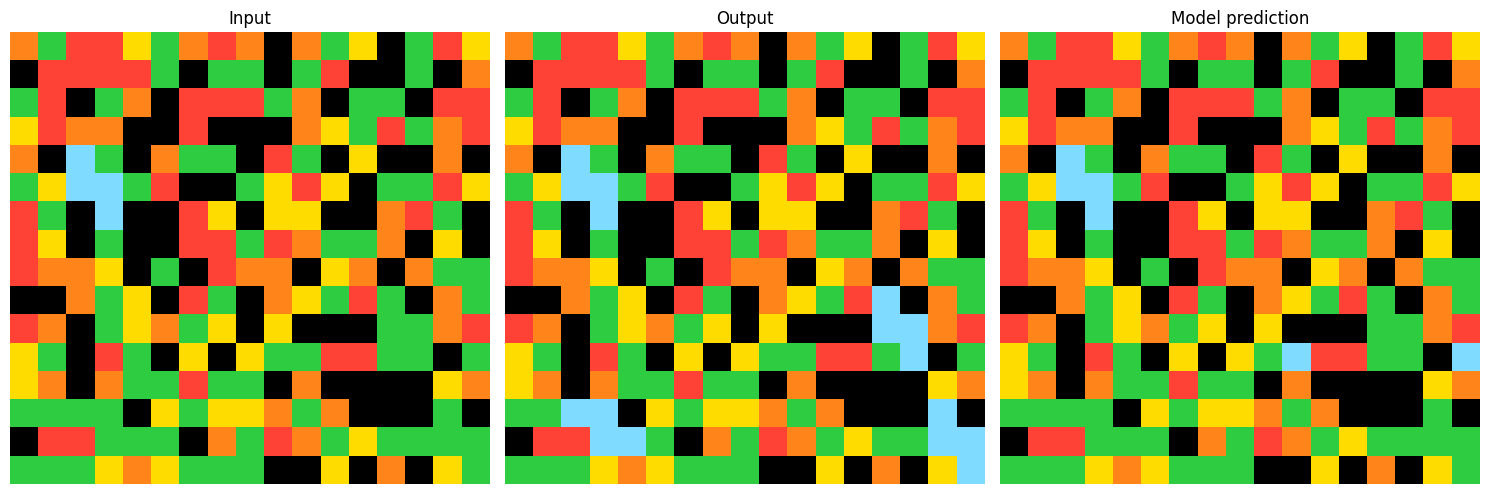

Accuracy: 0.9485294117647058


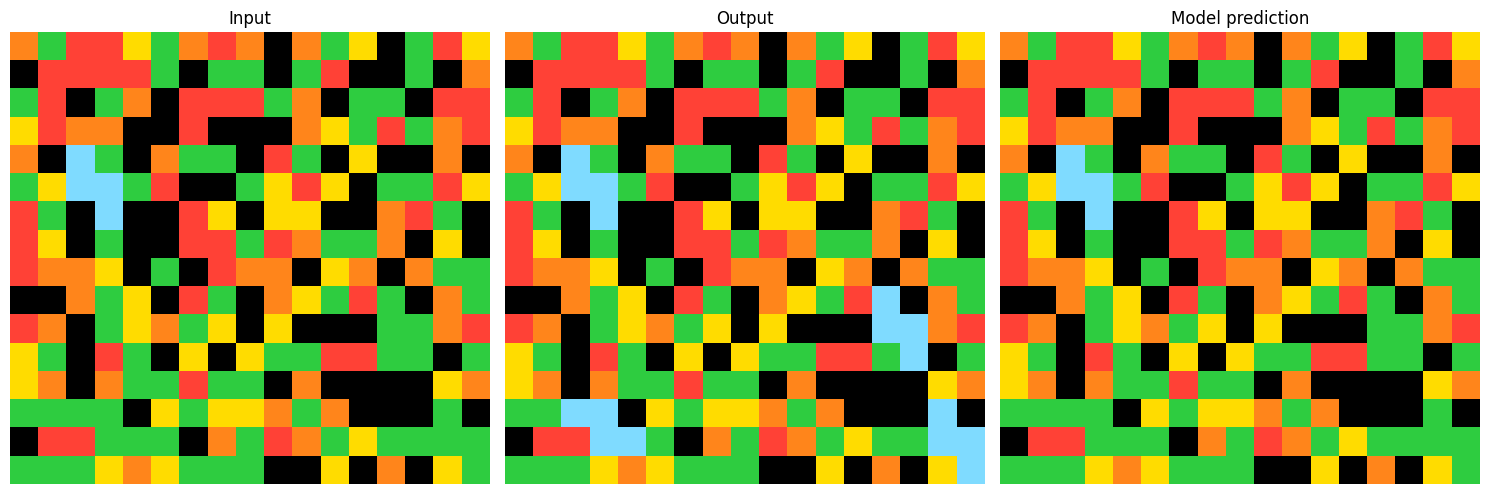

Accuracy: 0.9558823529411765
da515329


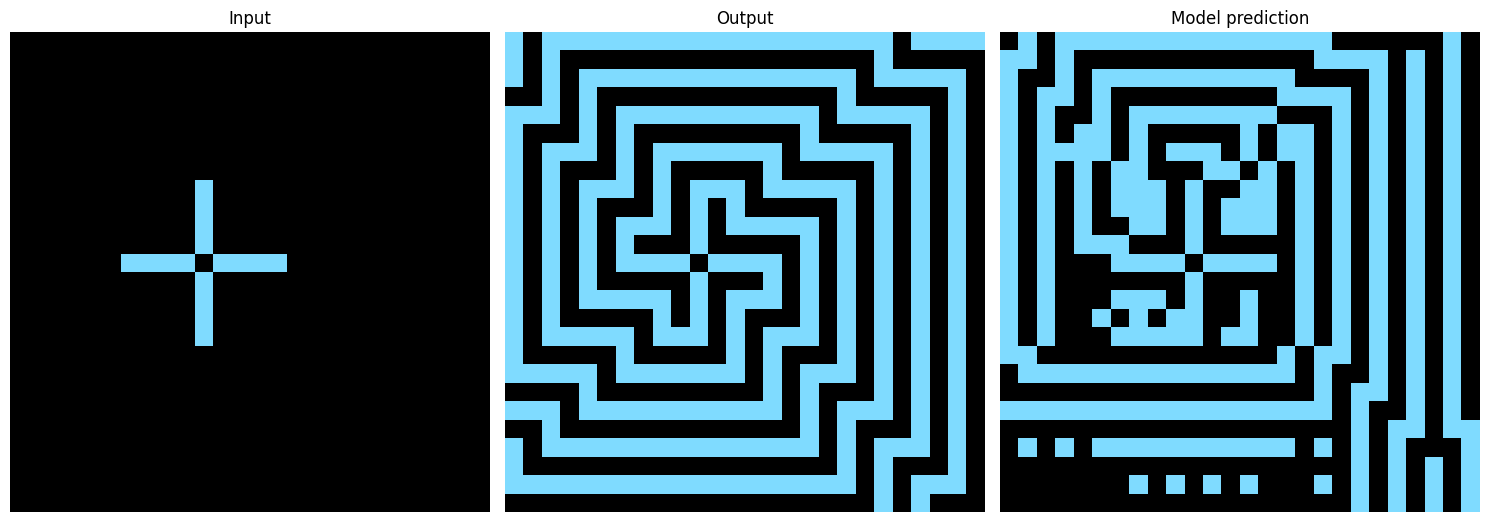

Accuracy: 0.7411242603550295


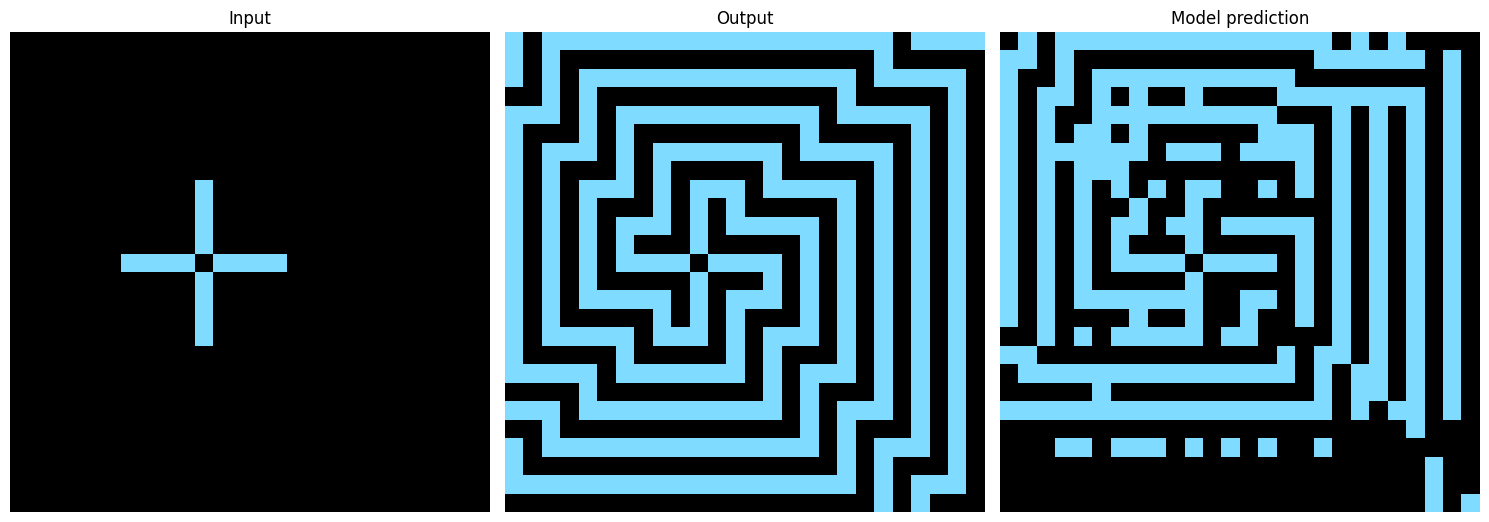

Accuracy: 0.7514792899408284


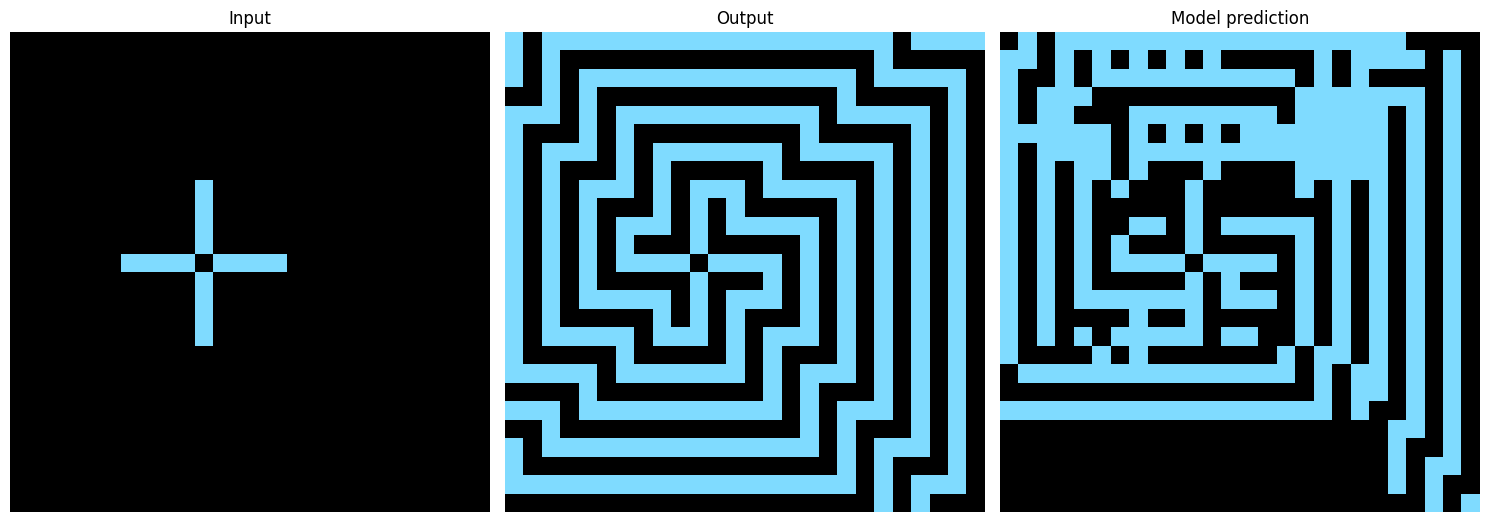

Accuracy: 0.7396449704142012
60a26a3e


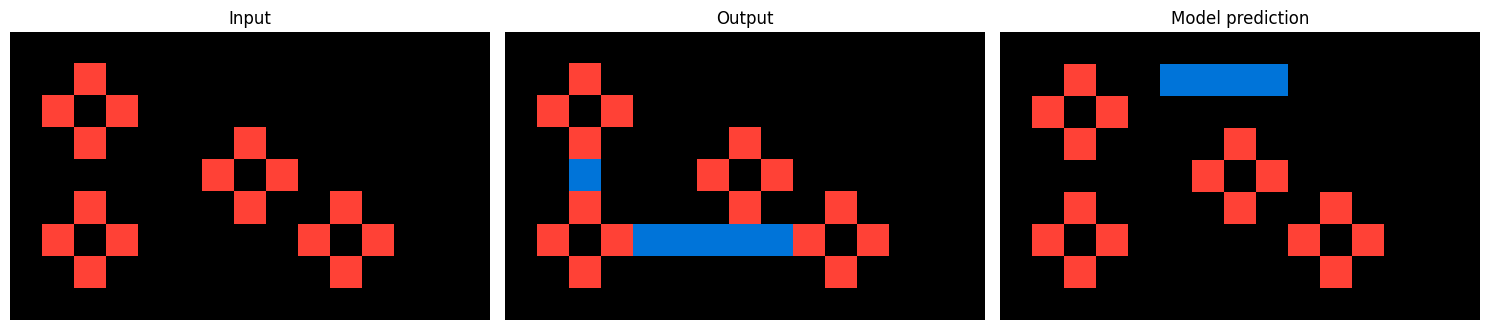

Accuracy: 0.9259259259259259


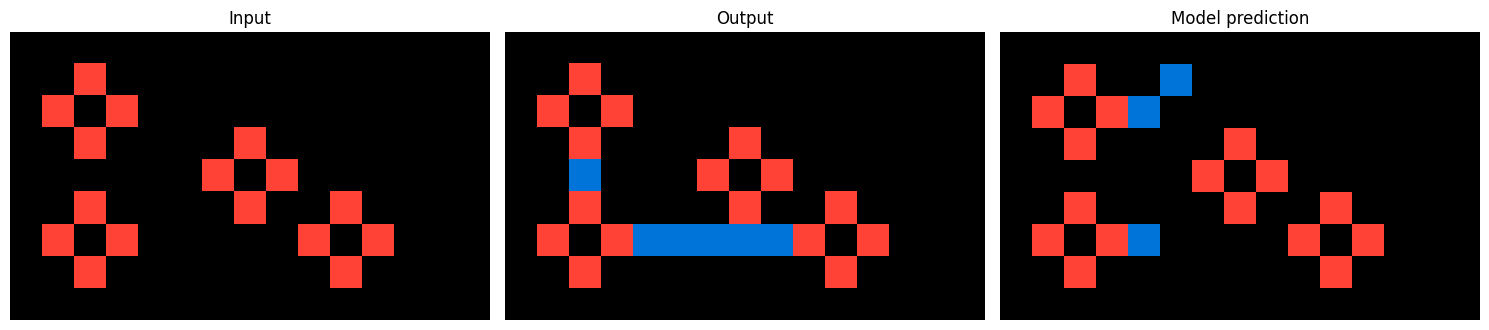

Accuracy: 0.9481481481481482


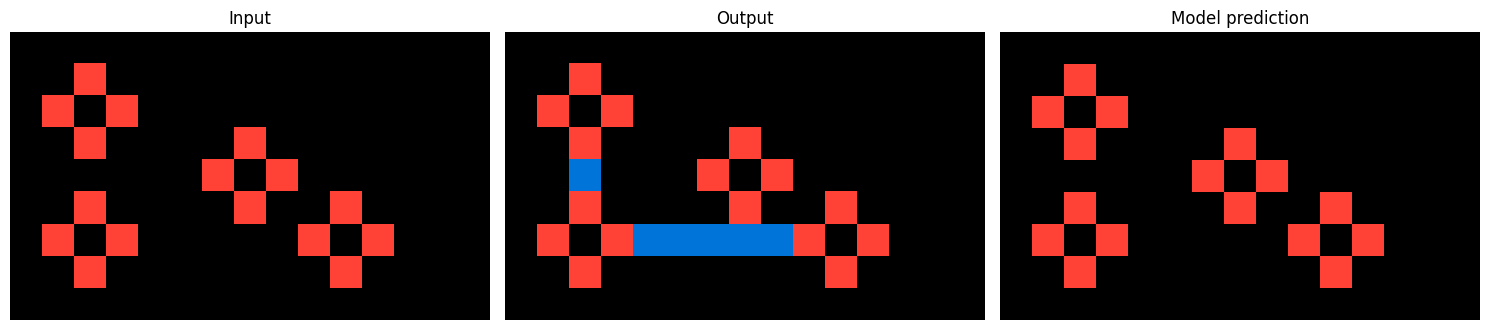

Accuracy: 0.9555555555555556
14754a24


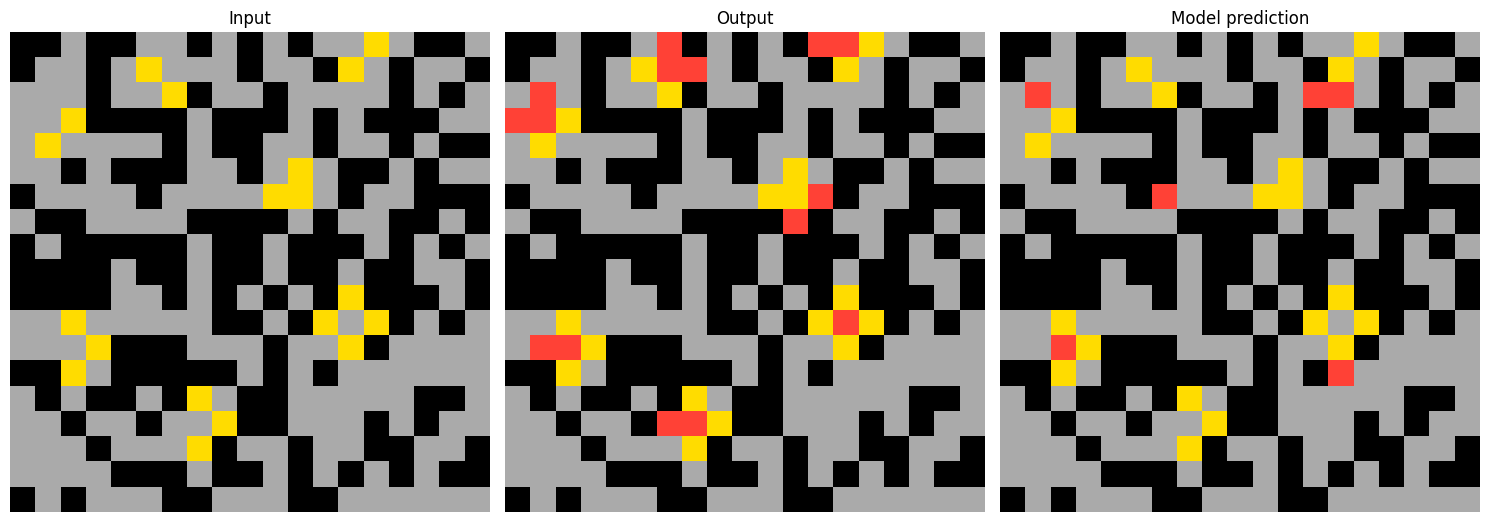

Accuracy: 0.9529085872576177


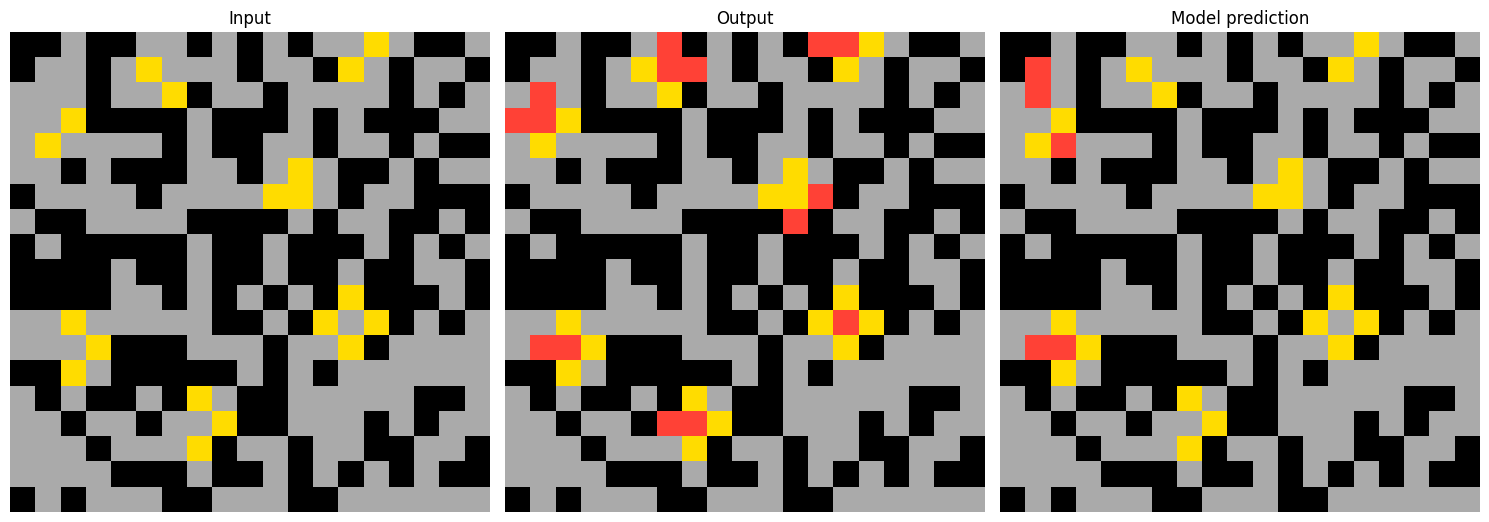

Accuracy: 0.961218836565097


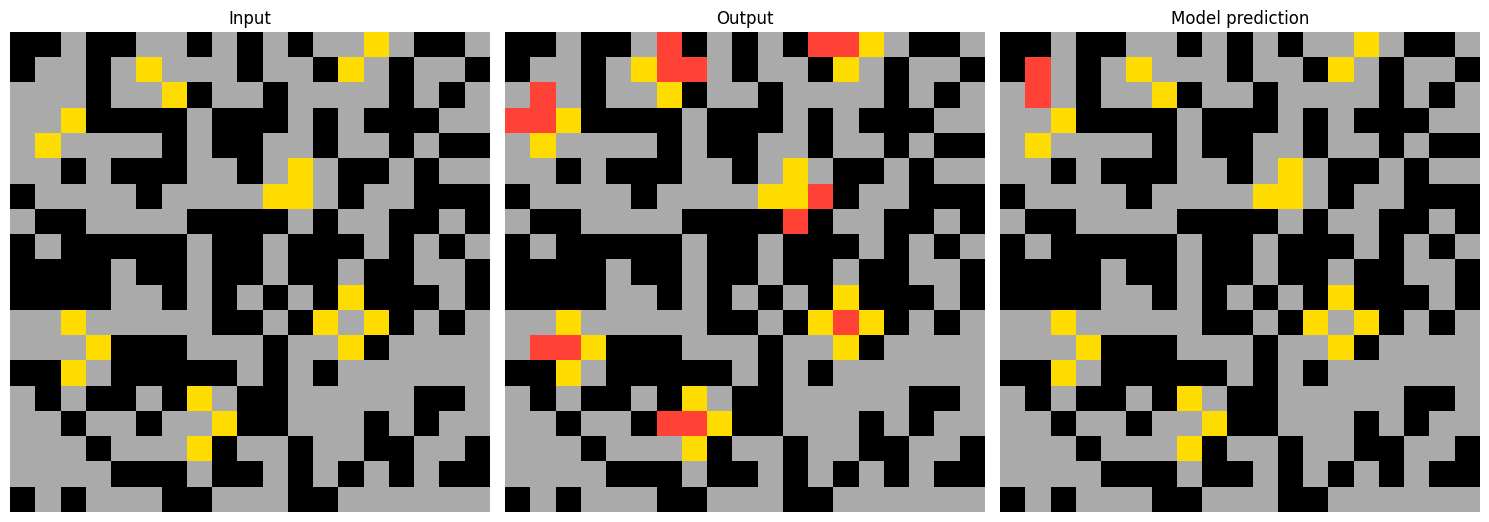

Accuracy: 0.9584487534626038
4ff4c9da


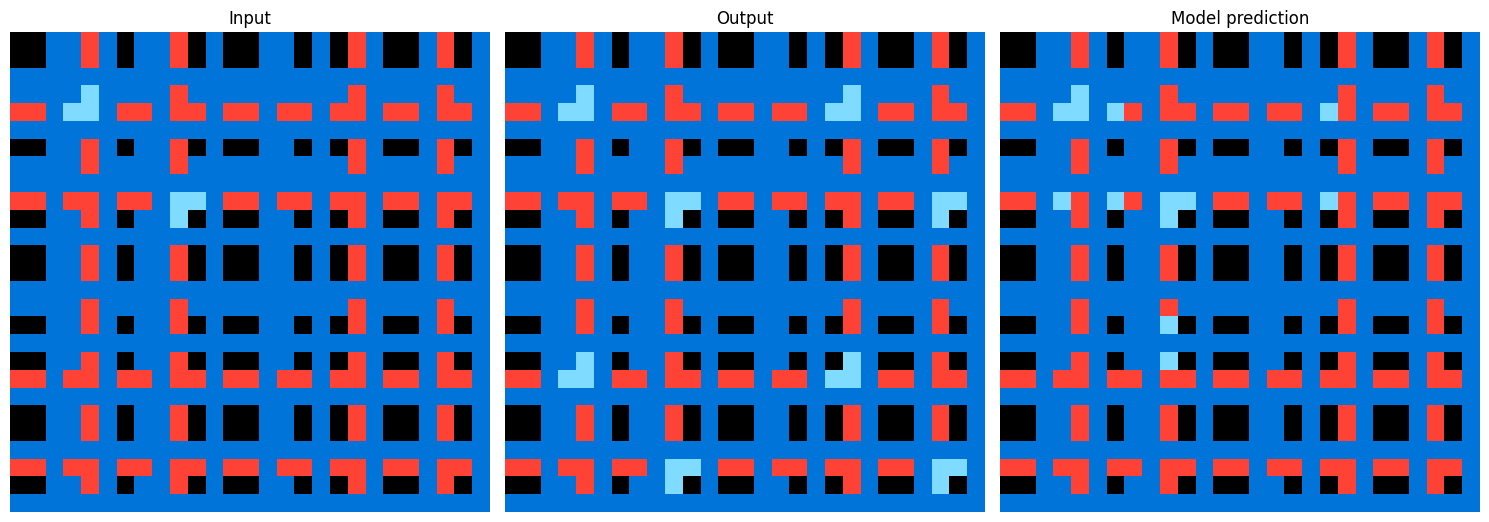

Accuracy: 0.9684499314128944


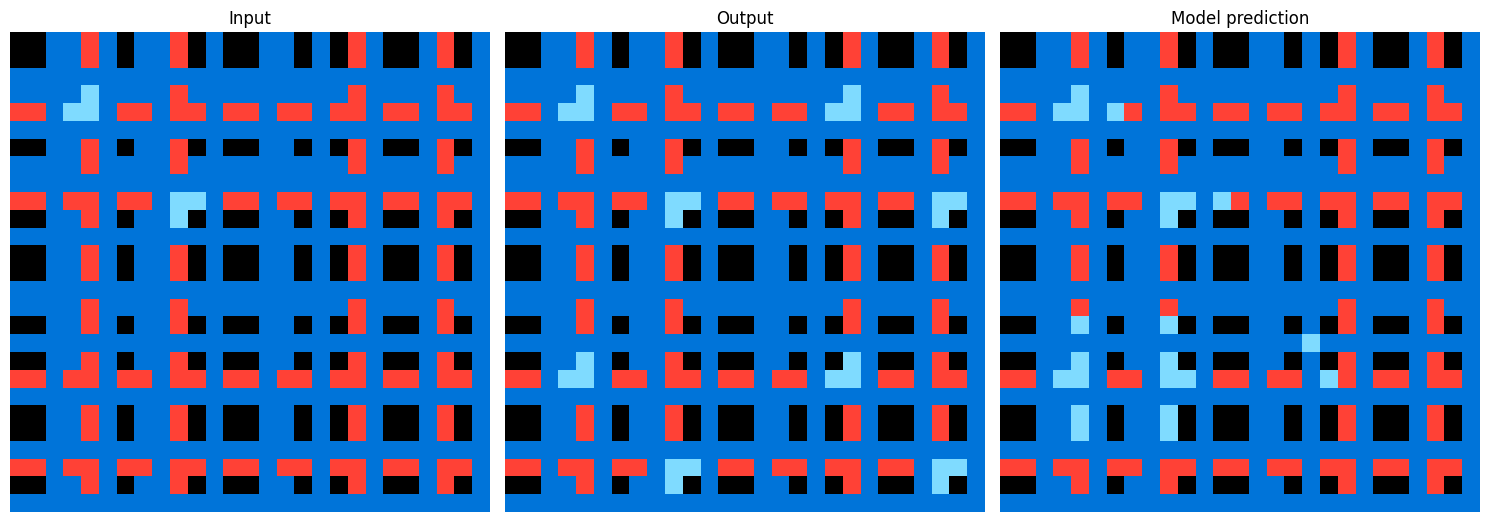

Accuracy: 0.9643347050754458


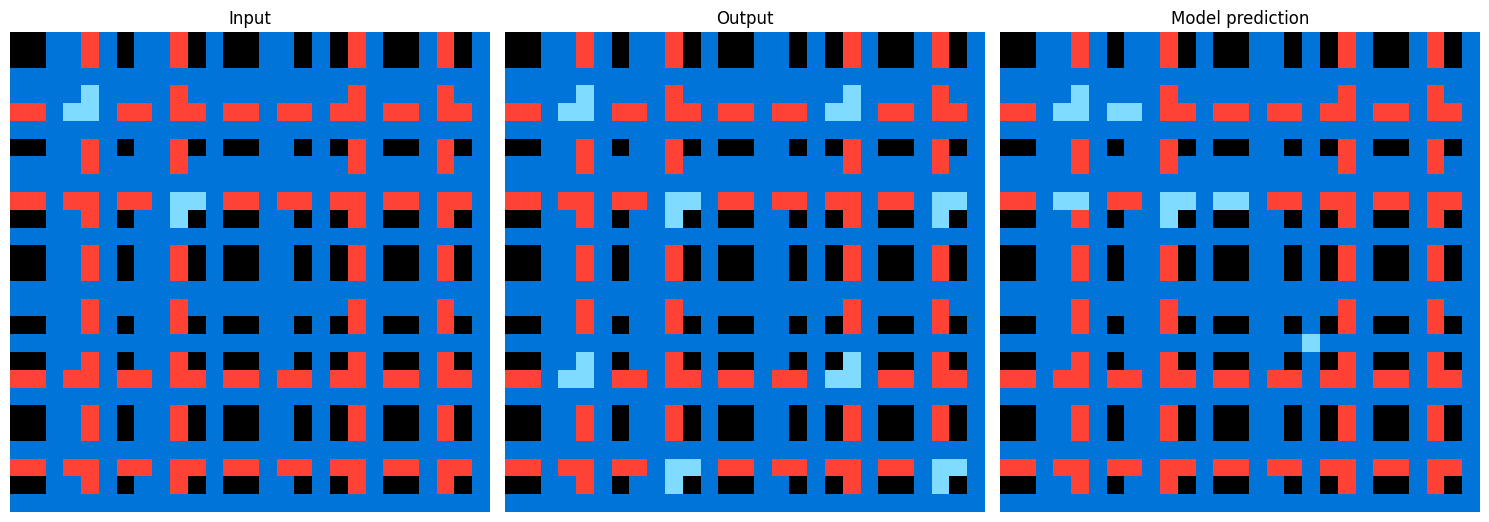

Accuracy: 0.9657064471879286
f9d67f8b


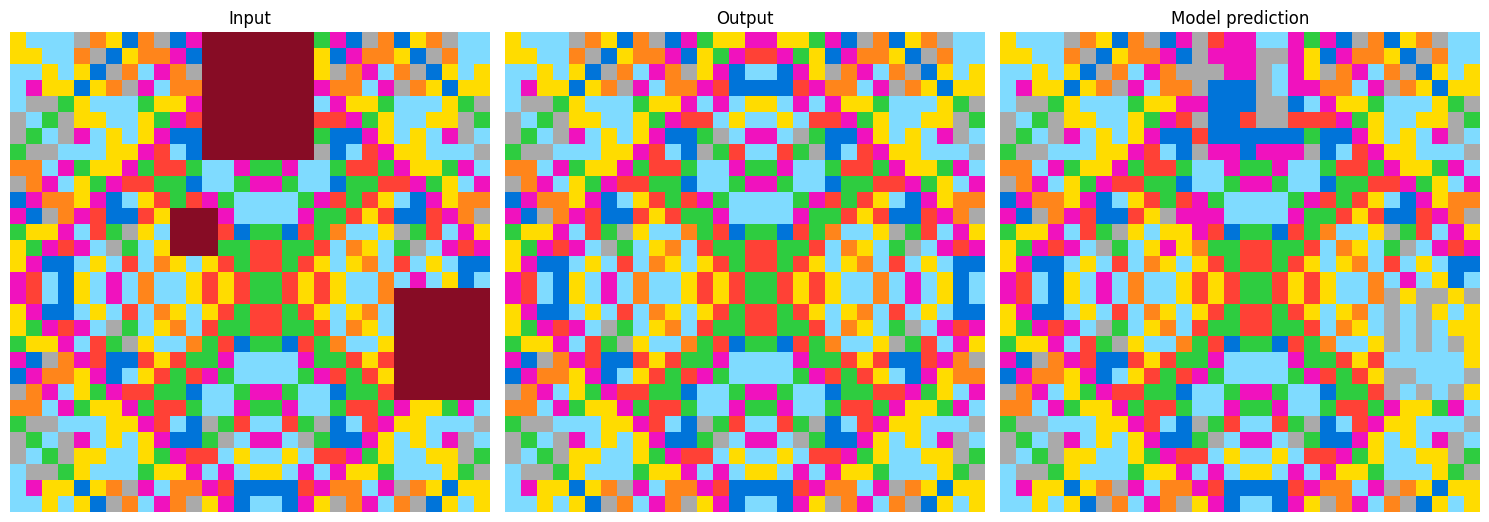

Accuracy: 0.8922222222222222


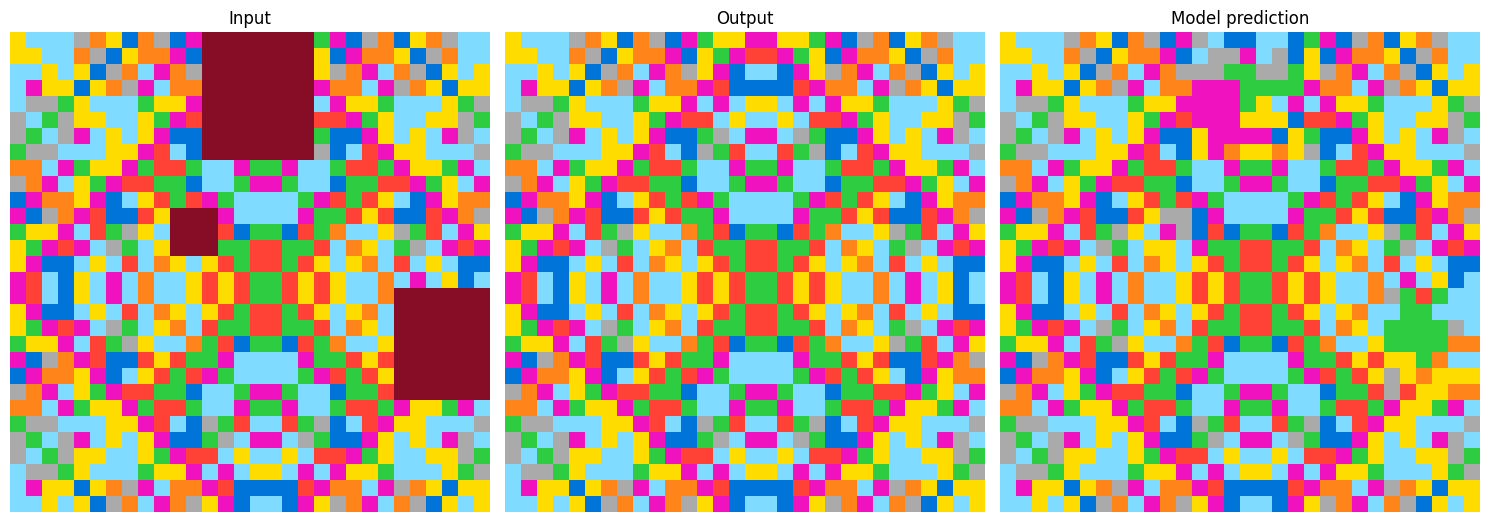

Accuracy: 0.8977777777777778


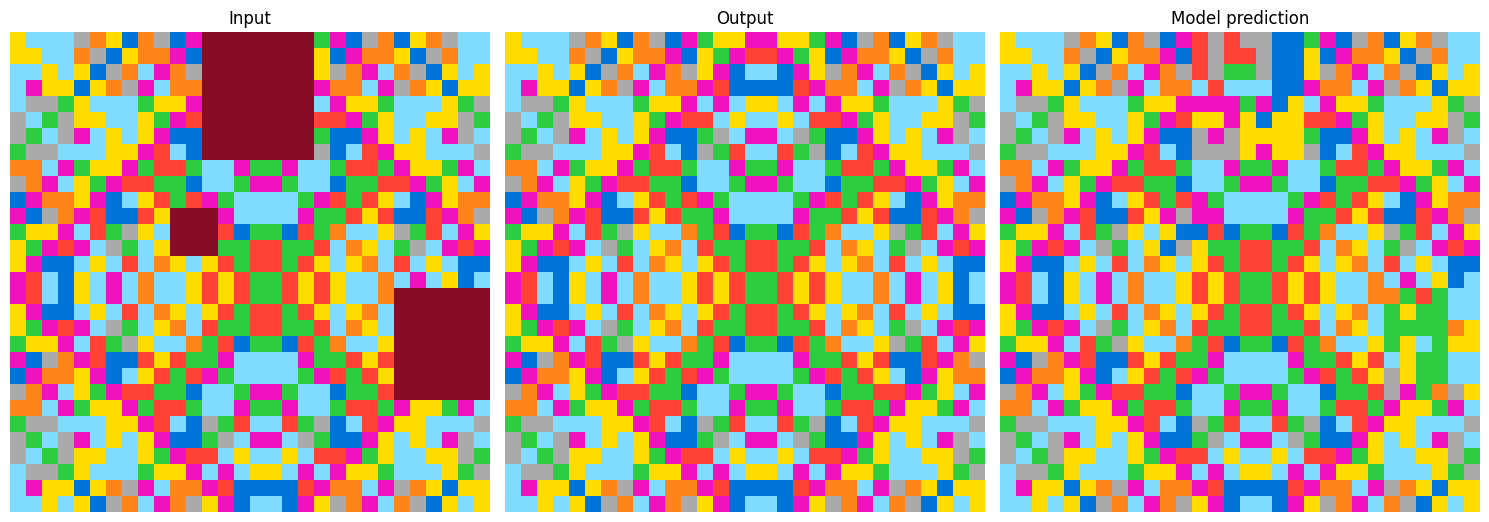

Accuracy: 0.8944444444444445
5ffb2104


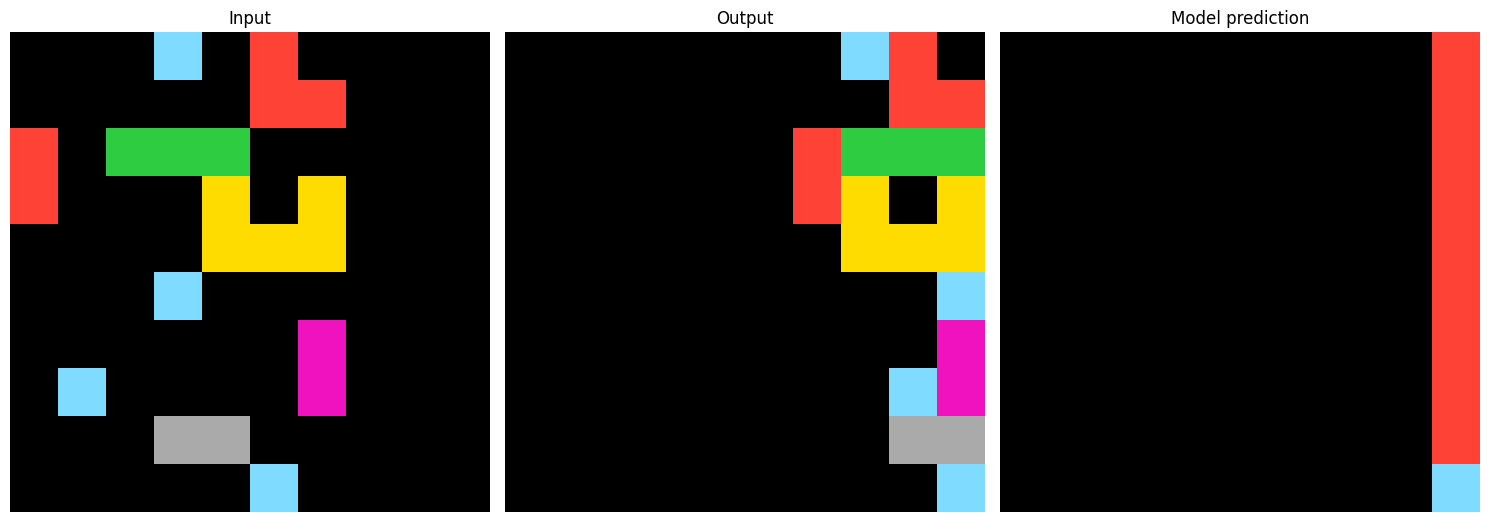

Accuracy: 0.8


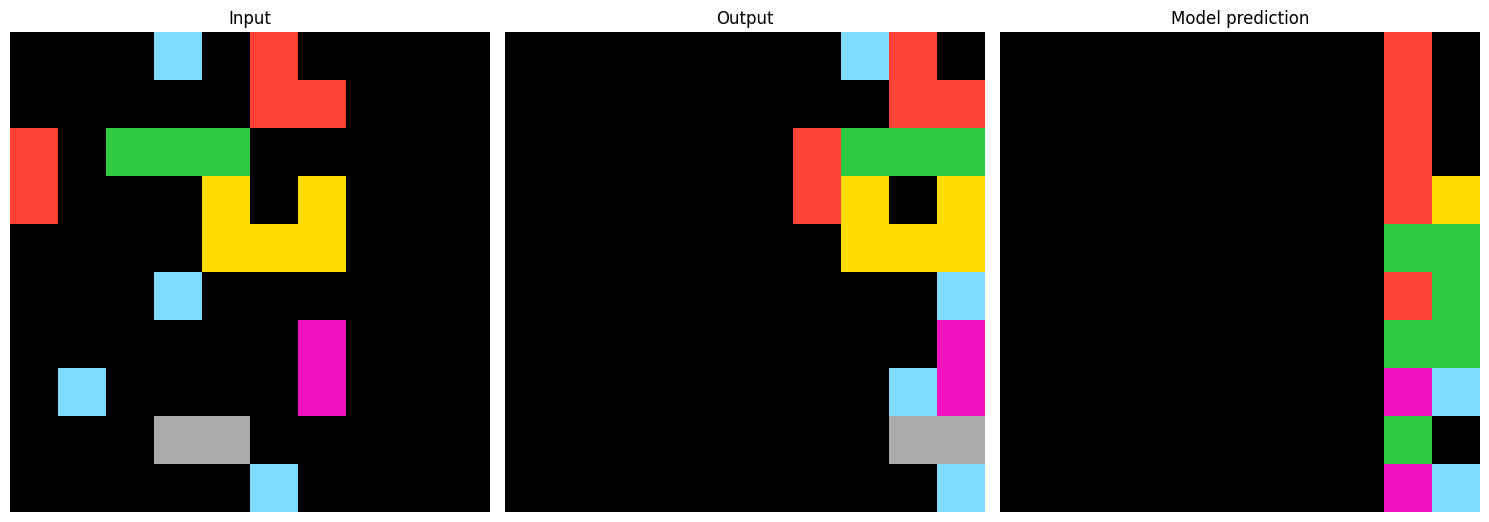

Accuracy: 0.79


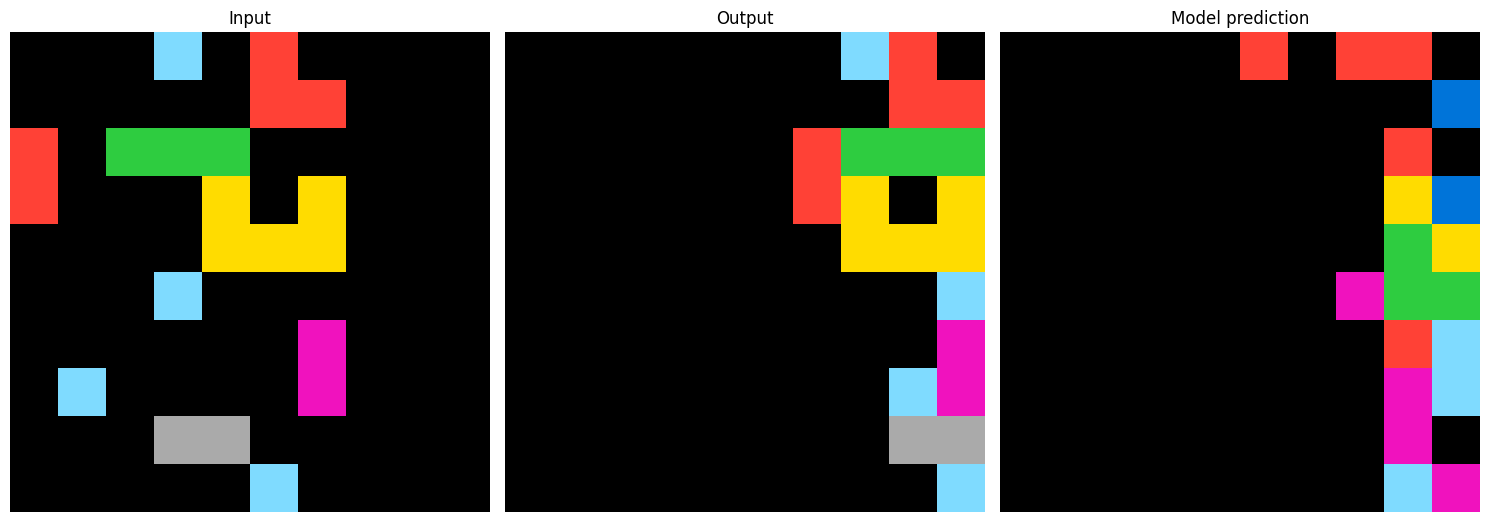

Accuracy: 0.75
2037f2c7
00dbd492


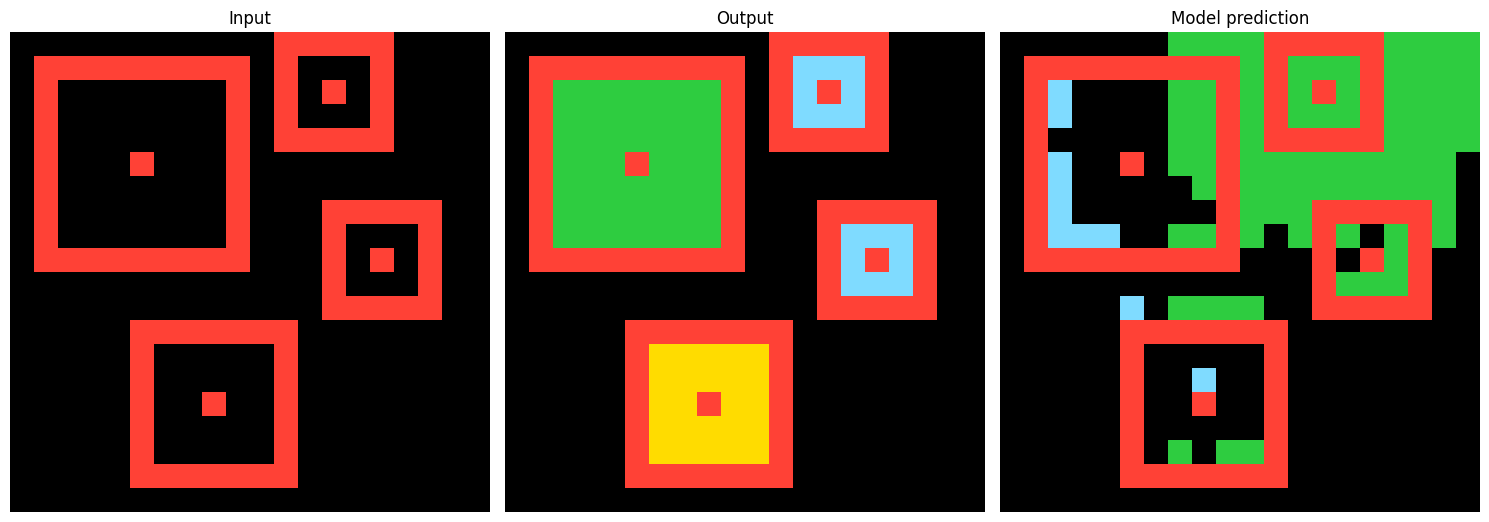

Accuracy: 0.6625


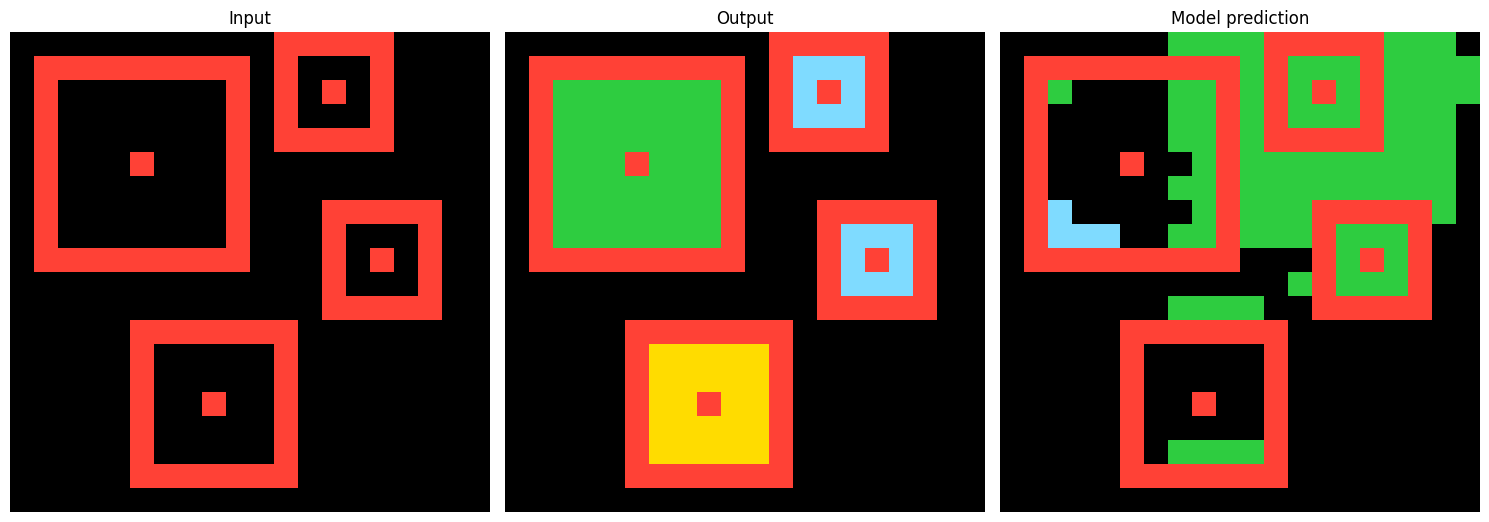

Accuracy: 0.675


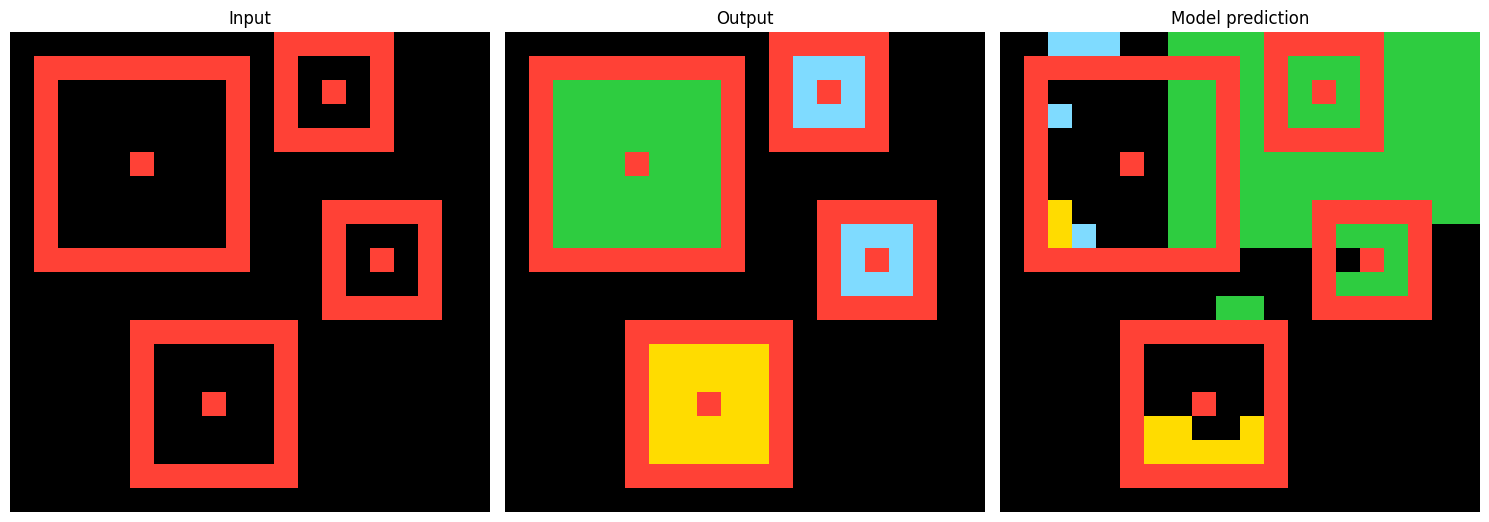

Accuracy: 0.6825
9c1e755f


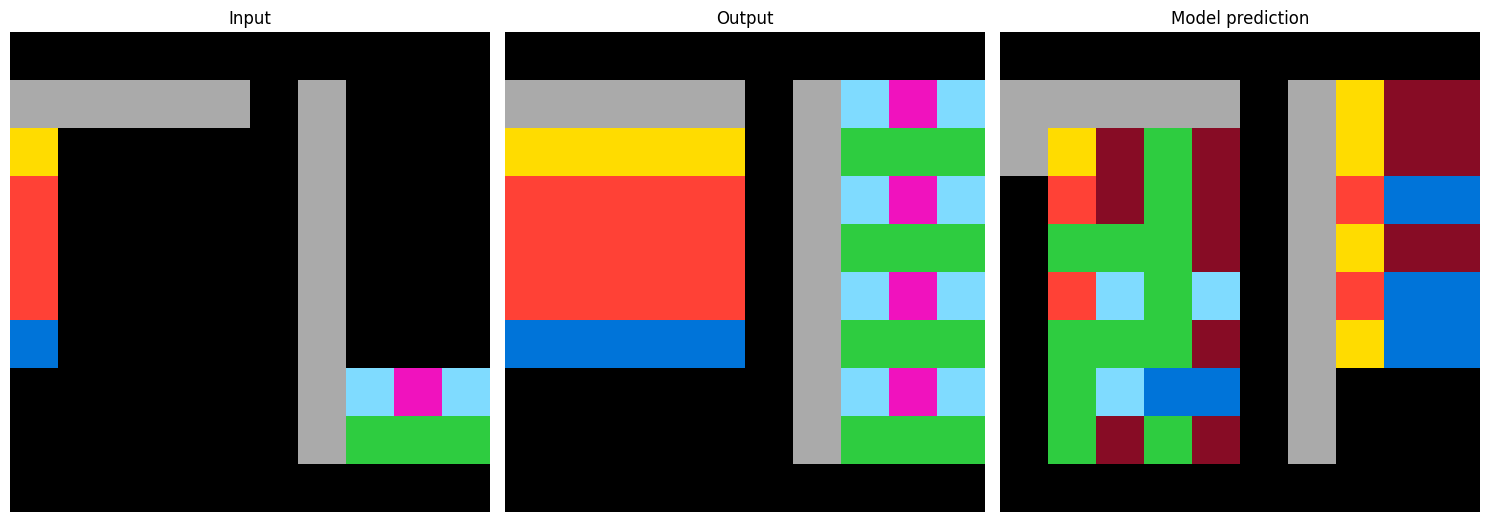

Accuracy: 0.46


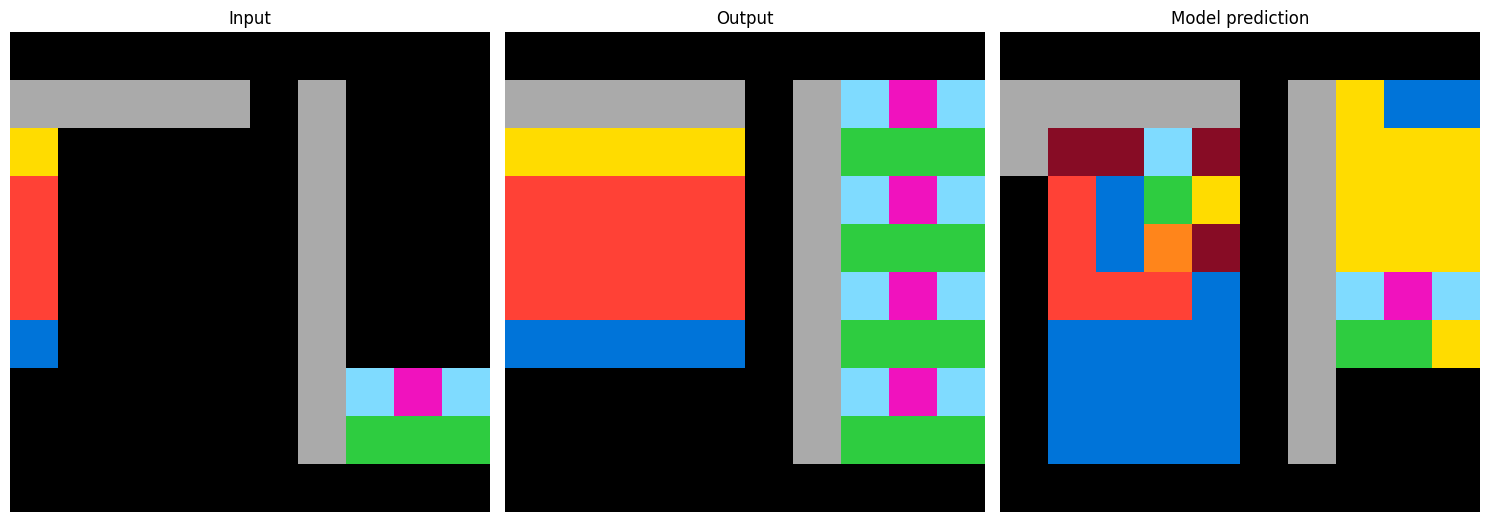

Accuracy: 0.57


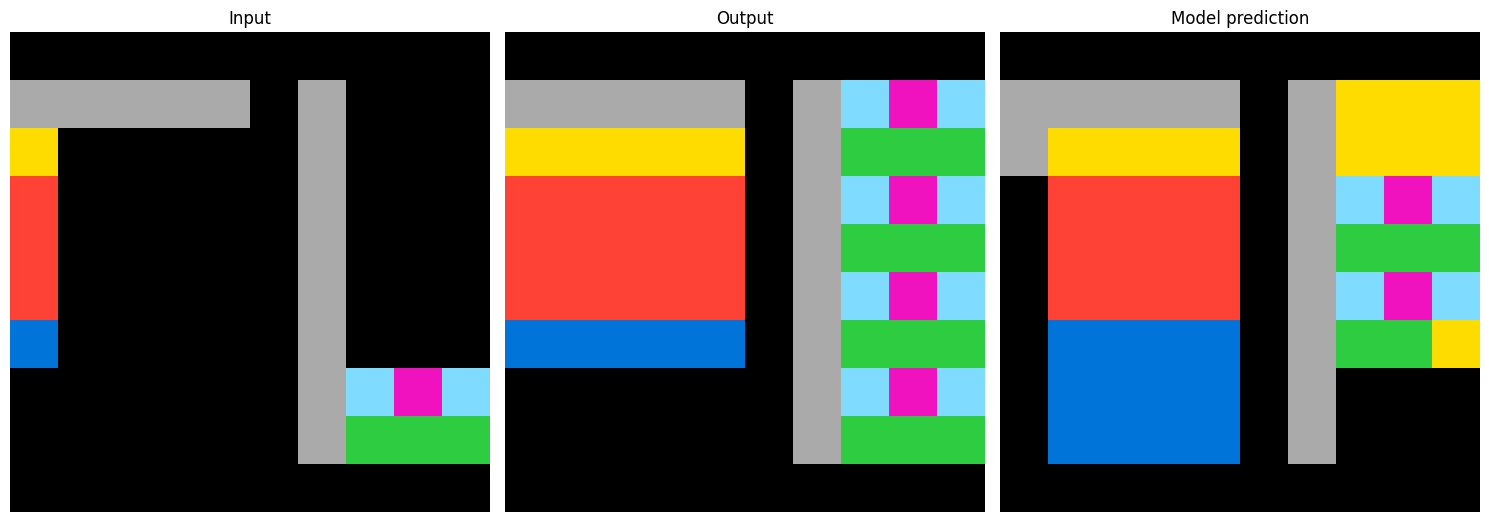

Accuracy: 0.74
6a11f6da
e760a62e


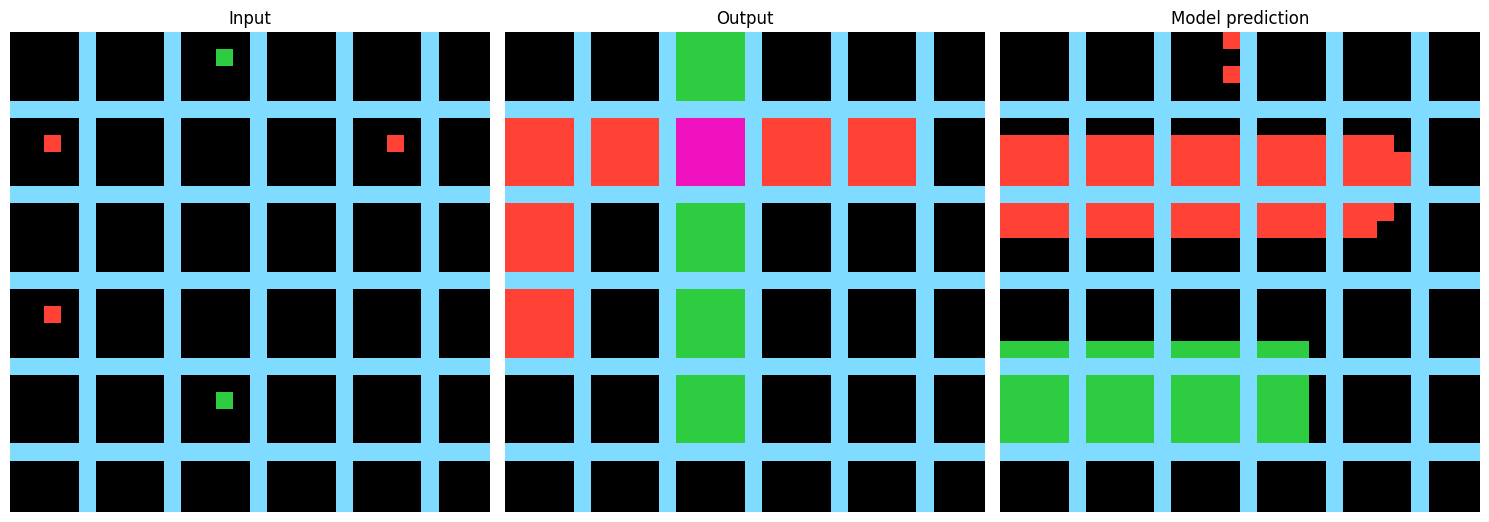

Accuracy: 0.7793367346938775


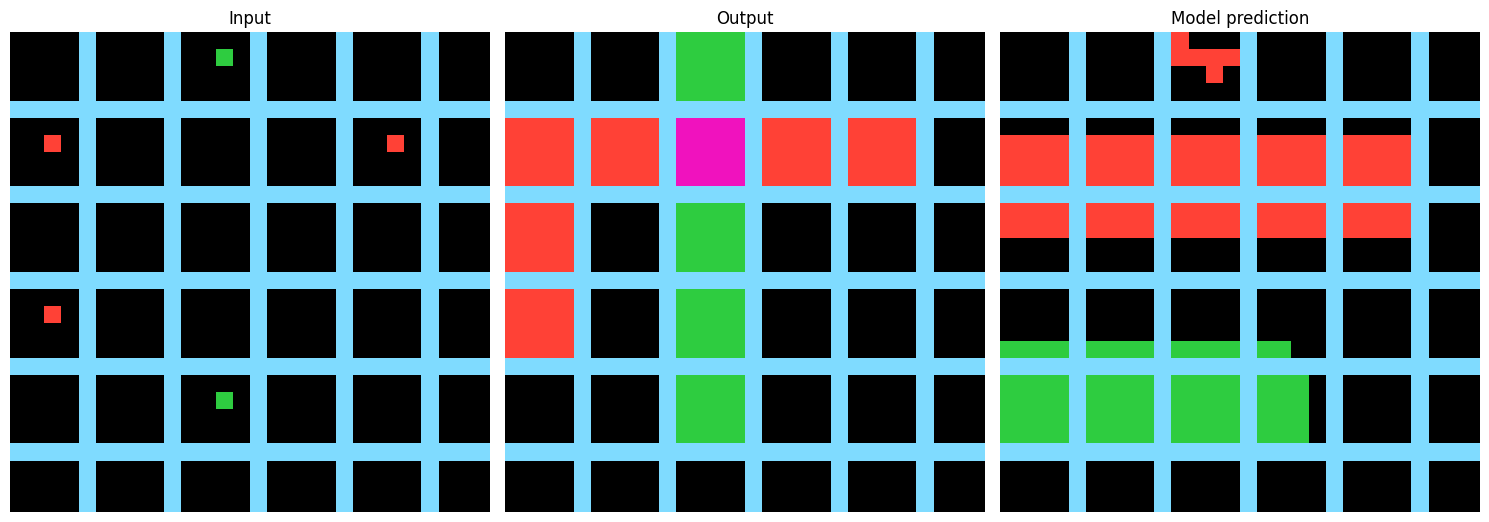

Accuracy: 0.7780612244897959


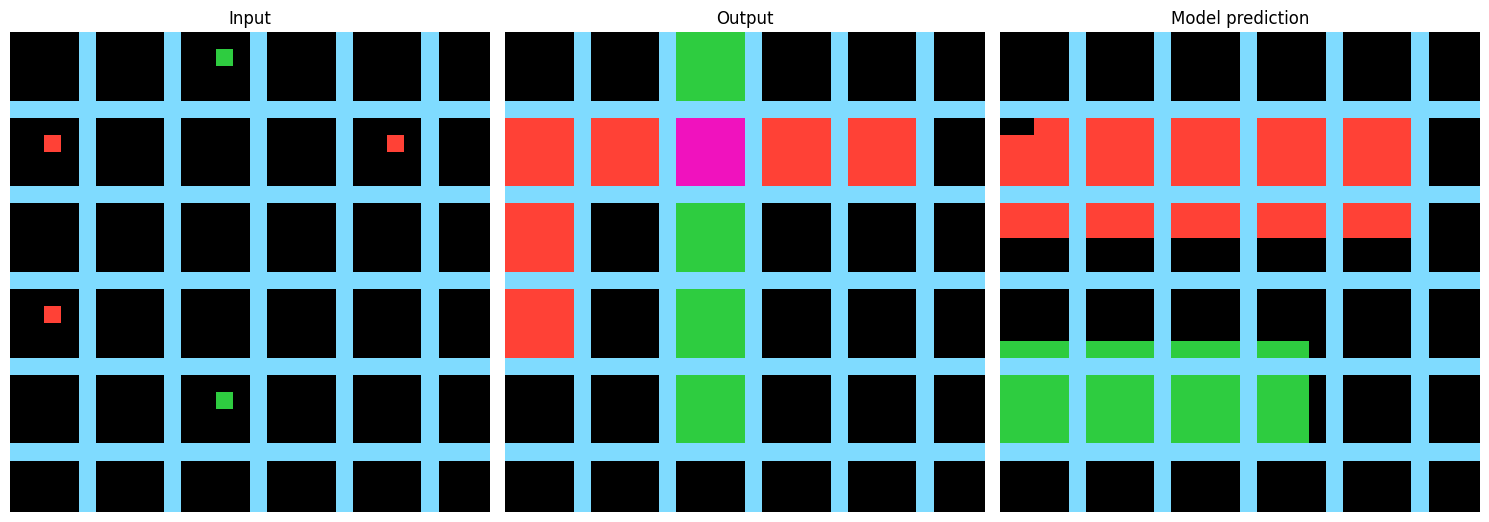

Accuracy: 0.7946428571428571
7bb29440
19bb5feb
6ad5bdfd


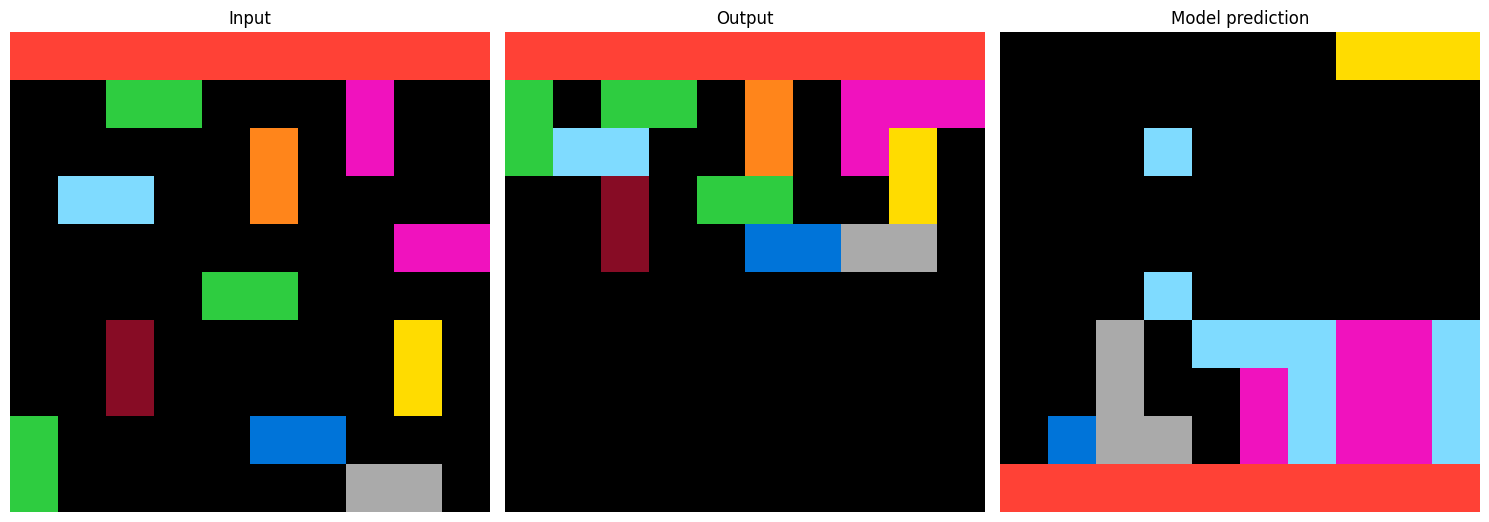

Accuracy: 0.35


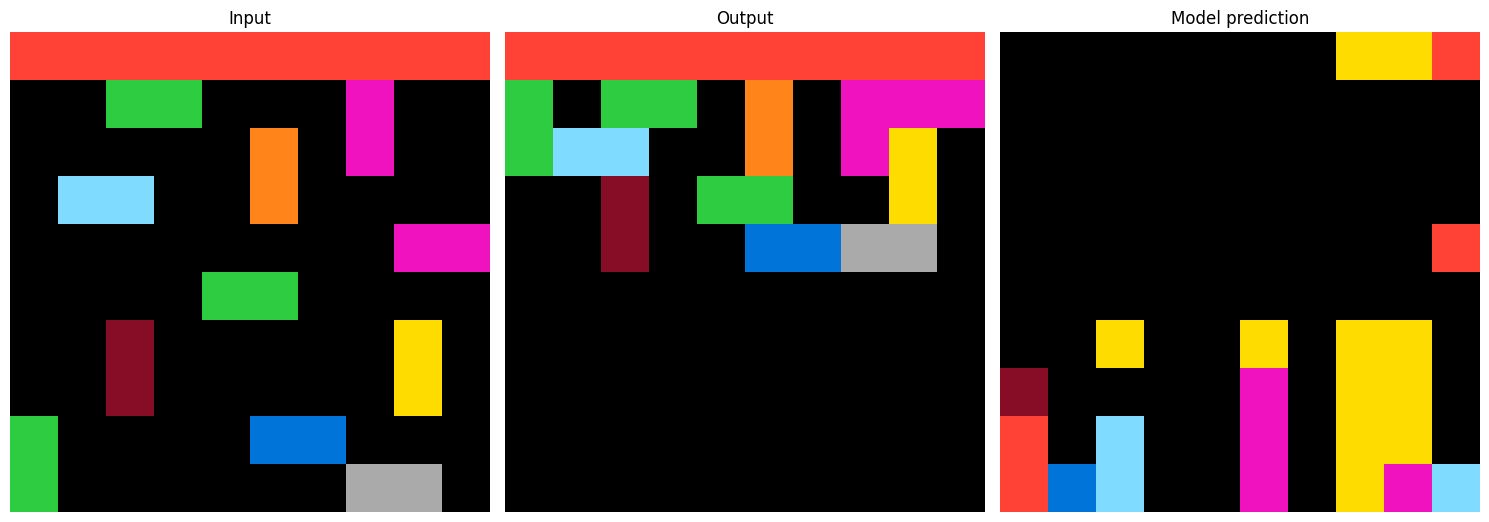

Accuracy: 0.48


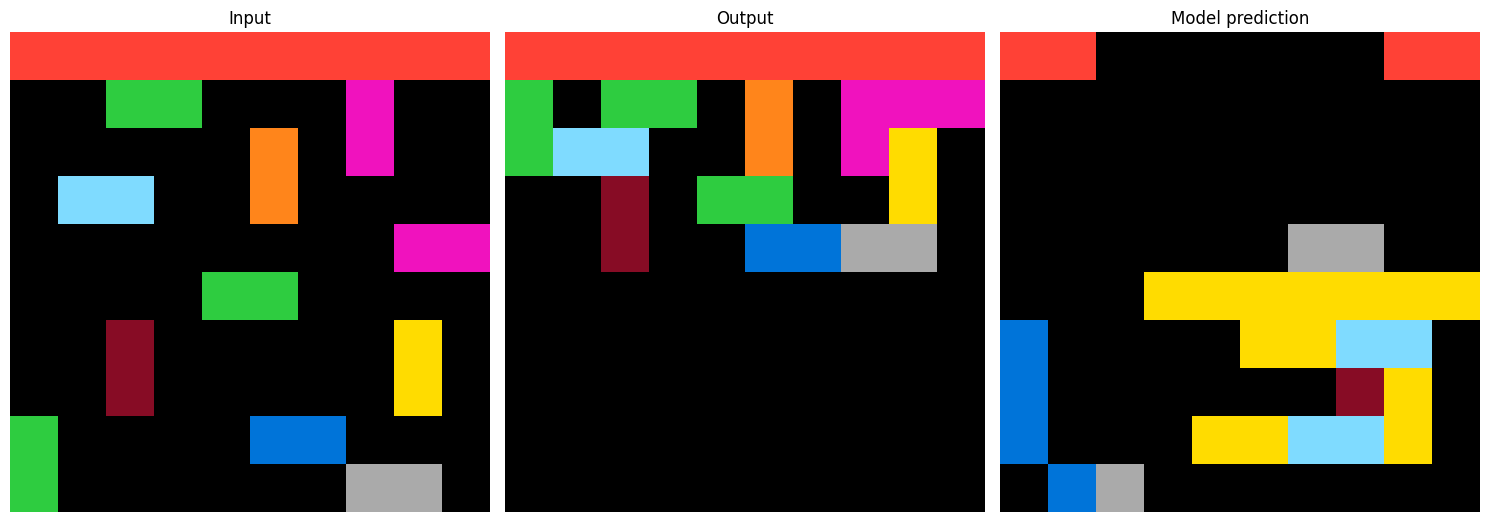

Accuracy: 0.5
891232d6


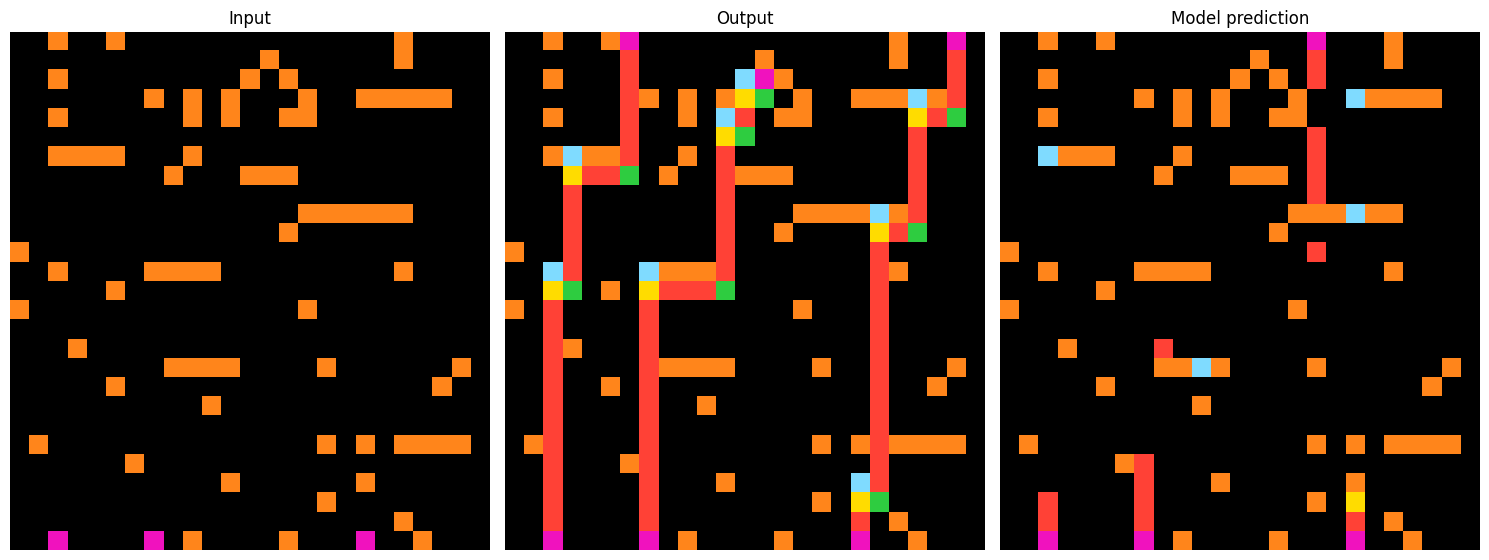

Accuracy: 0.845925925925926


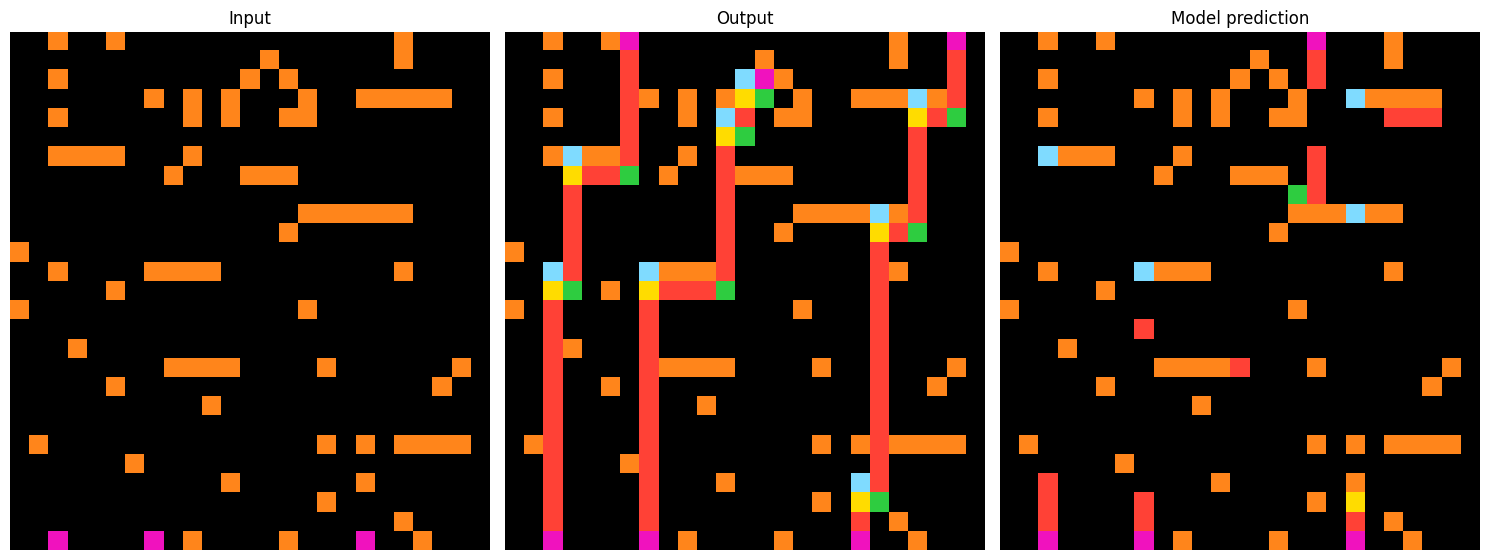

Accuracy: 0.8503703703703703


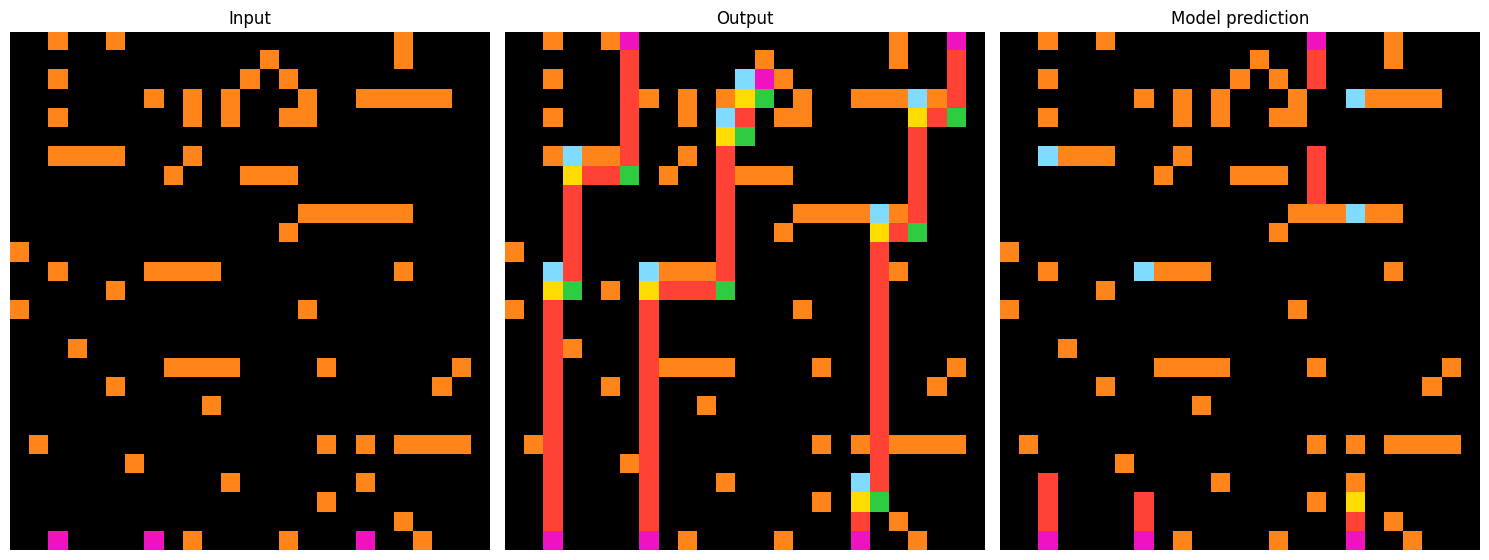

Accuracy: 0.8518518518518519
292dd178


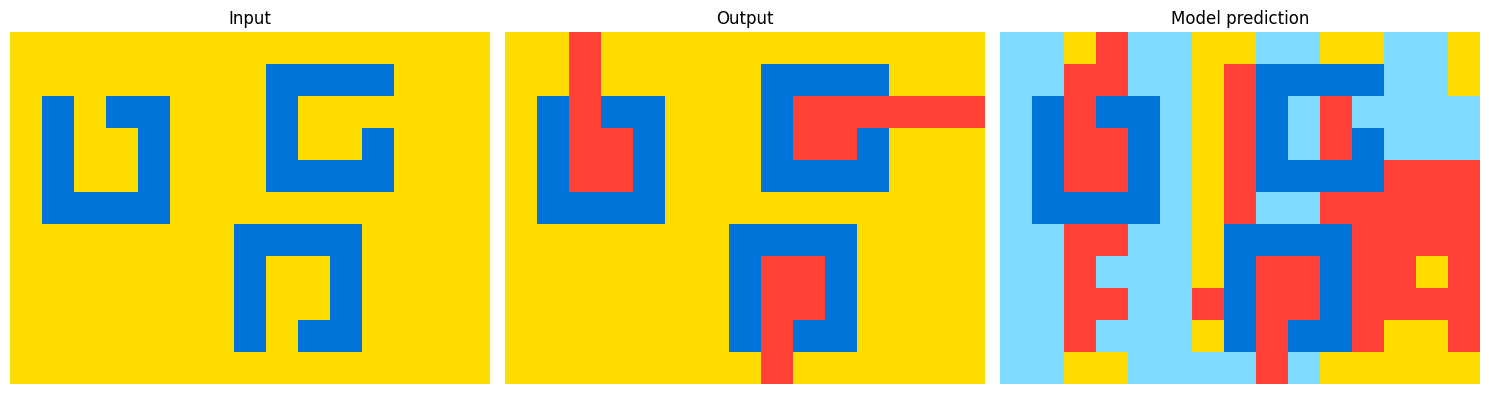

Accuracy: 0.4303030303030303


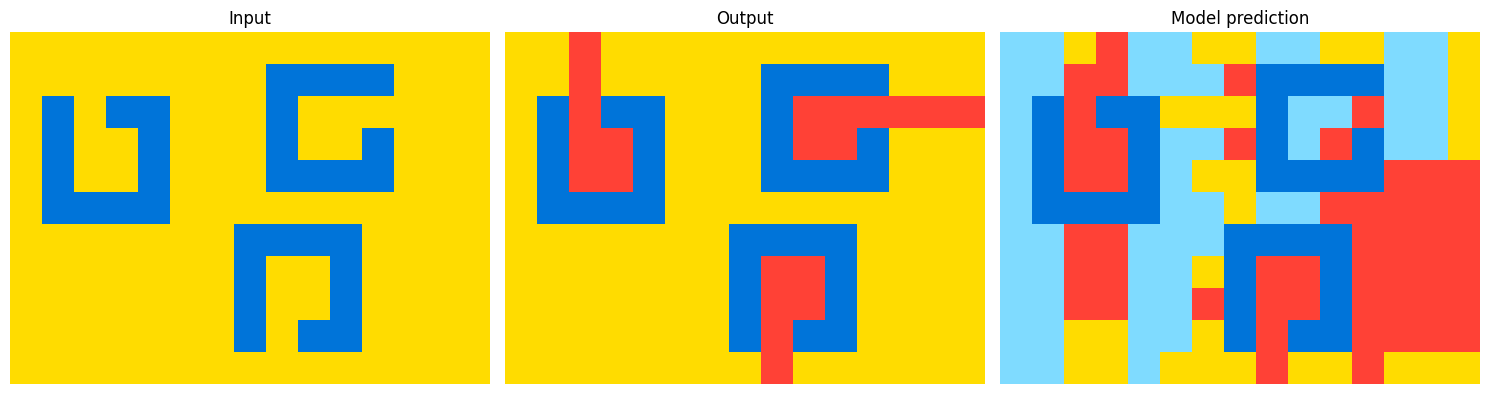

Accuracy: 0.4484848484848485


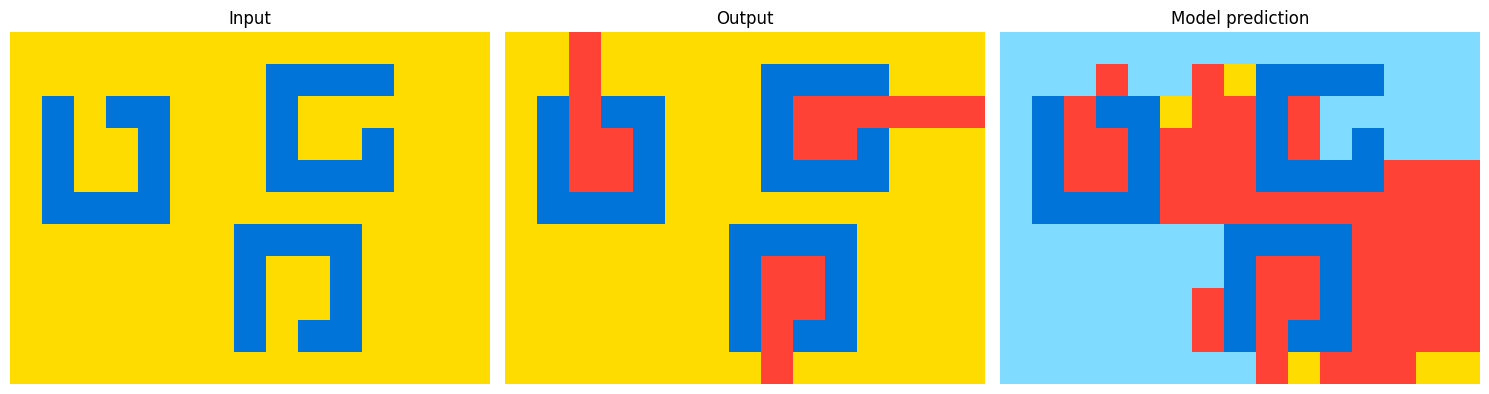

Accuracy: 0.3090909090909091
67b4a34d
94be5b80


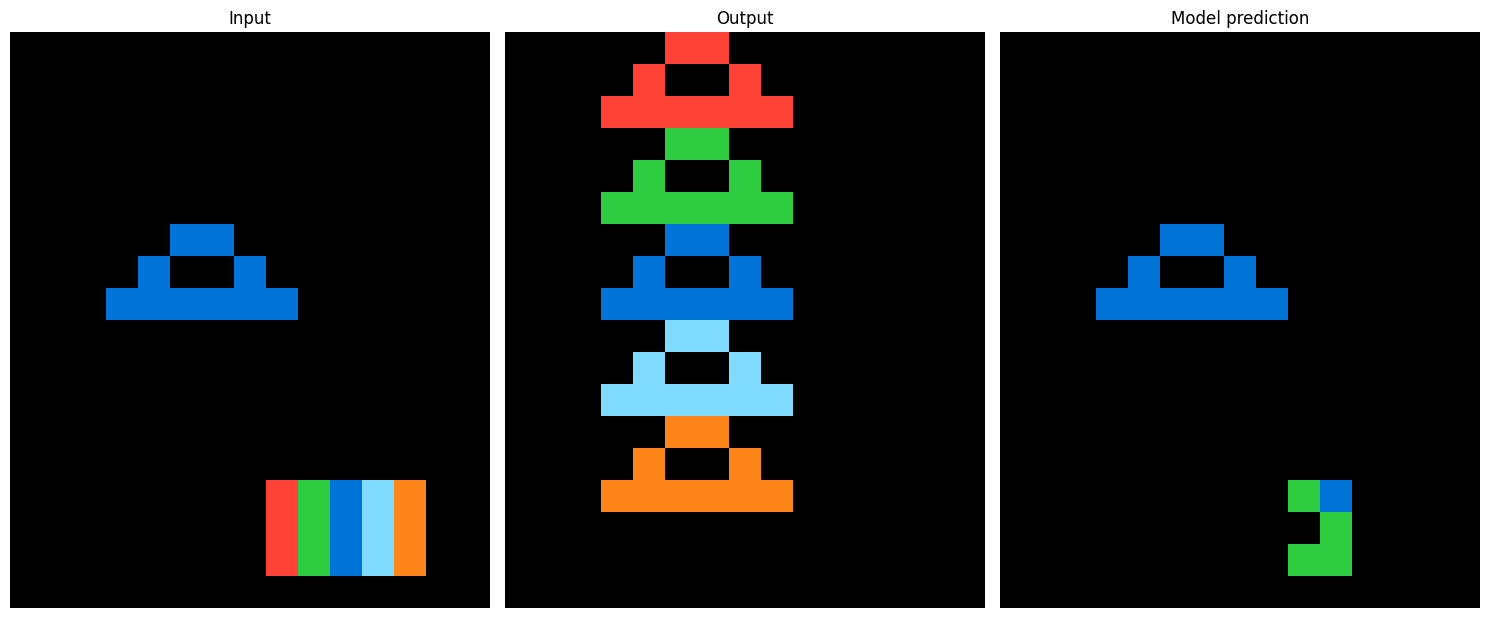

Accuracy: 0.8333333333333334


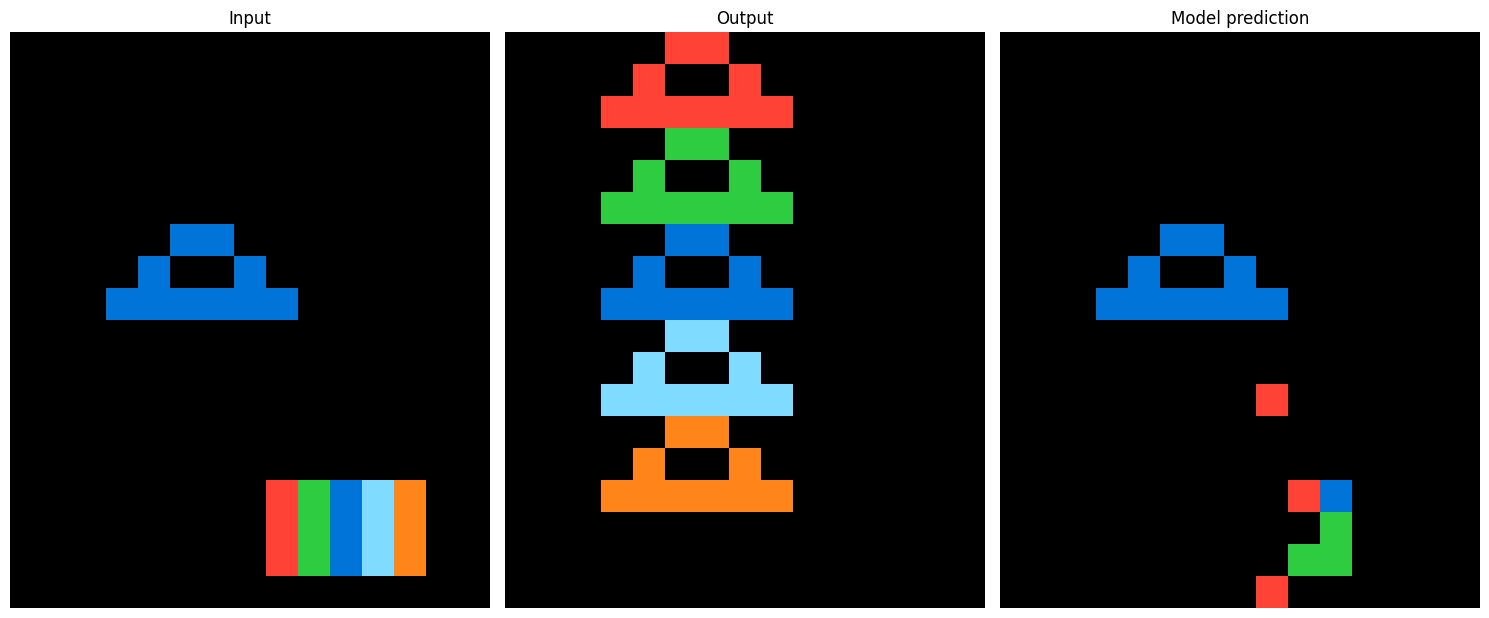

Accuracy: 0.8296296296296296


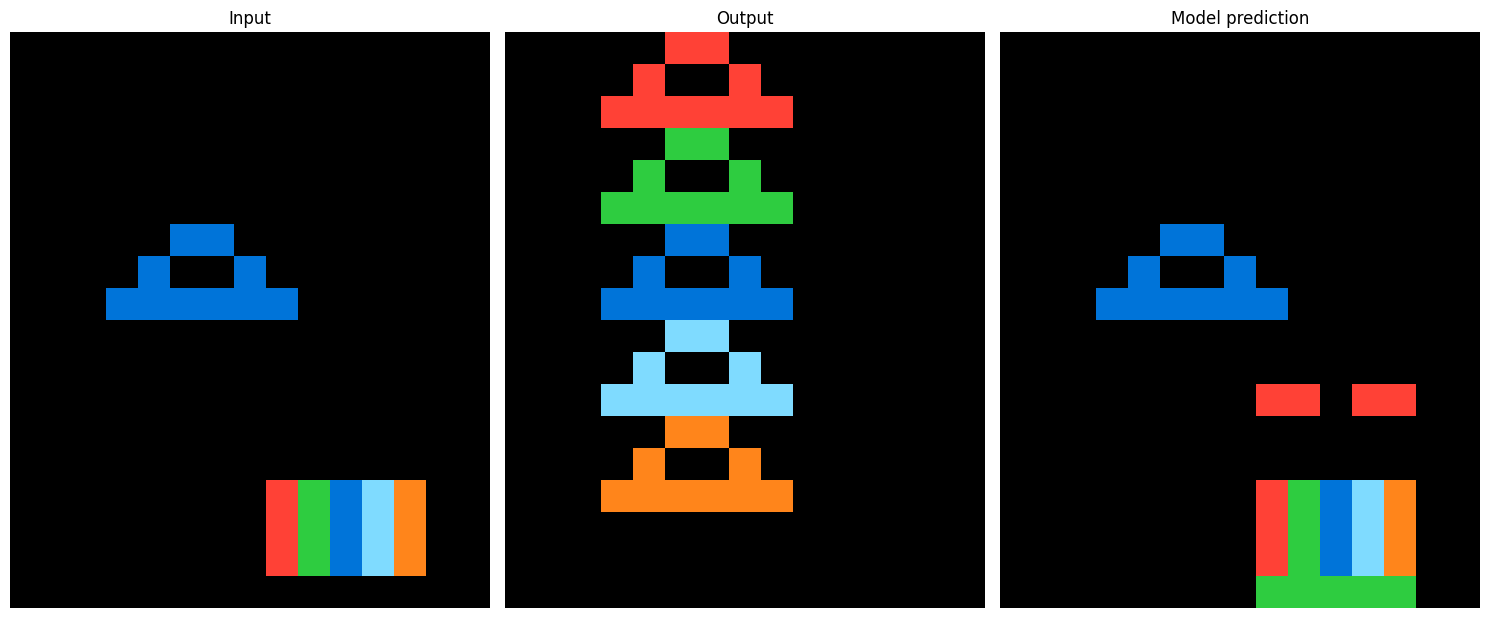

Accuracy: 0.7703703703703704
df8cc377


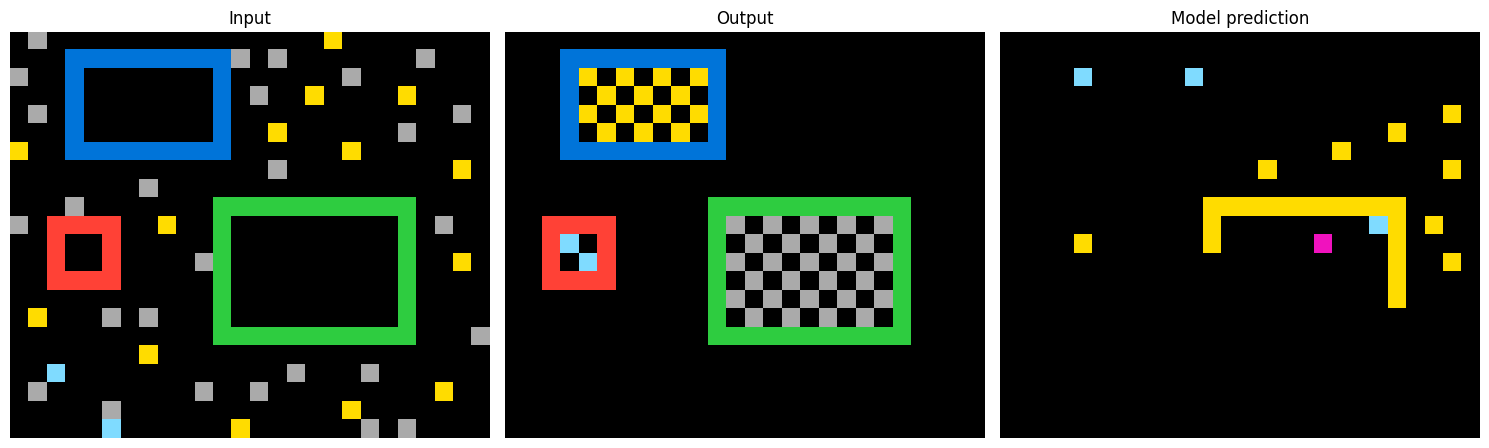

Accuracy: 0.784965034965035


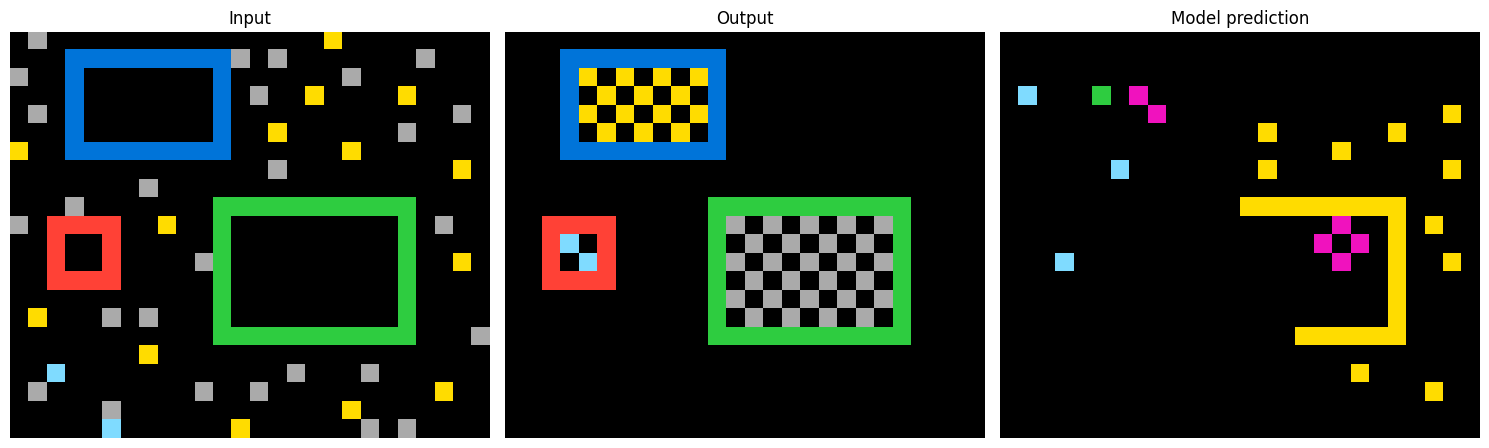

Accuracy: 0.7762237762237763


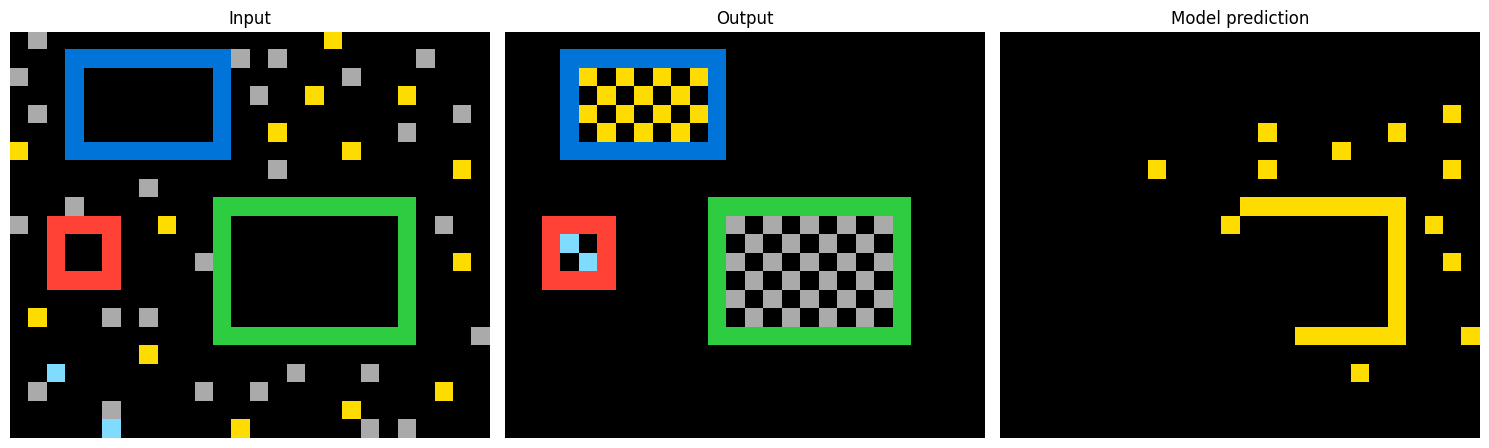

Accuracy: 0.7797202797202797
ce8d95cc
72a961c9


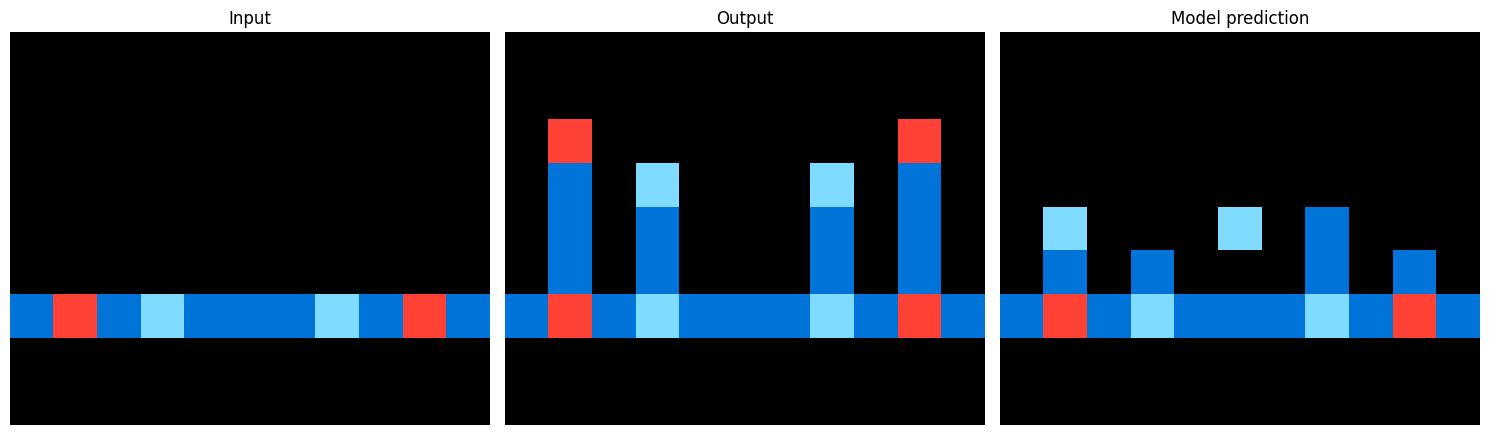

Accuracy: 0.898989898989899


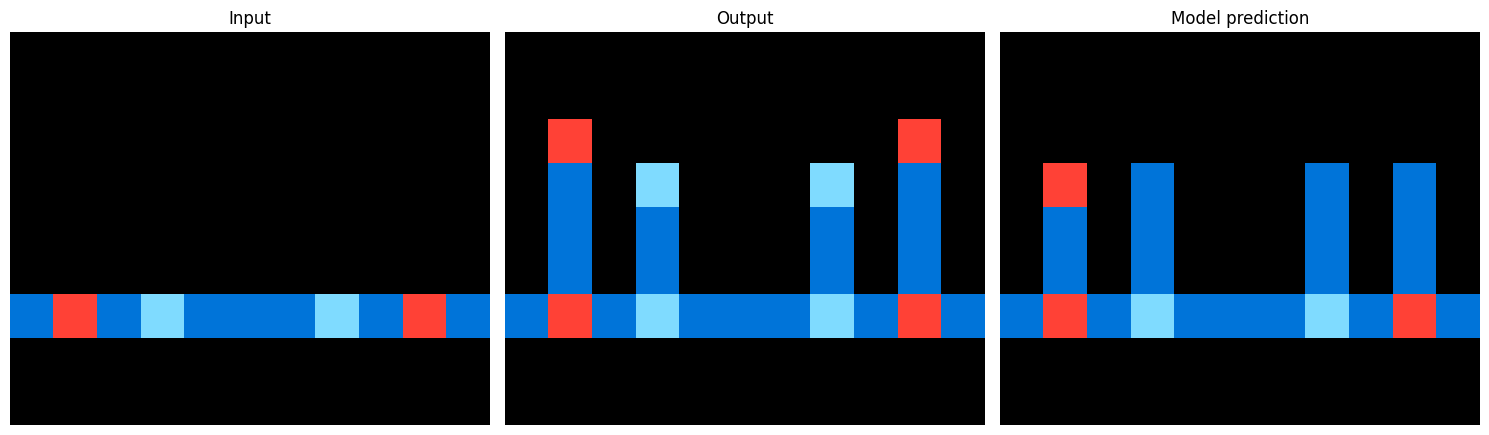

Accuracy: 0.9494949494949495


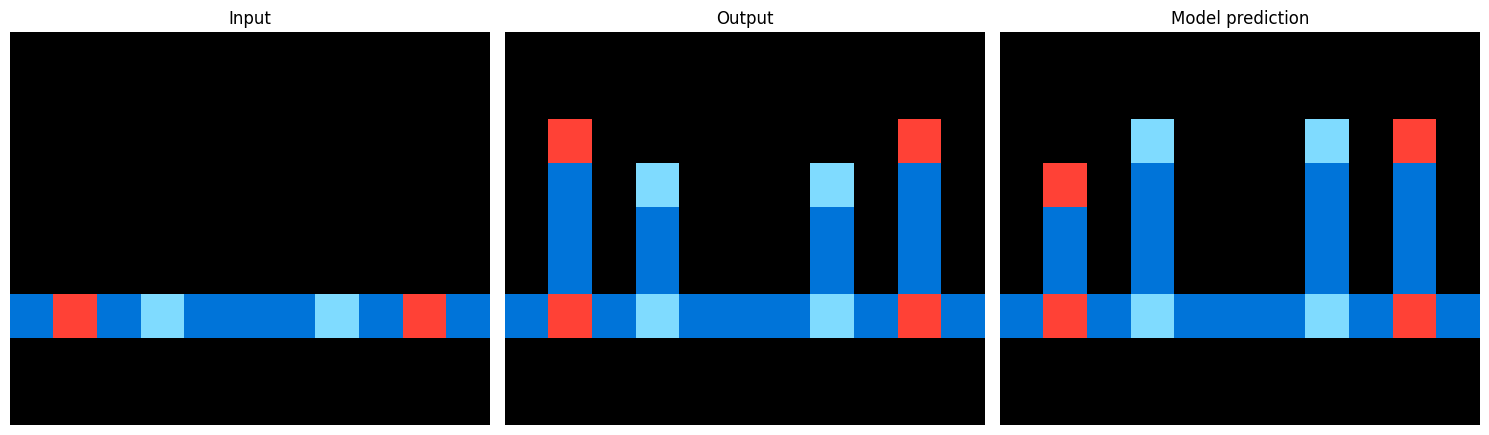

Accuracy: 0.9393939393939394
6f473927
18419cfa


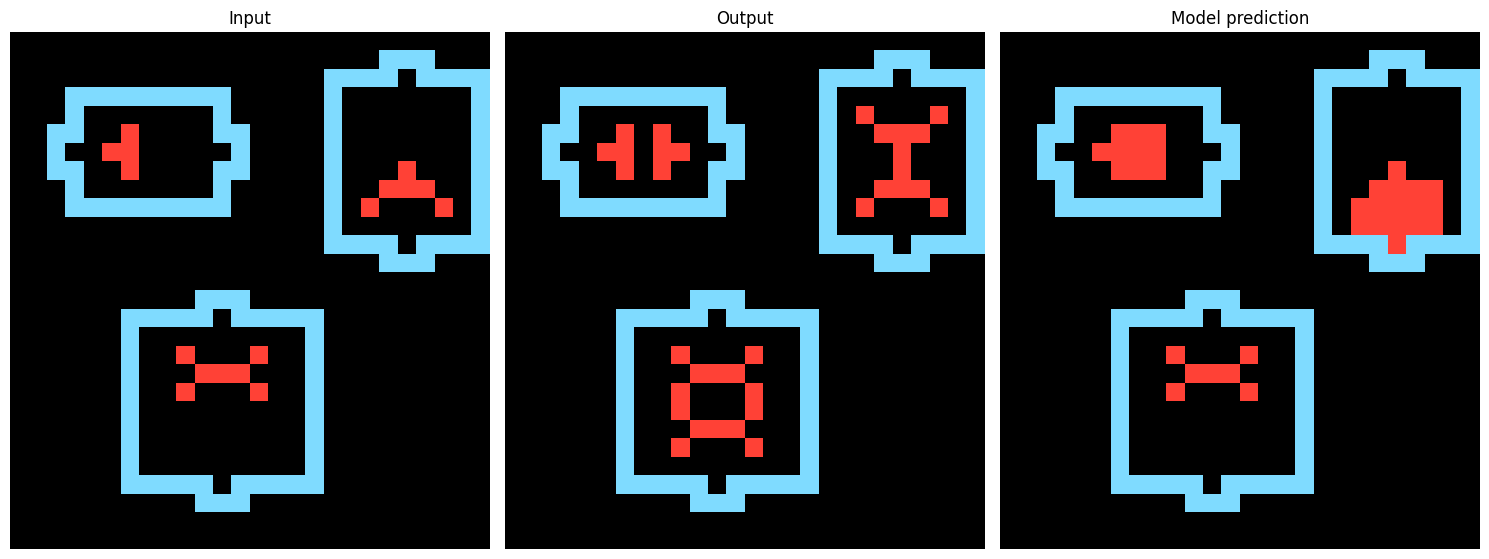

Accuracy: 0.9629120879120879


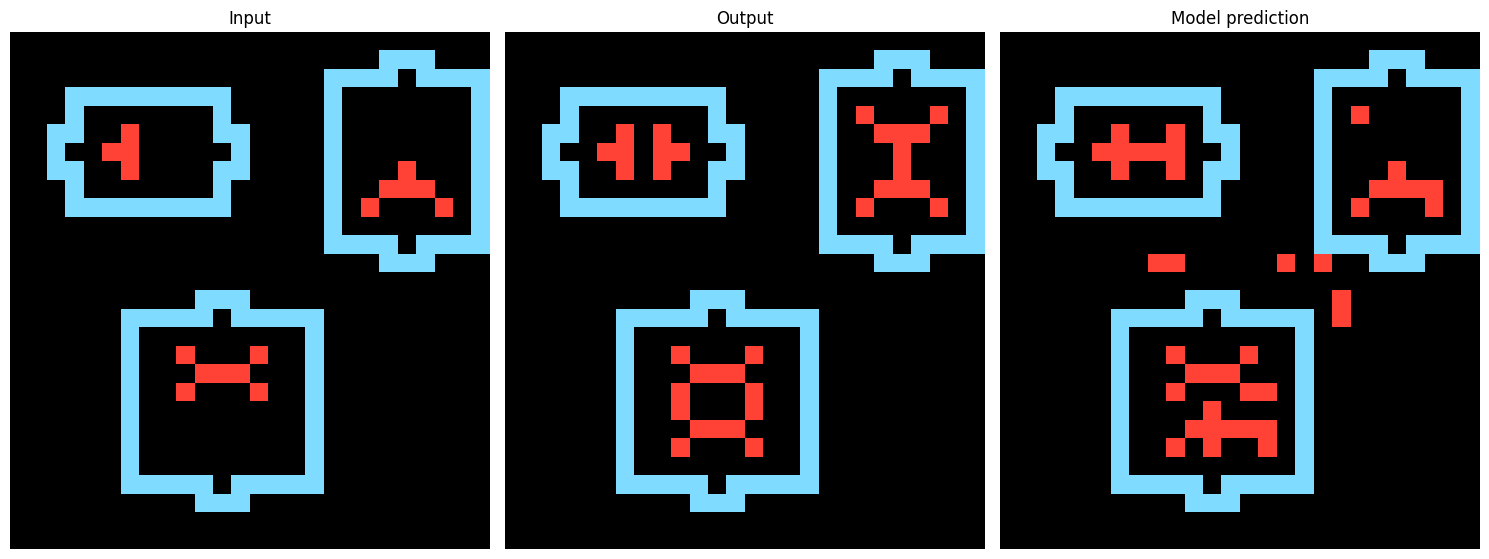

Accuracy: 0.9642857142857143


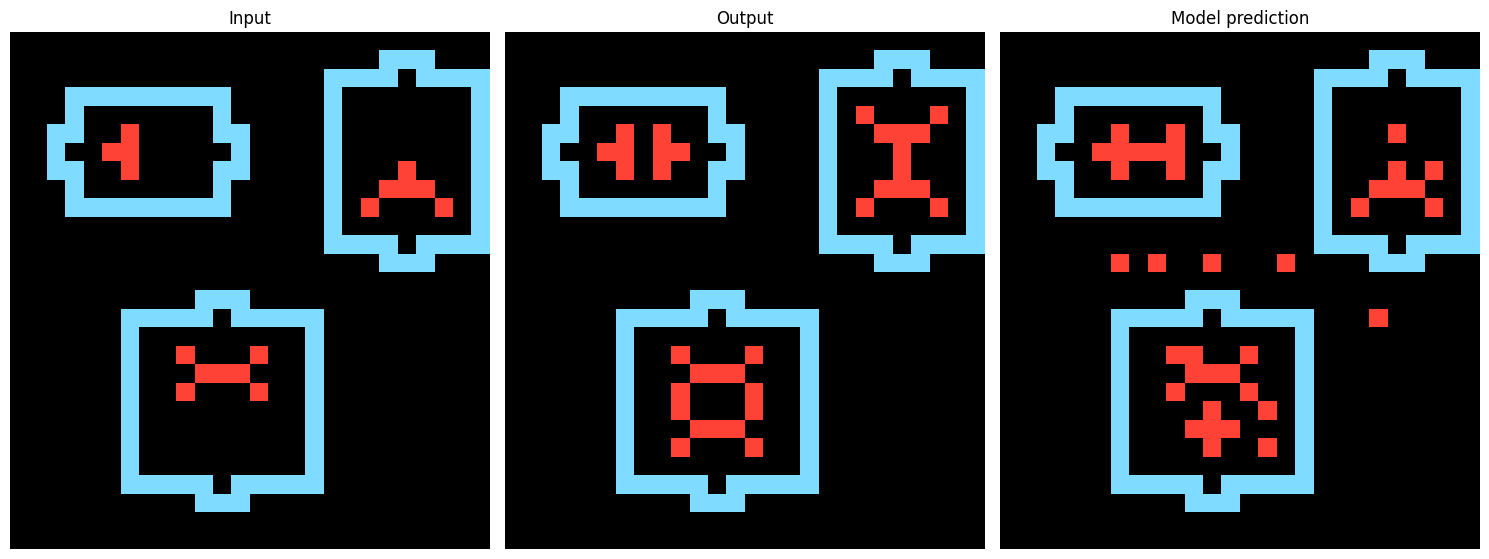

Accuracy: 0.9656593406593407
45bbe264


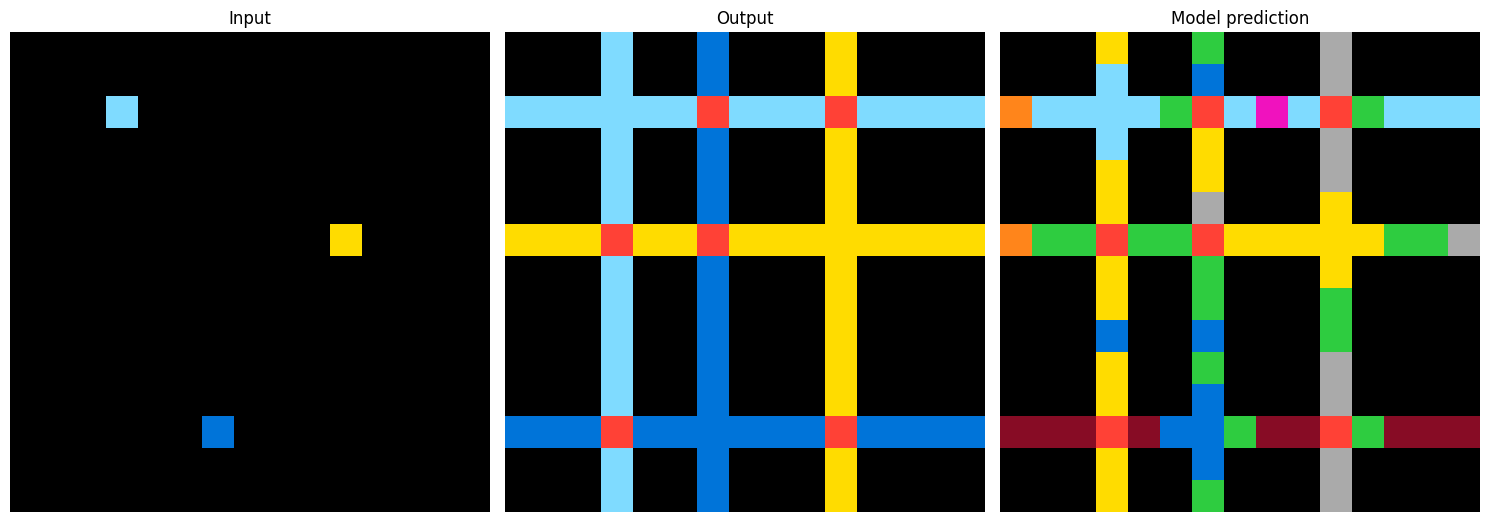

Accuracy: 0.7733333333333333


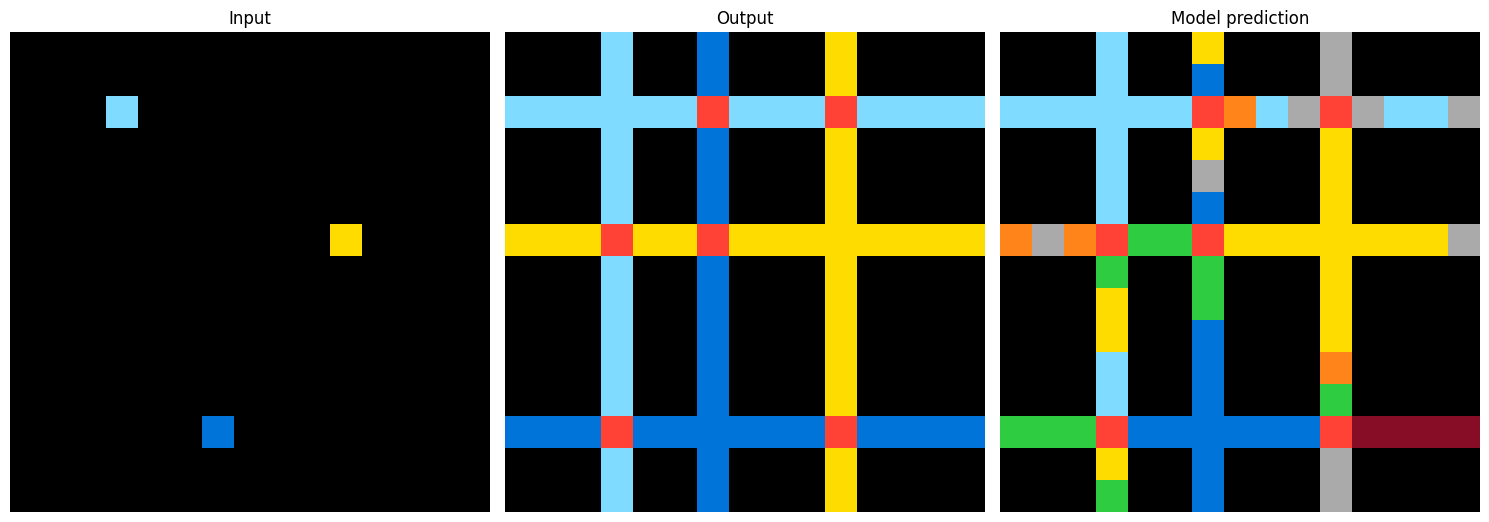

Accuracy: 0.8533333333333334


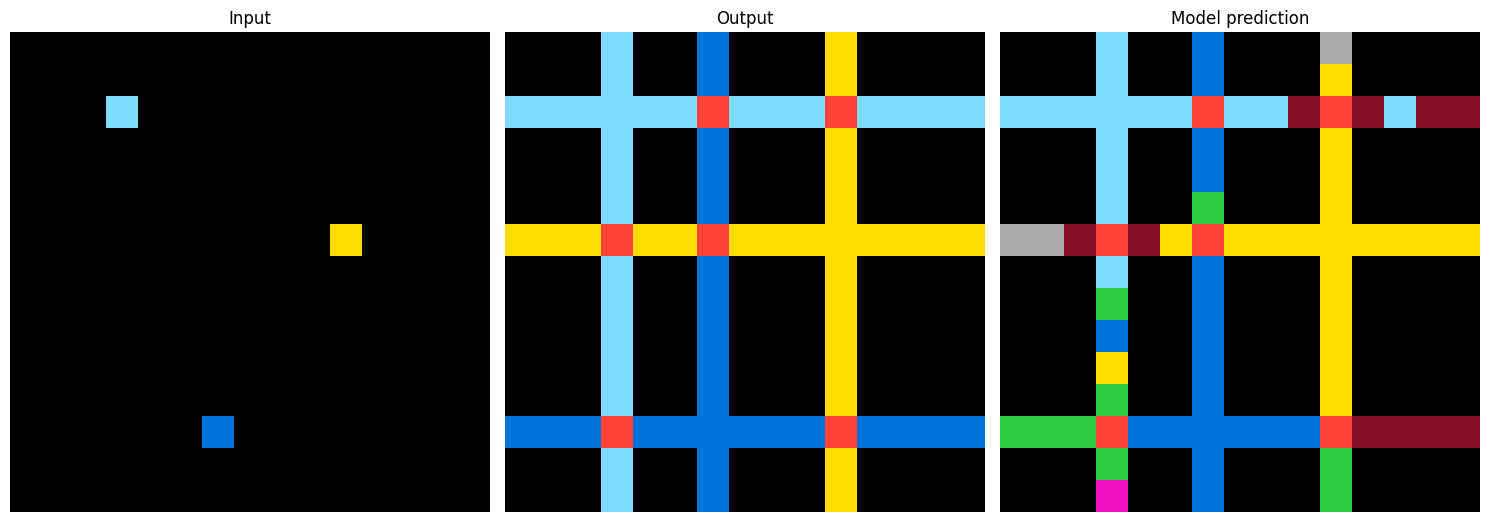

Accuracy: 0.8888888888888888
7c8af763


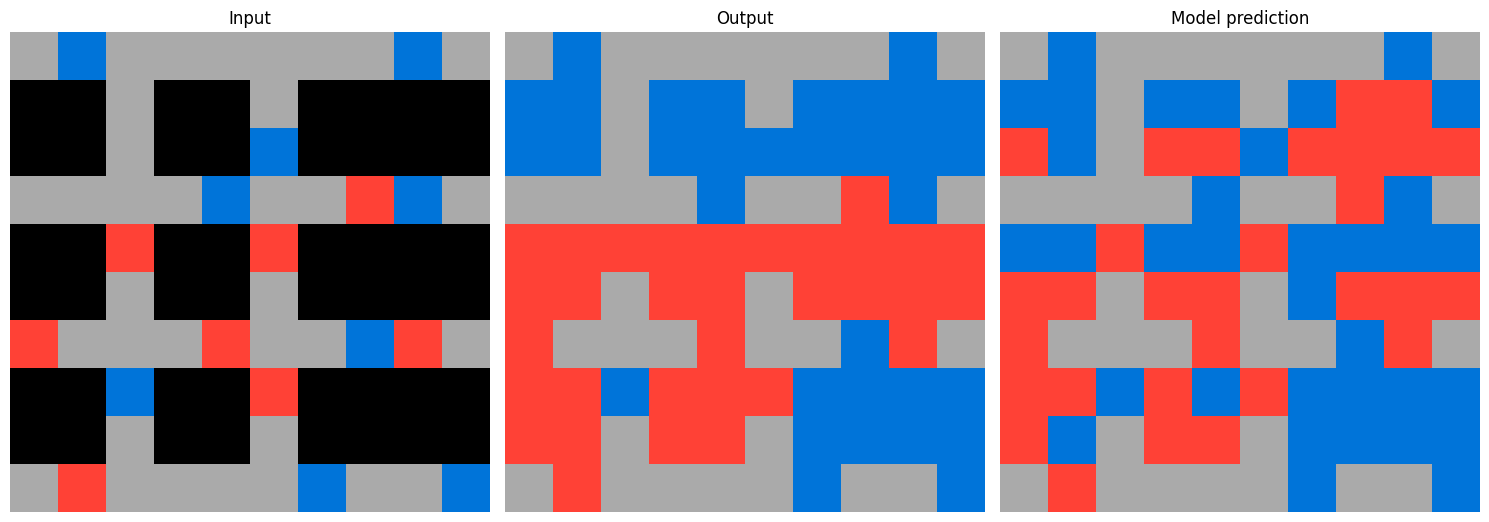

Accuracy: 0.8


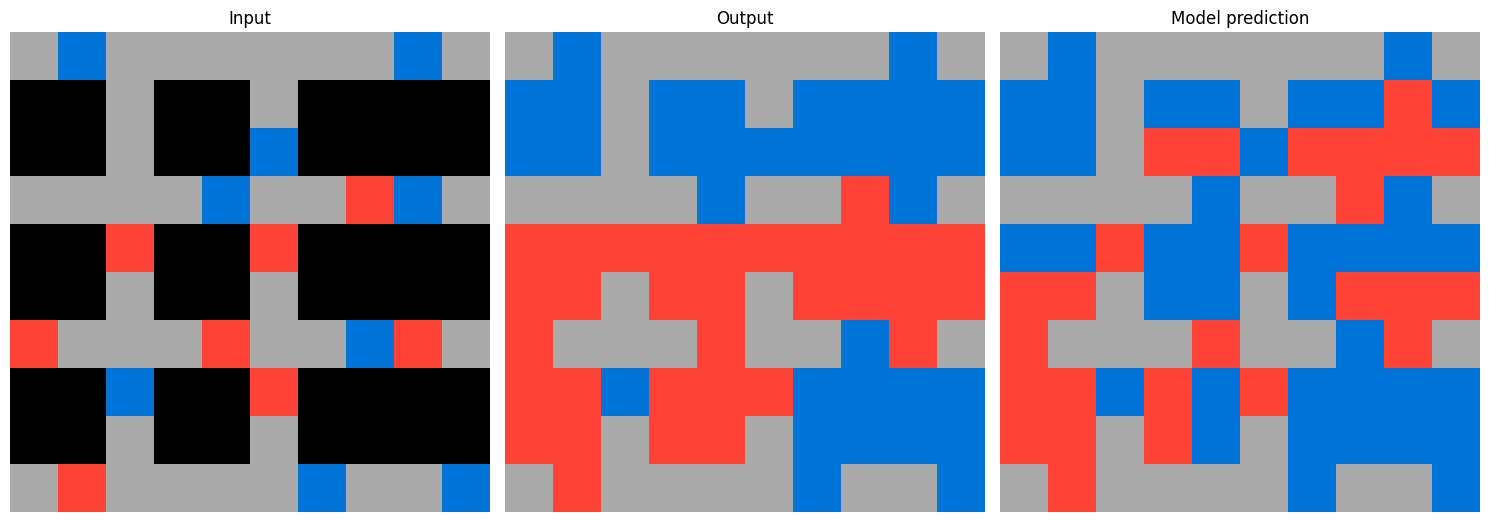

Accuracy: 0.8


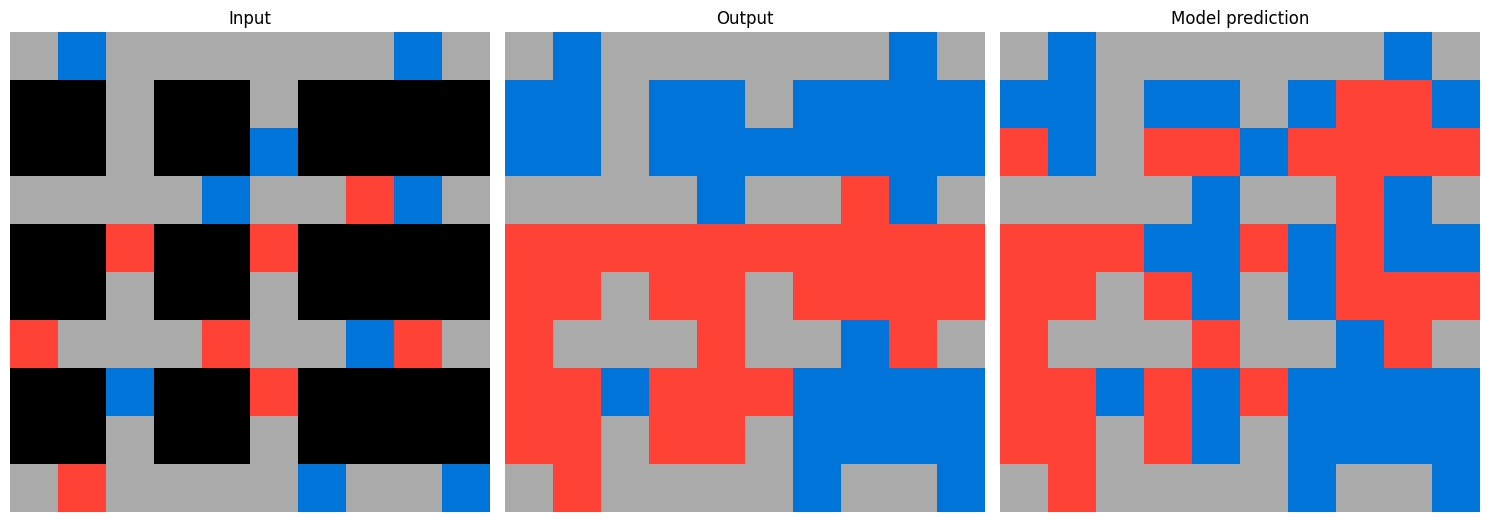

Accuracy: 0.82
f8be4b64


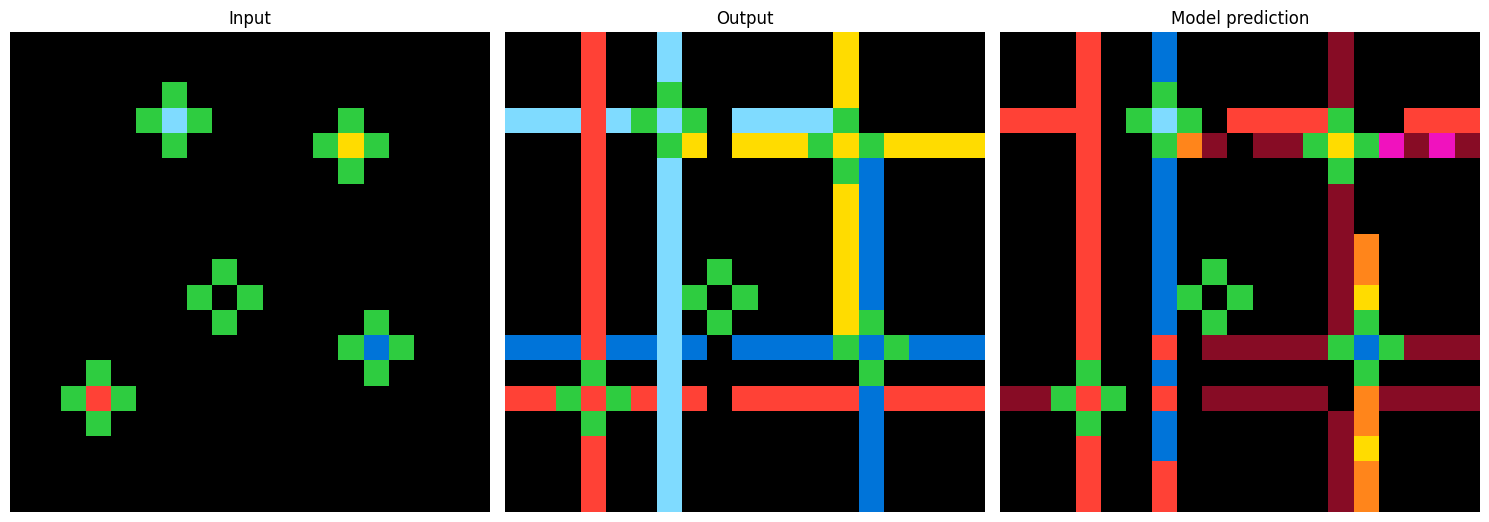

Accuracy: 0.7562326869806094


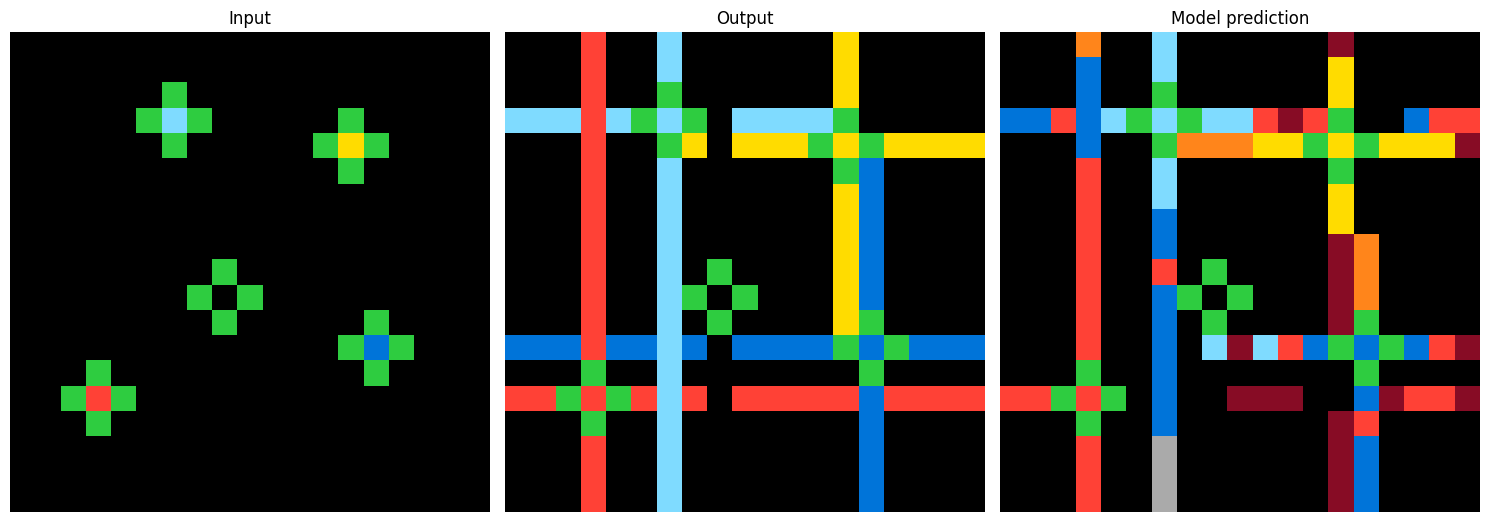

Accuracy: 0.8116343490304709


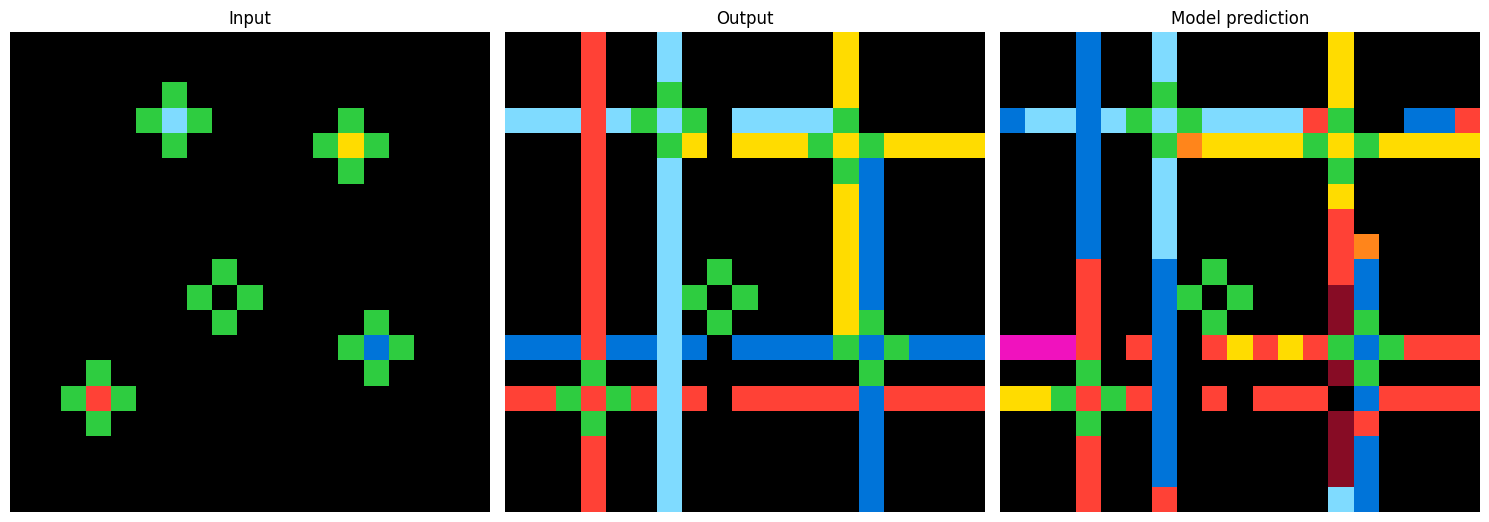

Accuracy: 0.8282548476454293
e7dd8335


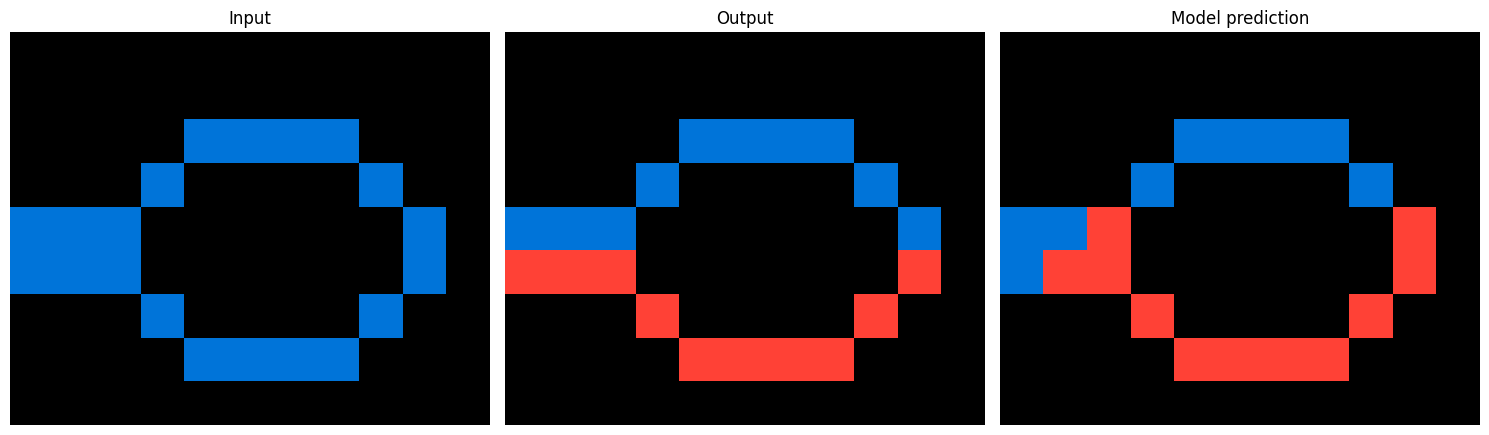

Accuracy: 0.9696969696969697


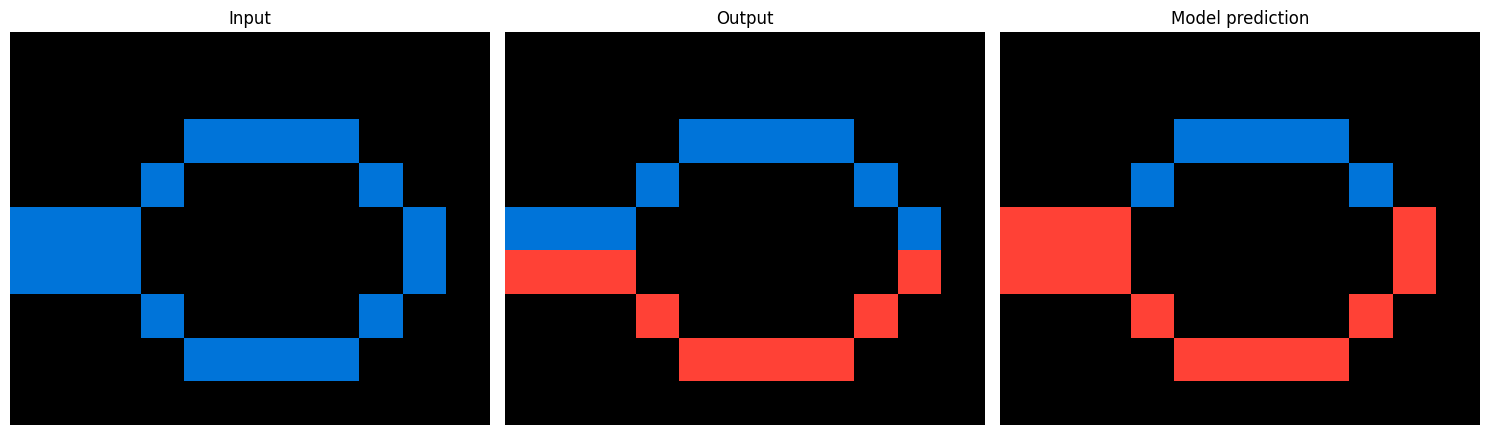

Accuracy: 0.9595959595959596


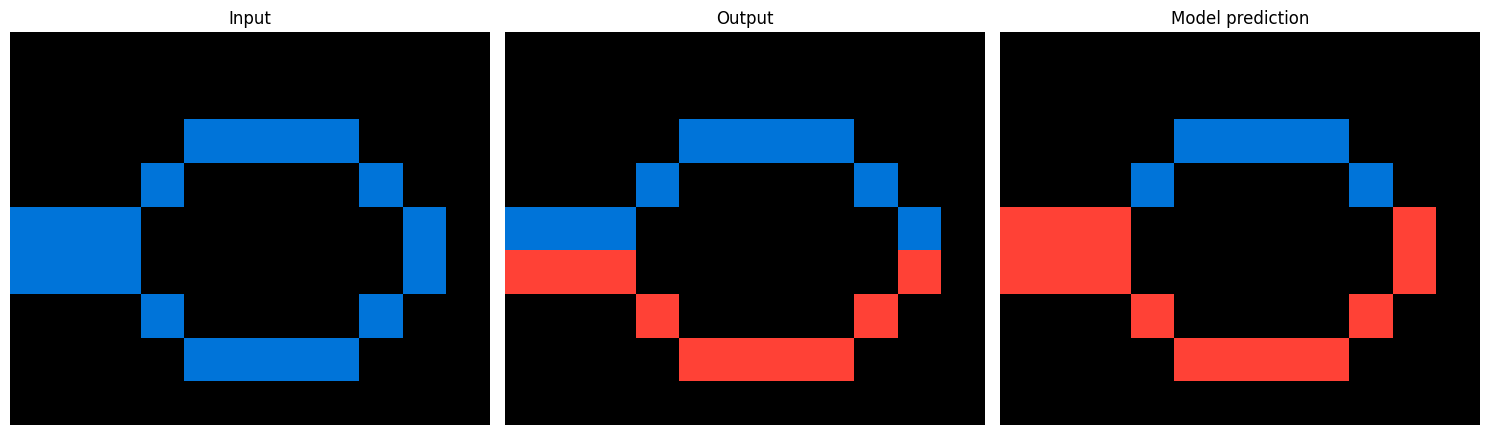

Accuracy: 0.9595959595959596
103eff5b


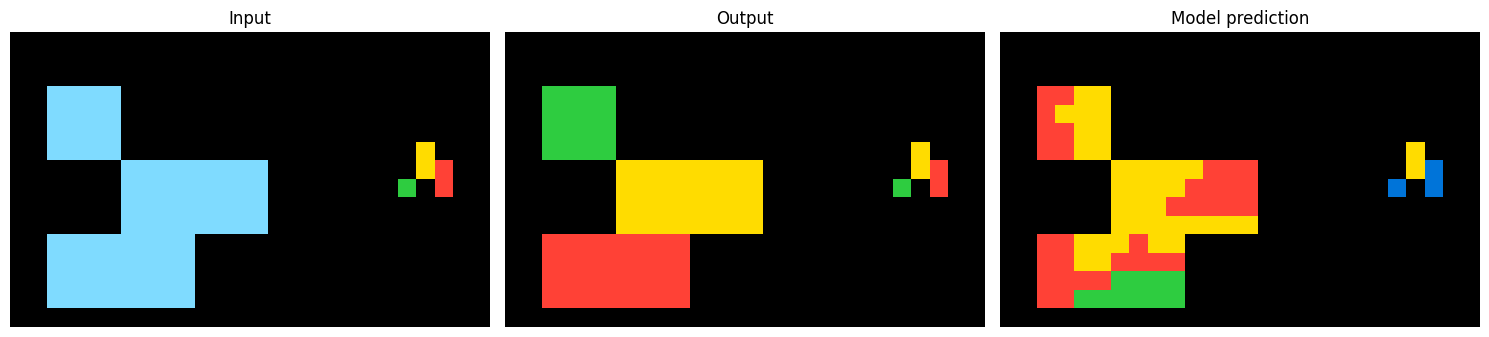

Accuracy: 0.8846153846153846


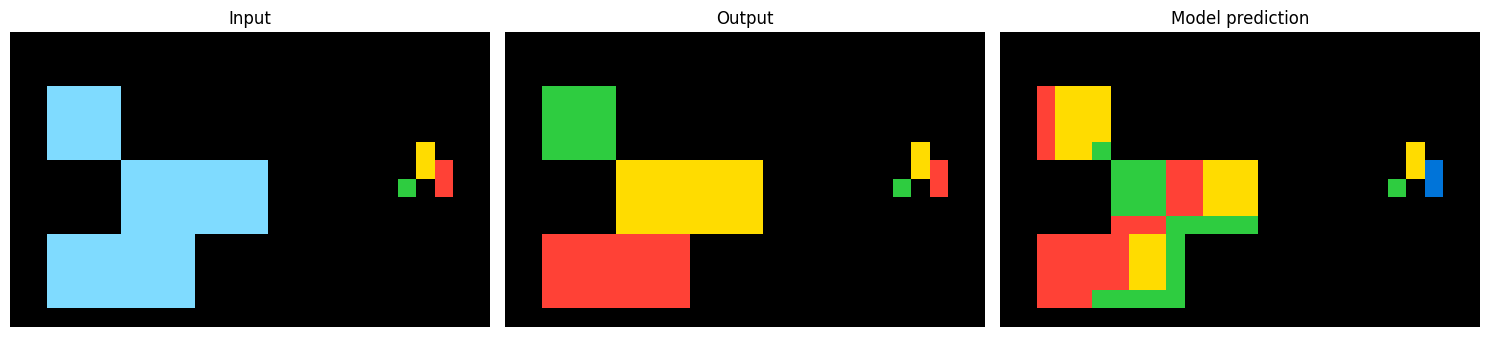

Accuracy: 0.8701923076923077


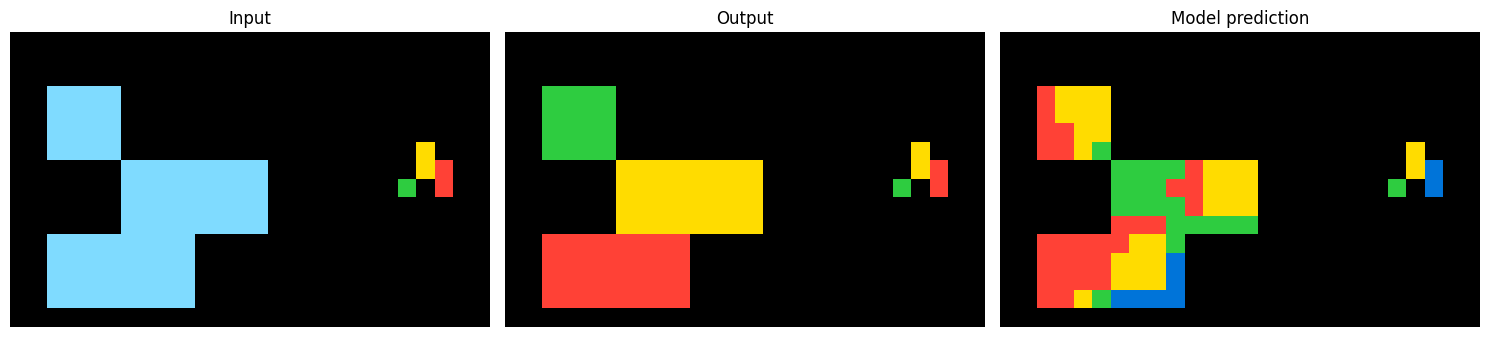

Accuracy: 0.8629807692307693
a57f2f04


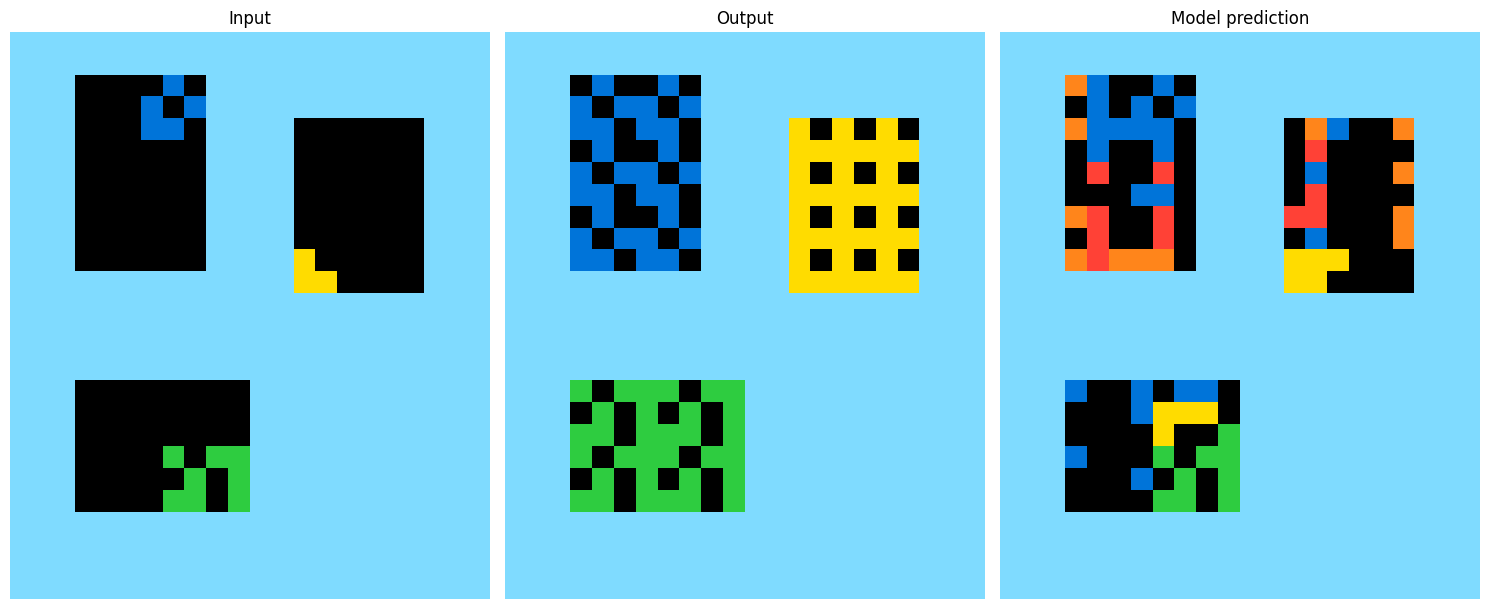

Accuracy: 0.8374125874125874


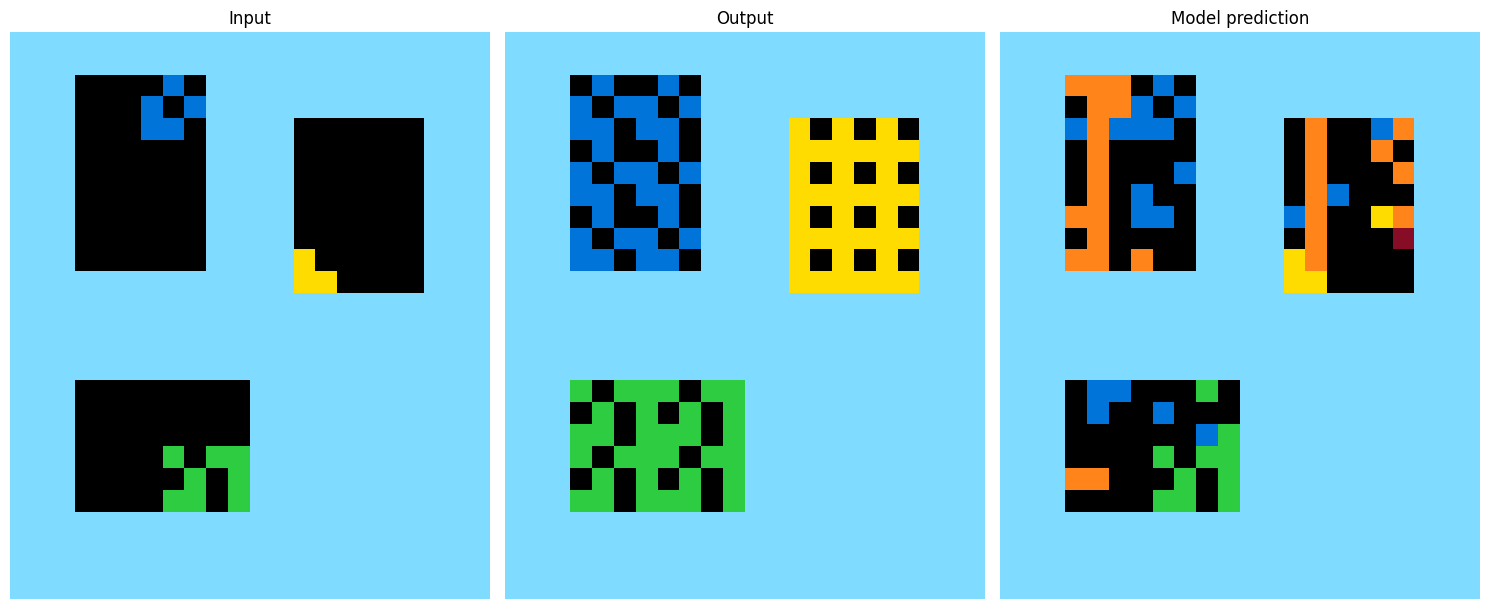

Accuracy: 0.8356643356643356


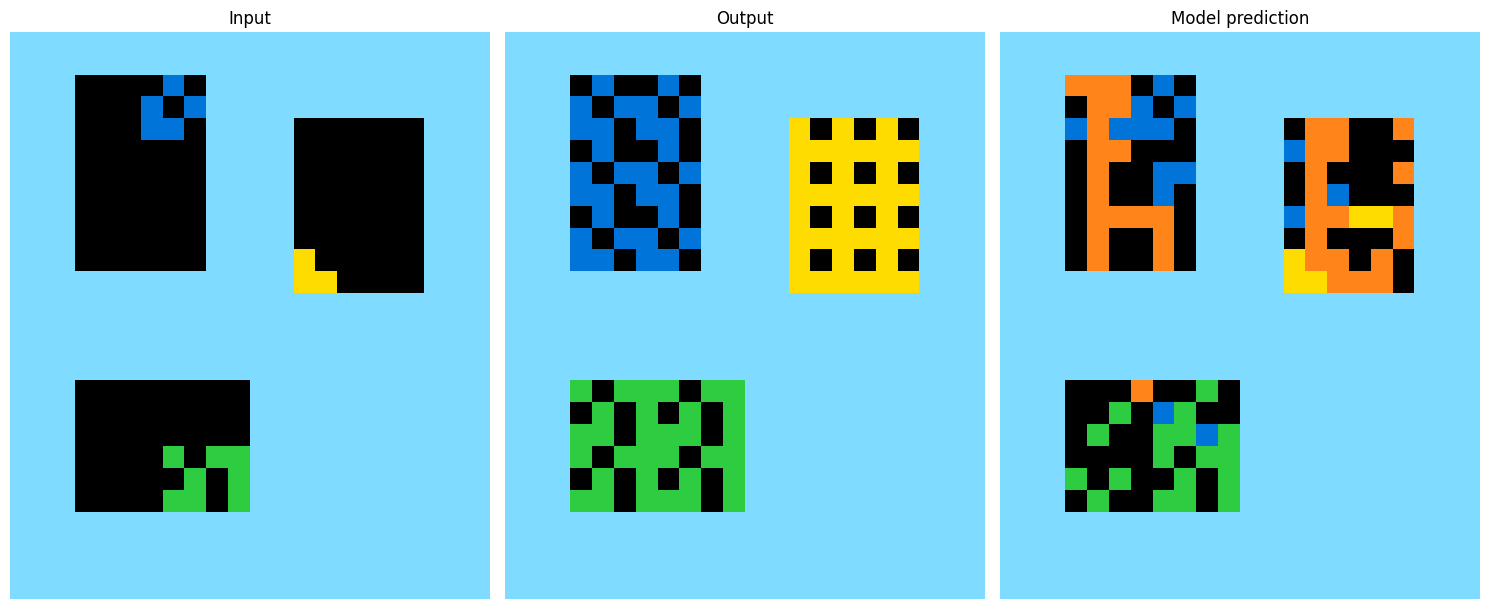

Accuracy: 0.833916083916084
52fd389e


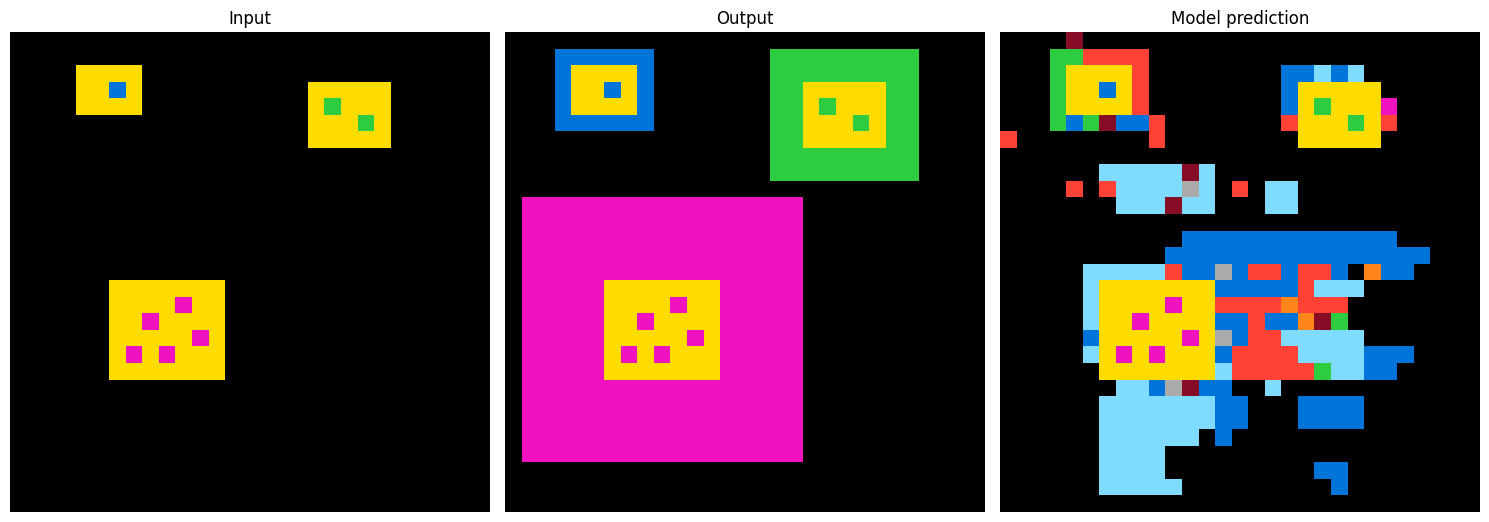

Accuracy: 0.5410225921521997


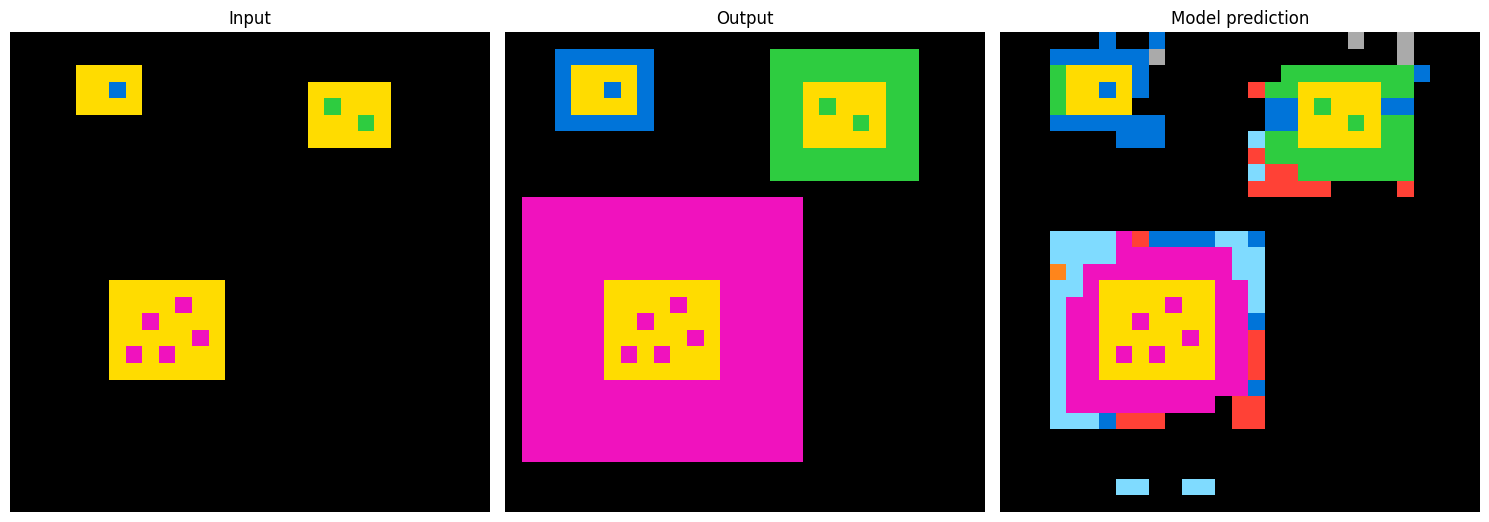

Accuracy: 0.7431629013079667


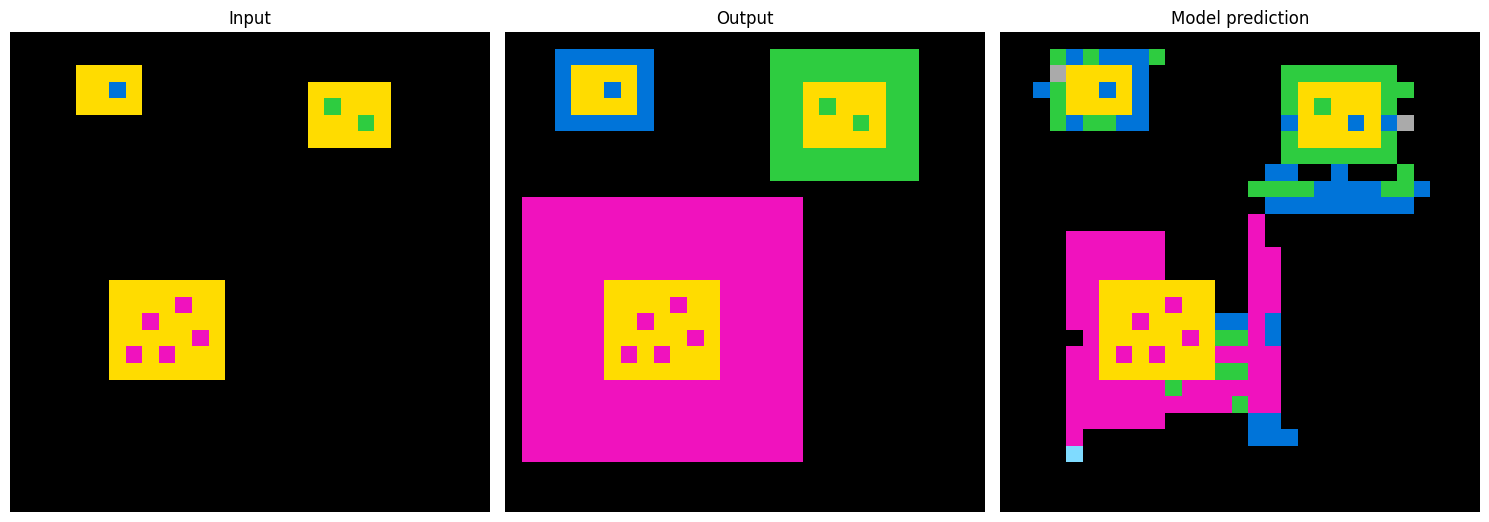

Accuracy: 0.7491082045184304
7d1f7ee8


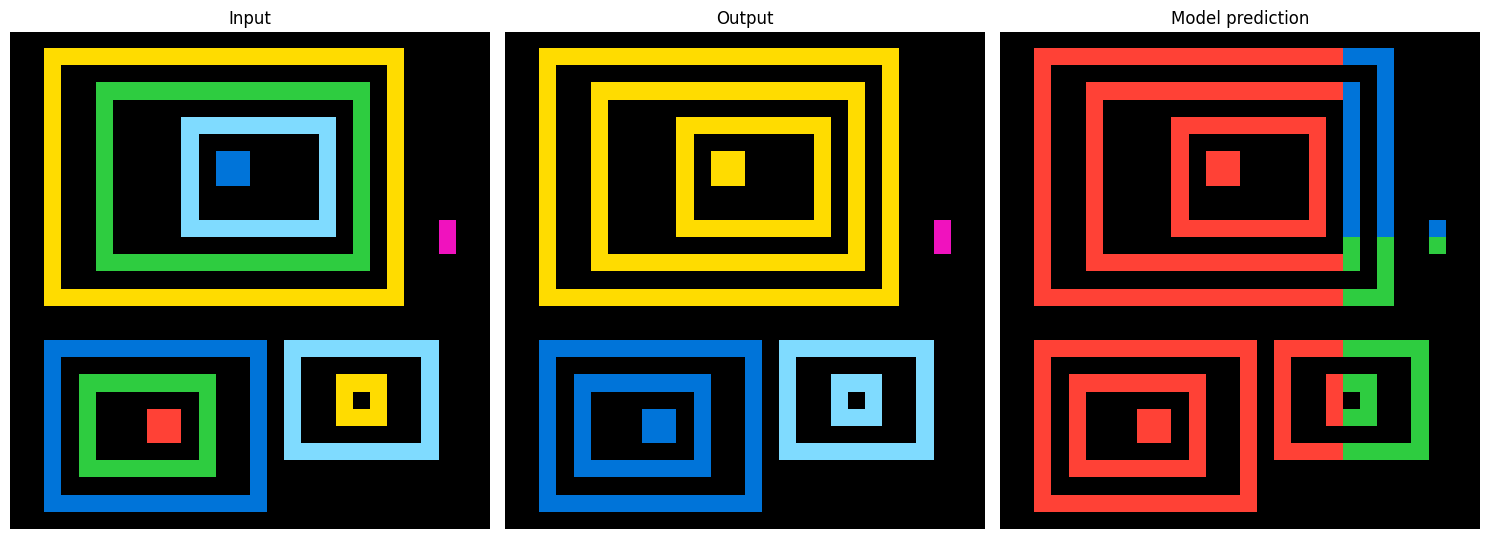

Accuracy: 0.6822660098522167


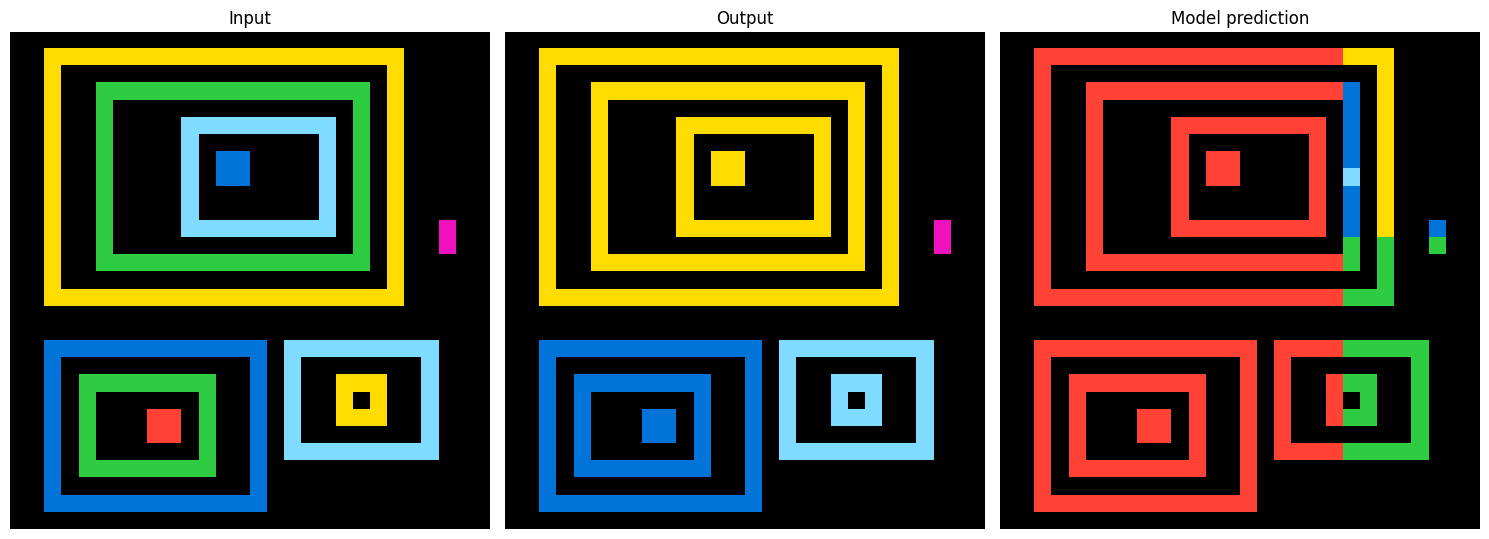

Accuracy: 0.6982758620689655


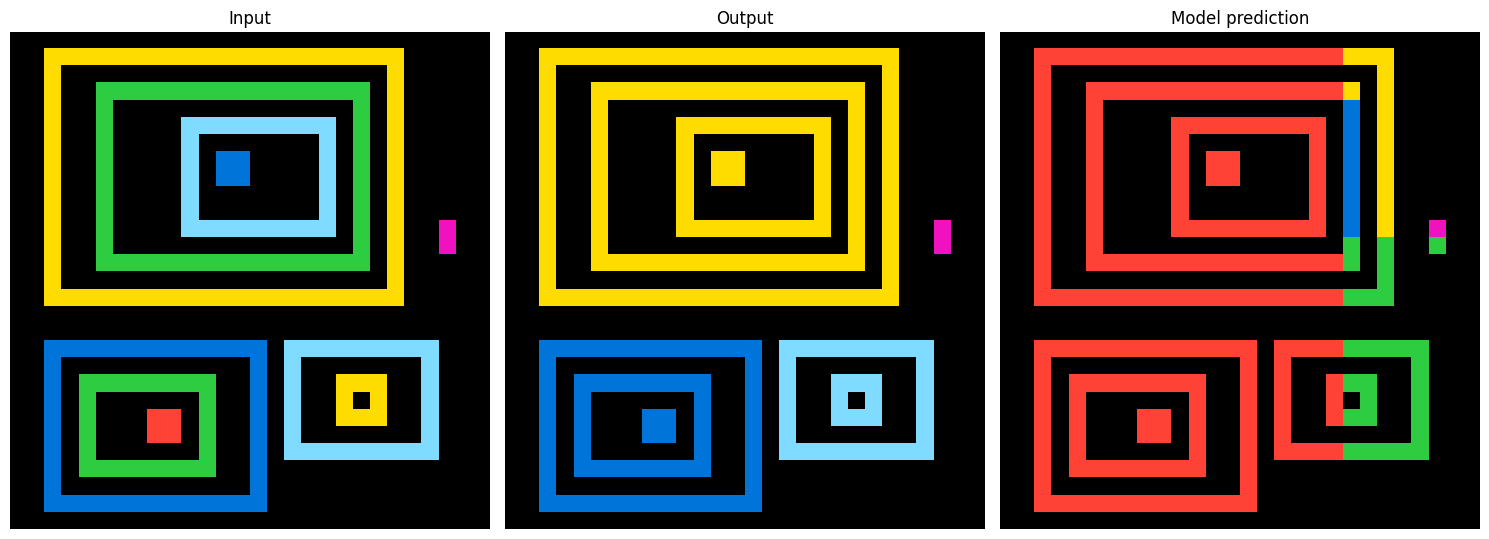

Accuracy: 0.7007389162561576
95a58926


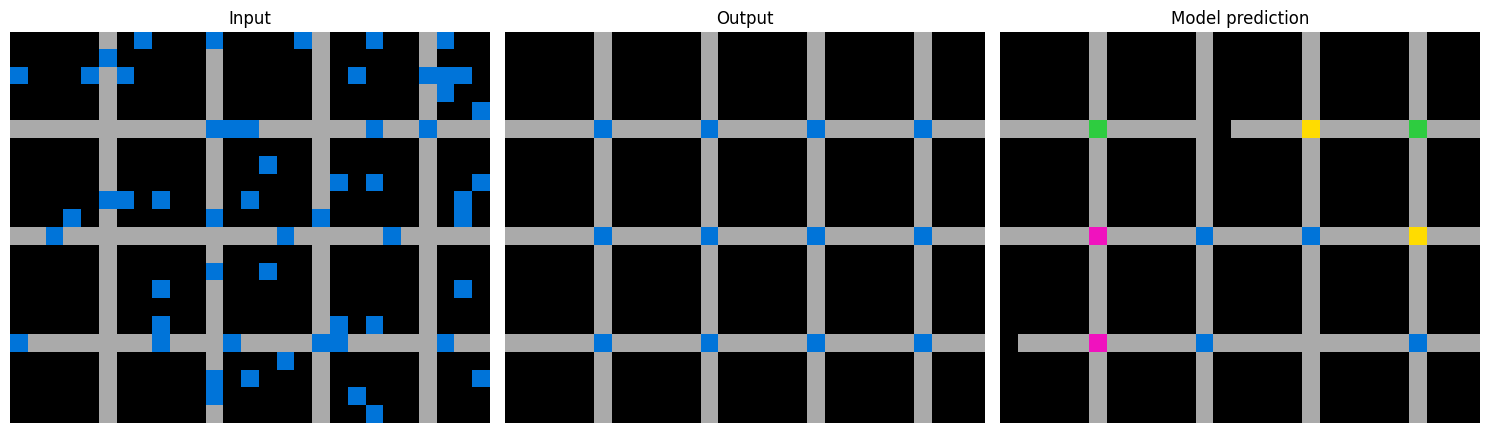

Accuracy: 0.9831649831649831


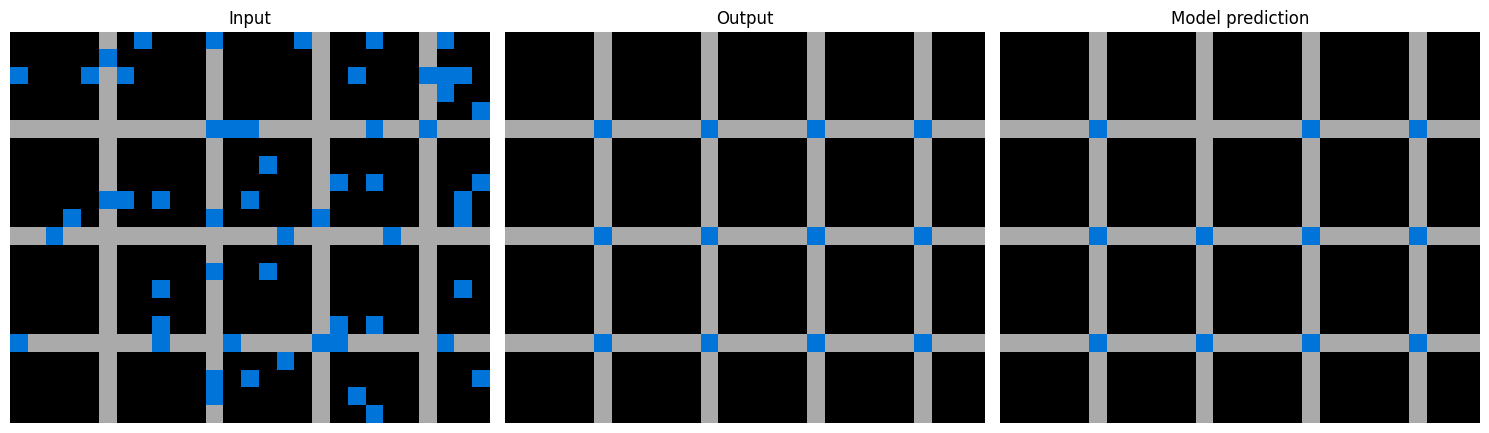

Accuracy: 0.9983164983164983


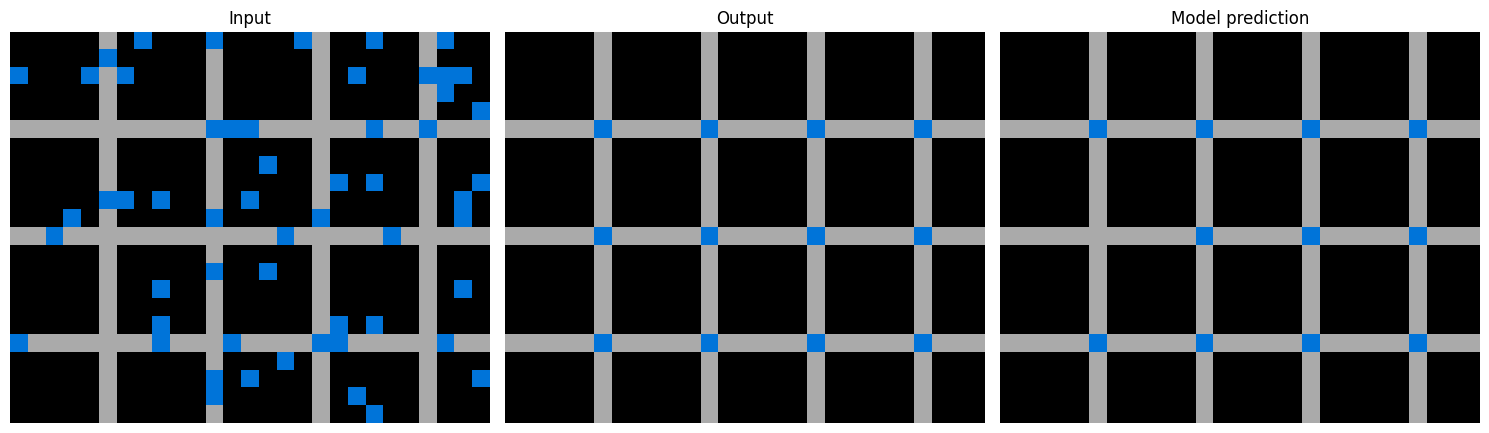

Accuracy: 0.9983164983164983
8dae5dfc


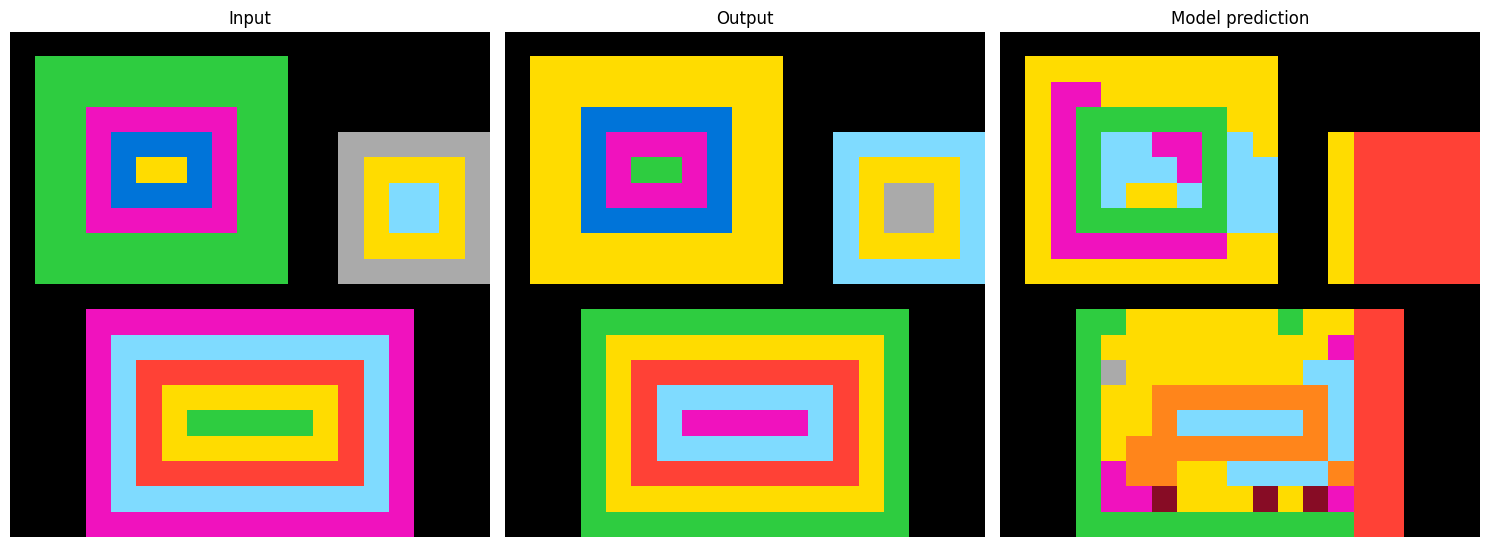

Accuracy: 0.5684210526315789


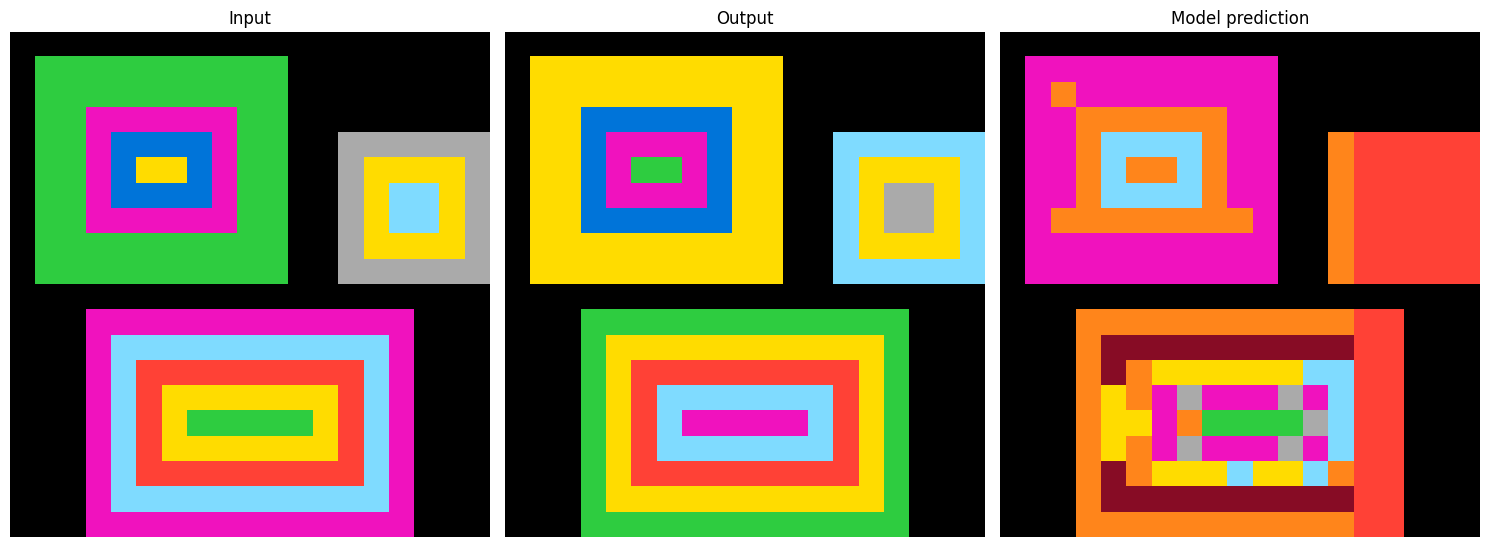

Accuracy: 0.3684210526315789


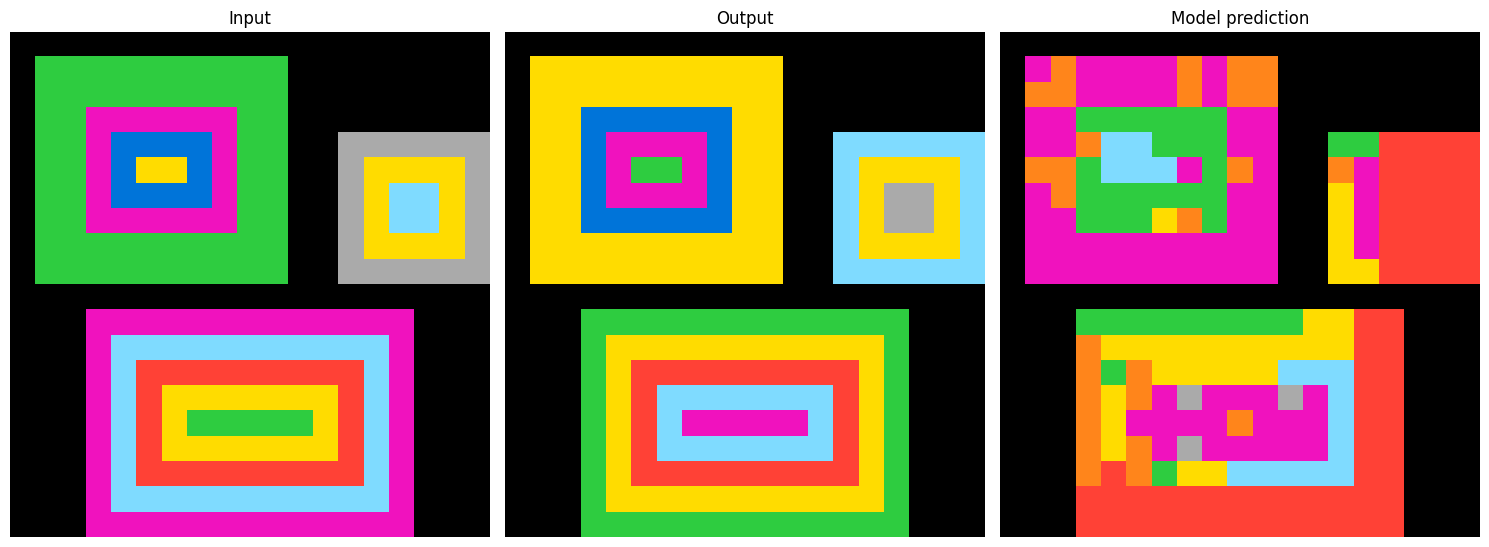

Accuracy: 0.43157894736842106
2753e76c
c6e1b8da


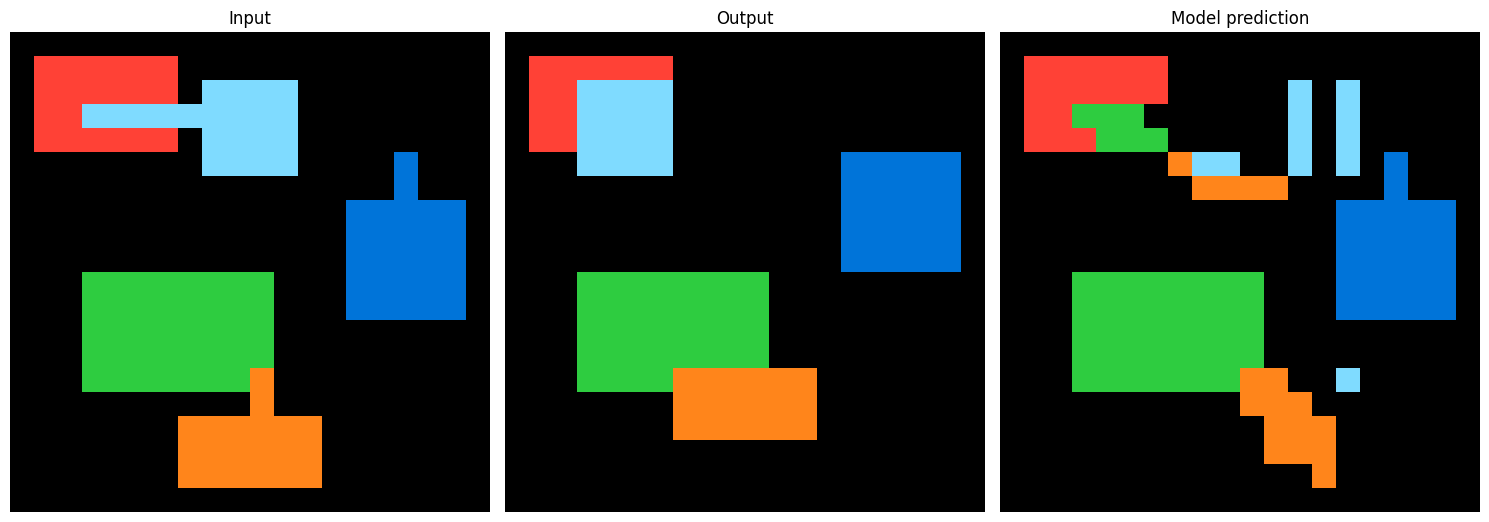

Accuracy: 0.8375


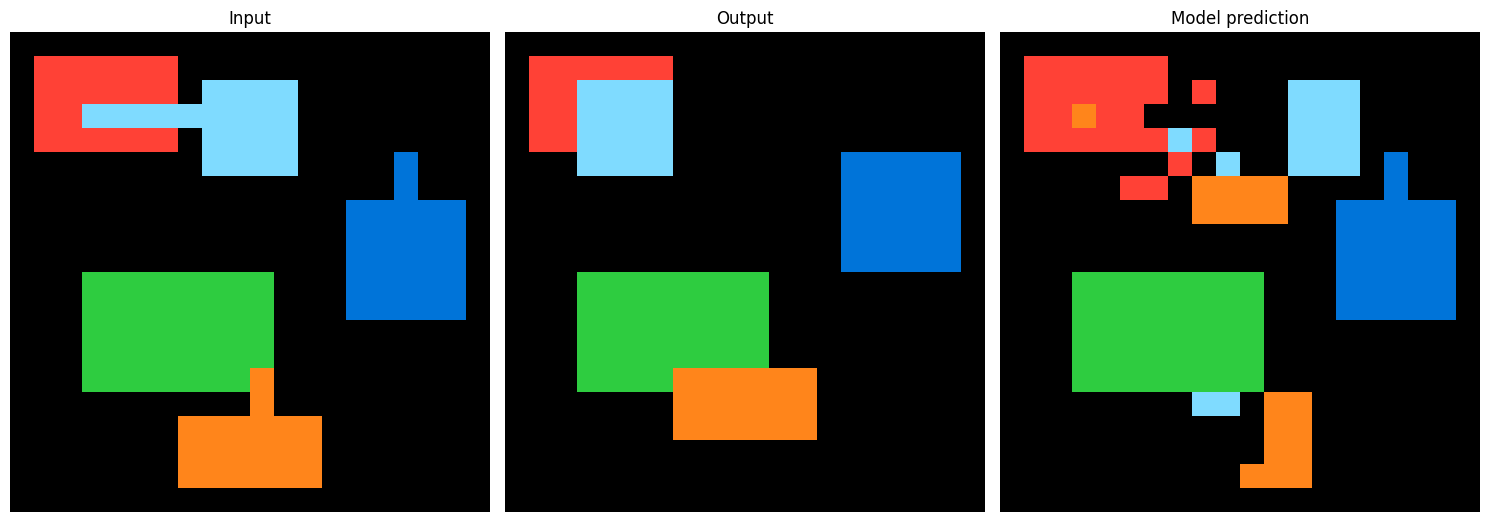

Accuracy: 0.8025


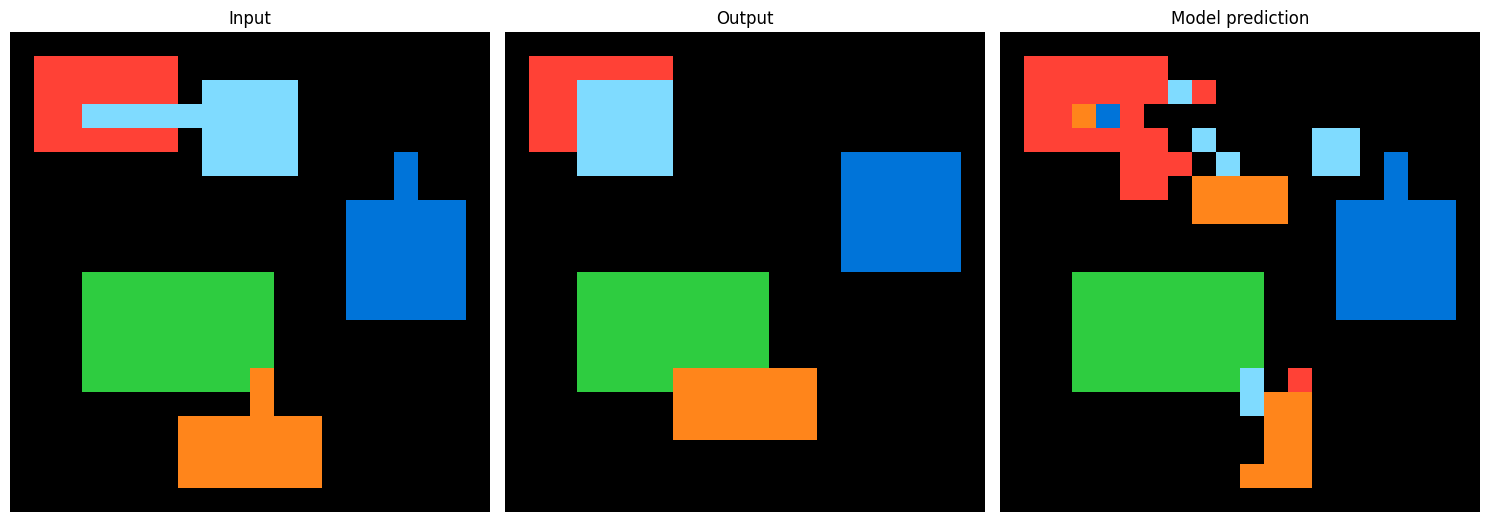

Accuracy: 0.8225
516b51b7


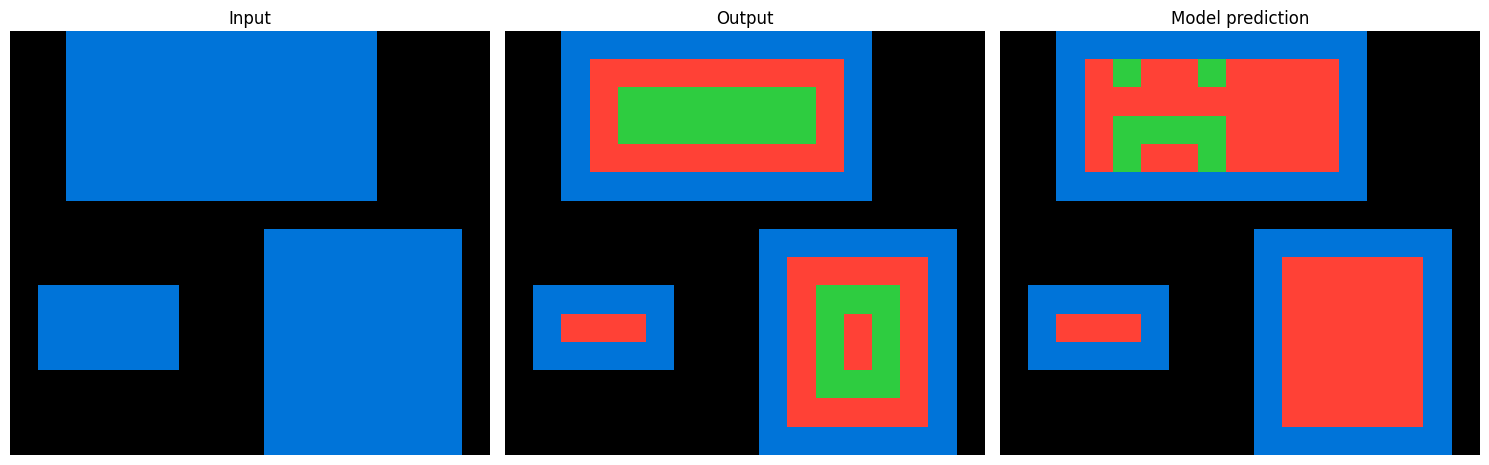

Accuracy: 0.9058823529411765


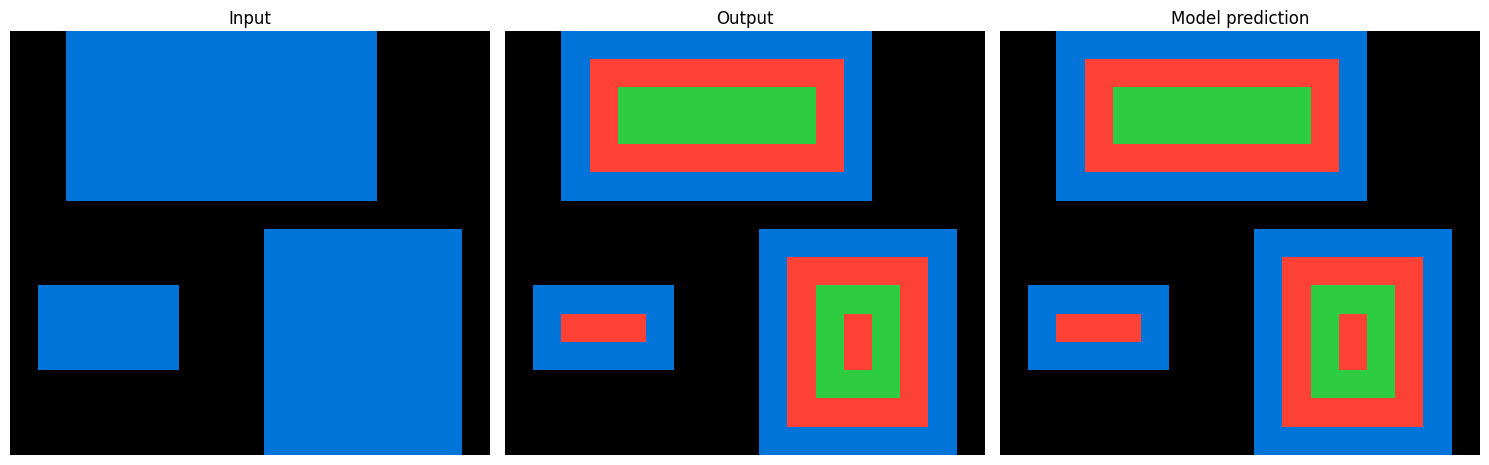

Accuracy: 1.0


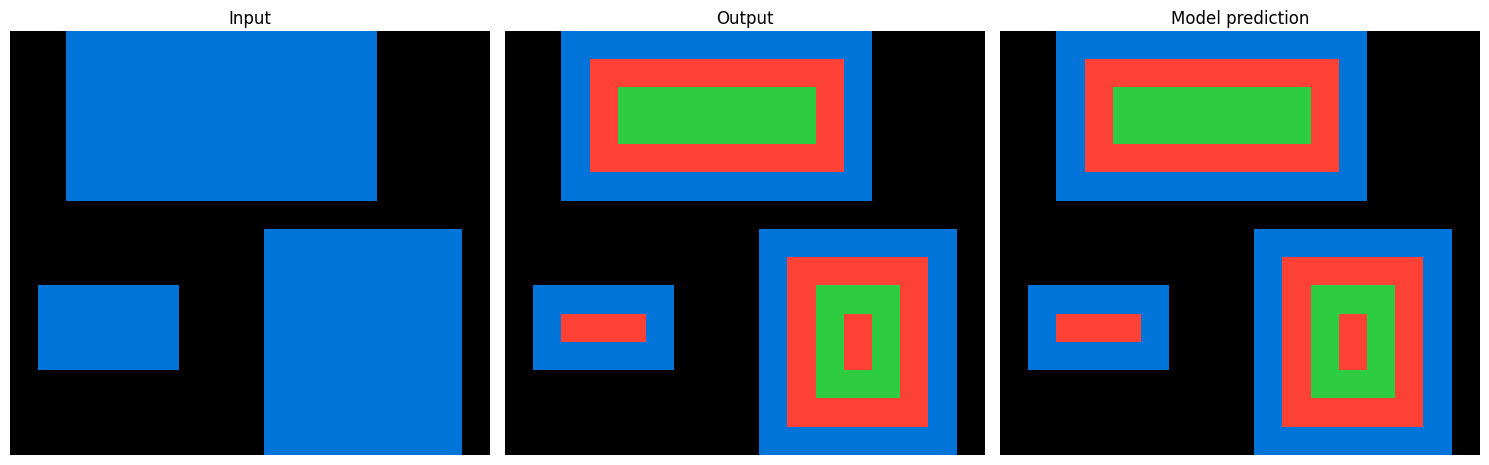

Accuracy: 1.0
351d6448
c48954c1
dc2aa30b


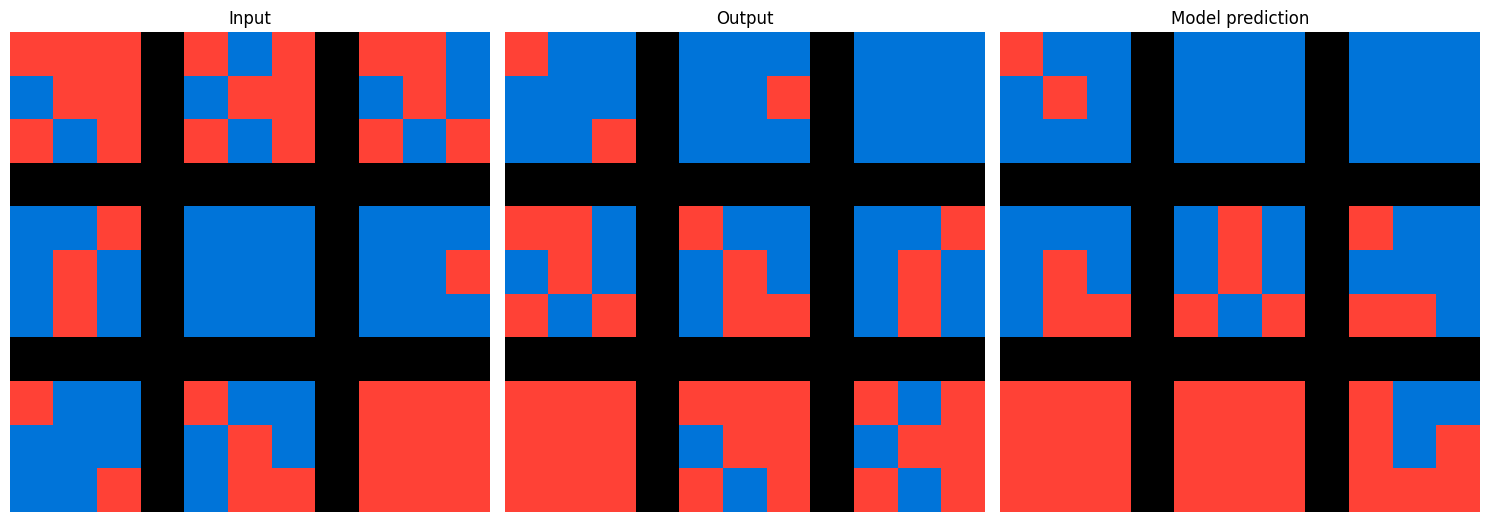

Accuracy: 0.8264462809917356


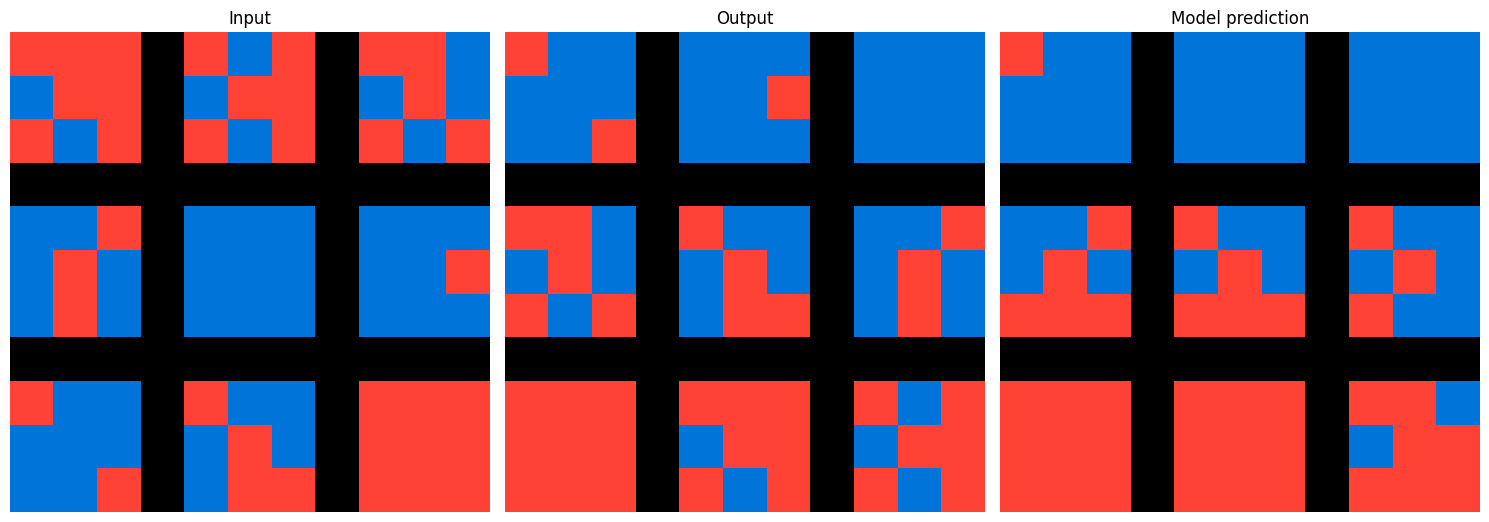

Accuracy: 0.8677685950413223


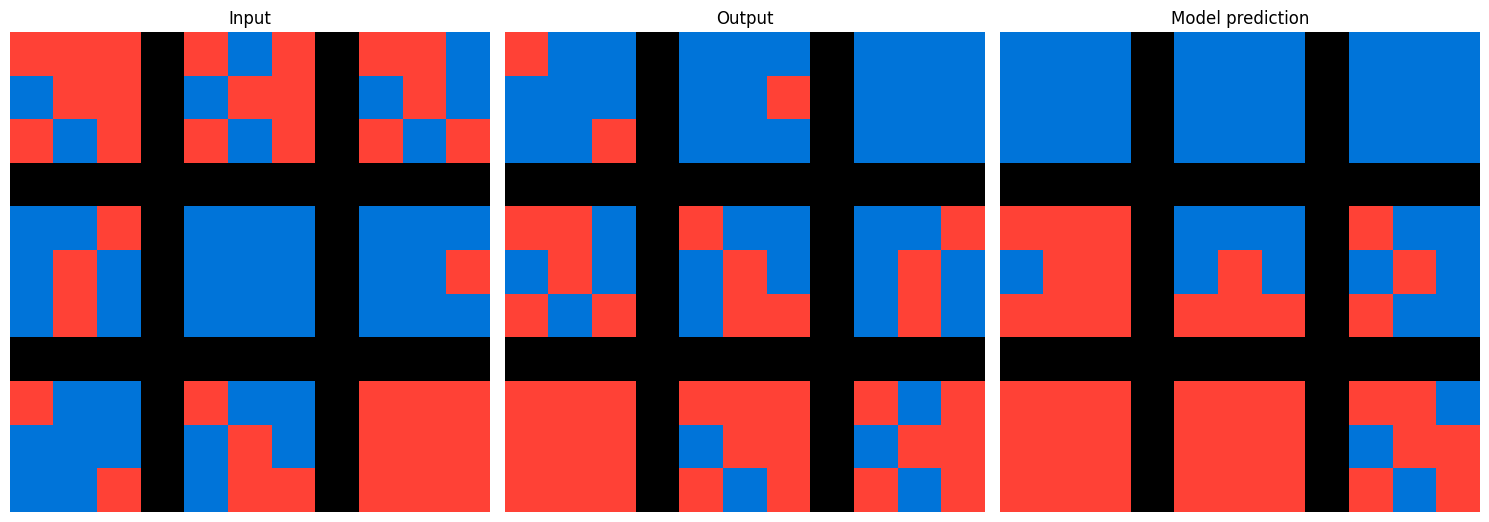

Accuracy: 0.8677685950413223
712bf12e


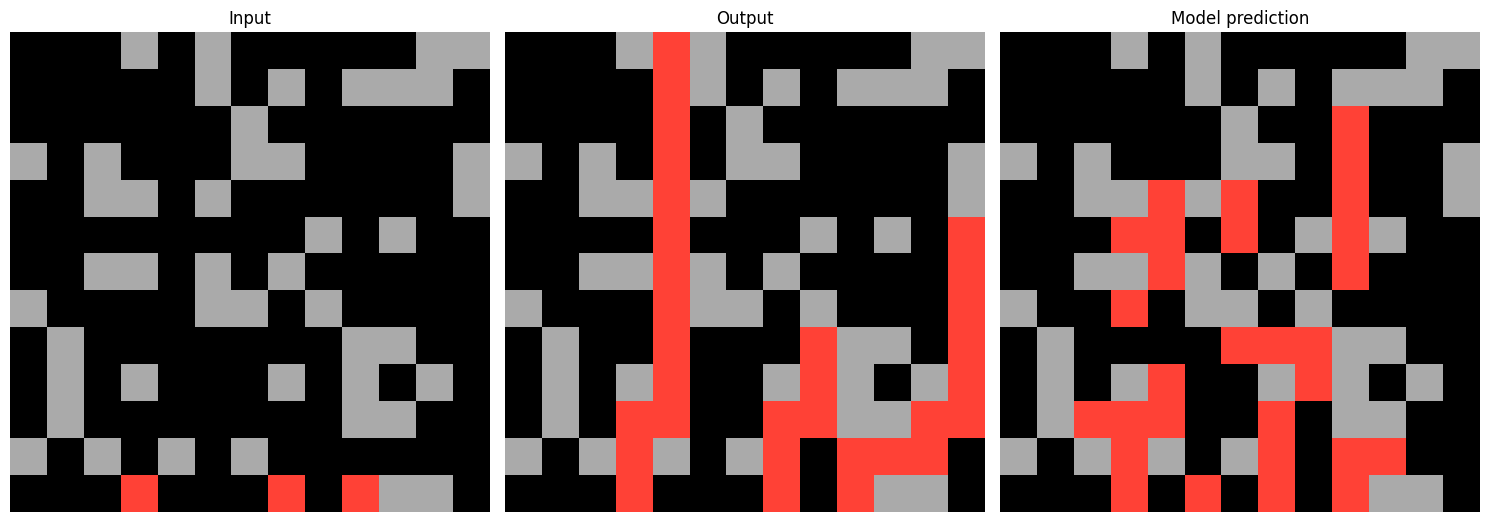

Accuracy: 0.834319526627219


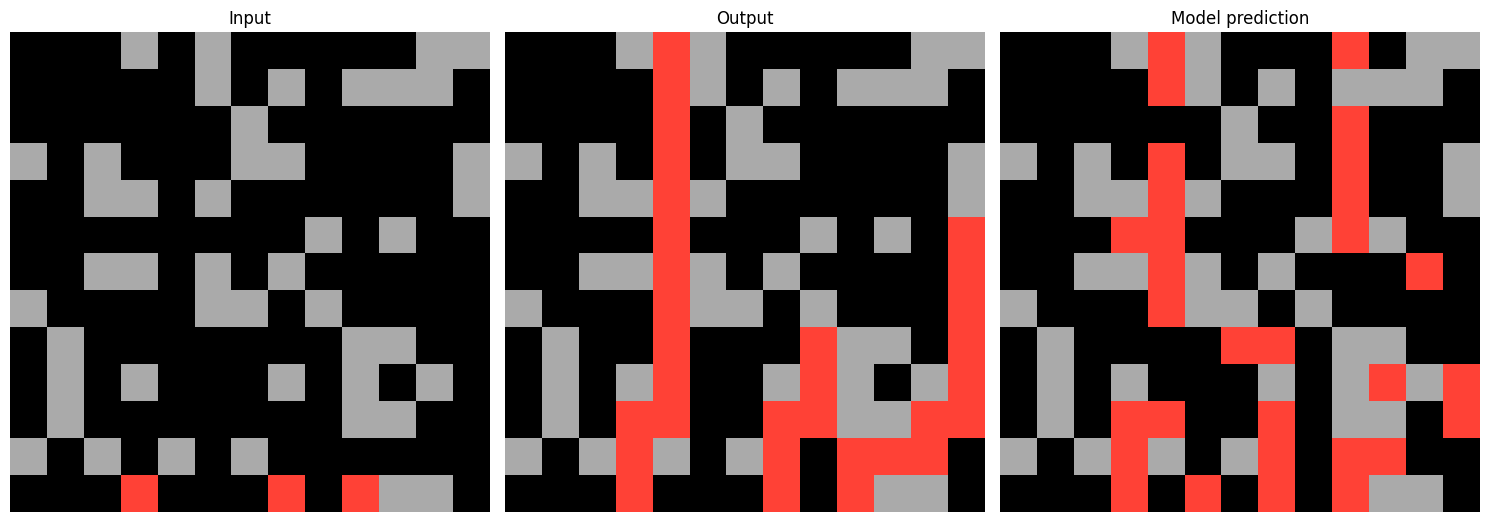

Accuracy: 0.863905325443787


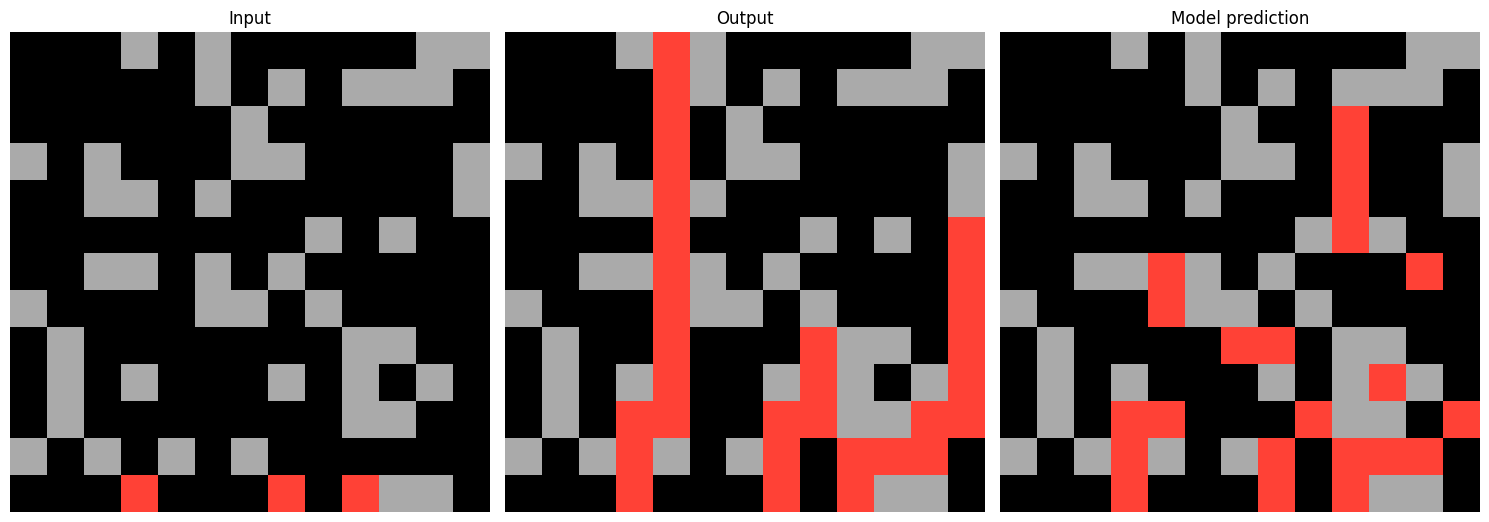

Accuracy: 0.8520710059171598
cb227835


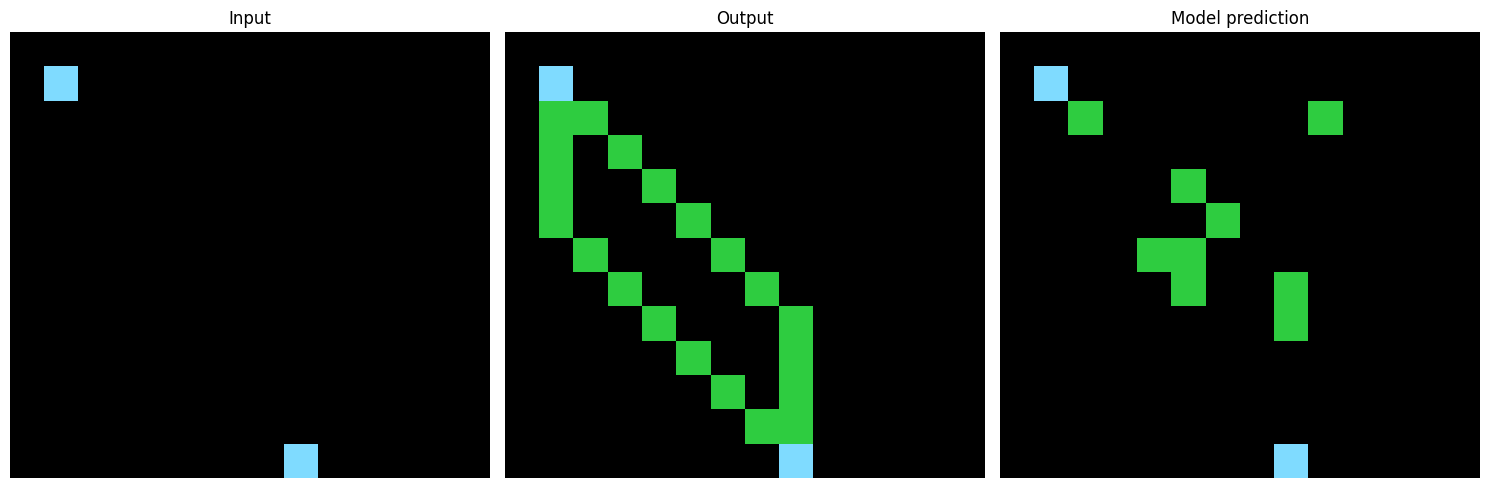

Accuracy: 0.8626373626373627


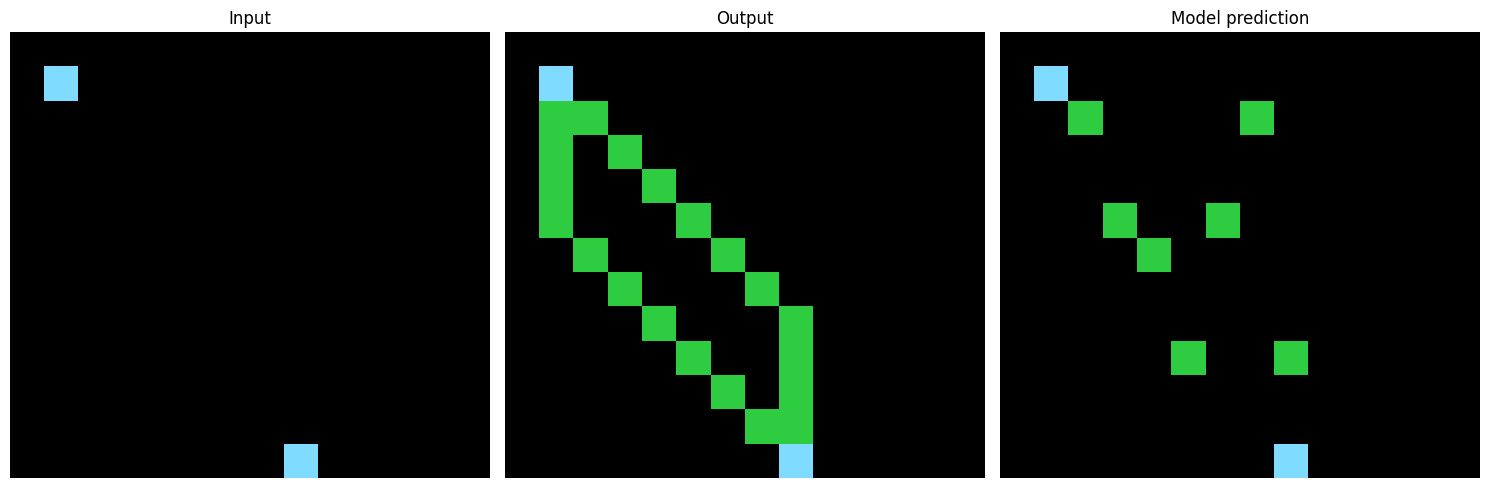

Accuracy: 0.8846153846153846


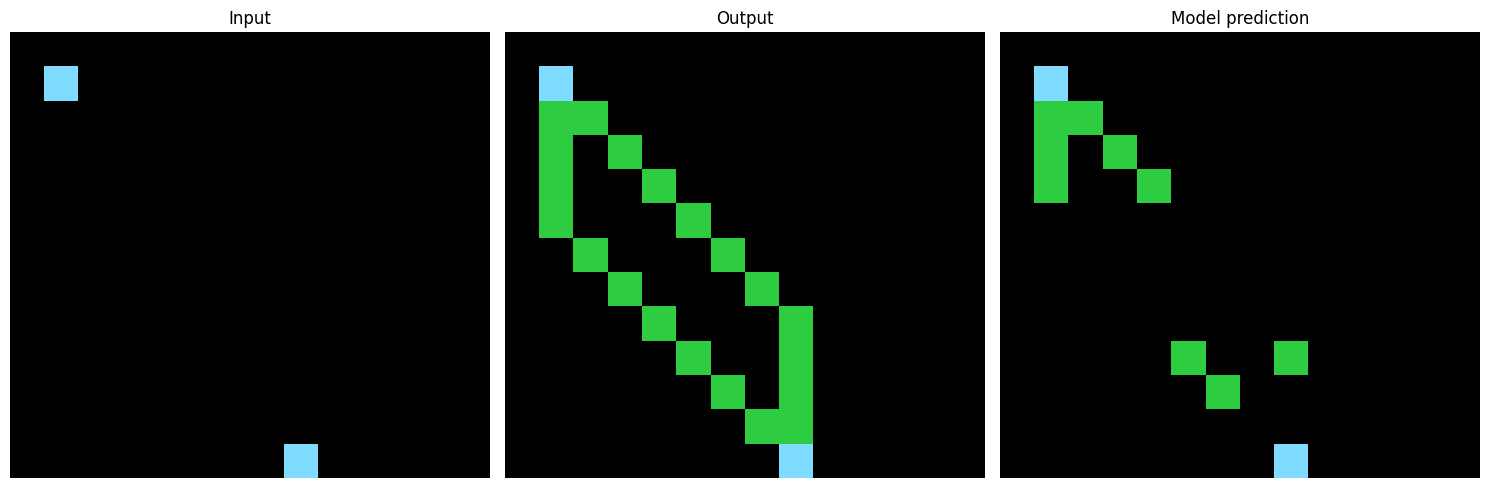

Accuracy: 0.9395604395604396
cd3c21df
20981f0e


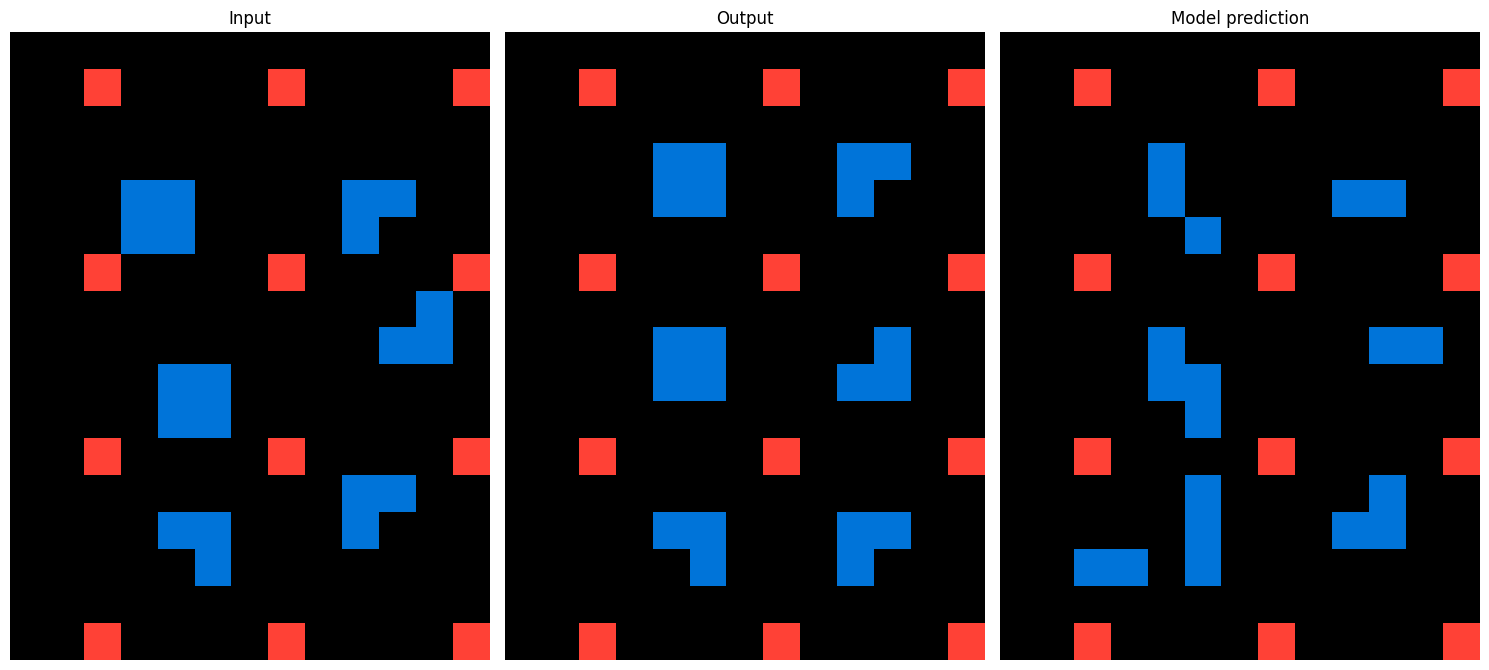

Accuracy: 0.9230769230769231


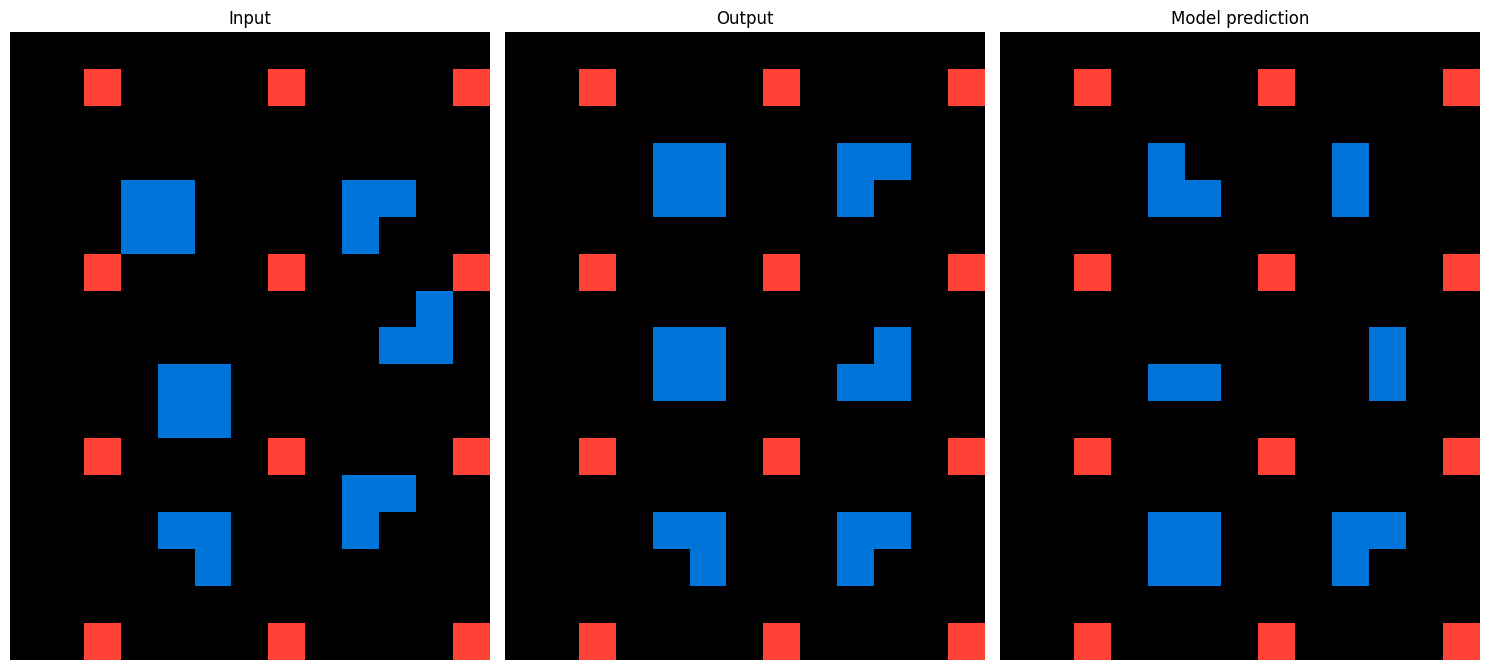

Accuracy: 0.9728506787330317


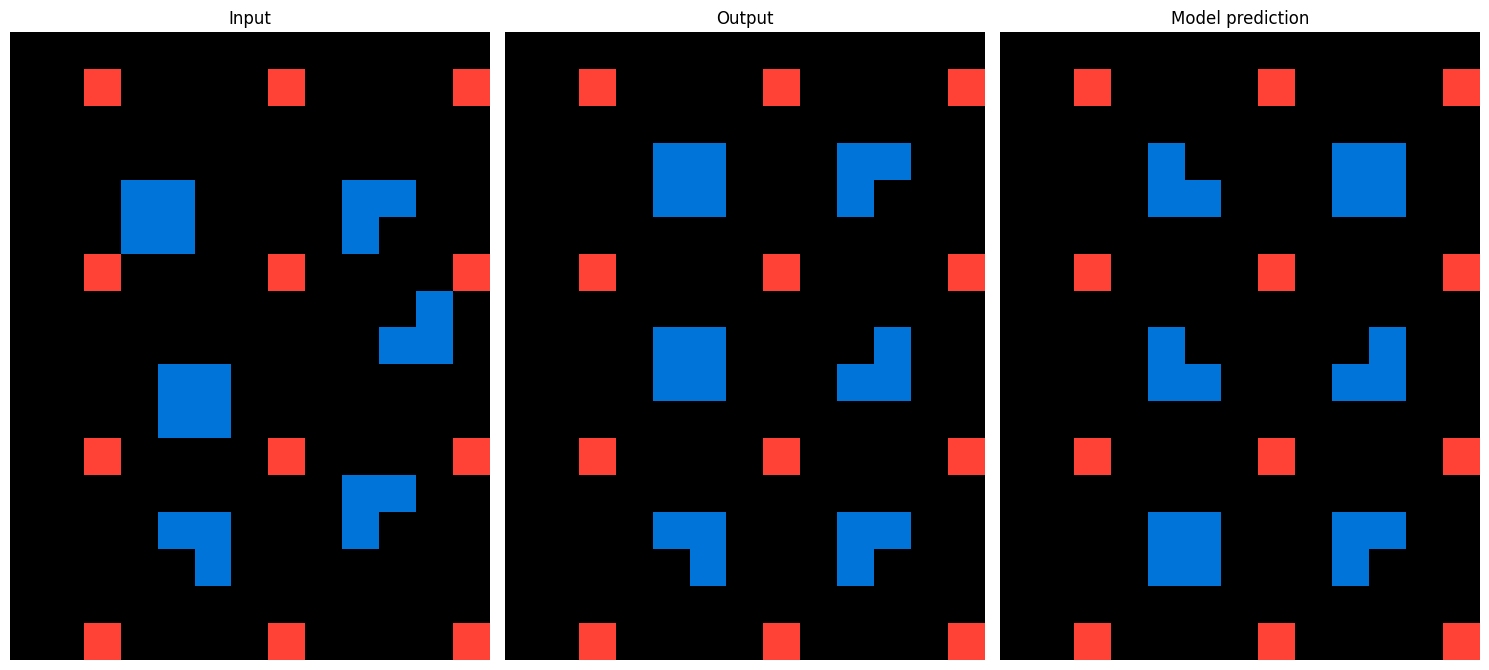

Accuracy: 0.9819004524886877
03560426


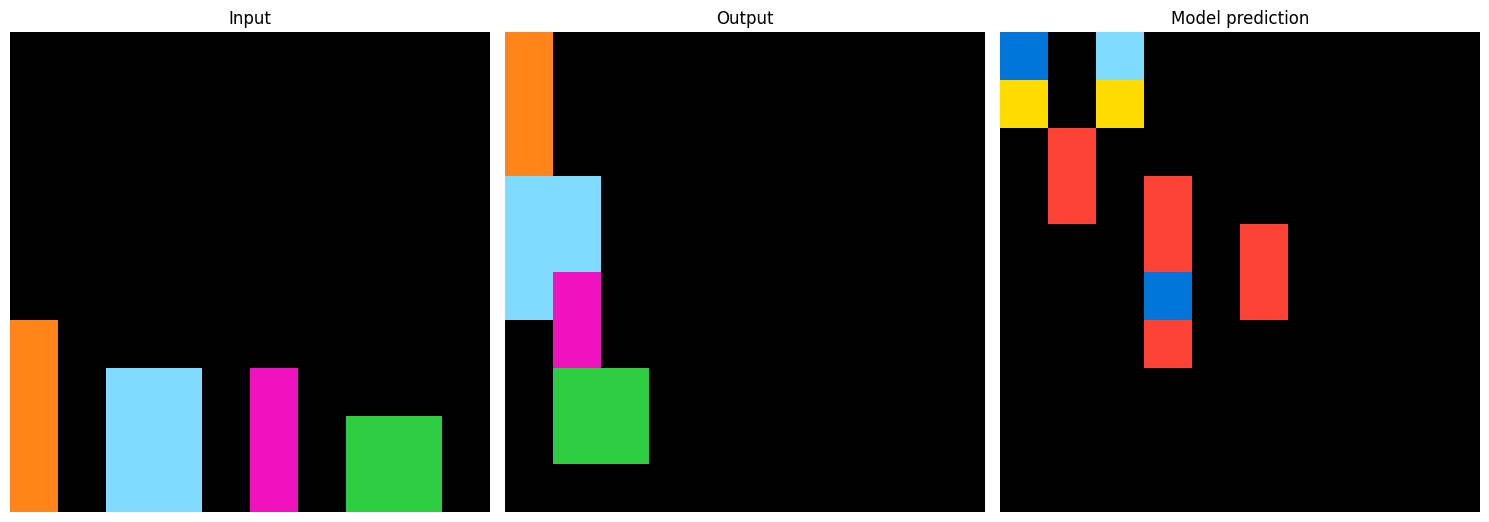

Accuracy: 0.77


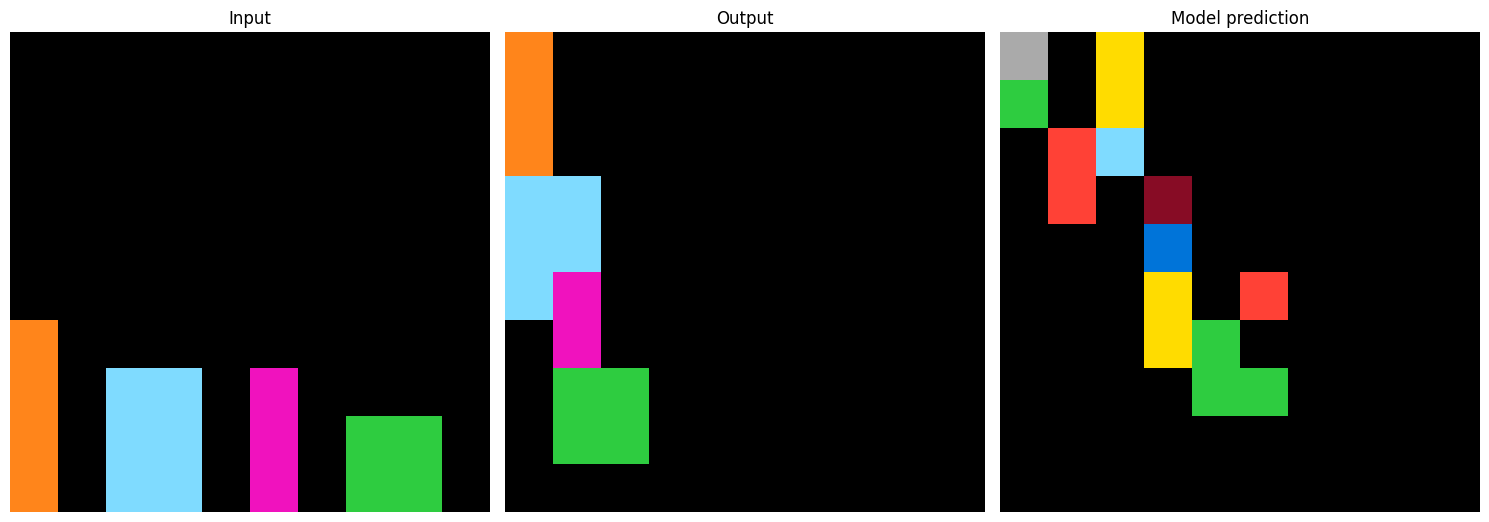

Accuracy: 0.74


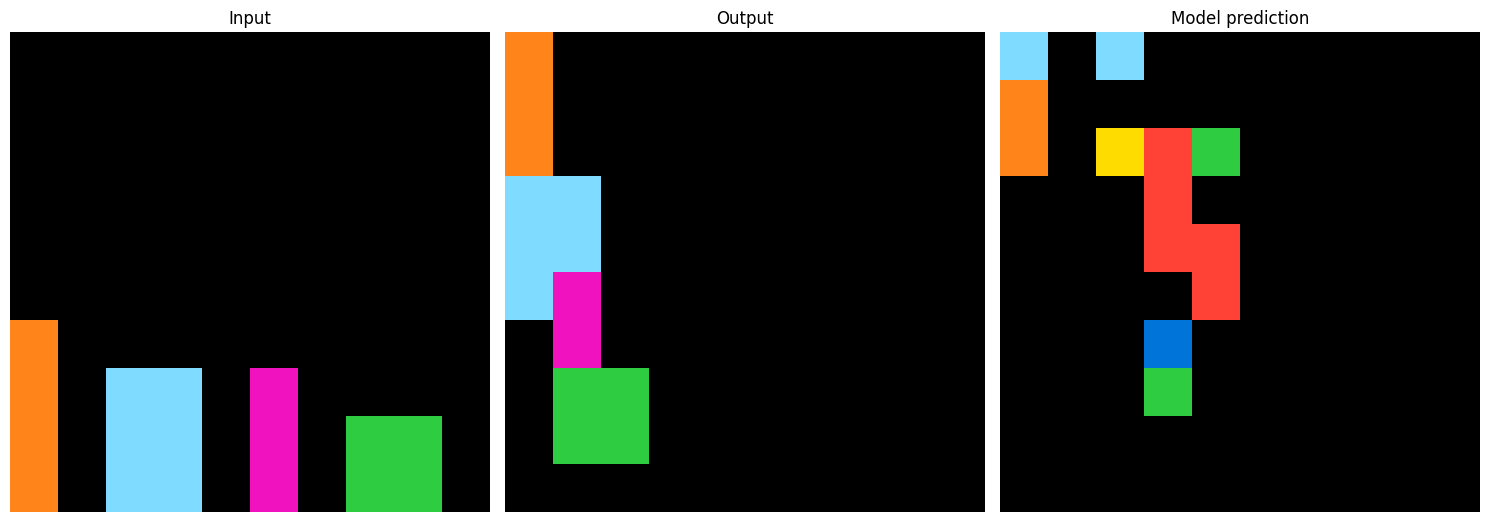

Accuracy: 0.78
ca8de6ea
e2092e0c


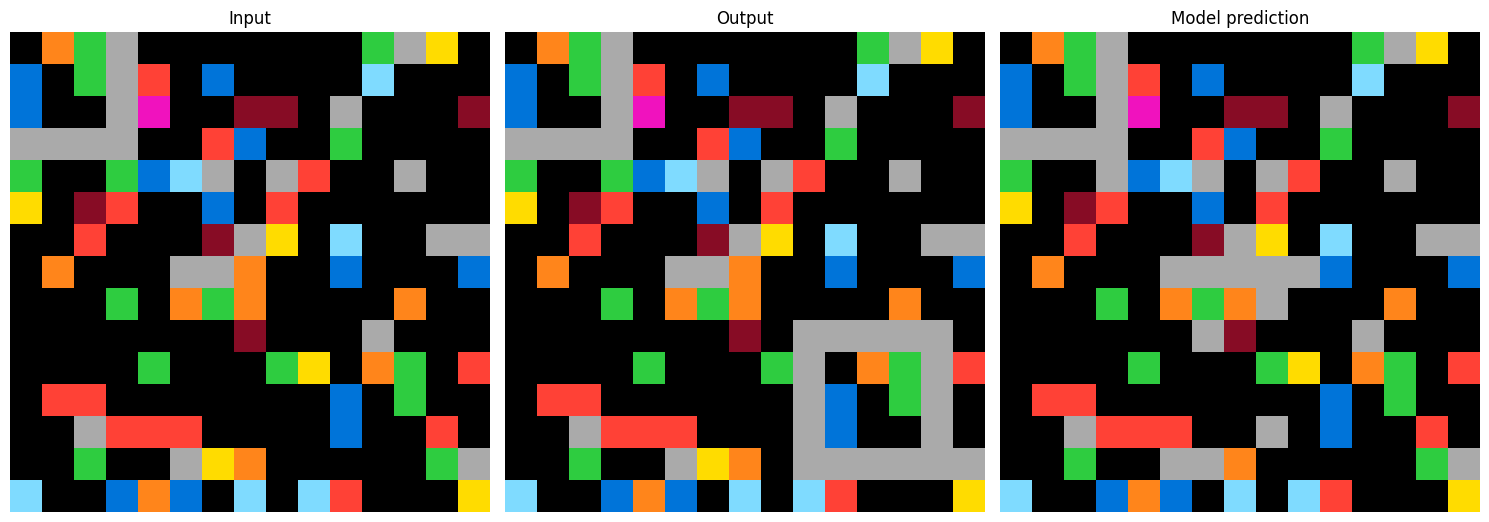

Accuracy: 0.8977777777777778


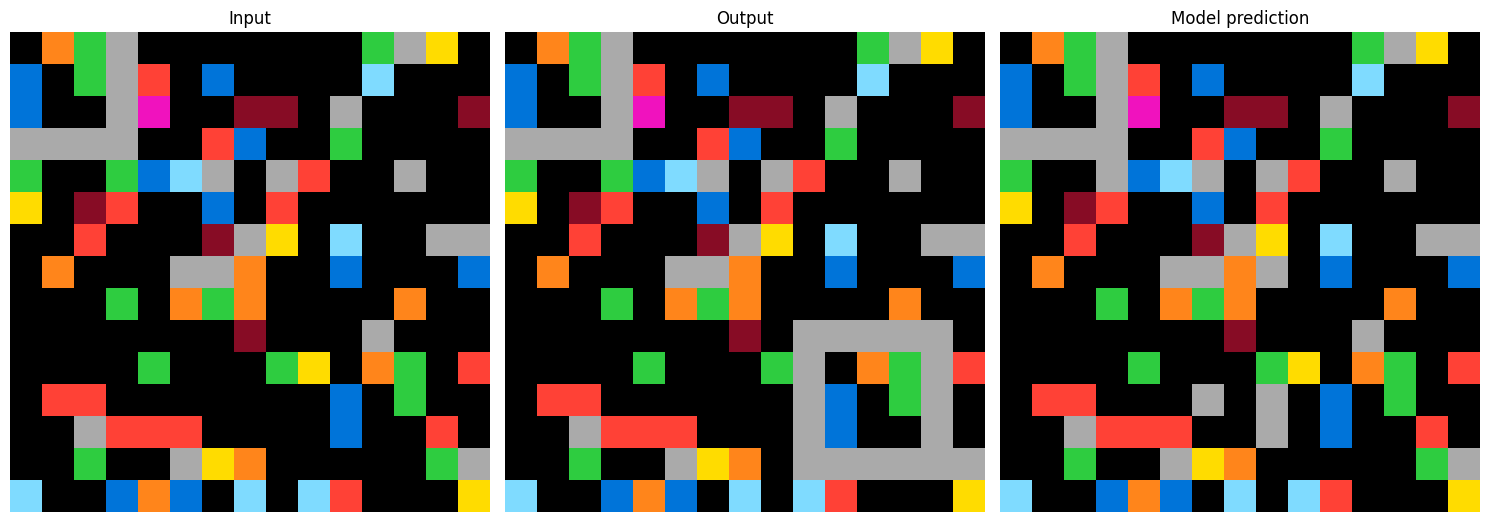

Accuracy: 0.9111111111111111


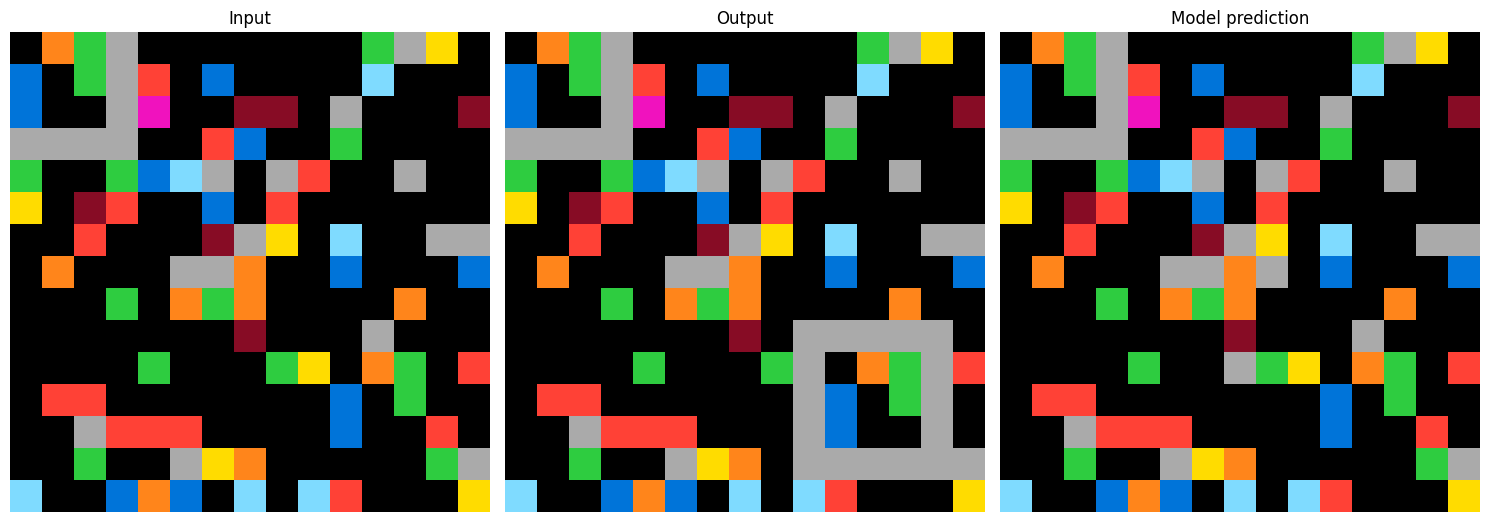

Accuracy: 0.9244444444444444
195ba7dc
fc754716


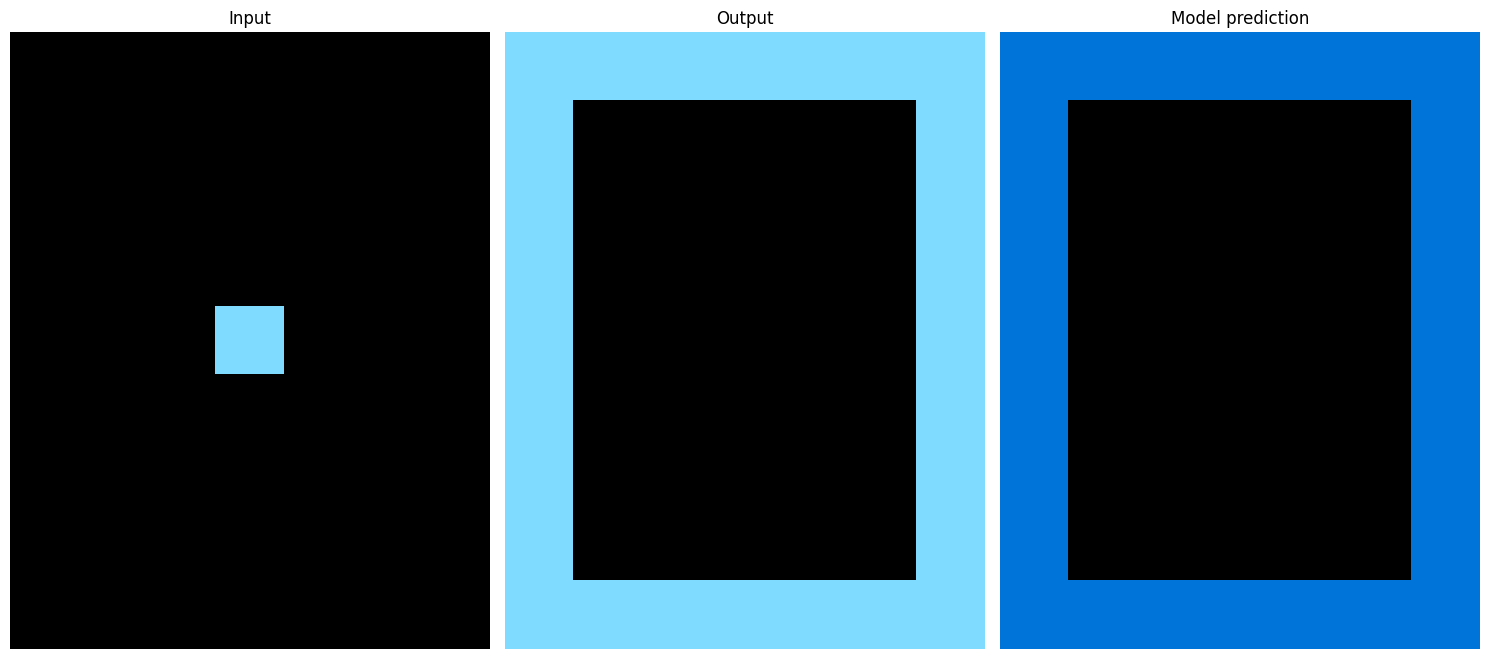

Accuracy: 0.5555555555555556


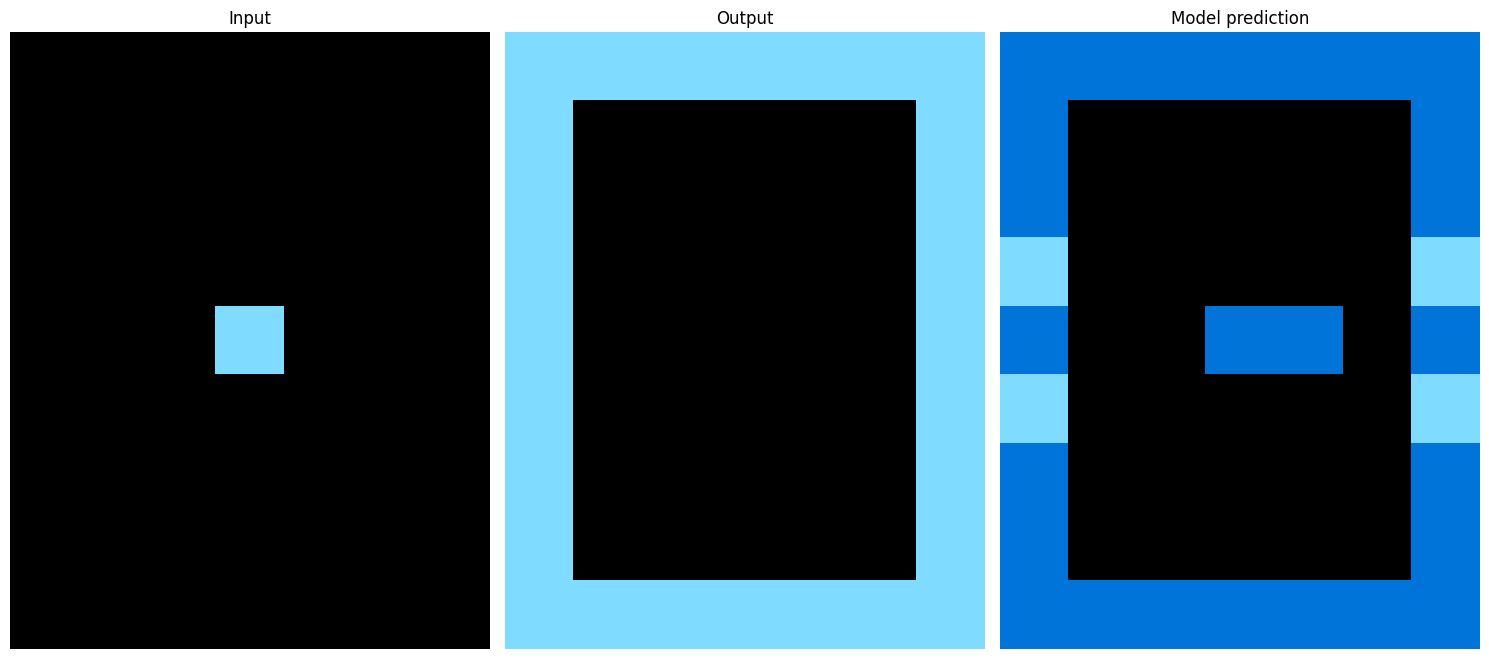

Accuracy: 0.5873015873015873


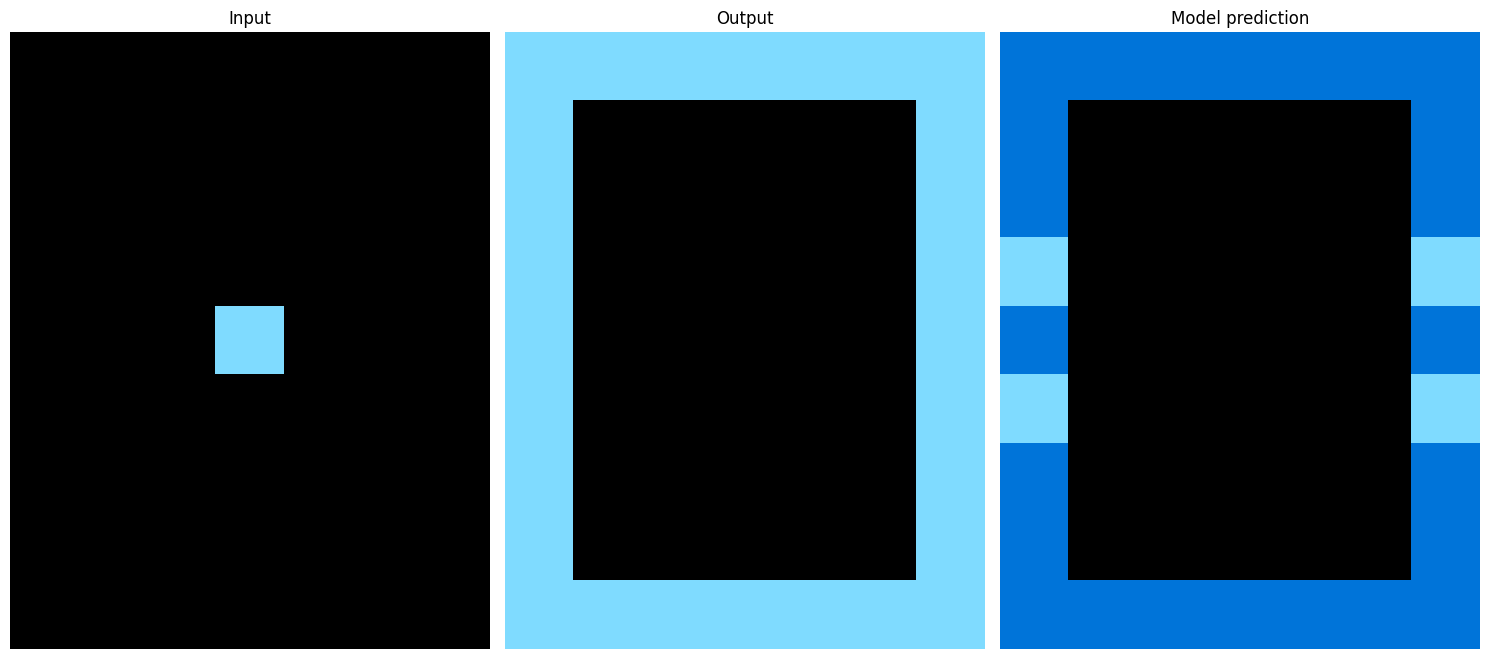

Accuracy: 0.6190476190476191
09c534e7


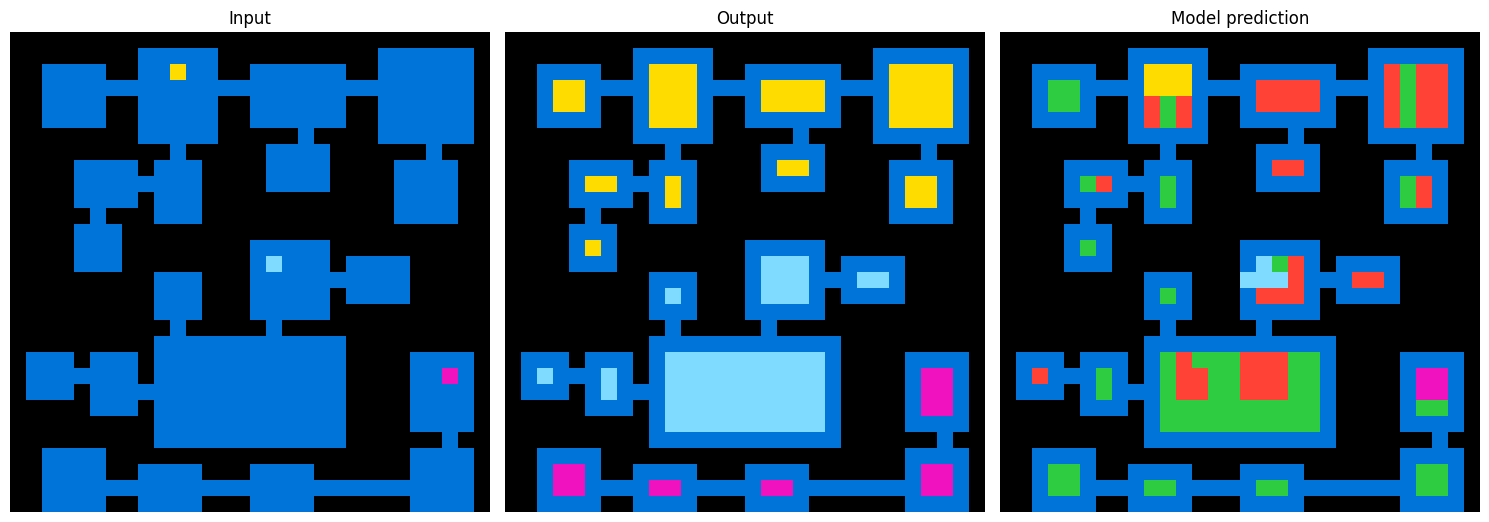

Accuracy: 0.8644444444444445


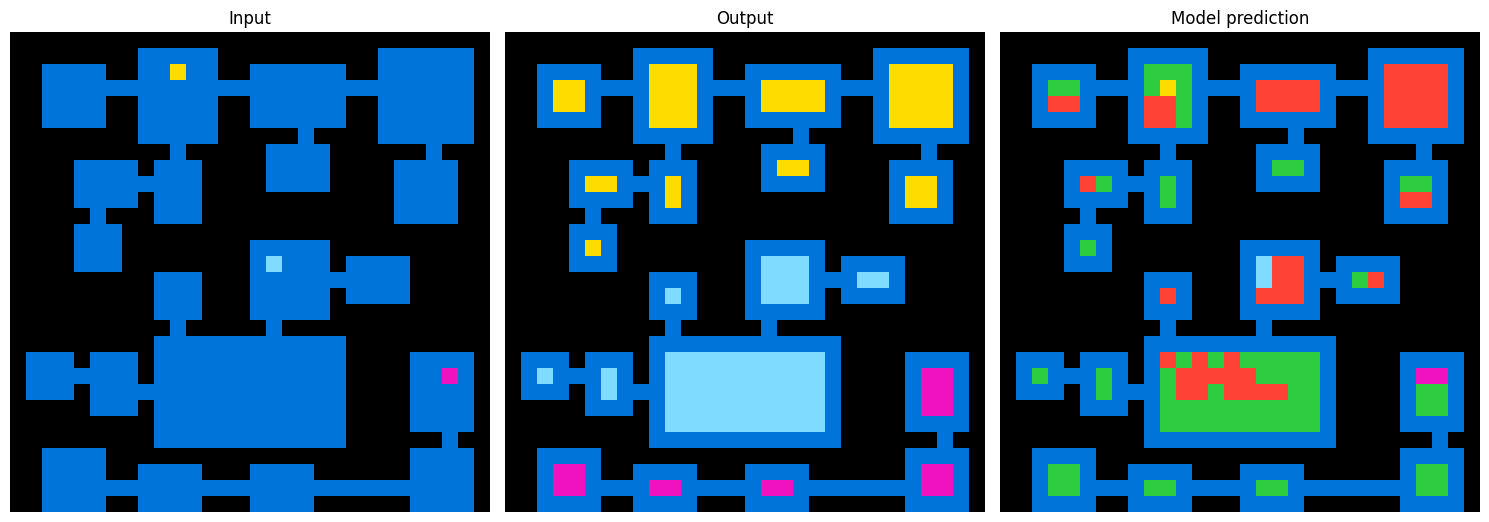

Accuracy: 0.8566666666666667


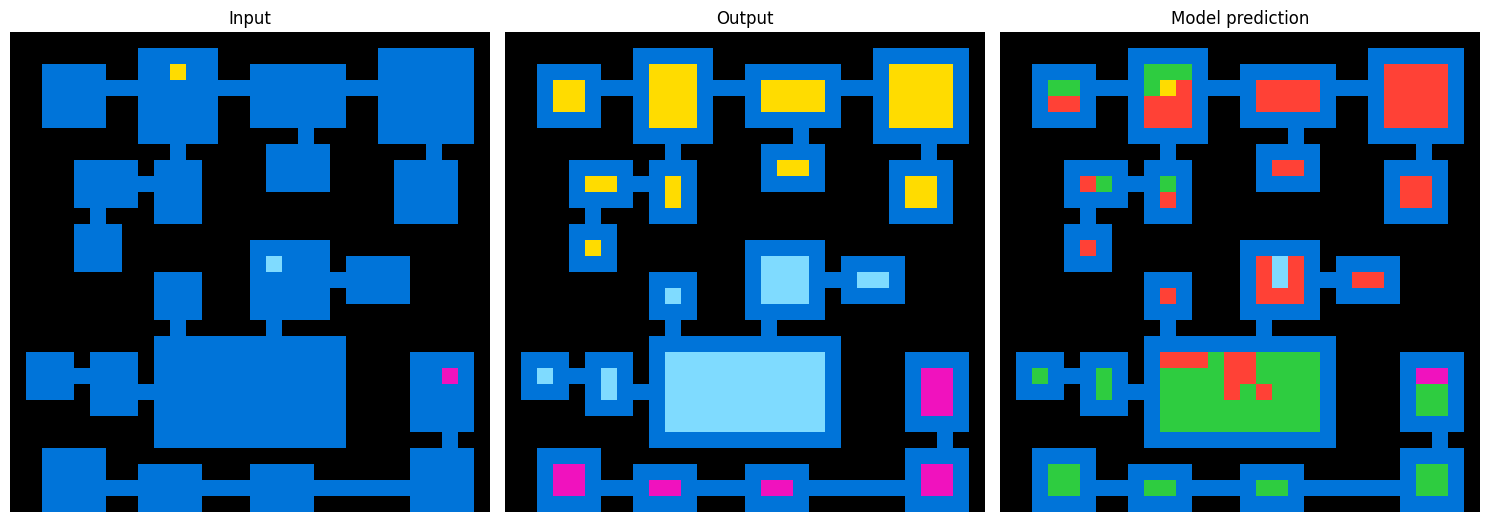

Accuracy: 0.8566666666666667
ac0c5833


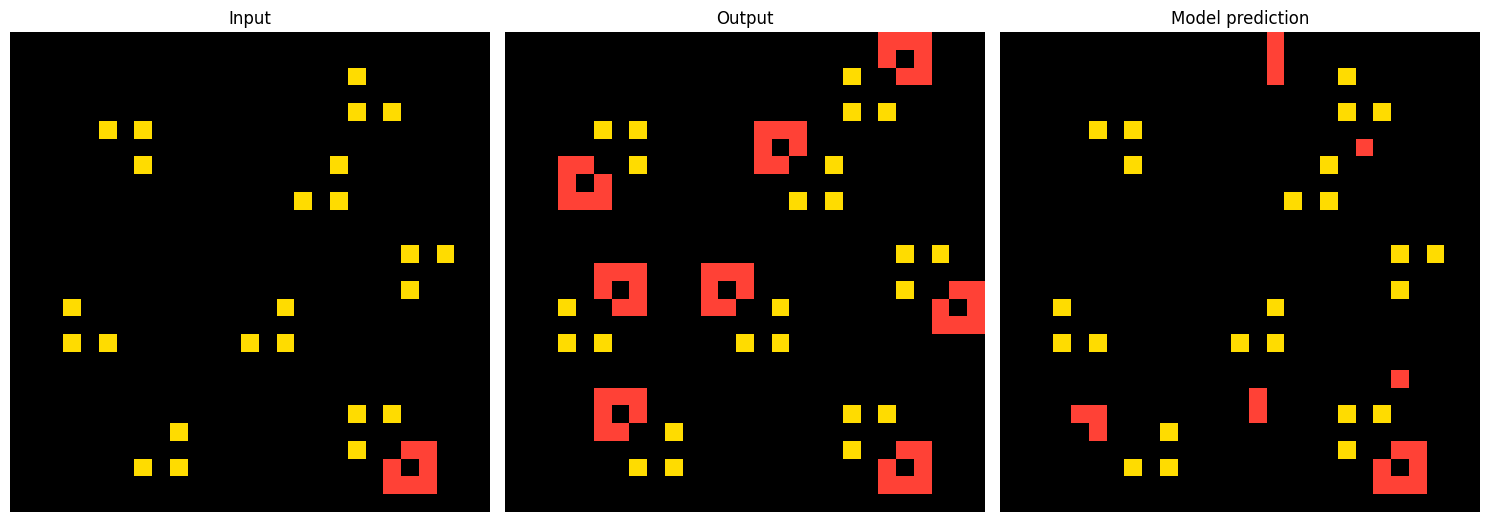

Accuracy: 0.9245541838134431


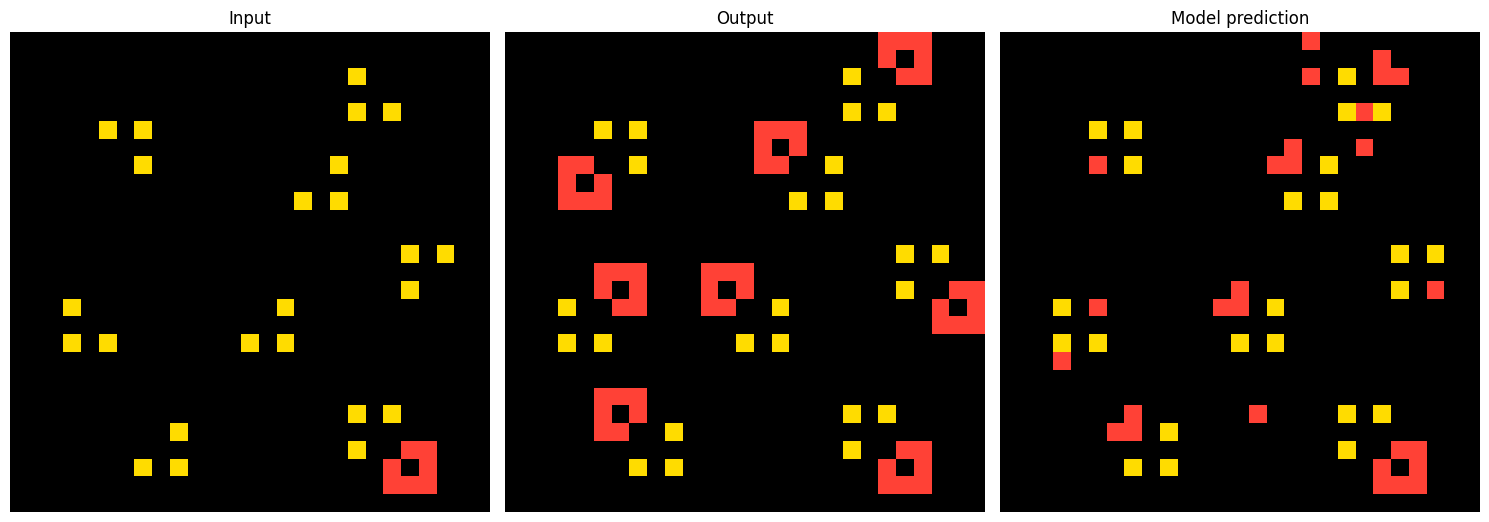

Accuracy: 0.9259259259259259


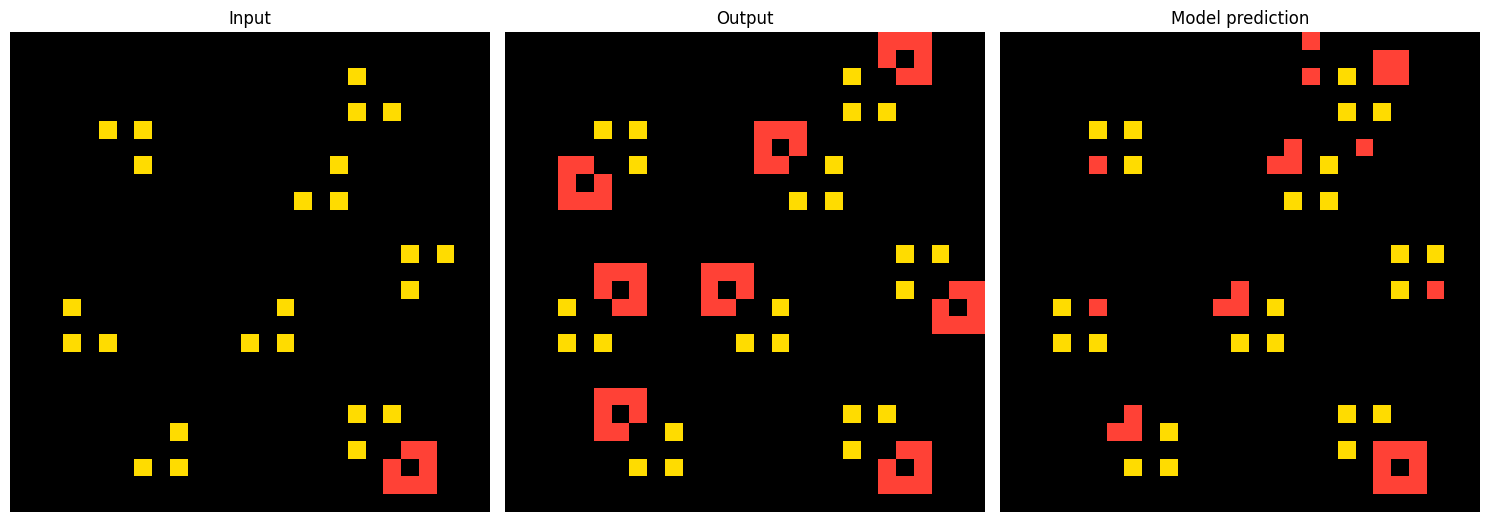

Accuracy: 0.9272976680384087
27a77e38


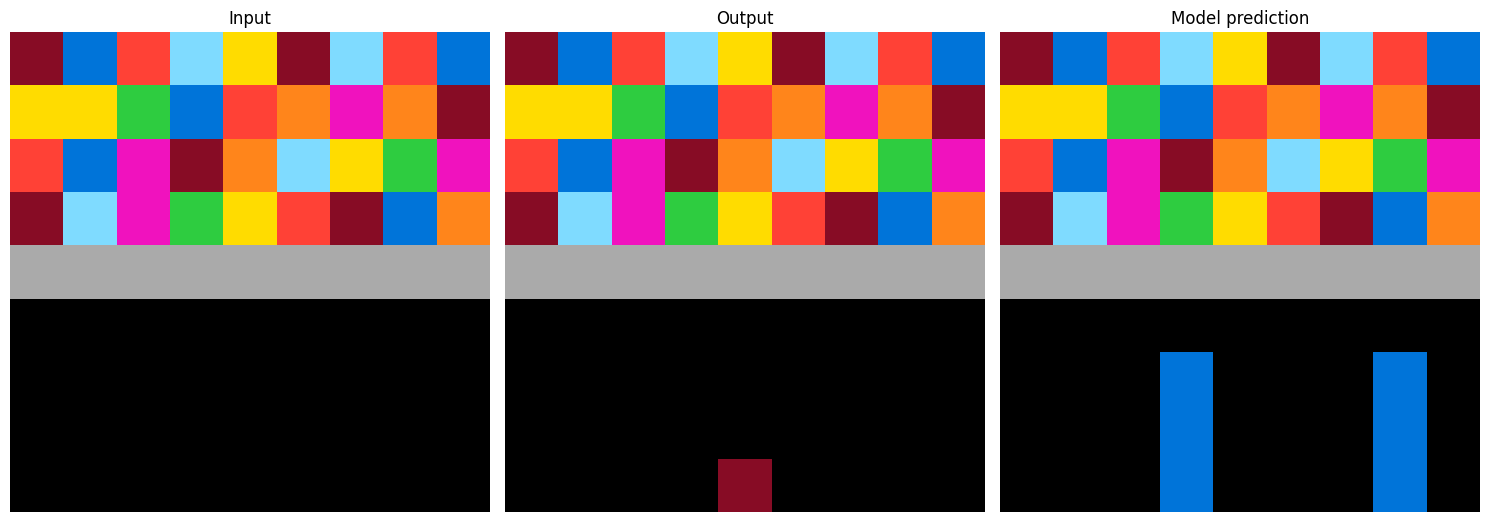

Accuracy: 0.9135802469135802


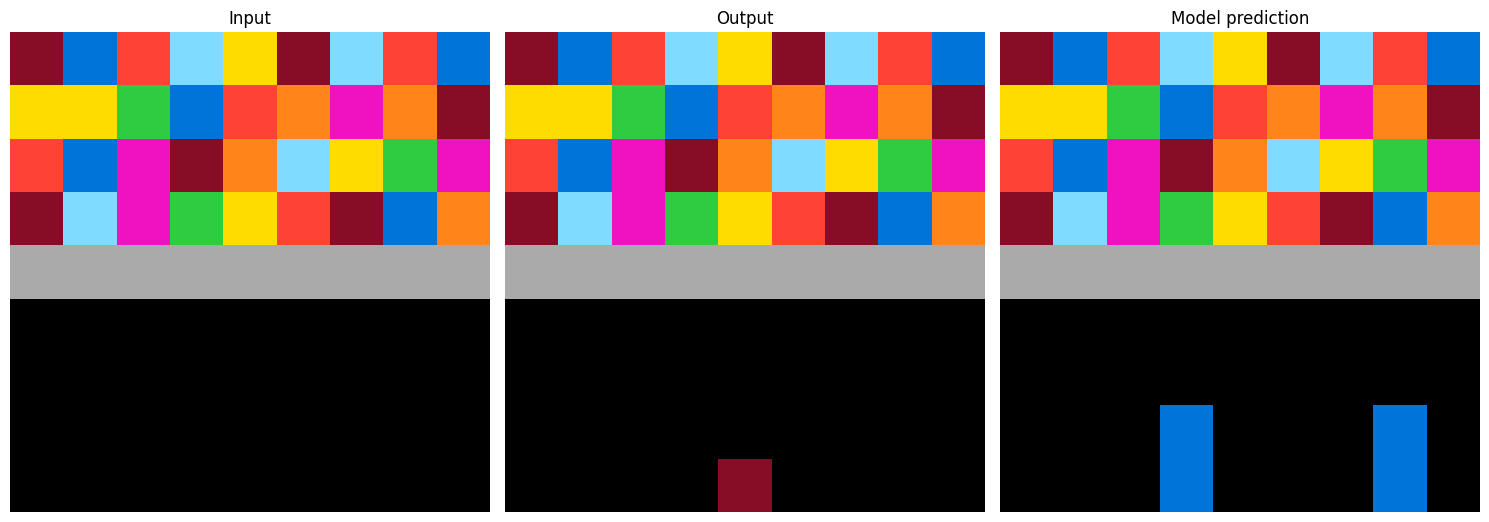

Accuracy: 0.9382716049382716


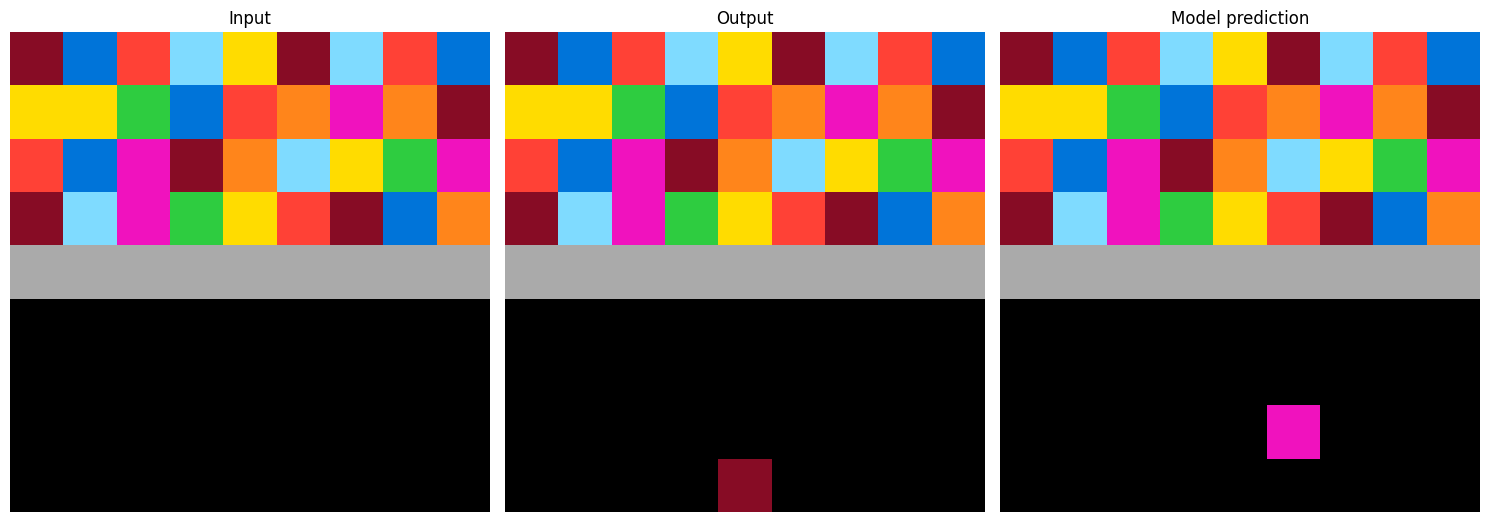

Accuracy: 0.9753086419753086
7e02026e


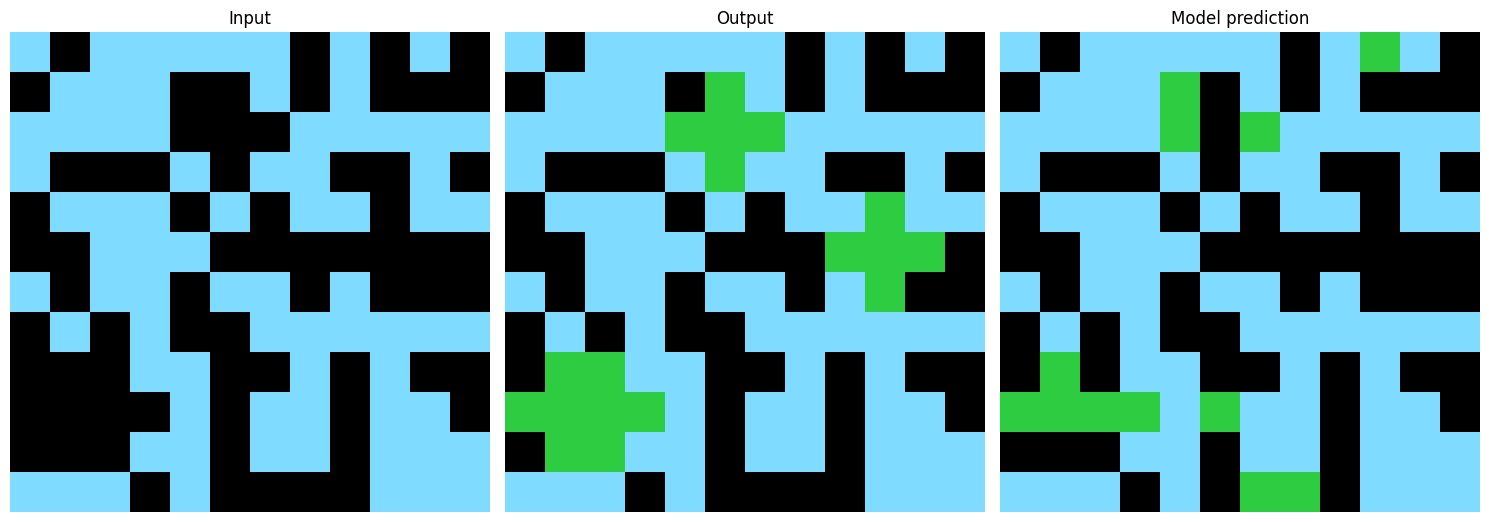

Accuracy: 0.8888888888888888


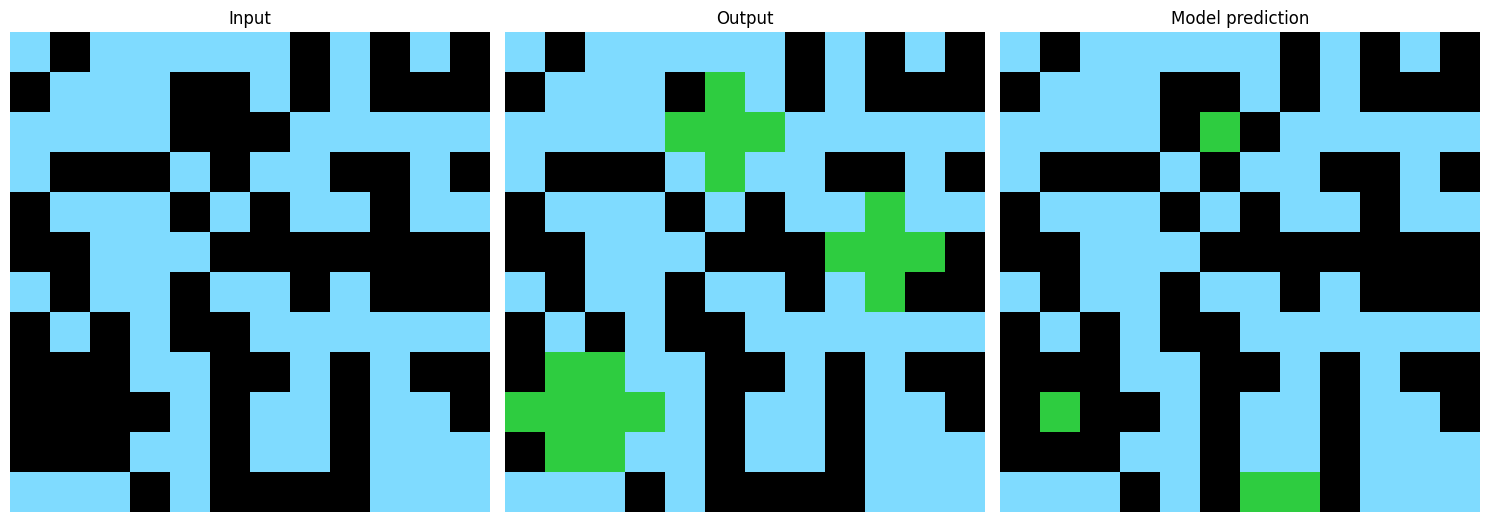

Accuracy: 0.875


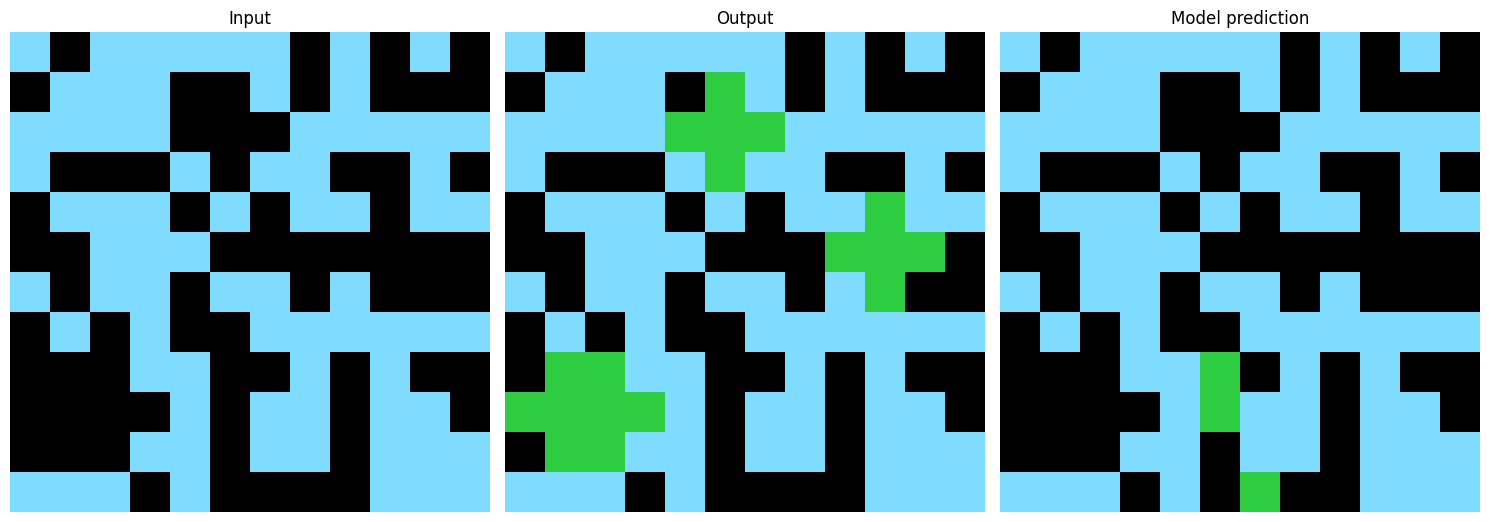

Accuracy: 0.8541666666666666
a680ac02
ac605cbb


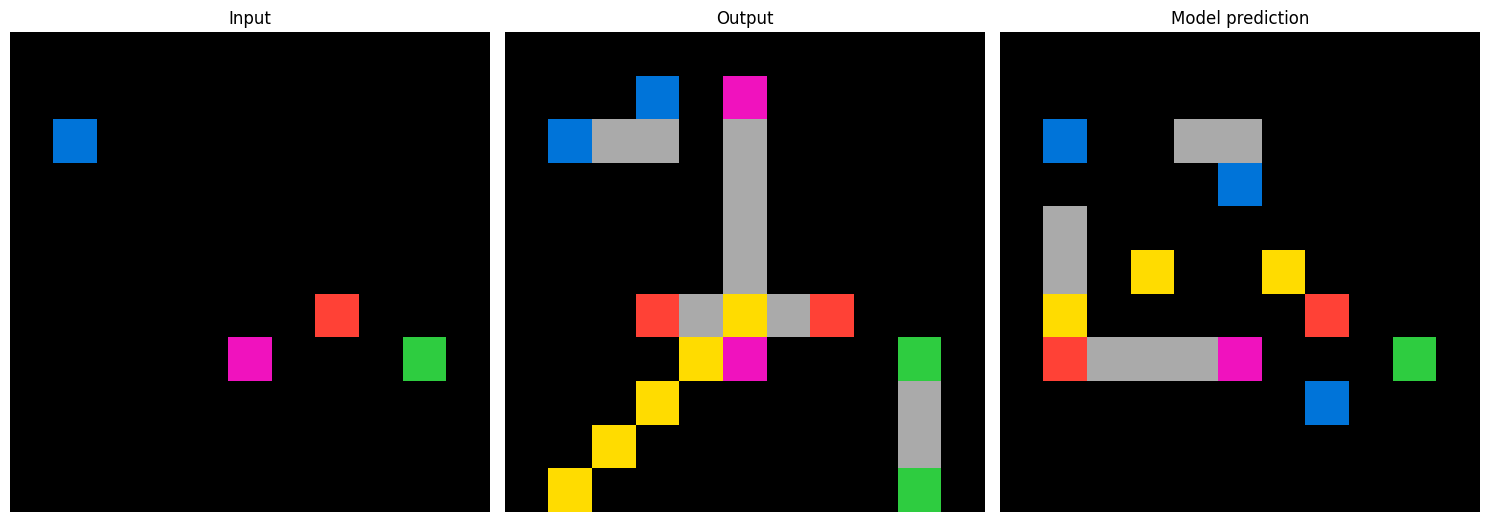

Accuracy: 0.768595041322314


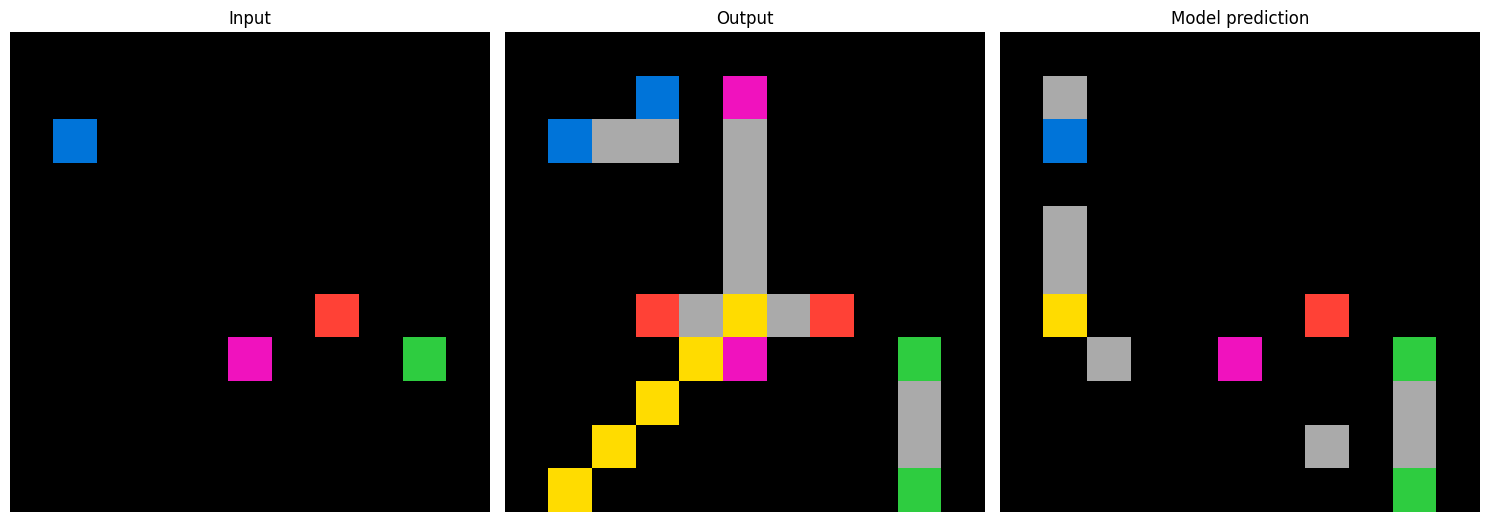

Accuracy: 0.8181818181818182


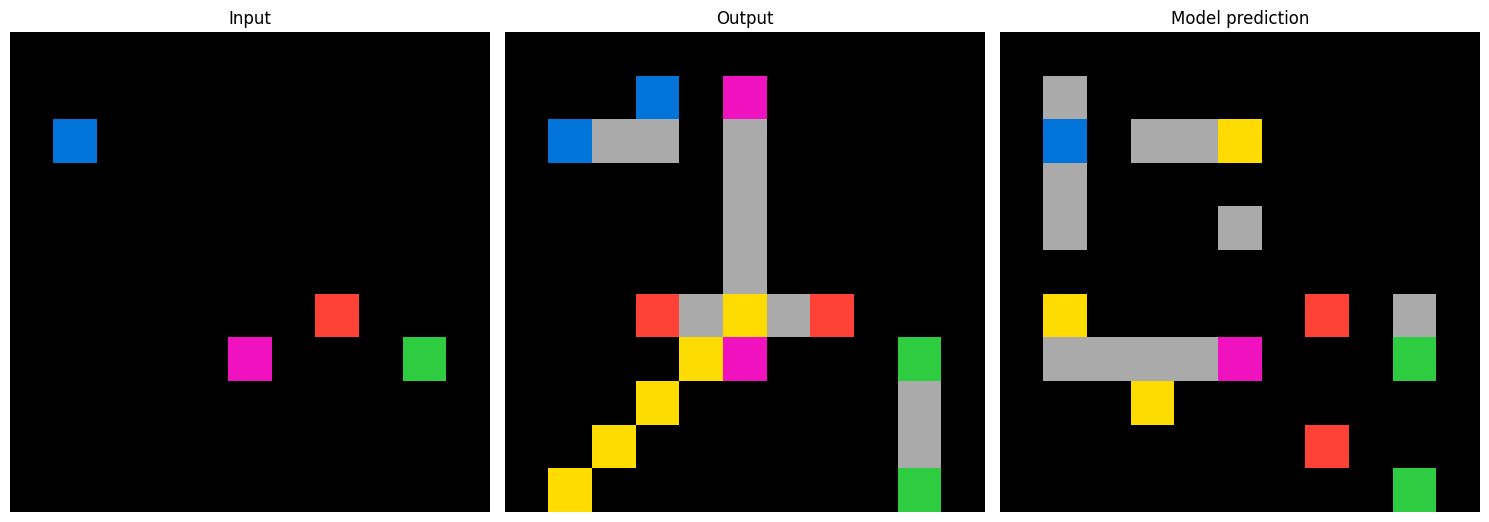

Accuracy: 0.7933884297520661
5b6cbef5
17b80ad2


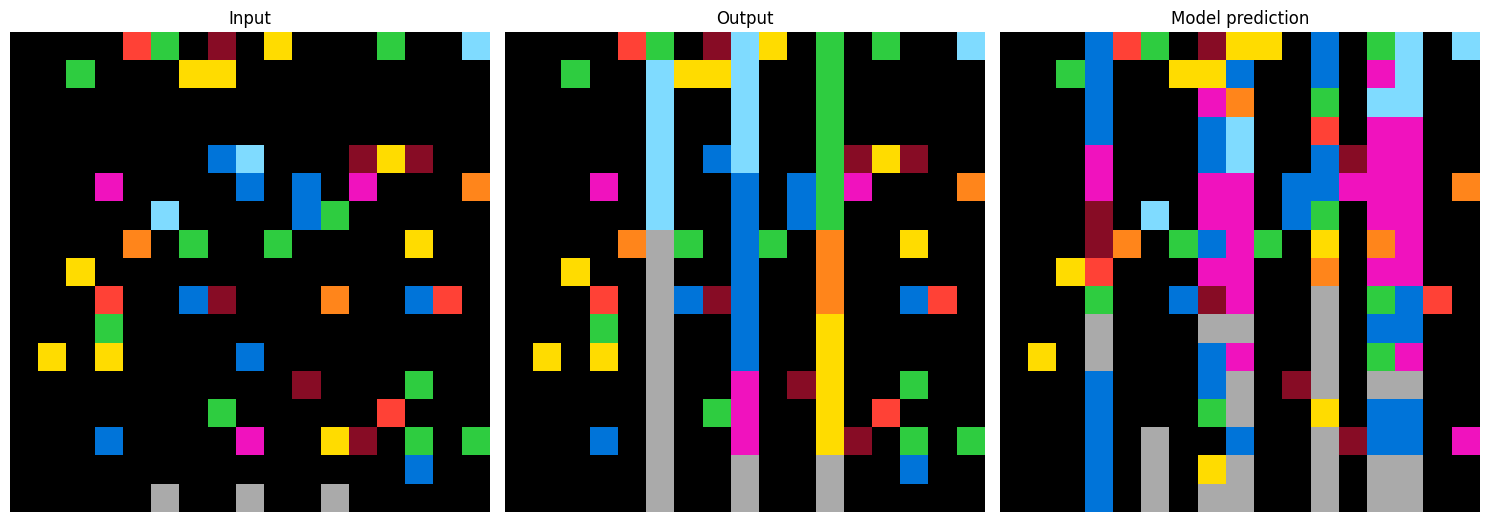

Accuracy: 0.671280276816609


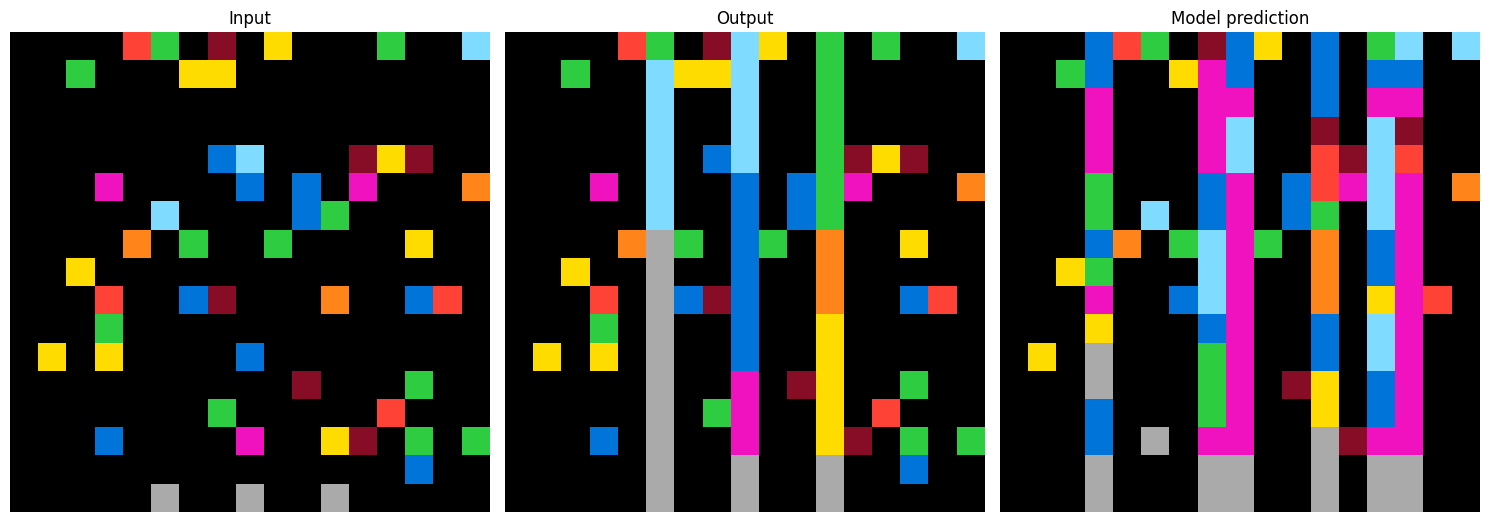

Accuracy: 0.6608996539792388


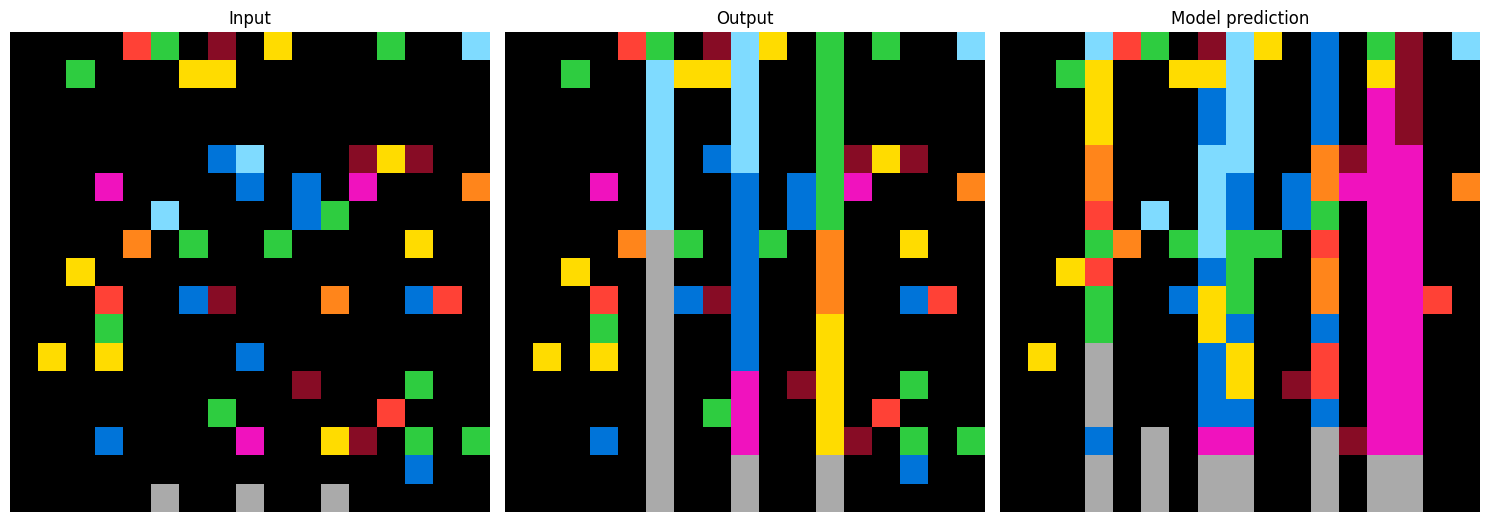

Accuracy: 0.6747404844290658
4acc7107


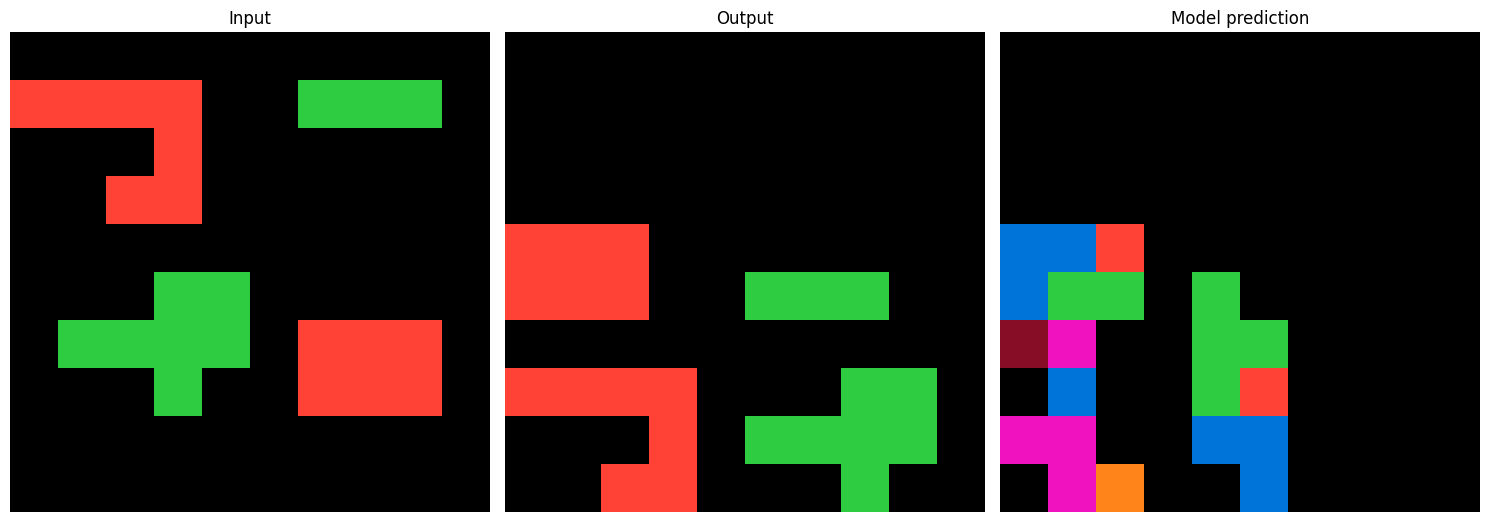

Accuracy: 0.66


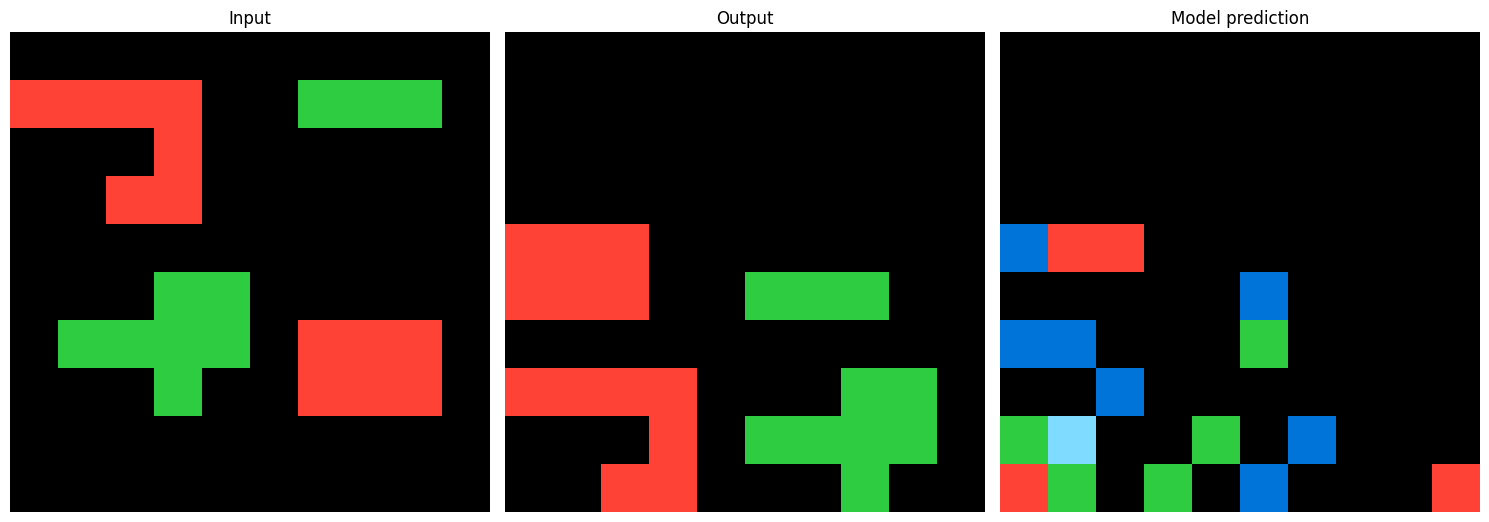

Accuracy: 0.69


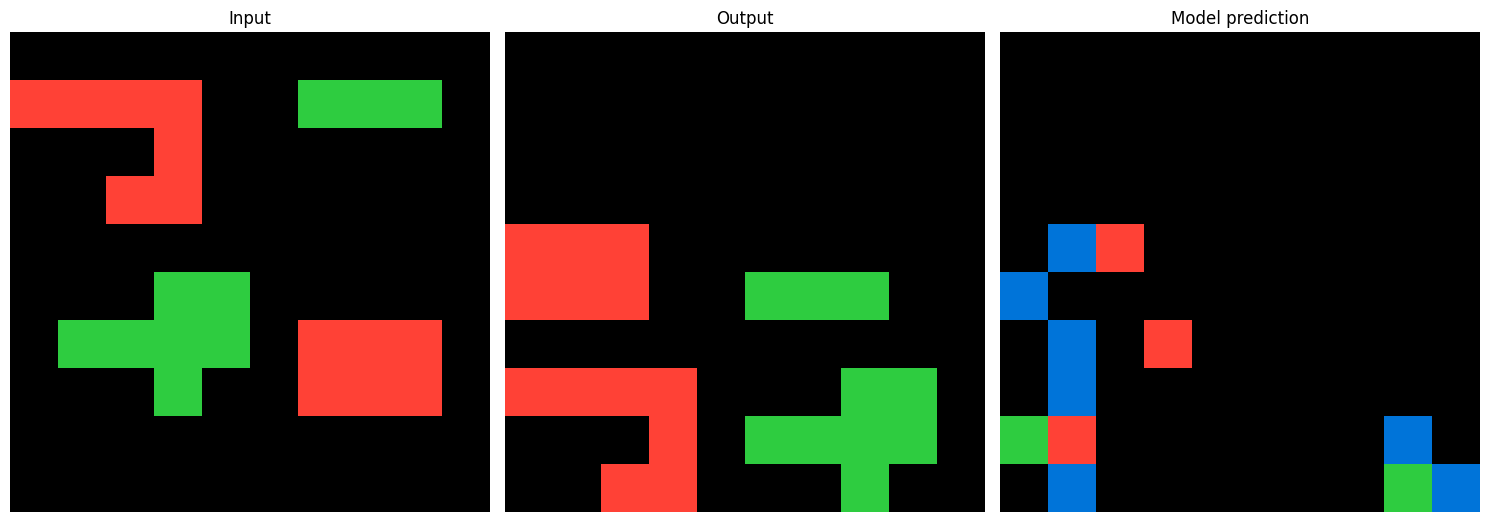

Accuracy: 0.71
67c52801


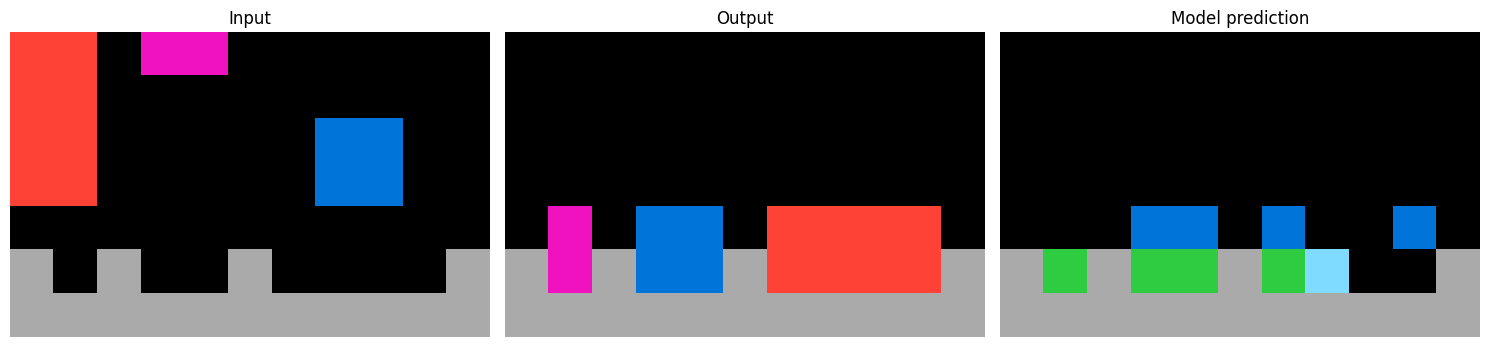

Accuracy: 0.8441558441558441


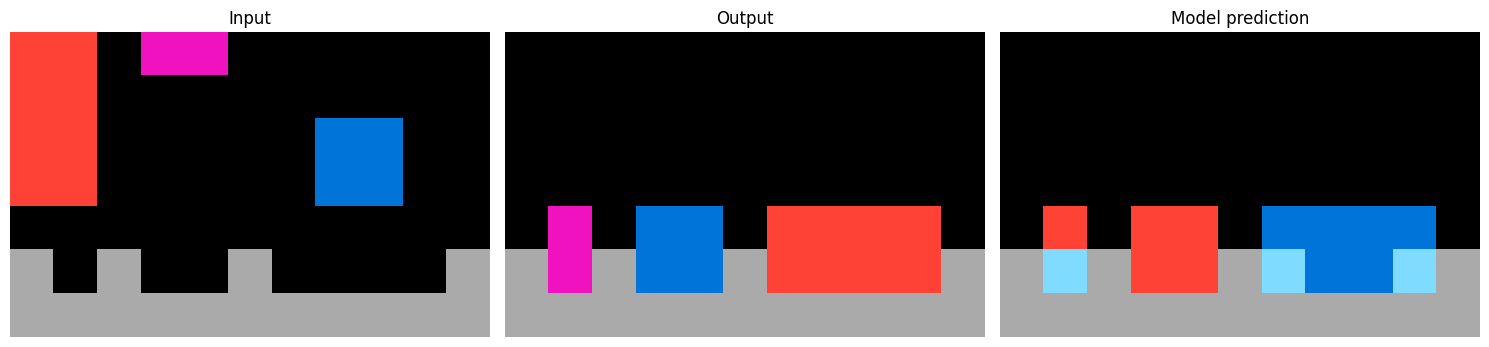

Accuracy: 0.8181818181818182


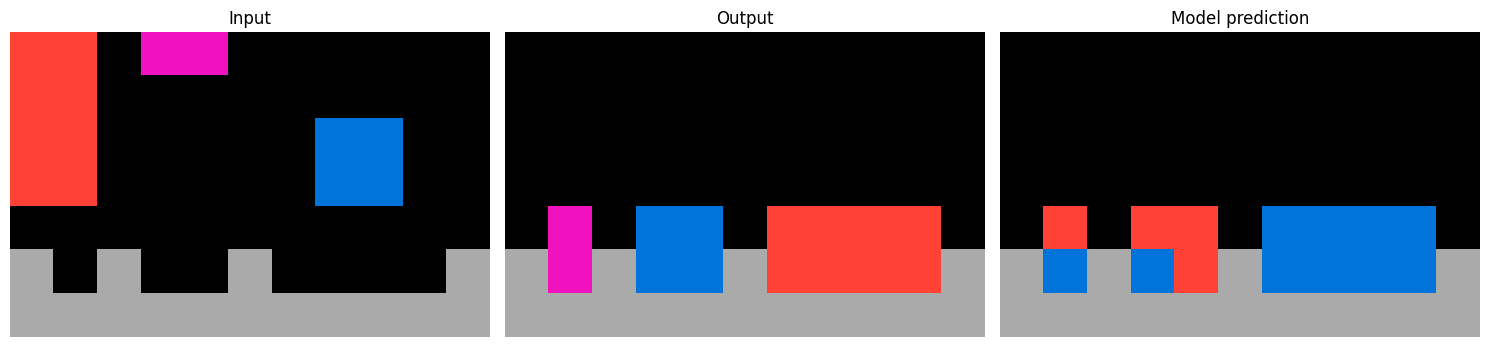

Accuracy: 0.8311688311688312
ce039d91


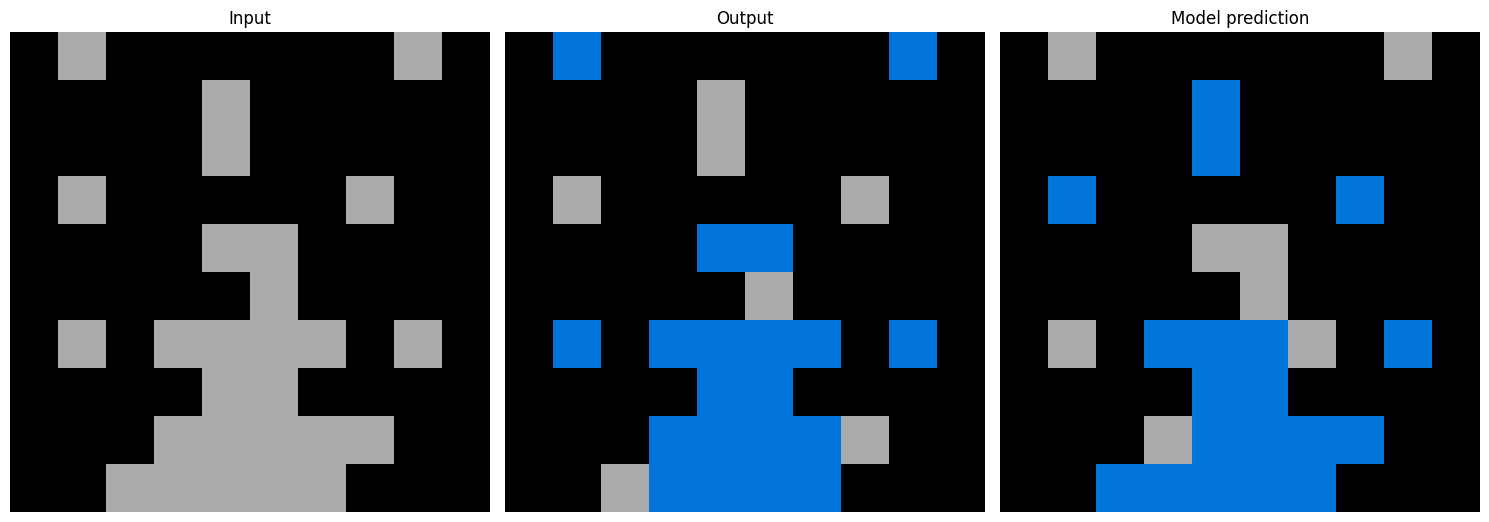

Accuracy: 0.87


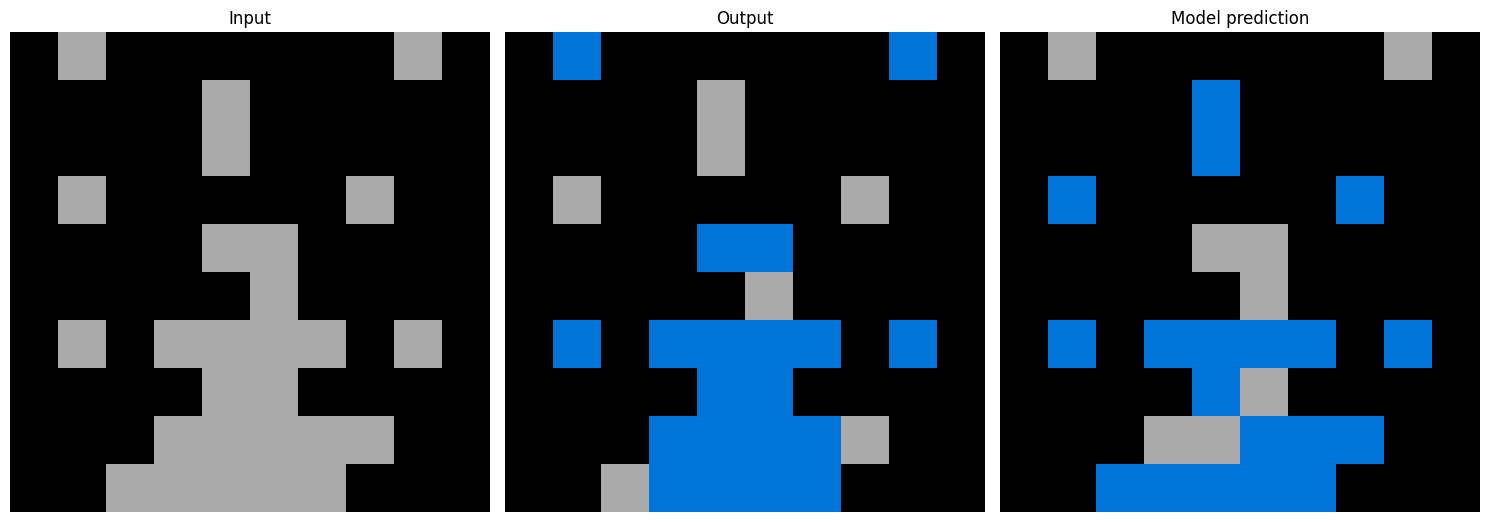

Accuracy: 0.87


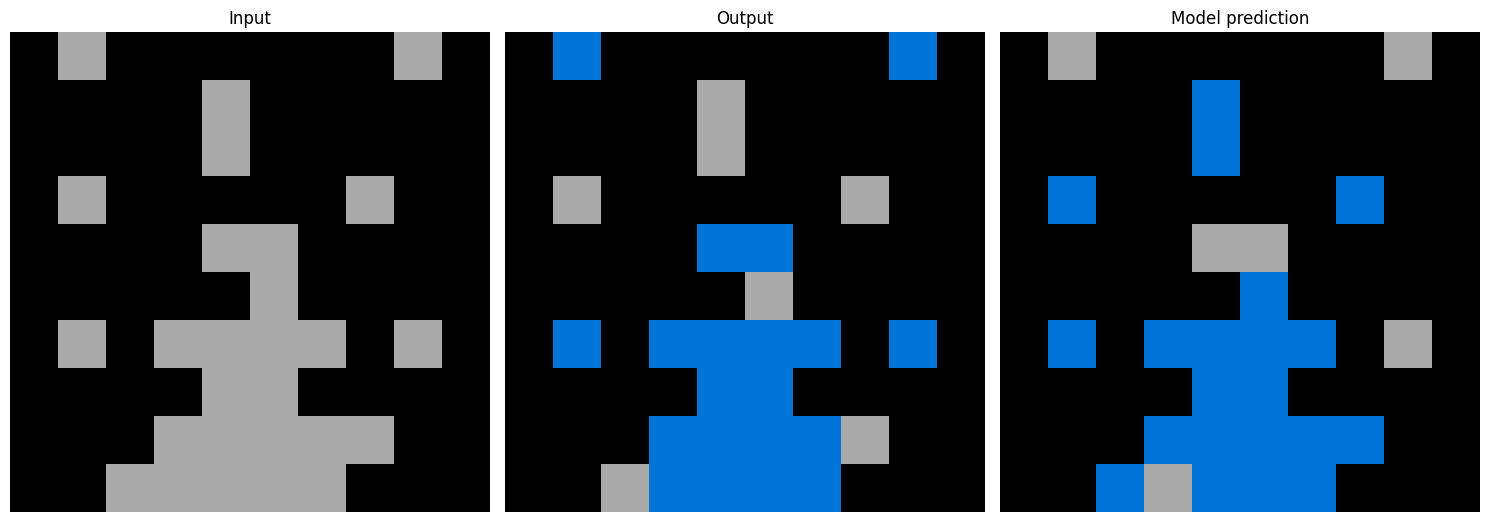

Accuracy: 0.87
506d28a5
5a5a2103


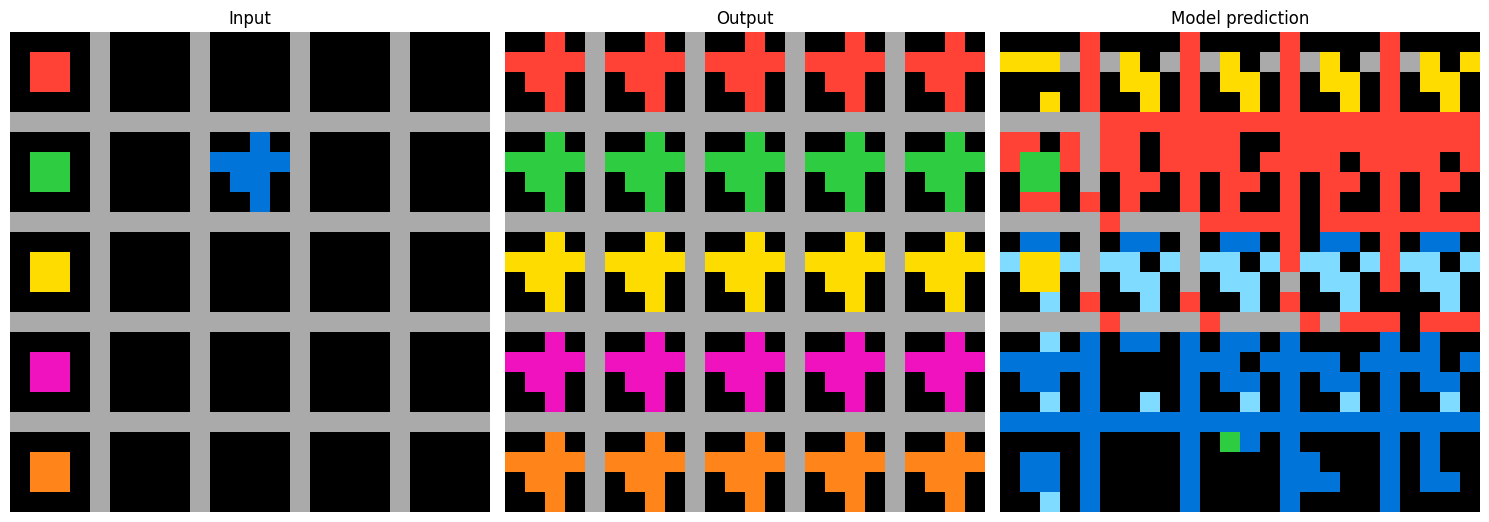

Accuracy: 0.375


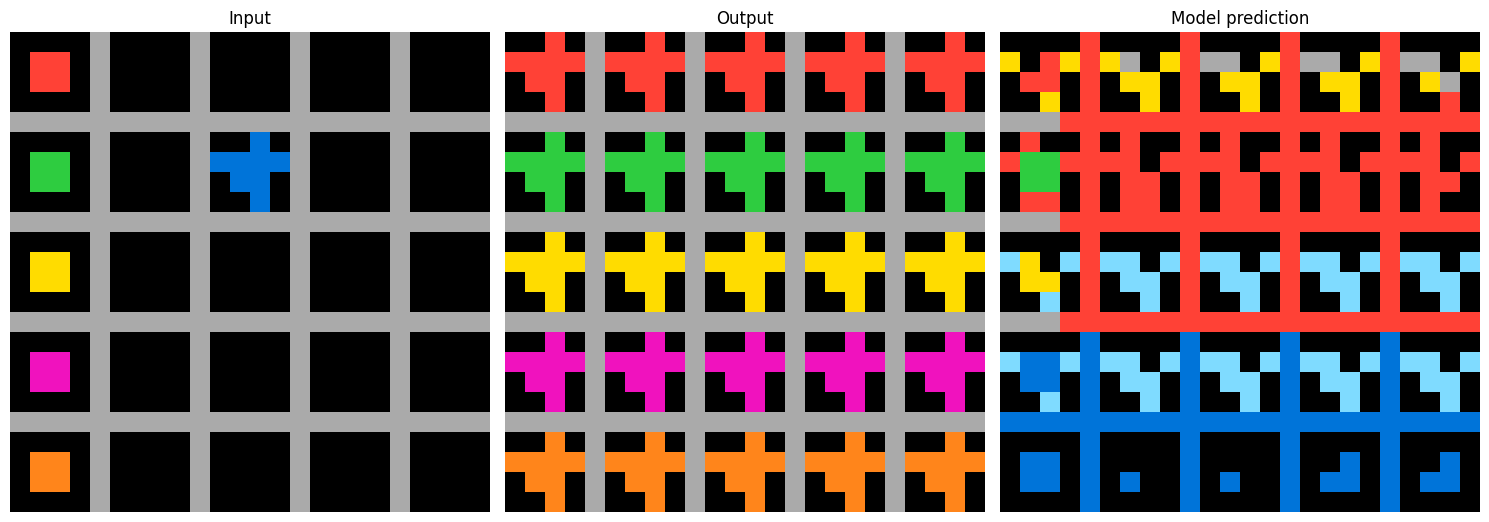

Accuracy: 0.3645833333333333


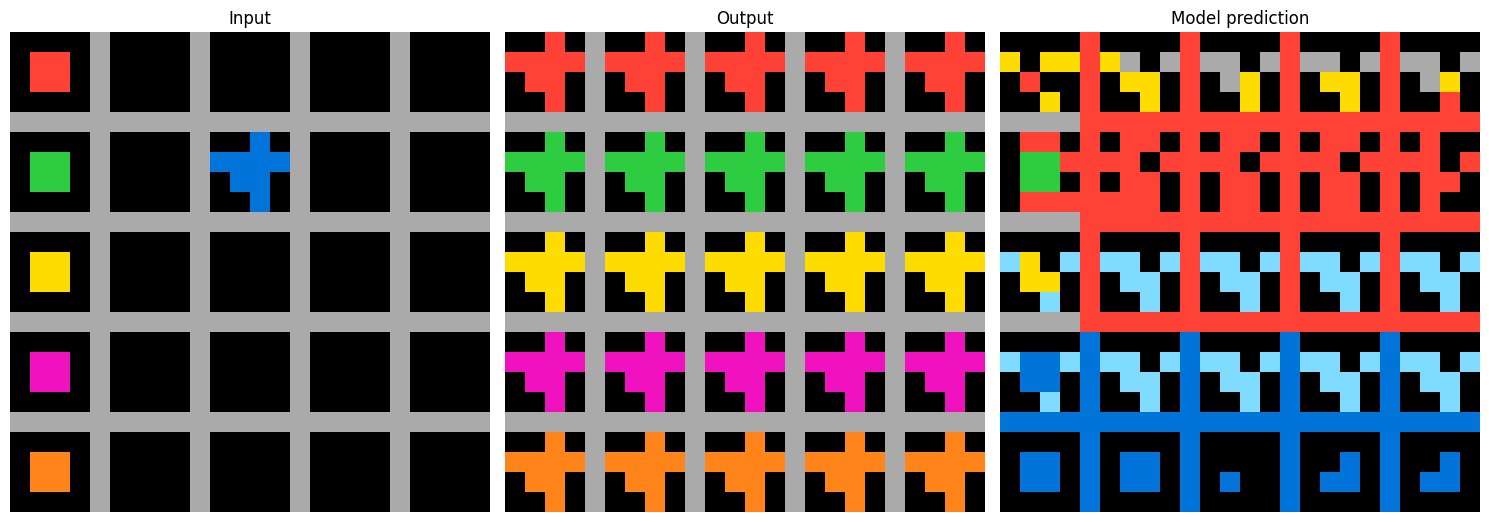

Accuracy: 0.3628472222222222
0c9aba6e
55783887


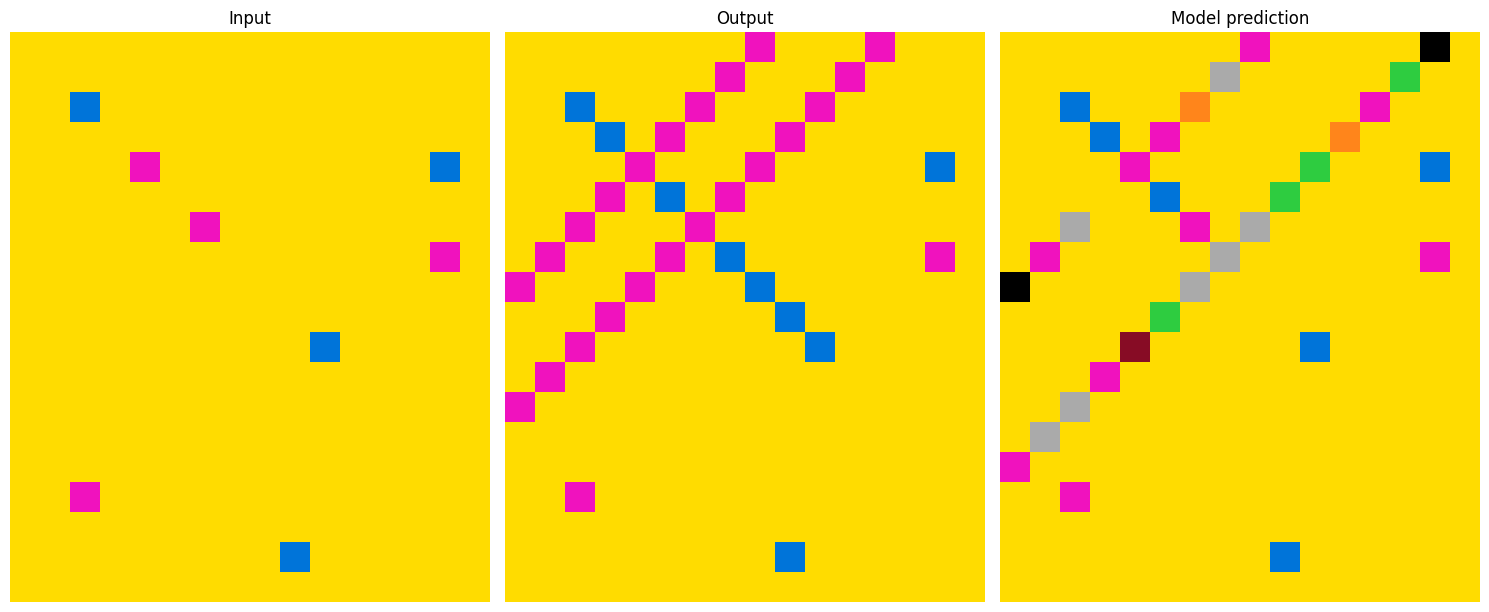

Accuracy: 0.8881578947368421


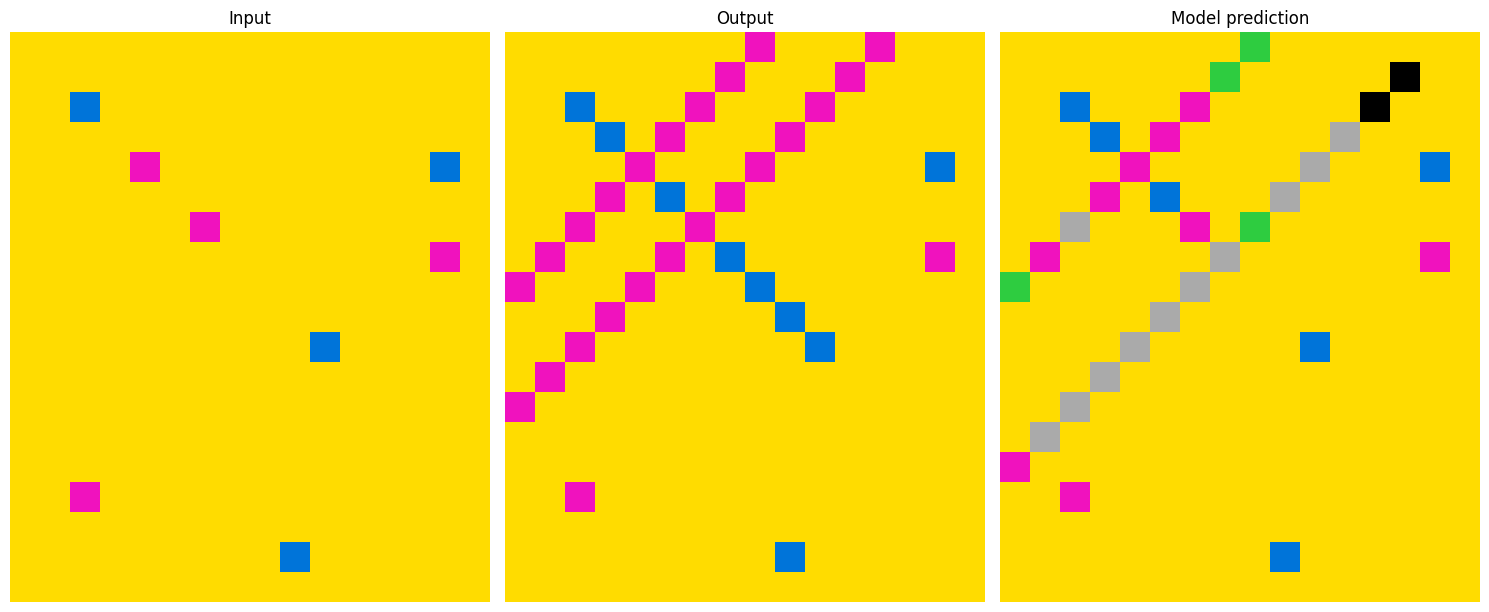

Accuracy: 0.8947368421052632


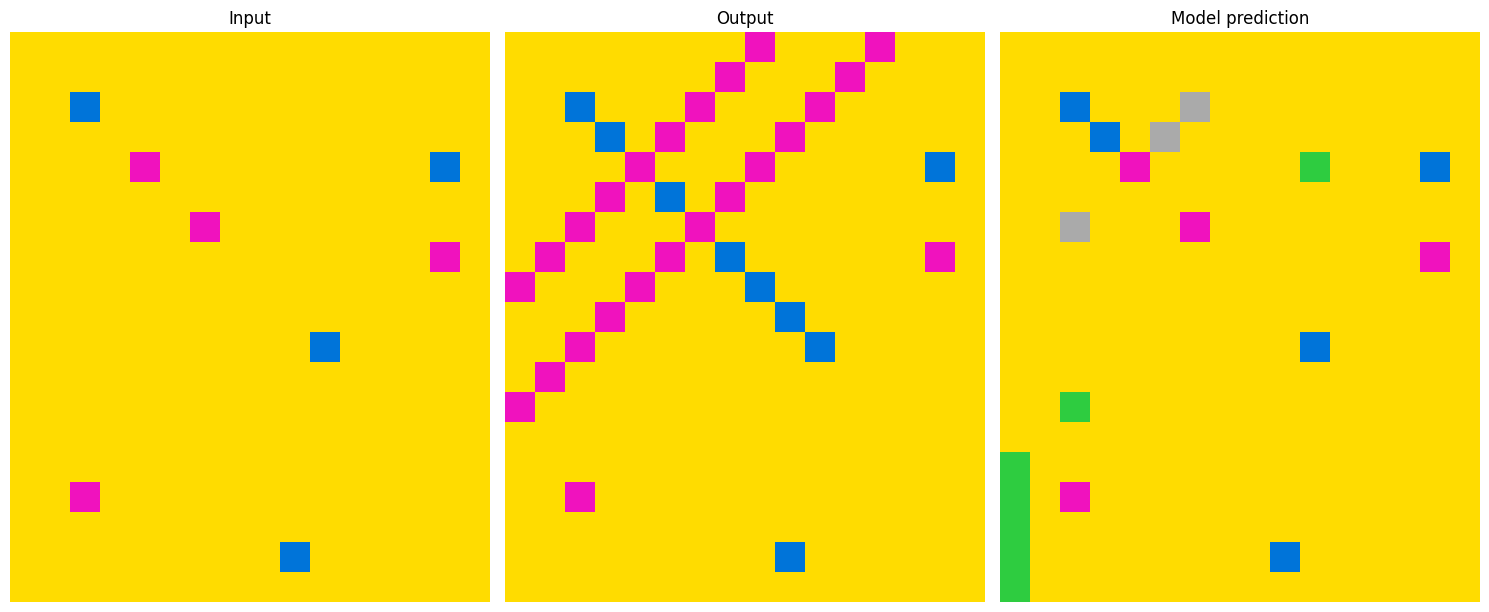

Accuracy: 0.8980263157894737
ecaa0ec1


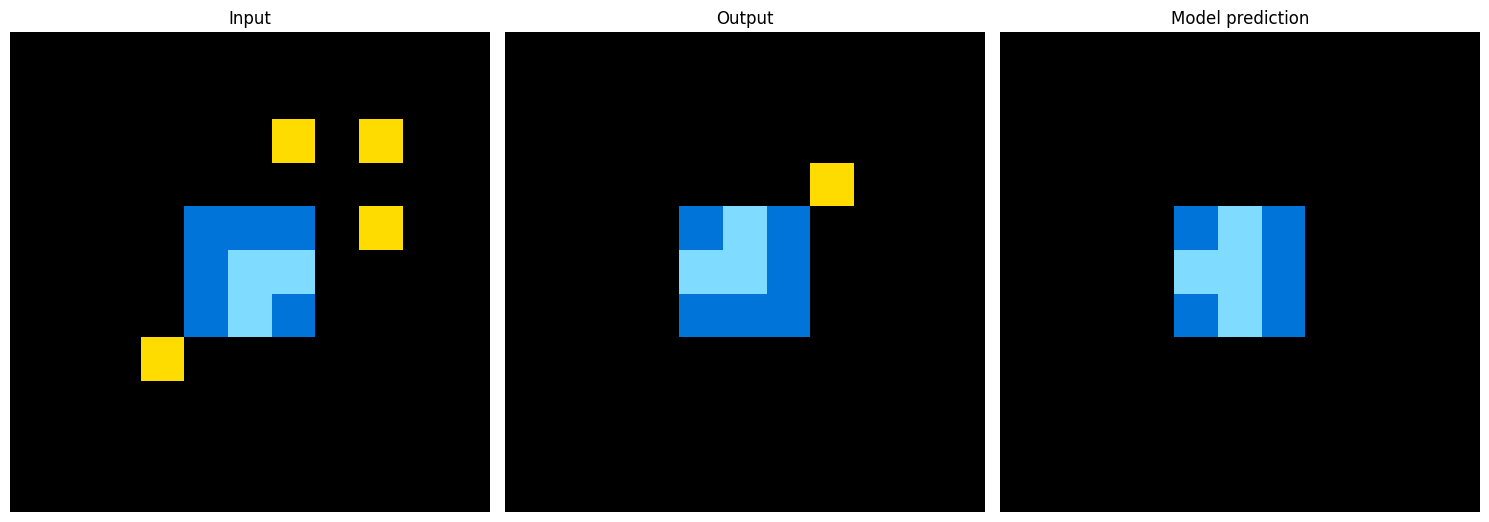

Accuracy: 0.9834710743801653


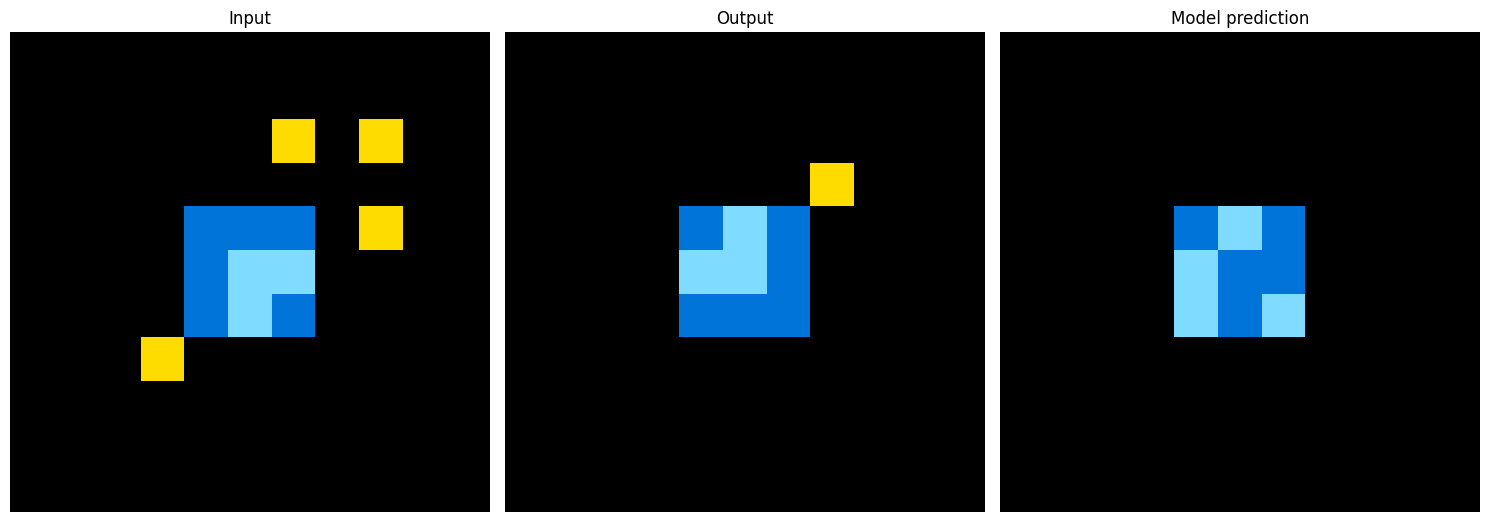

Accuracy: 0.9669421487603306


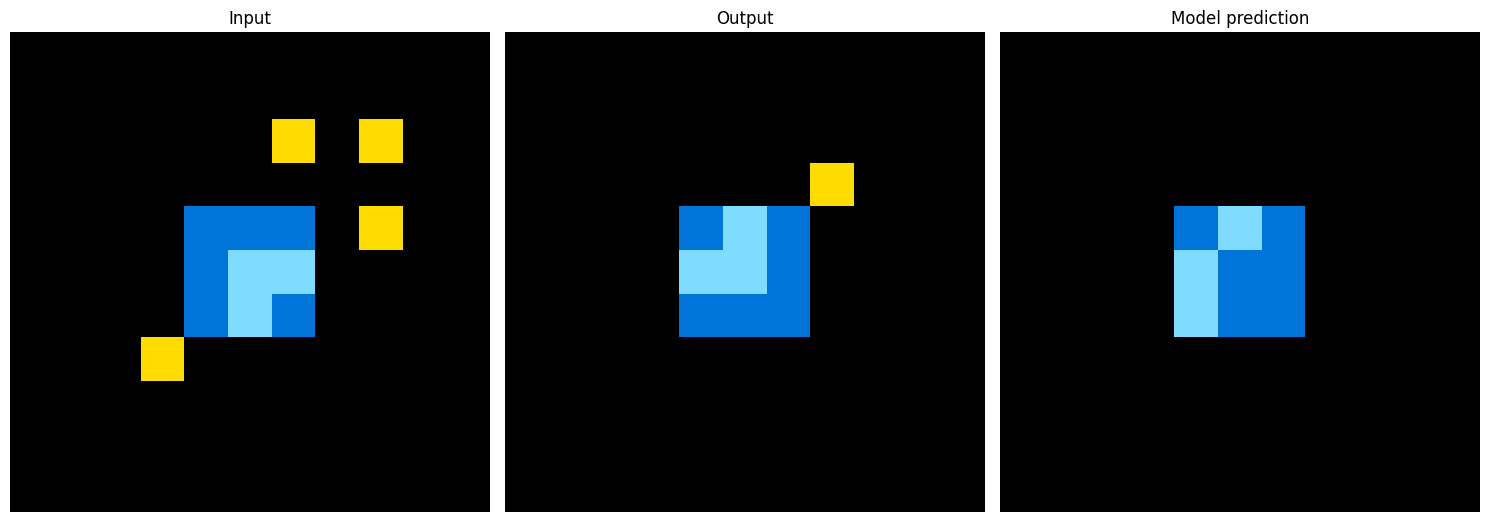

Accuracy: 0.9752066115702479
929ab4e9


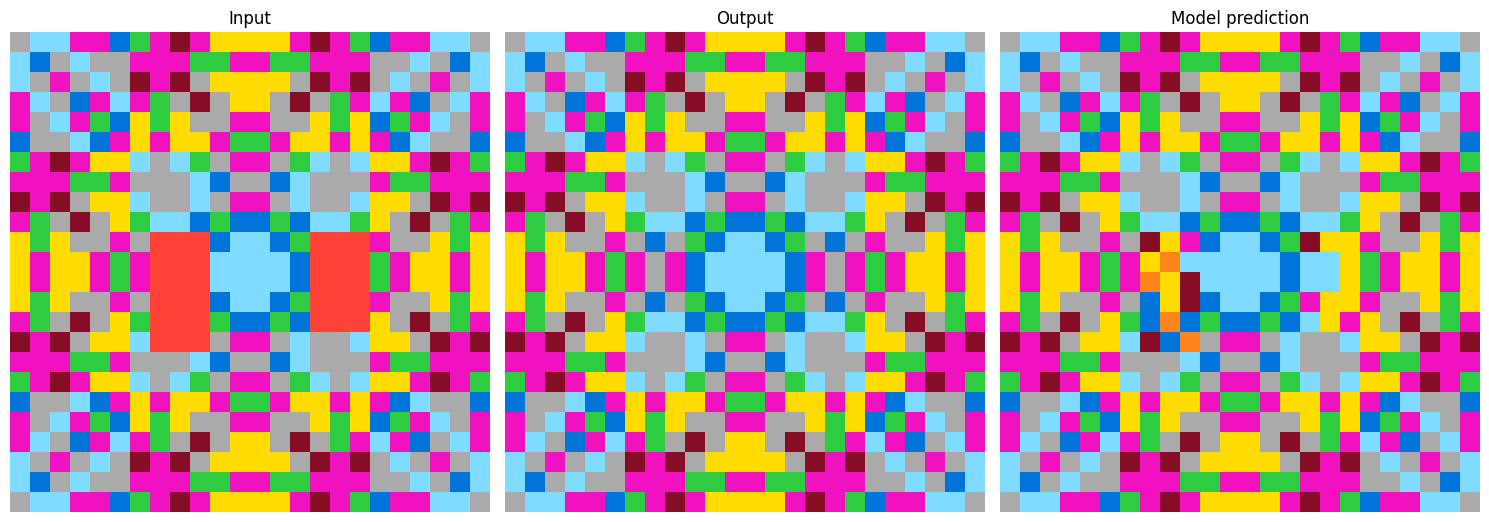

Accuracy: 0.9479166666666666


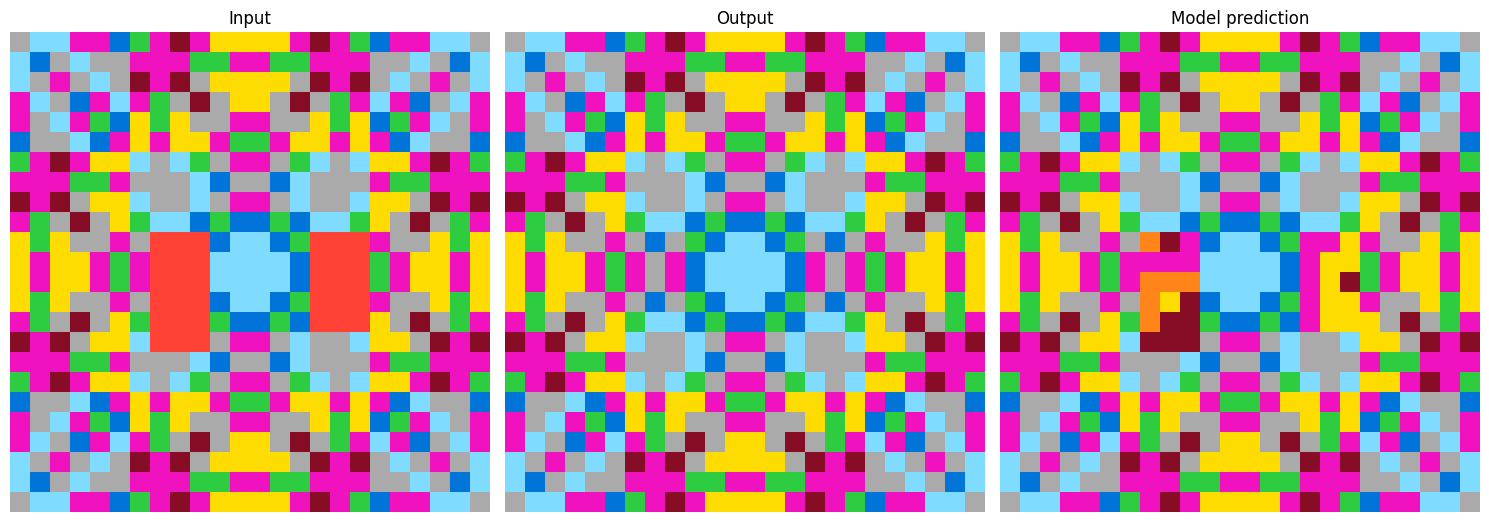

Accuracy: 0.9479166666666666


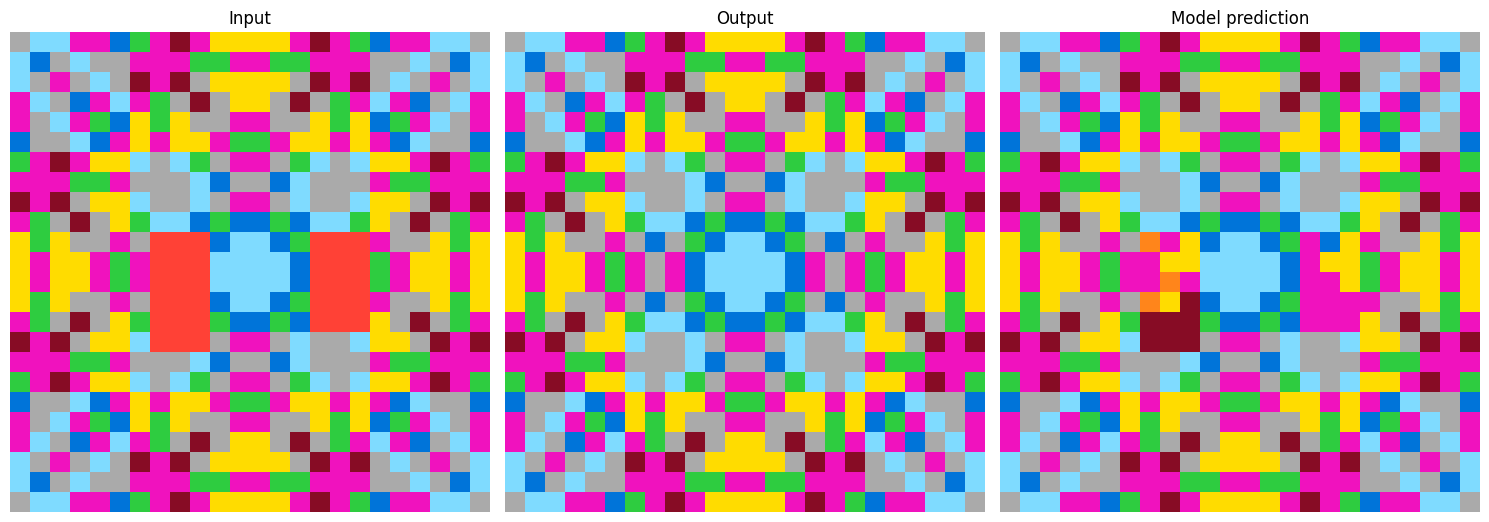

Accuracy: 0.9479166666666666
ae58858e


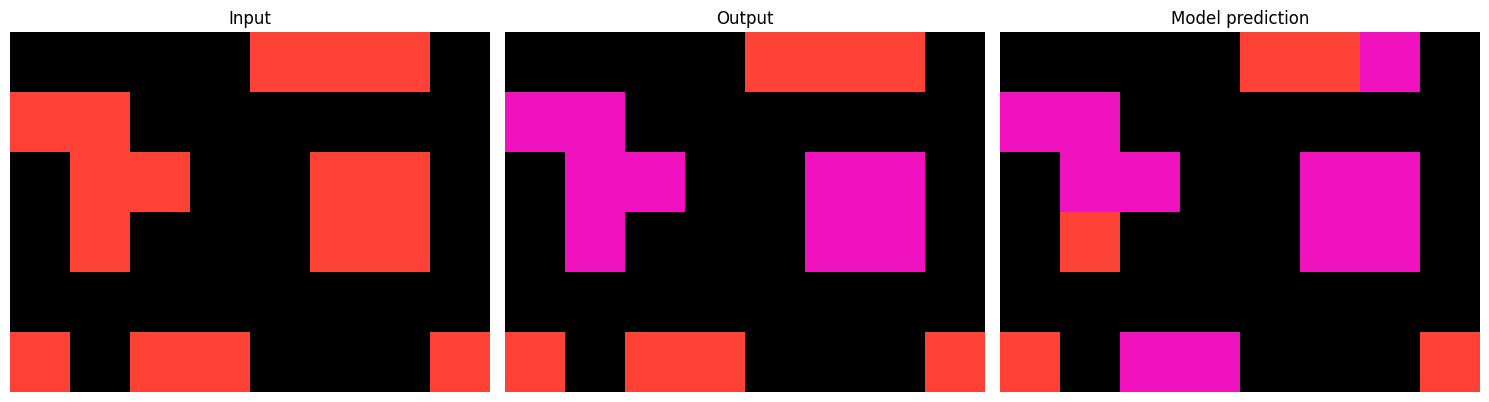

Accuracy: 0.9166666666666666


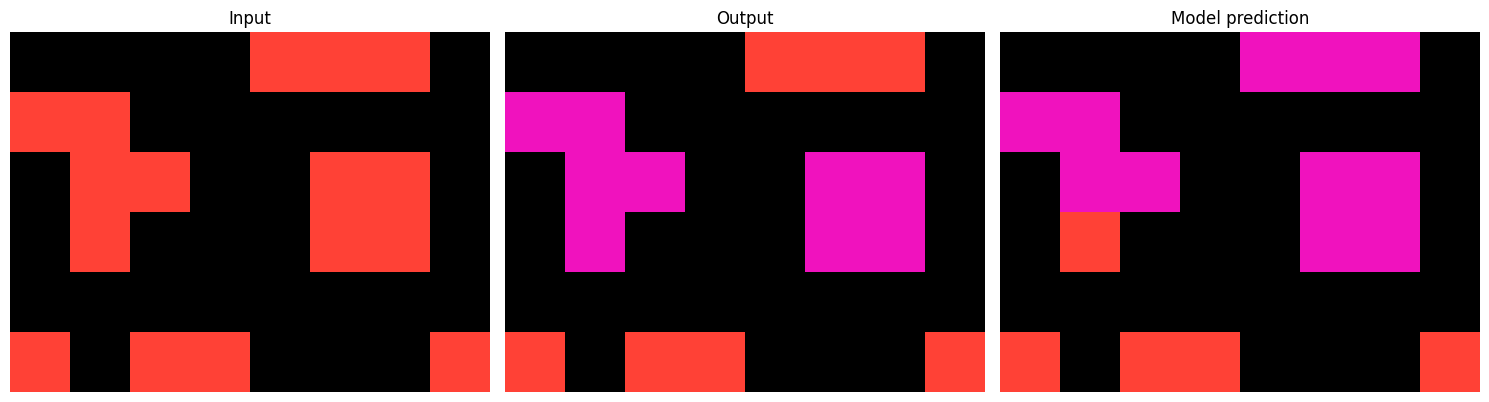

Accuracy: 0.9166666666666666


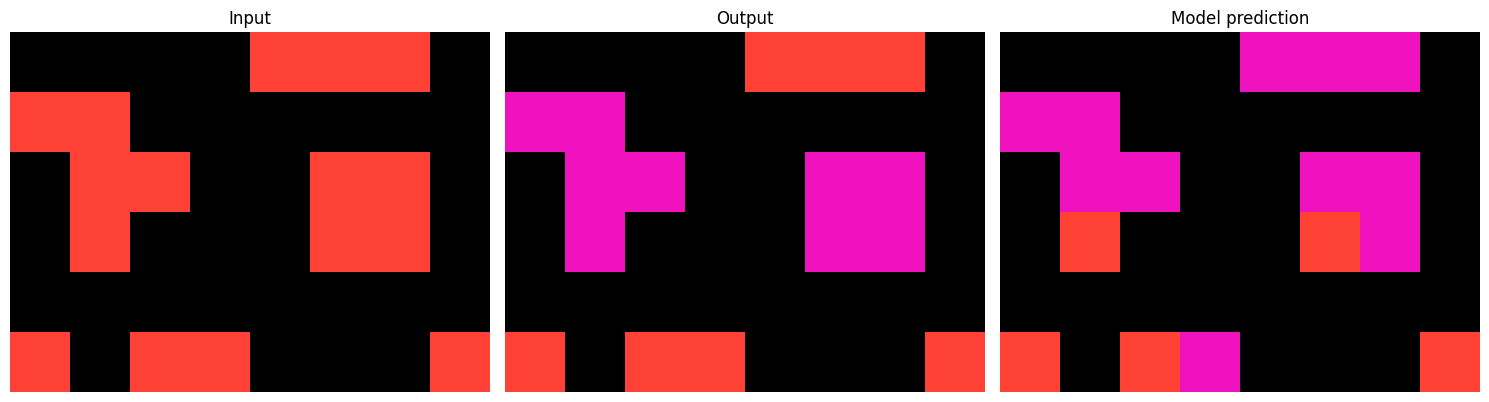

Accuracy: 0.875
c658a4bd
477d2879


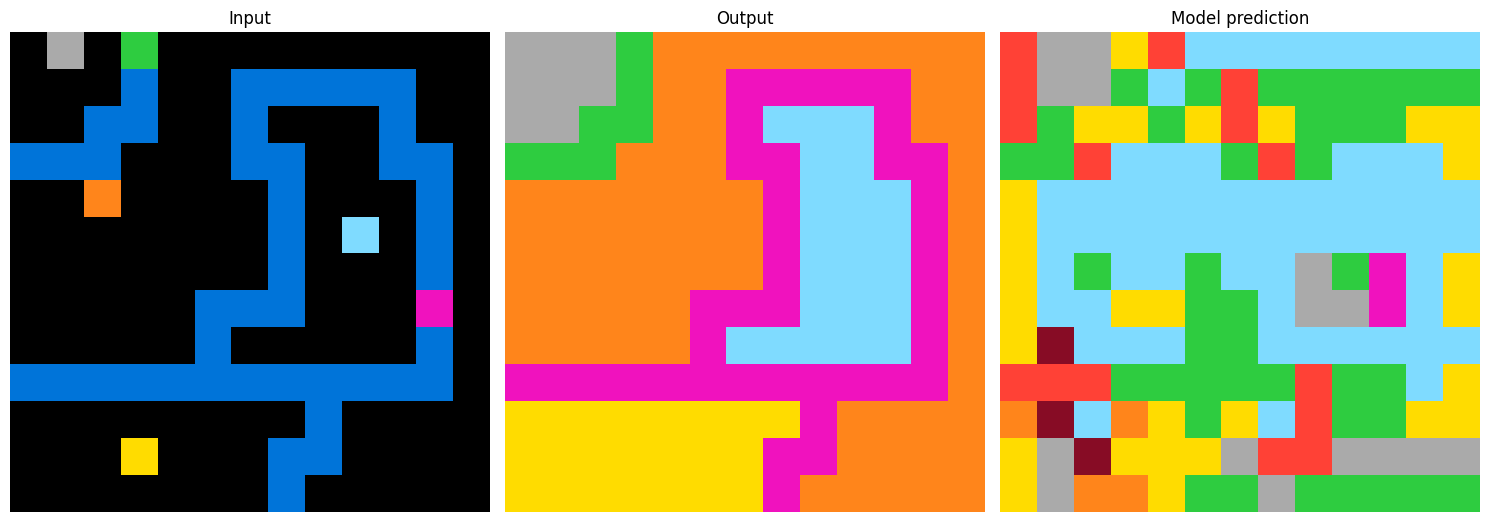

Accuracy: 0.15384615384615385


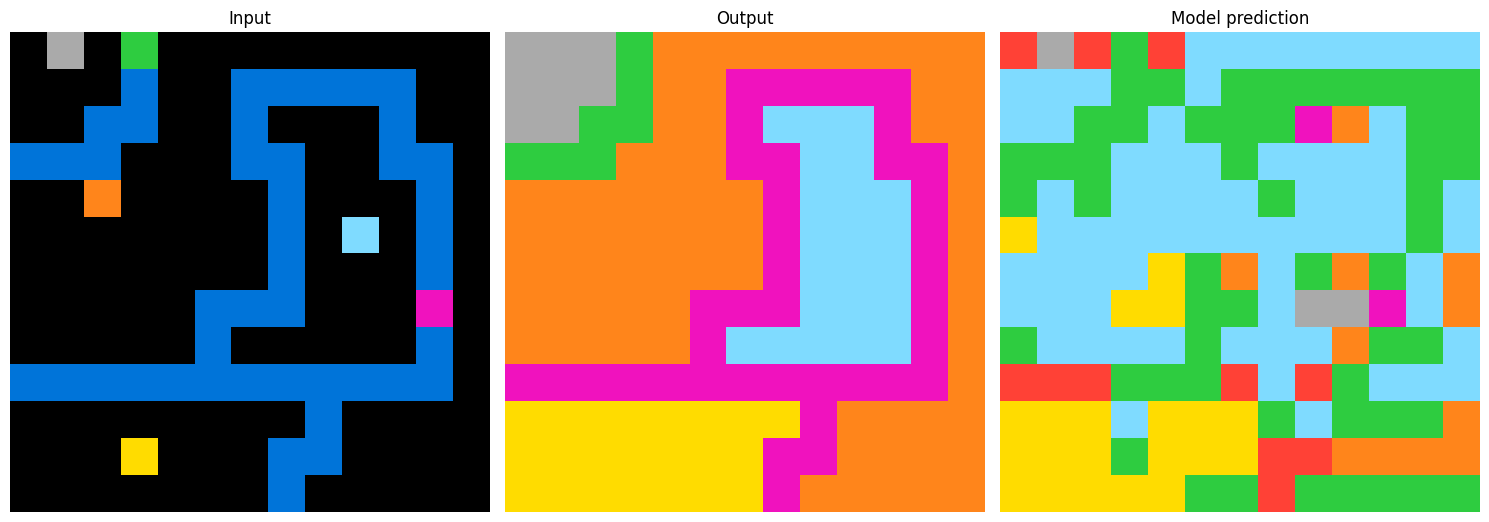

Accuracy: 0.2603550295857988


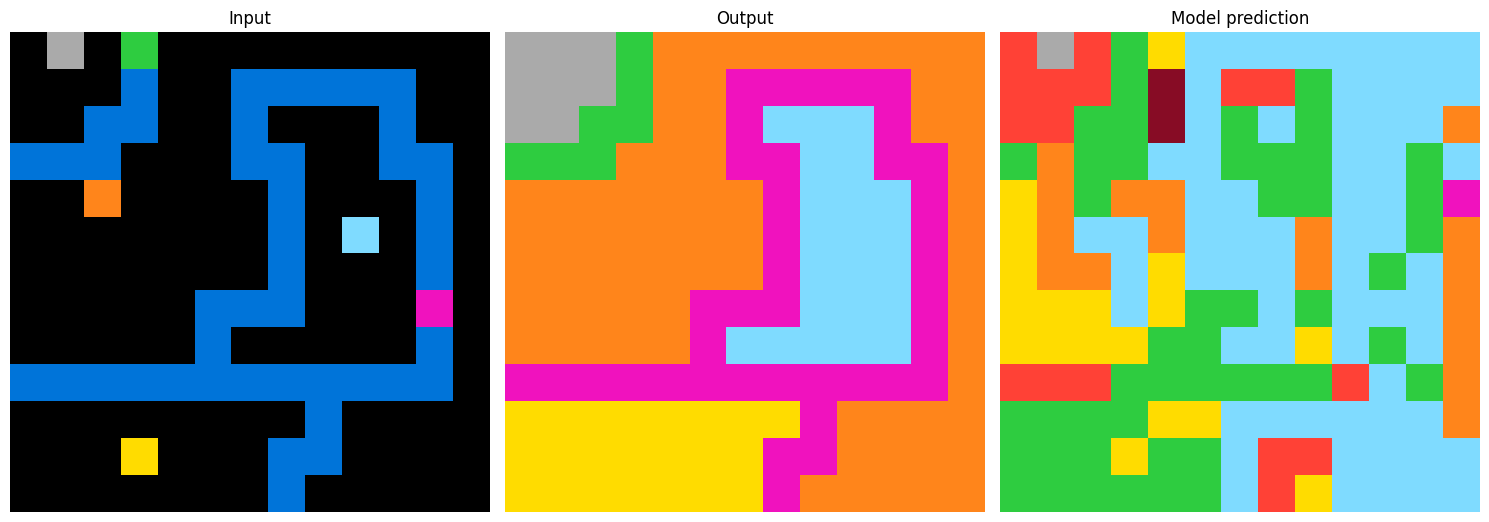

Accuracy: 0.21893491124260356
281123b4
12422b43


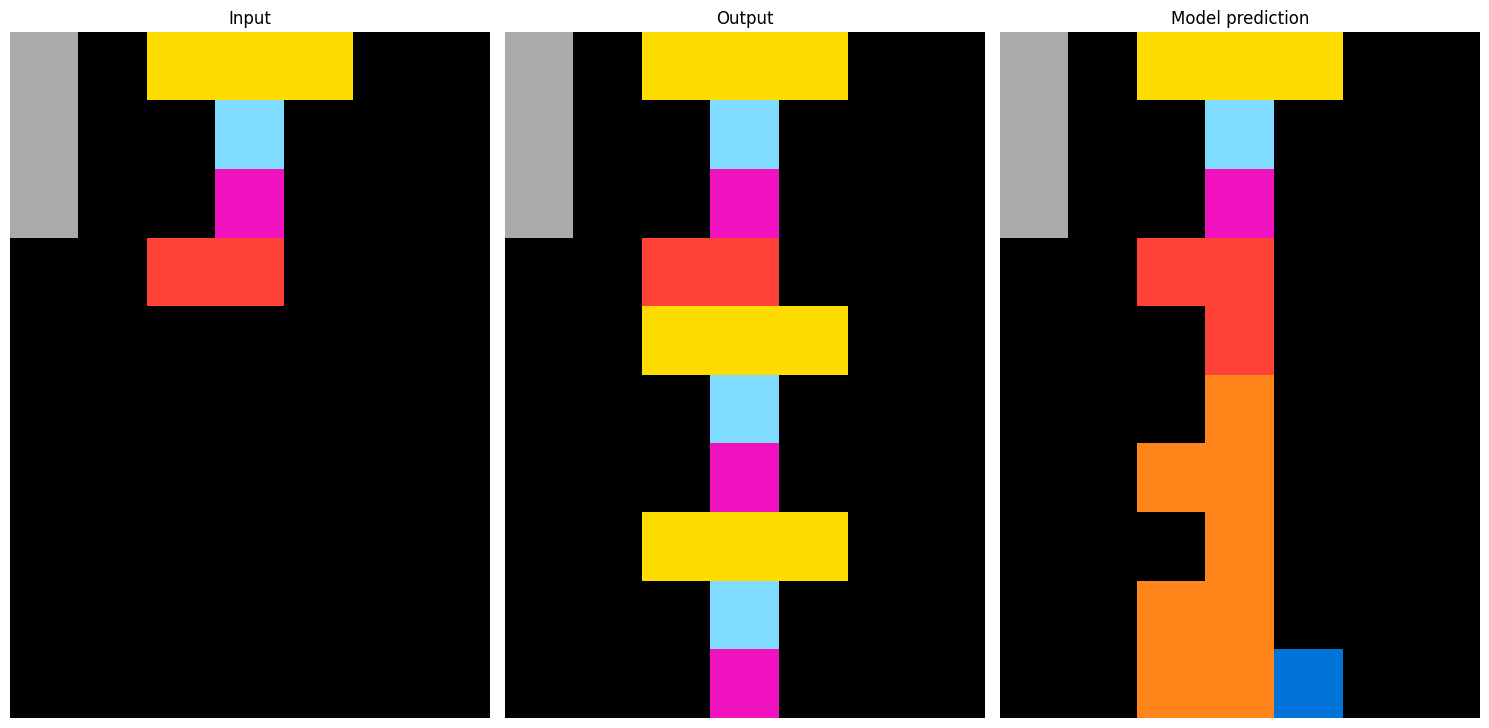

Accuracy: 0.8


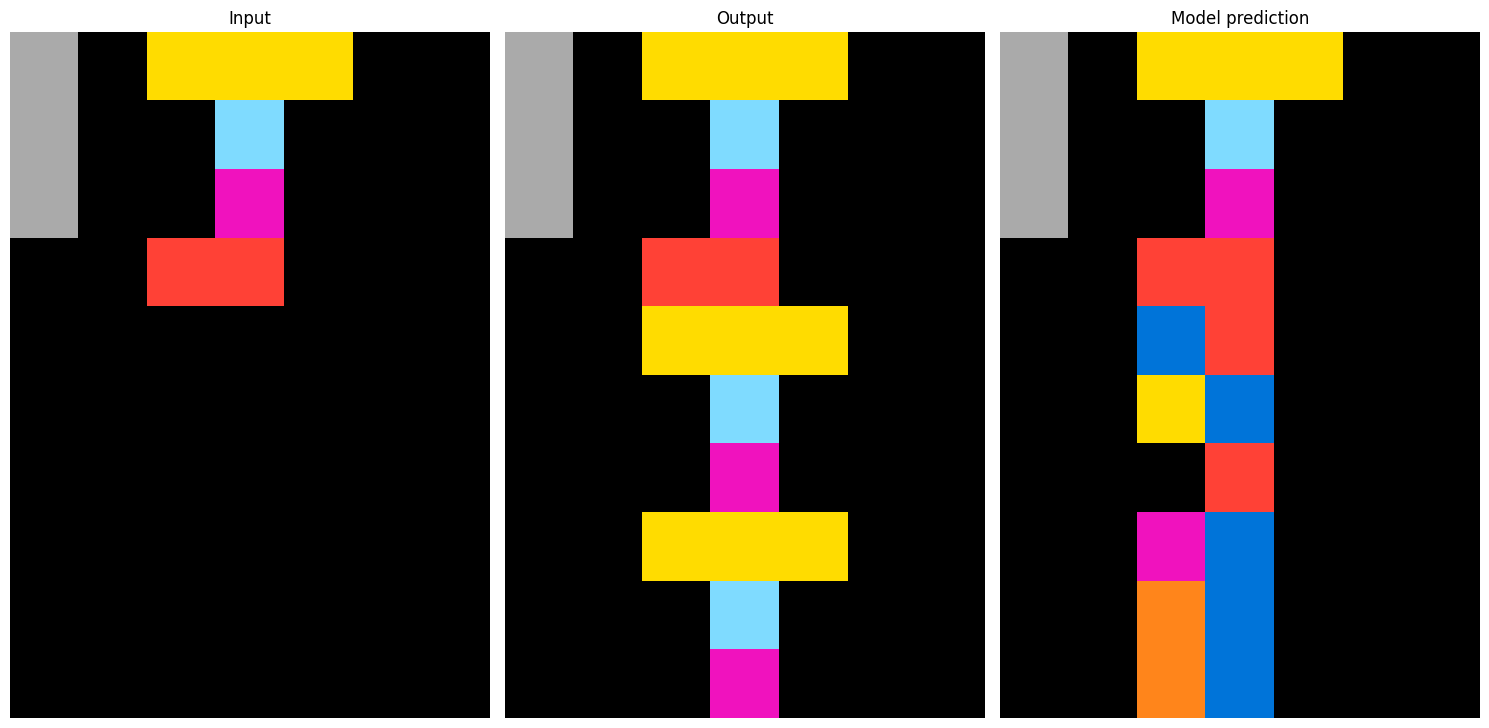

Accuracy: 0.8142857142857143


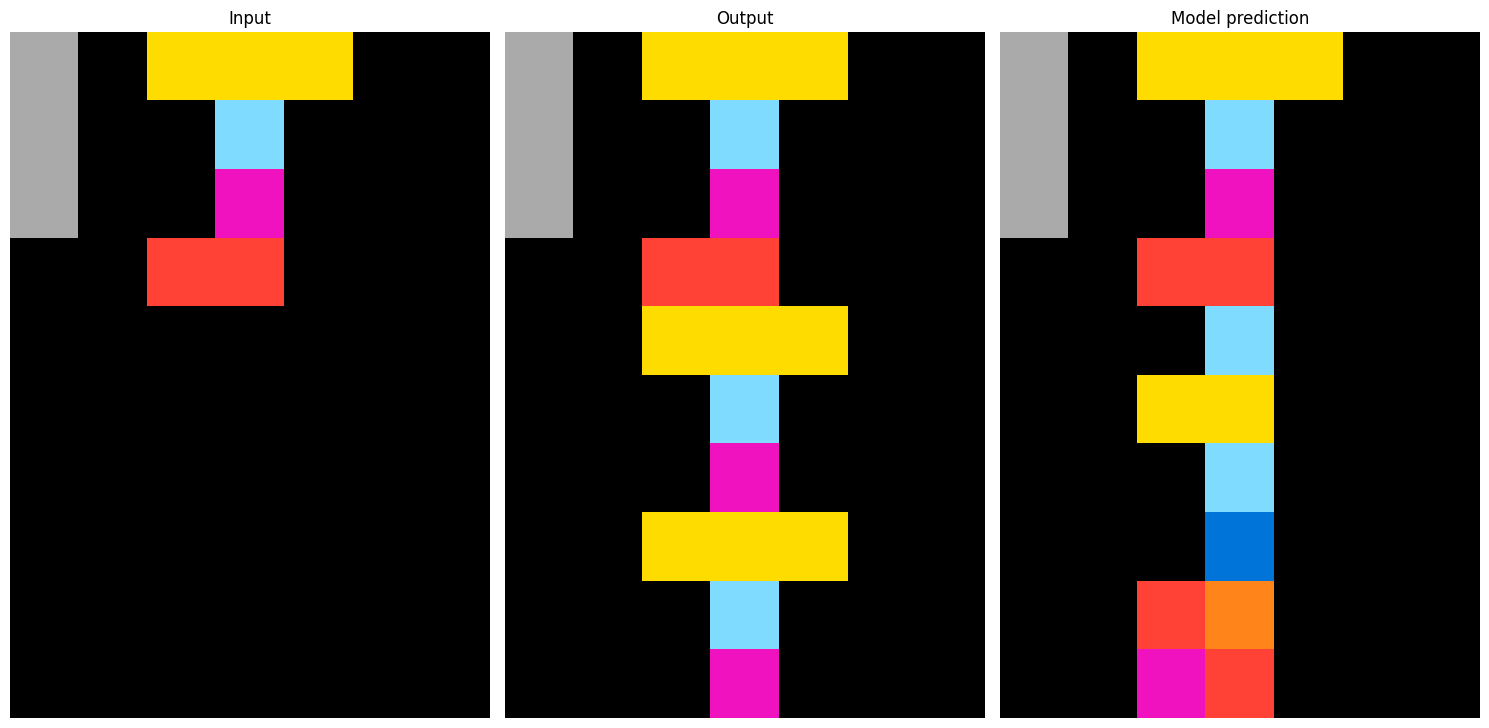

Accuracy: 0.8142857142857143
47996f11


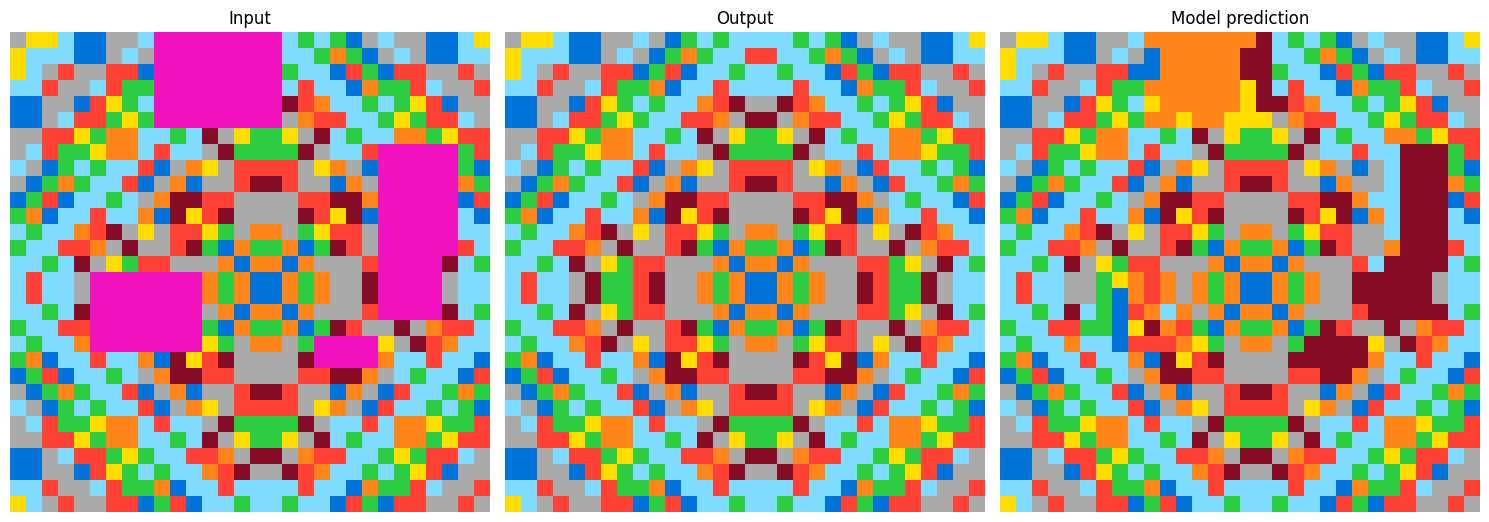

Accuracy: 0.8655555555555555


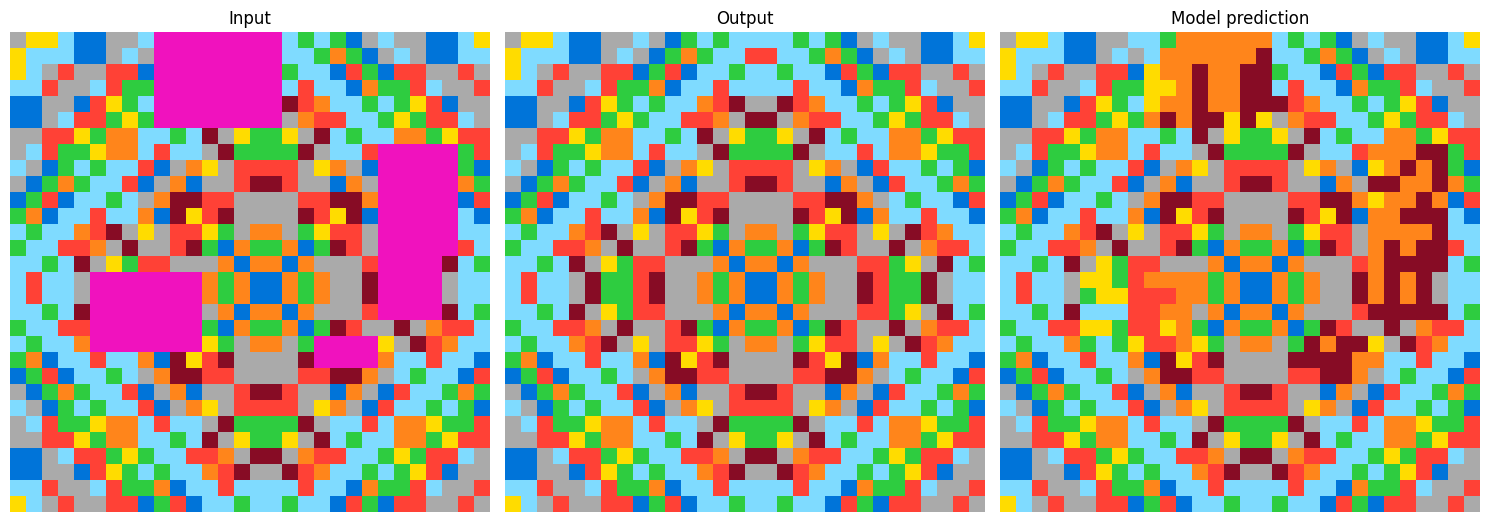

Accuracy: 0.86


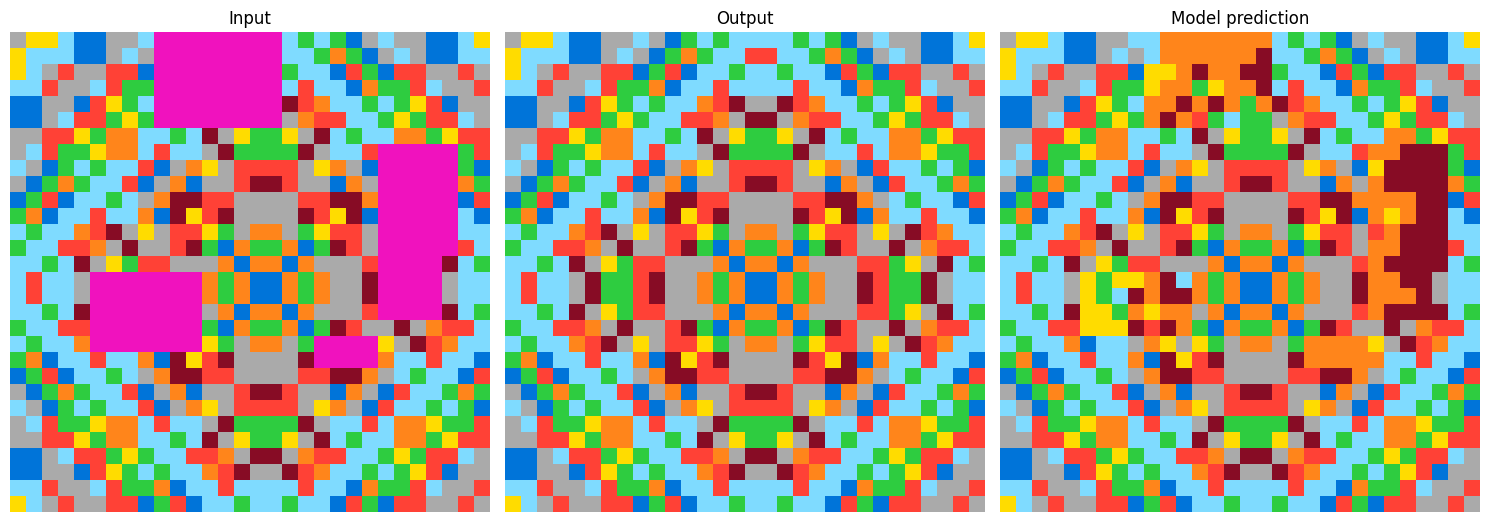

Accuracy: 0.8555555555555555
73c3b0d8


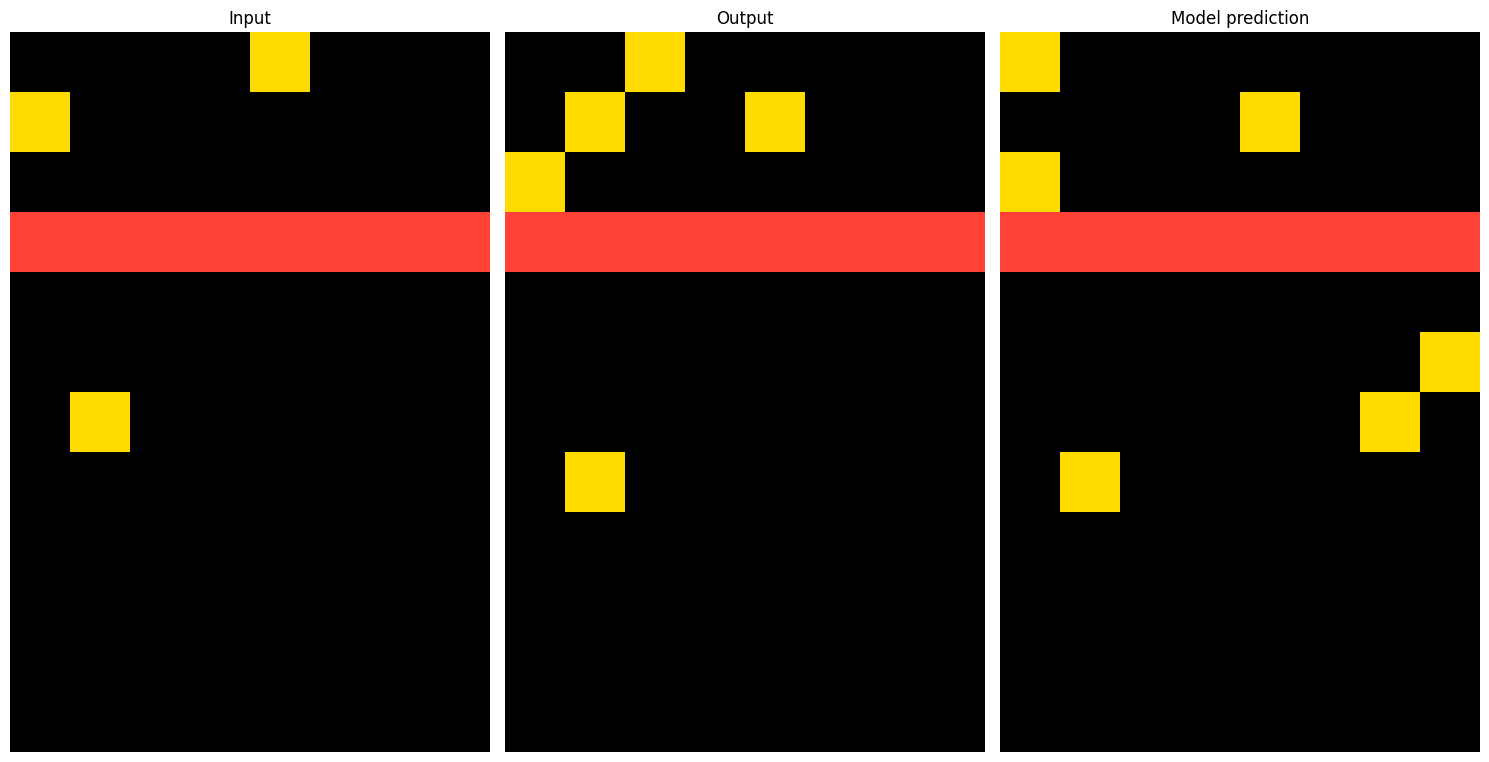

Accuracy: 0.9479166666666666


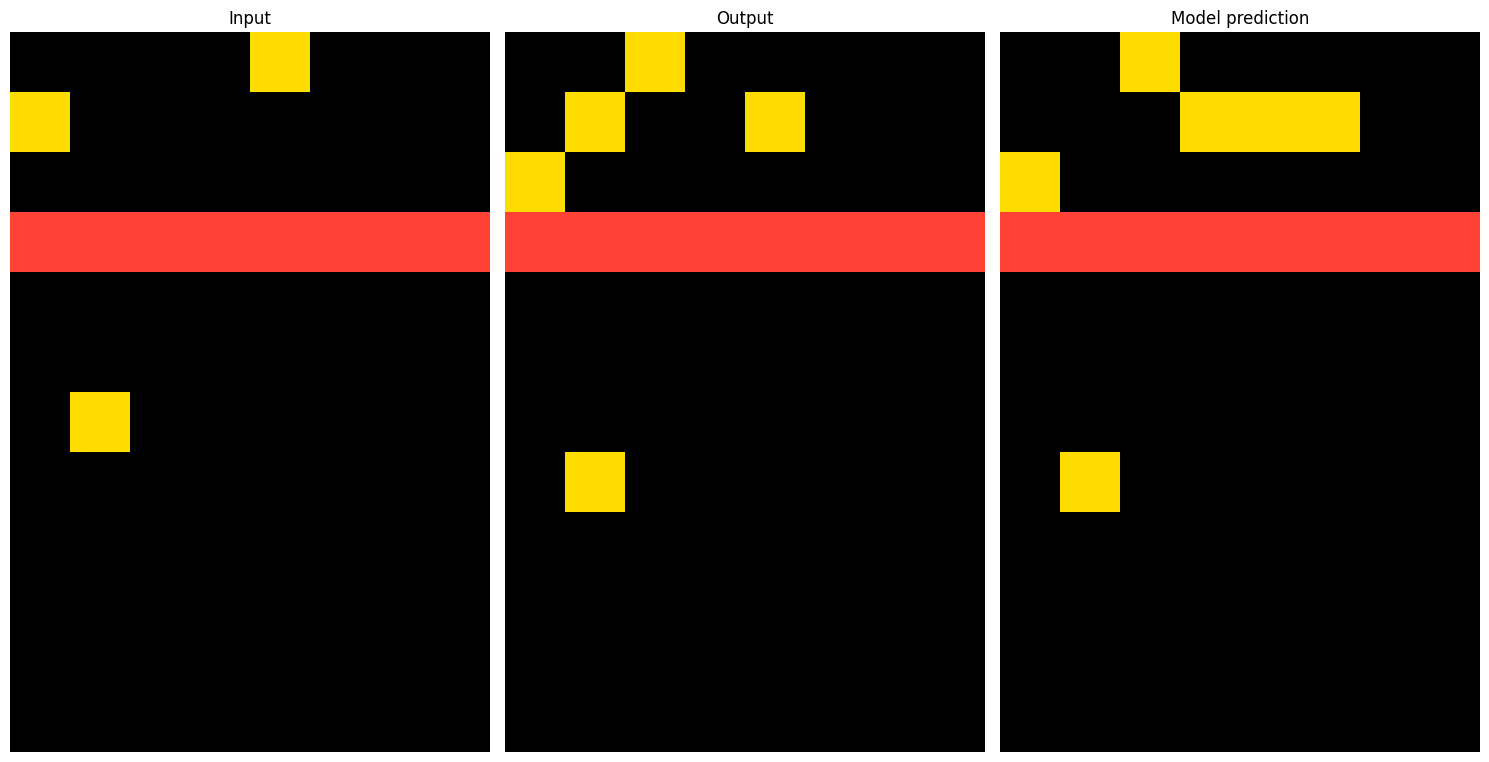

Accuracy: 0.96875


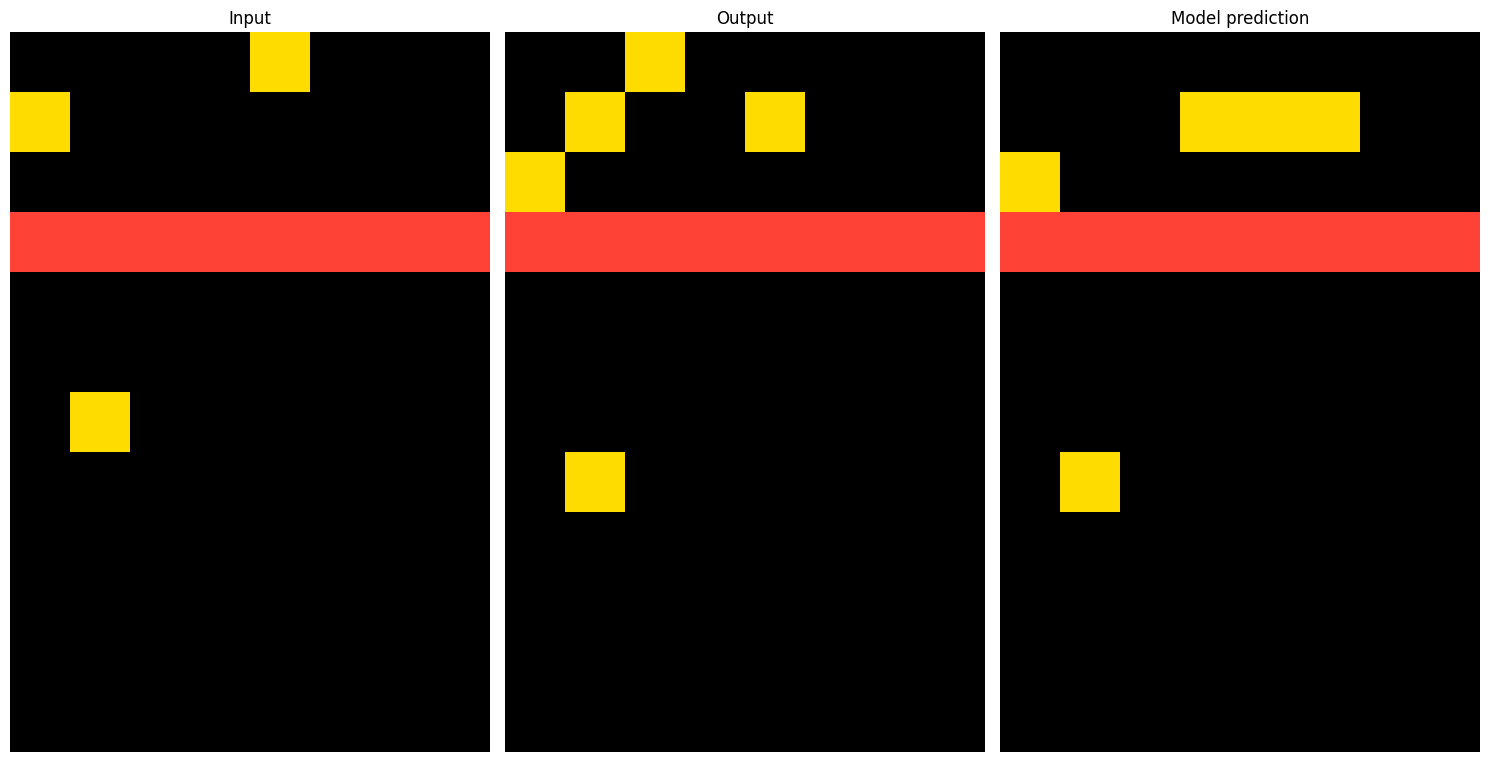

Accuracy: 0.9583333333333334
137f0df0


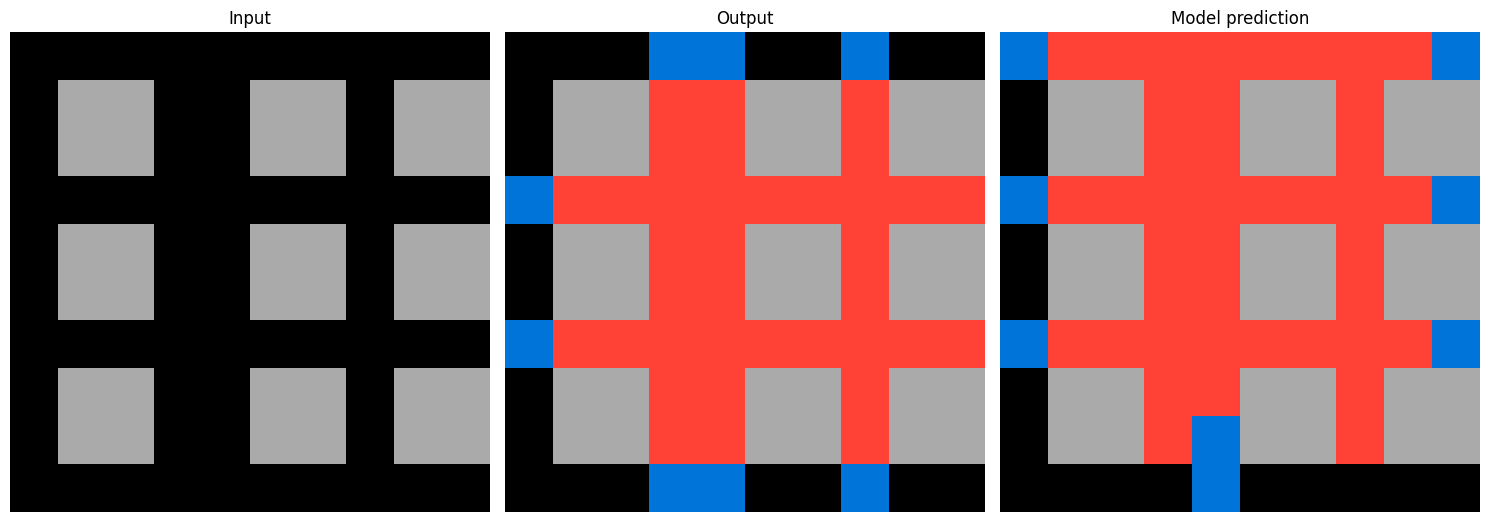

Accuracy: 0.85


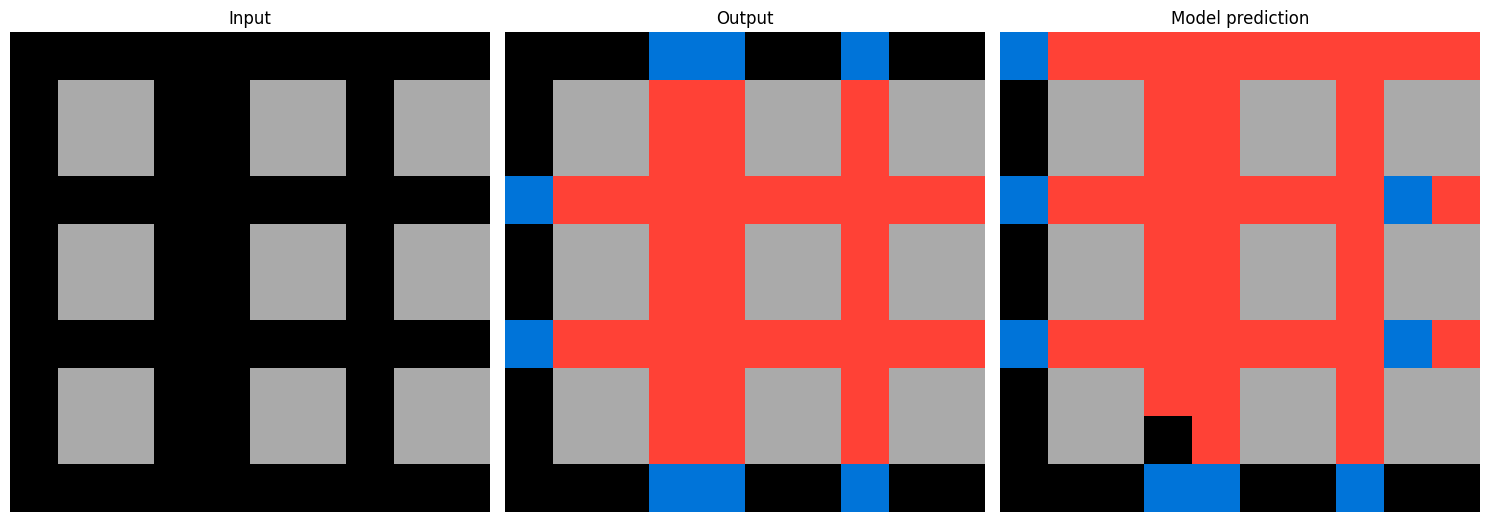

Accuracy: 0.87


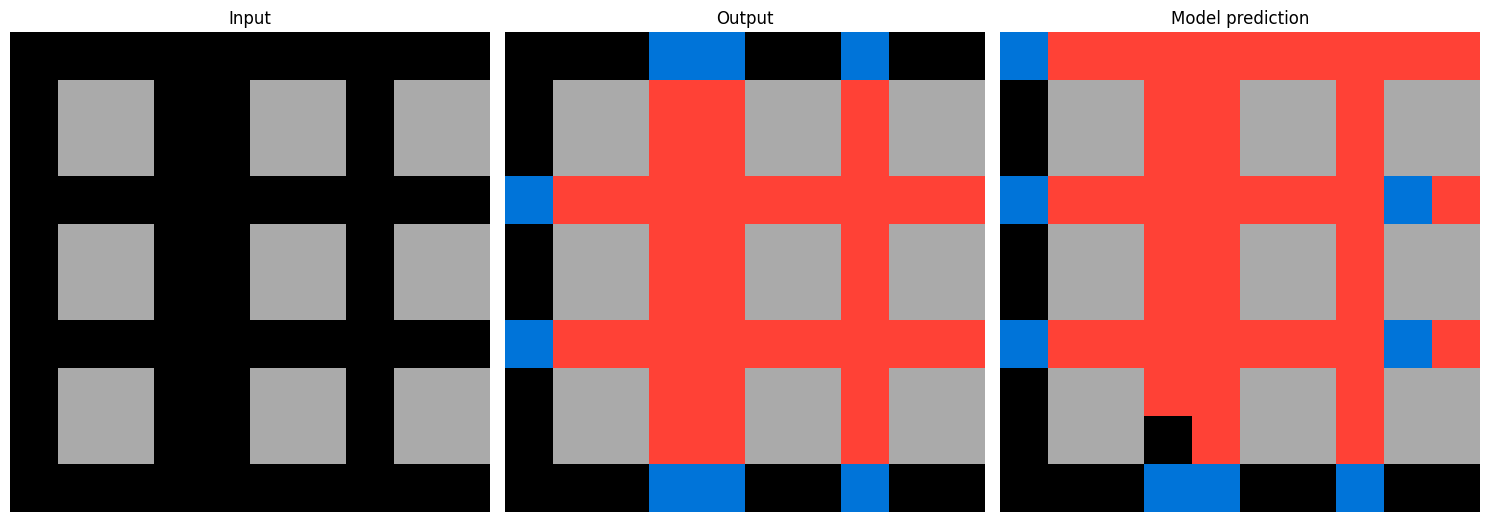

Accuracy: 0.87
94133066
ed98d772
fea12743


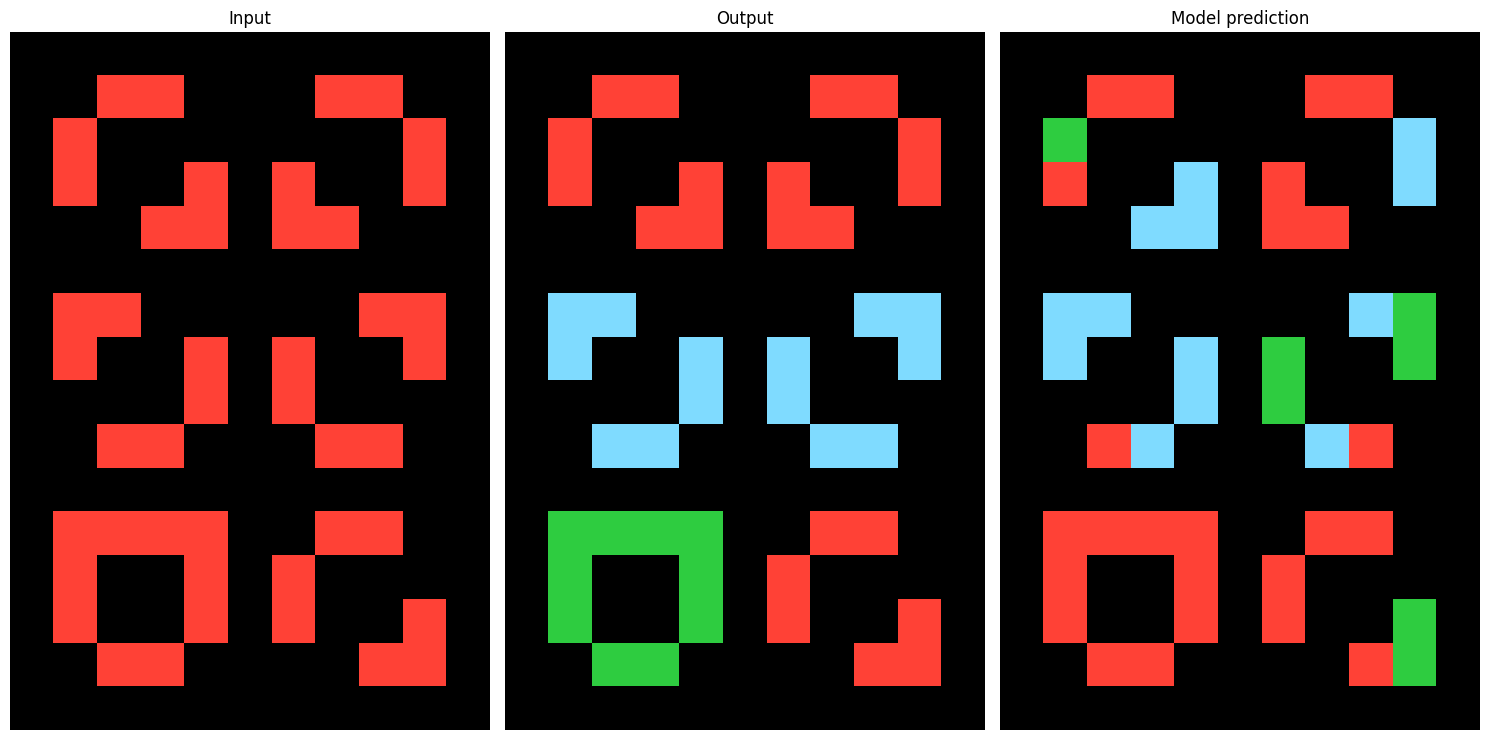

Accuracy: 0.8636363636363636


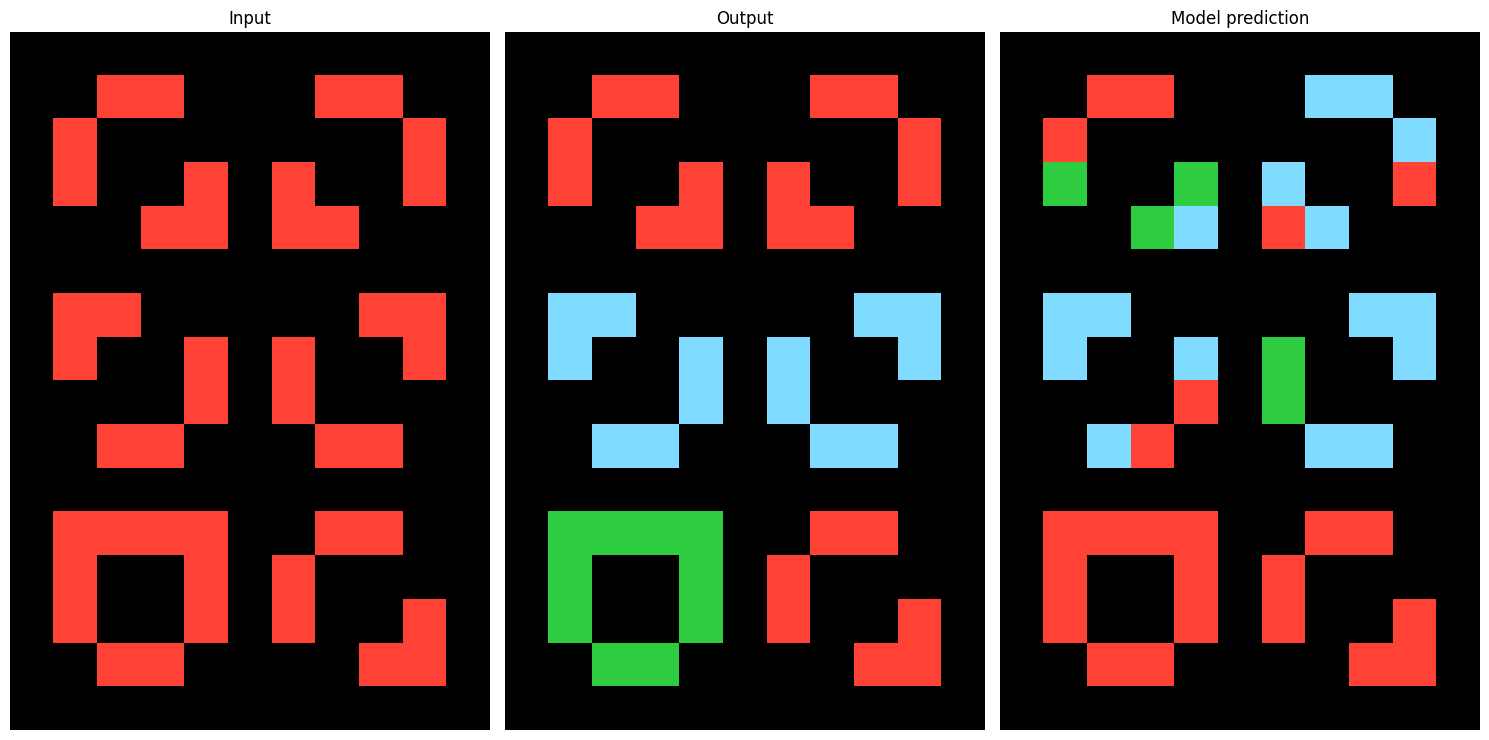

Accuracy: 0.8693181818181818


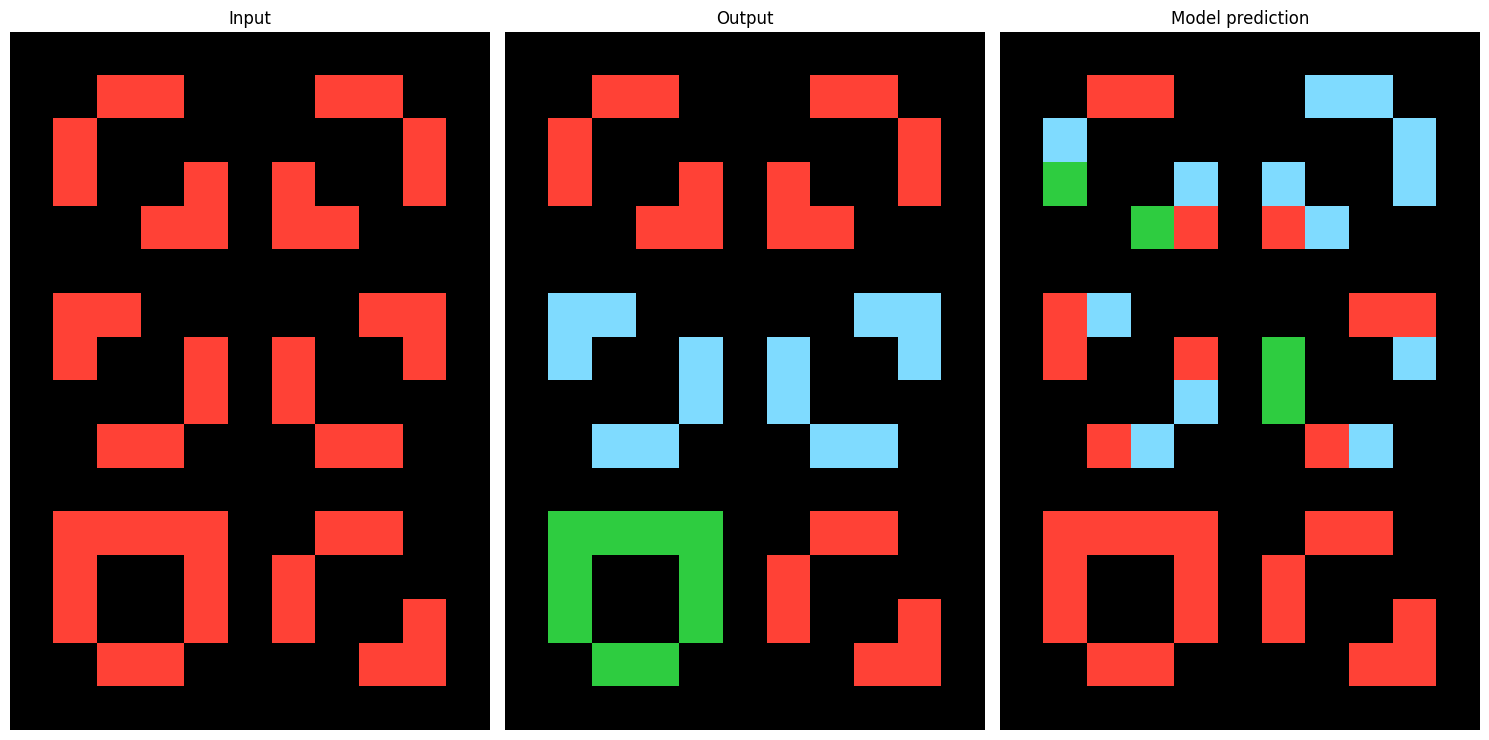

Accuracy: 0.8352272727272727
e69241bd


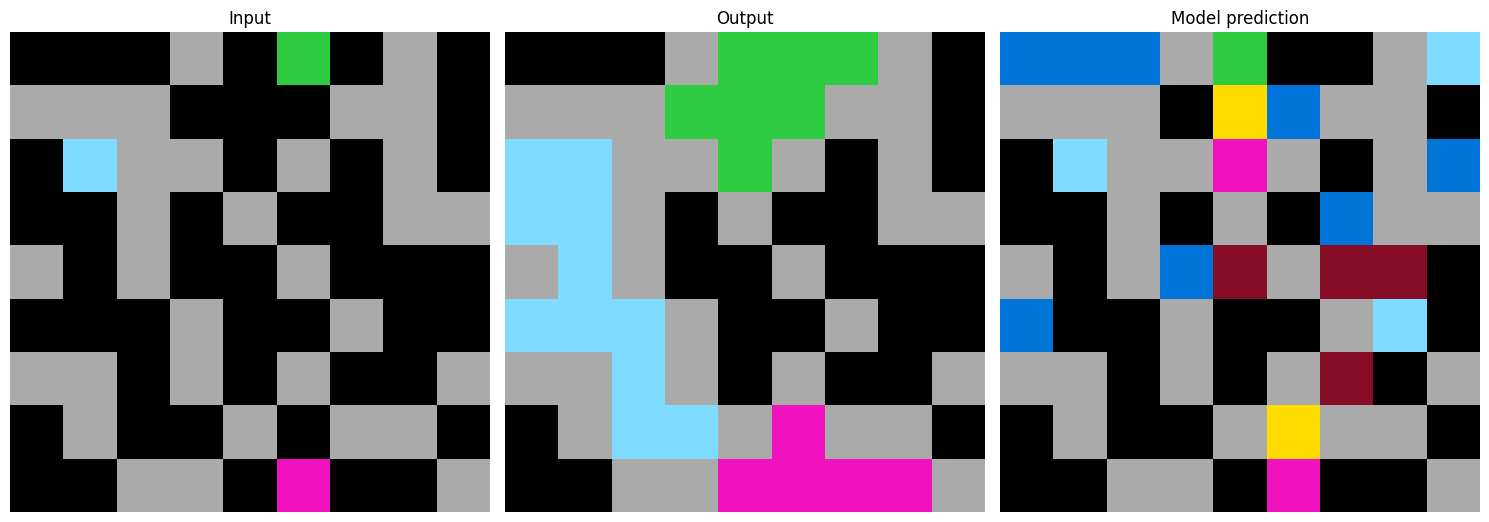

Accuracy: 0.6049382716049383


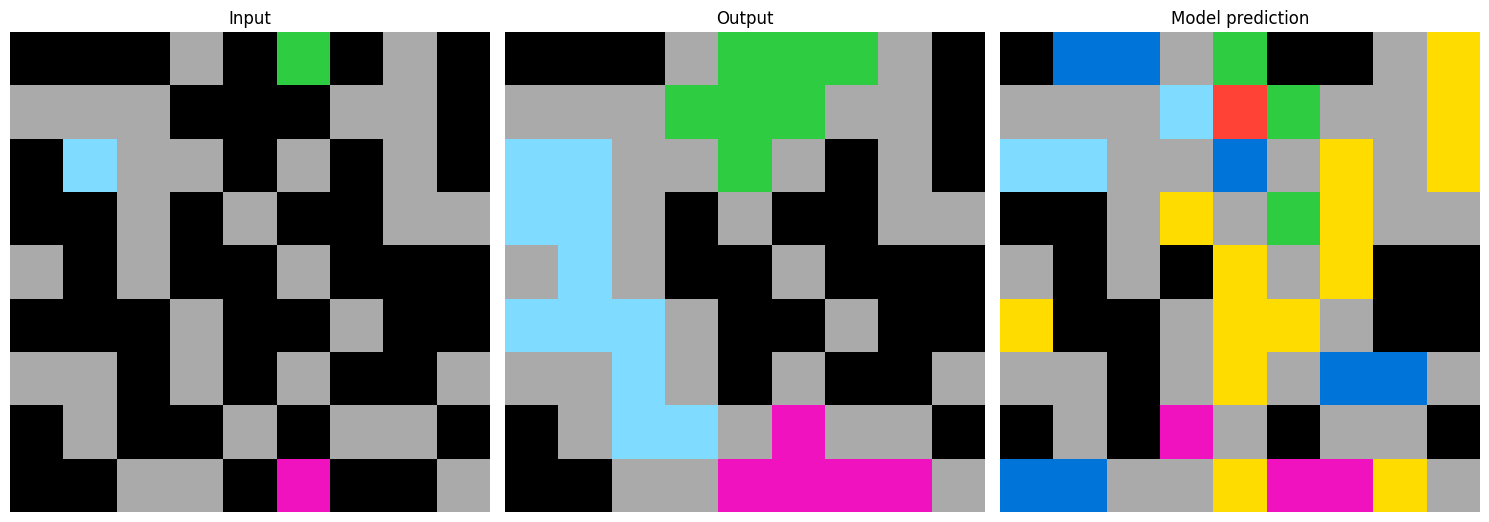

Accuracy: 0.5679012345679012


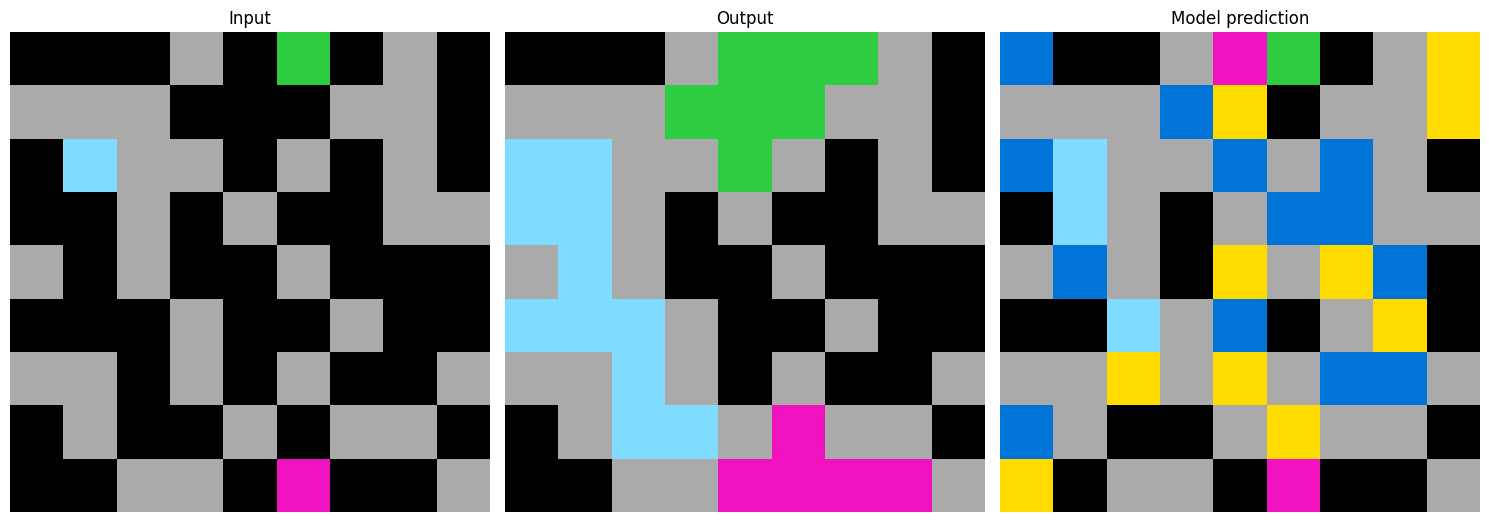

Accuracy: 0.5802469135802469
64a7c07e


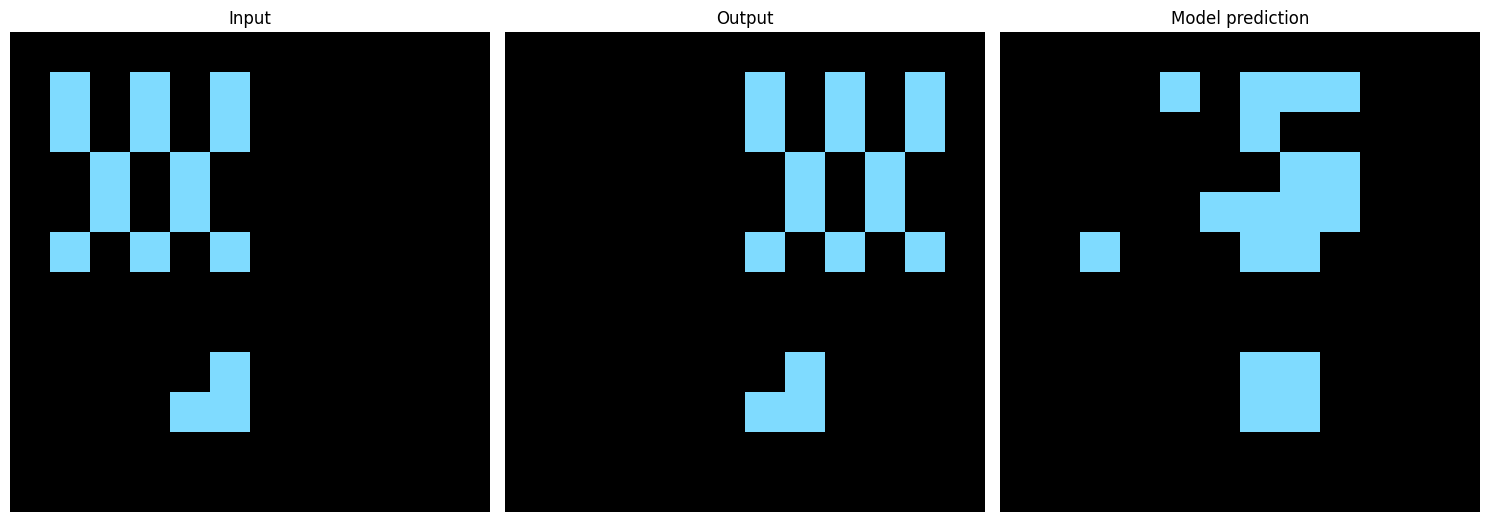

Accuracy: 0.8888888888888888


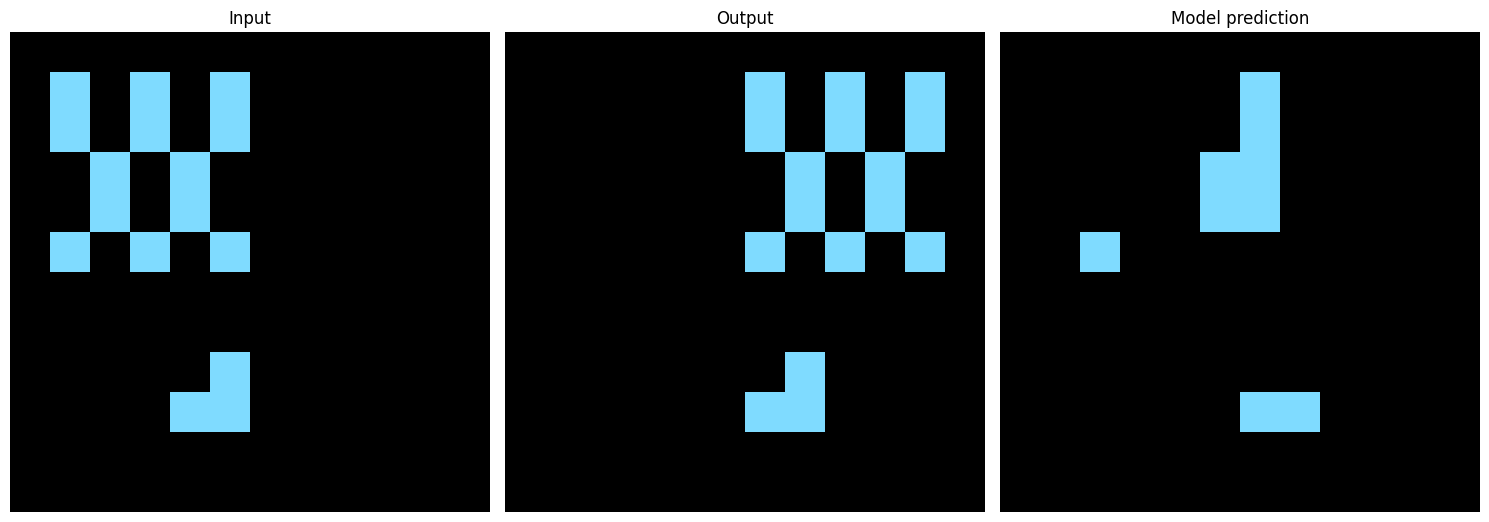

Accuracy: 0.8819444444444444


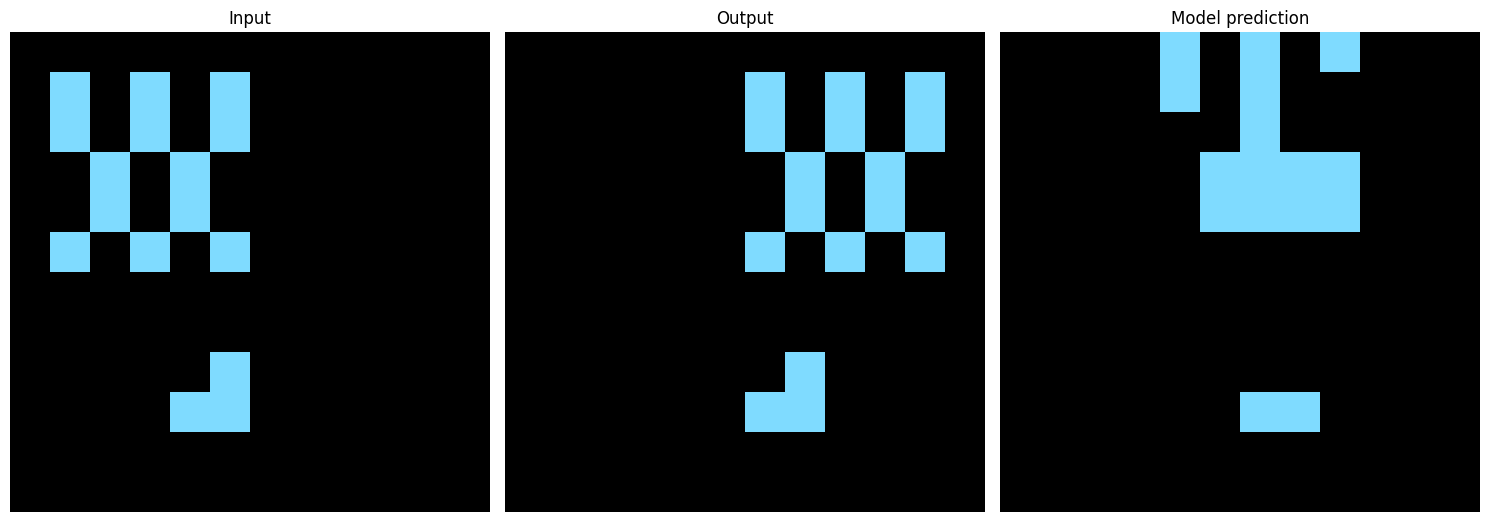

Accuracy: 0.8611111111111112
7d419a02


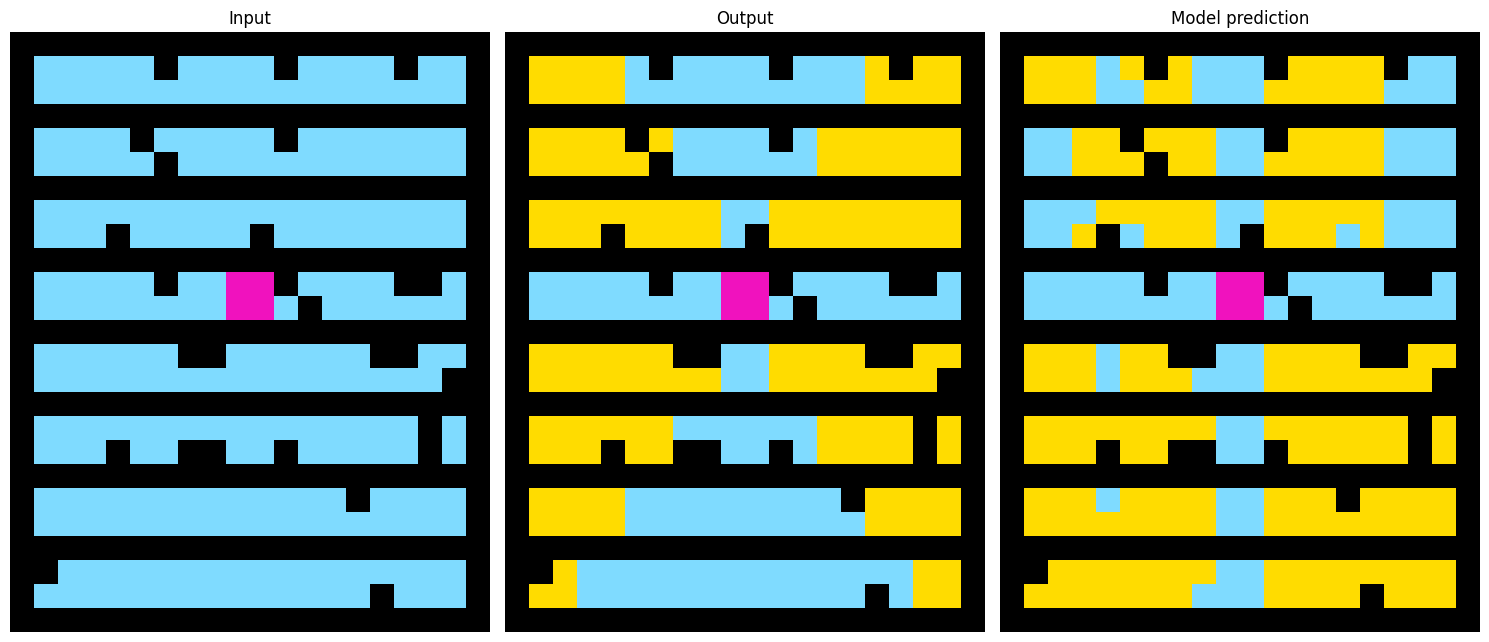

Accuracy: 0.812


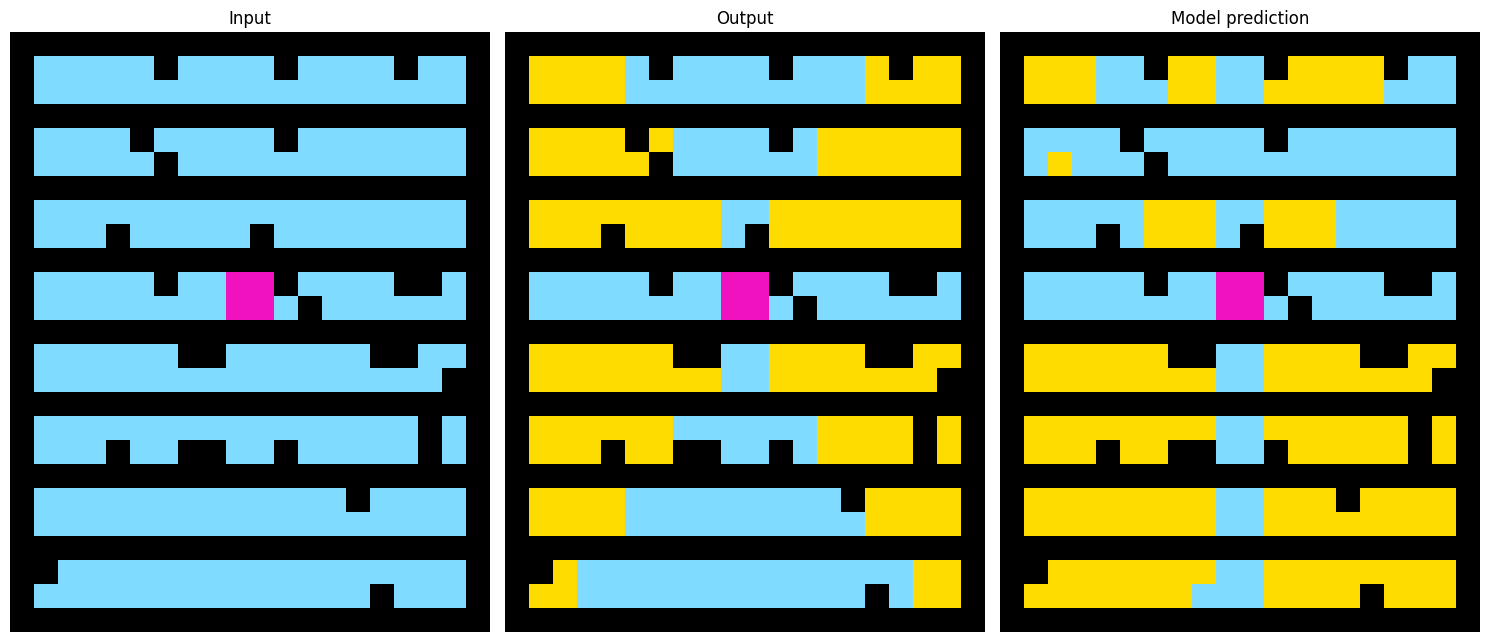

Accuracy: 0.8


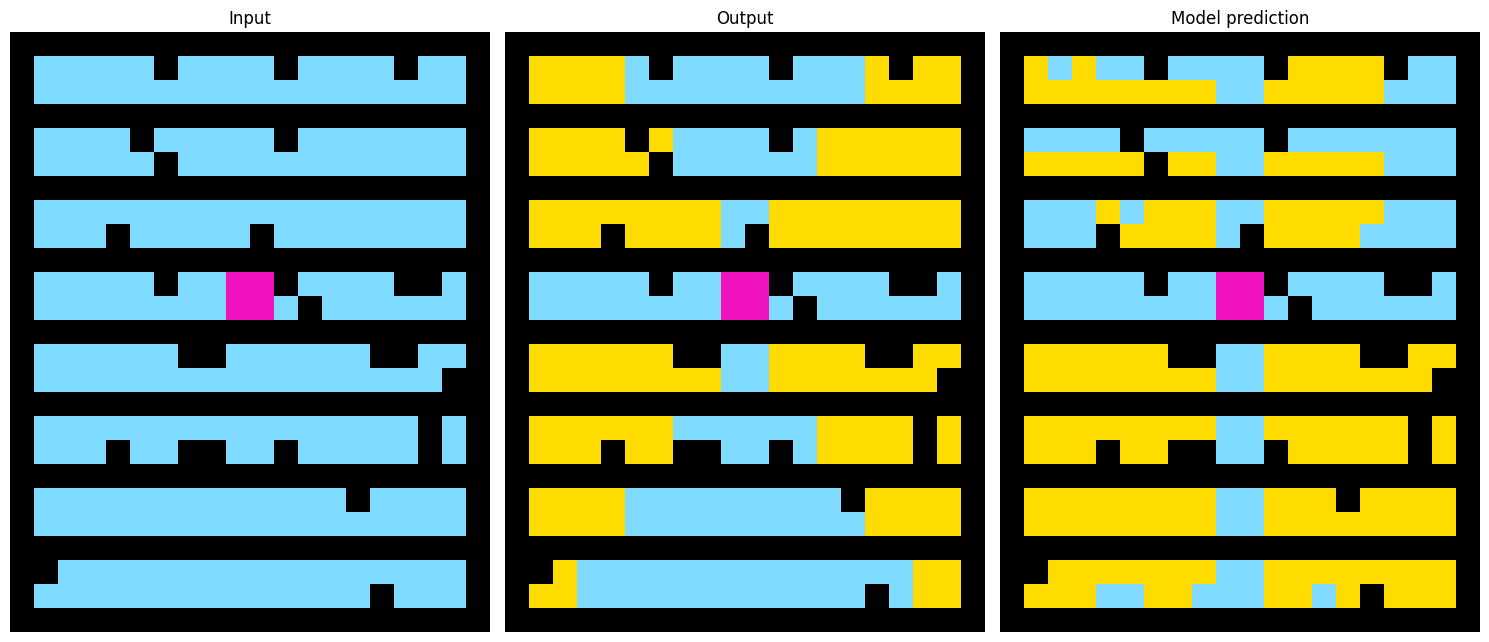

Accuracy: 0.822
9772c176


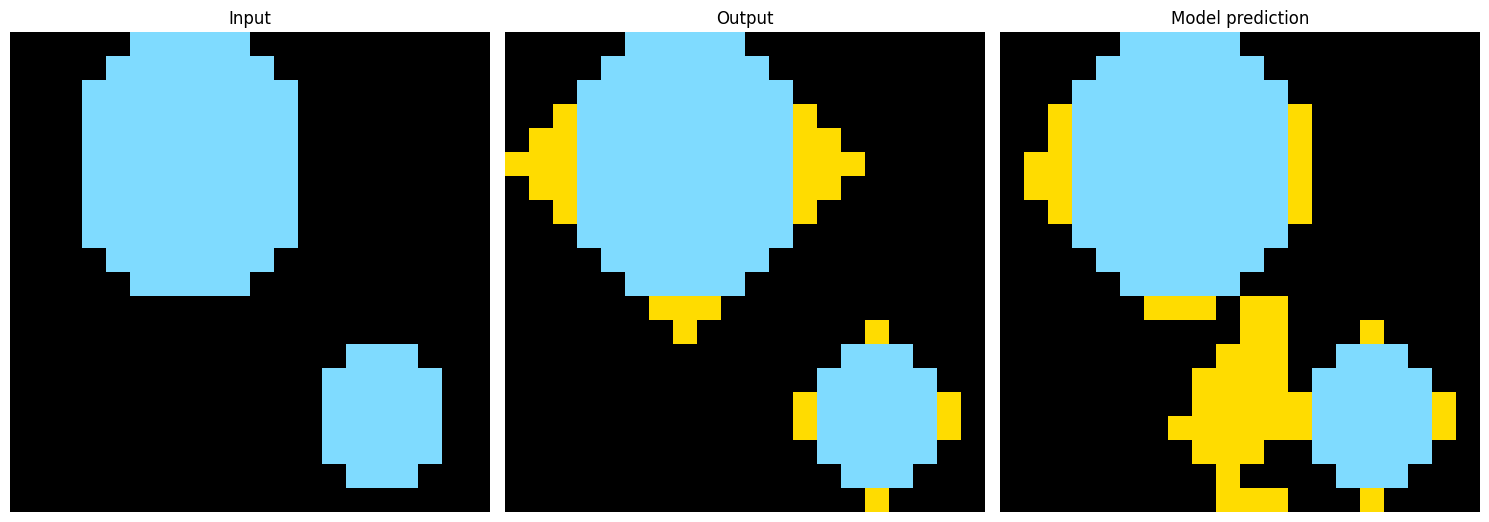

Accuracy: 0.915


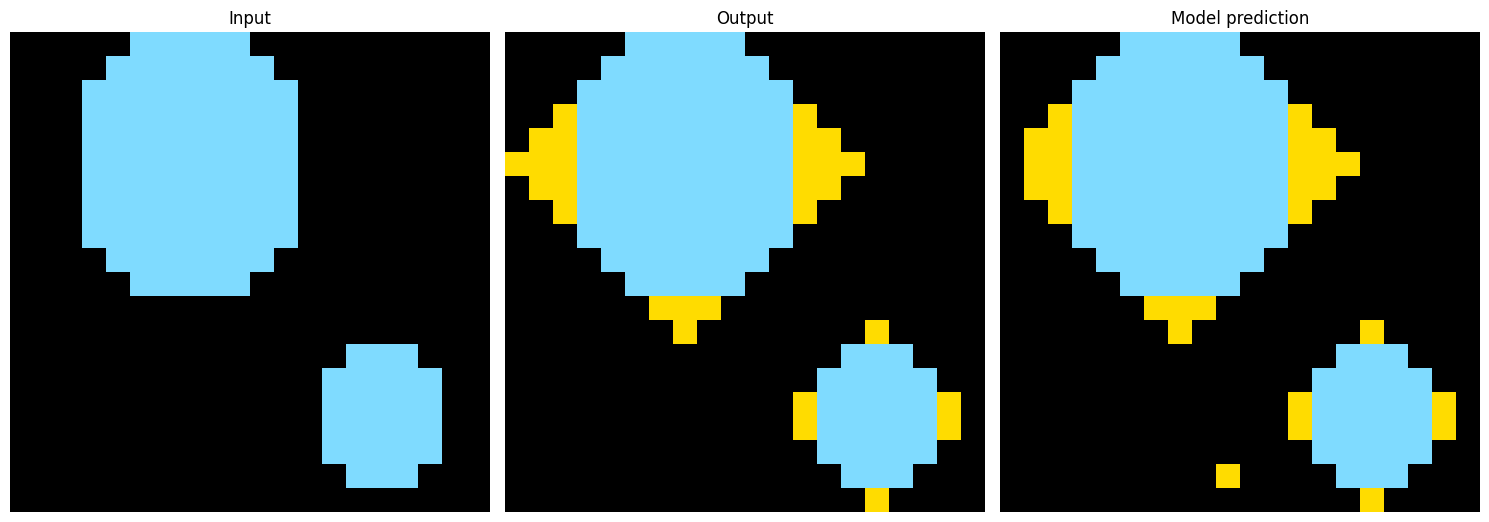

Accuracy: 0.995


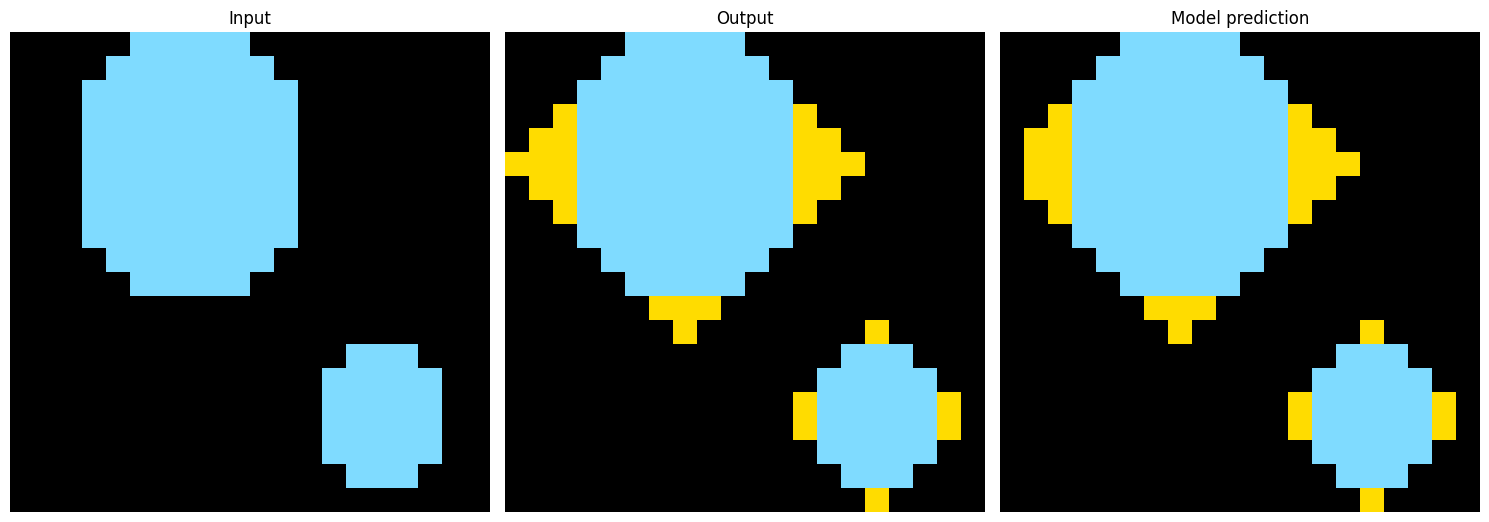

Accuracy: 0.9975
b457fec5


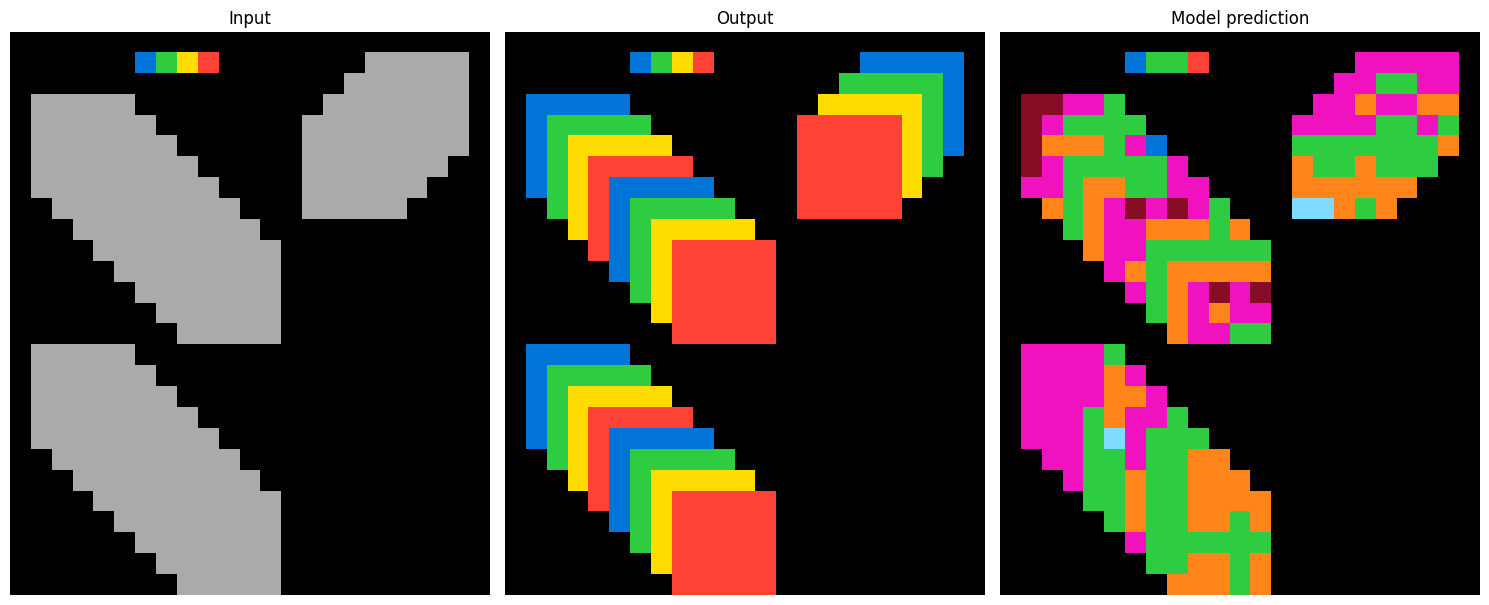

Accuracy: 0.6489533011272142


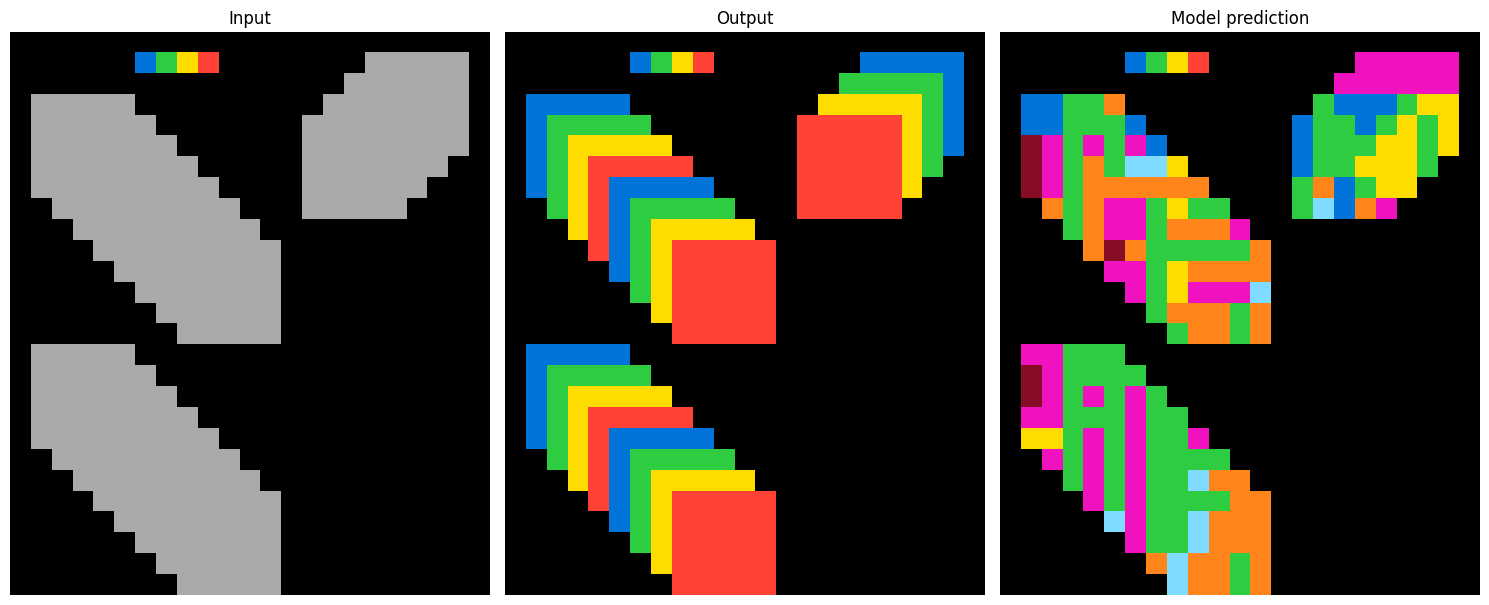

Accuracy: 0.6714975845410628


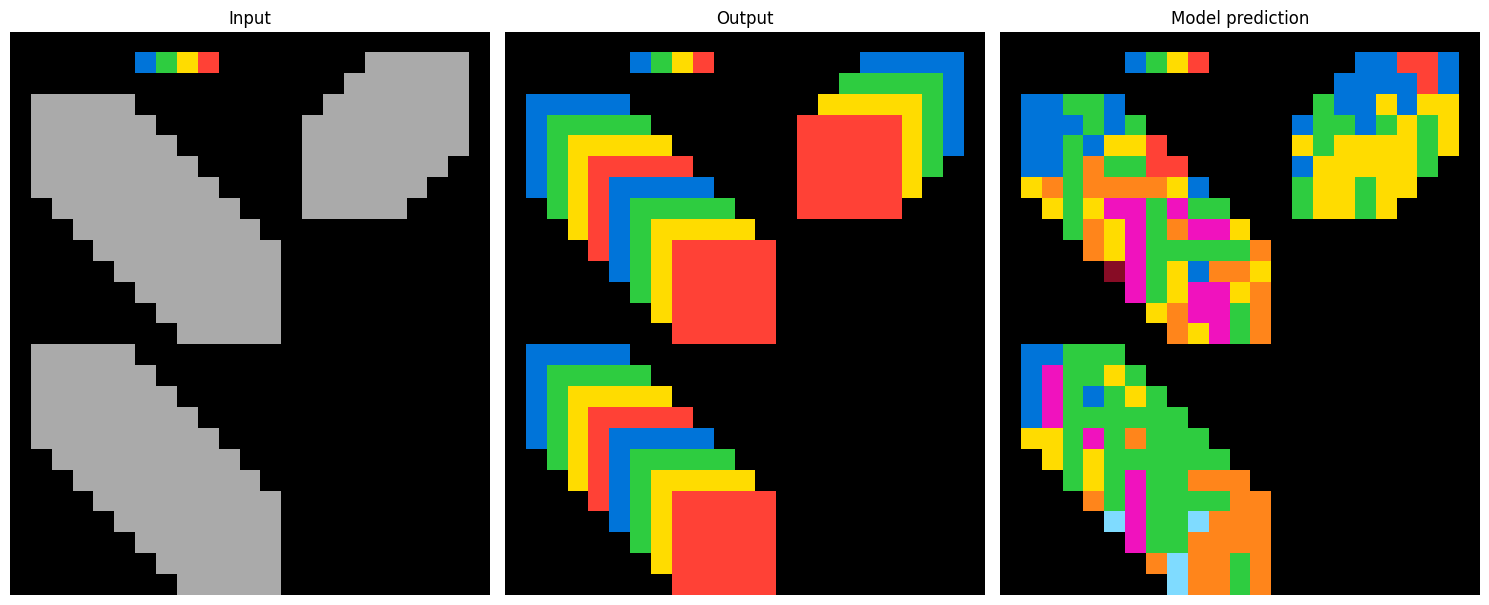

Accuracy: 0.7037037037037037
310f3251
c92b942c
140c817e


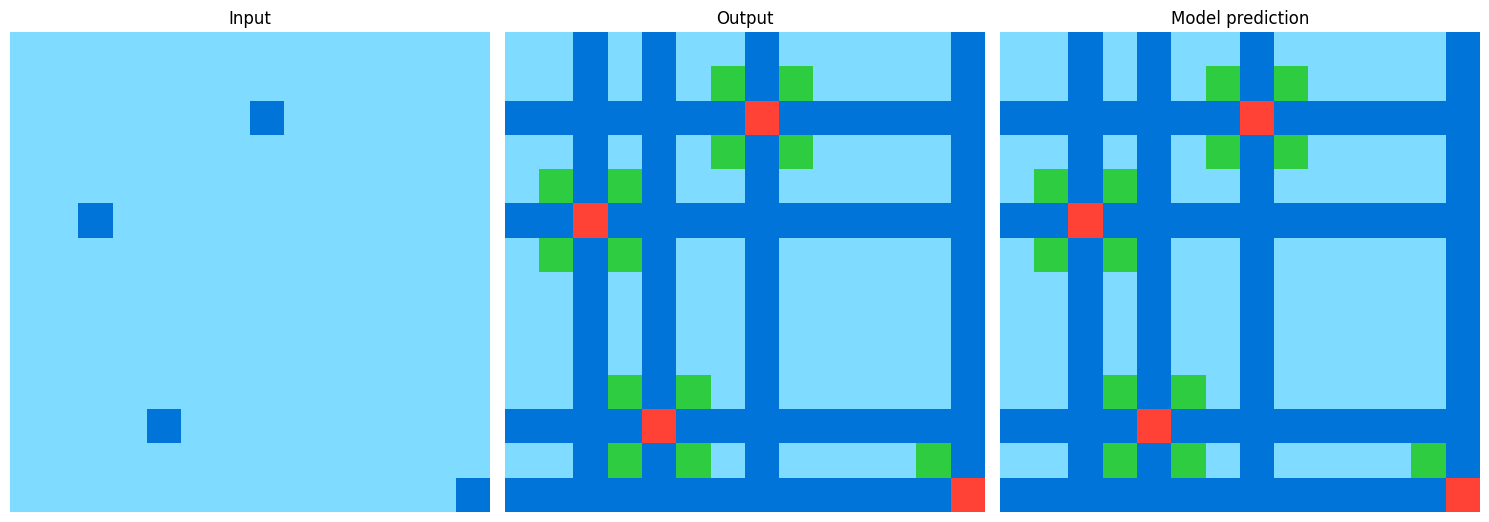

Accuracy: 1.0


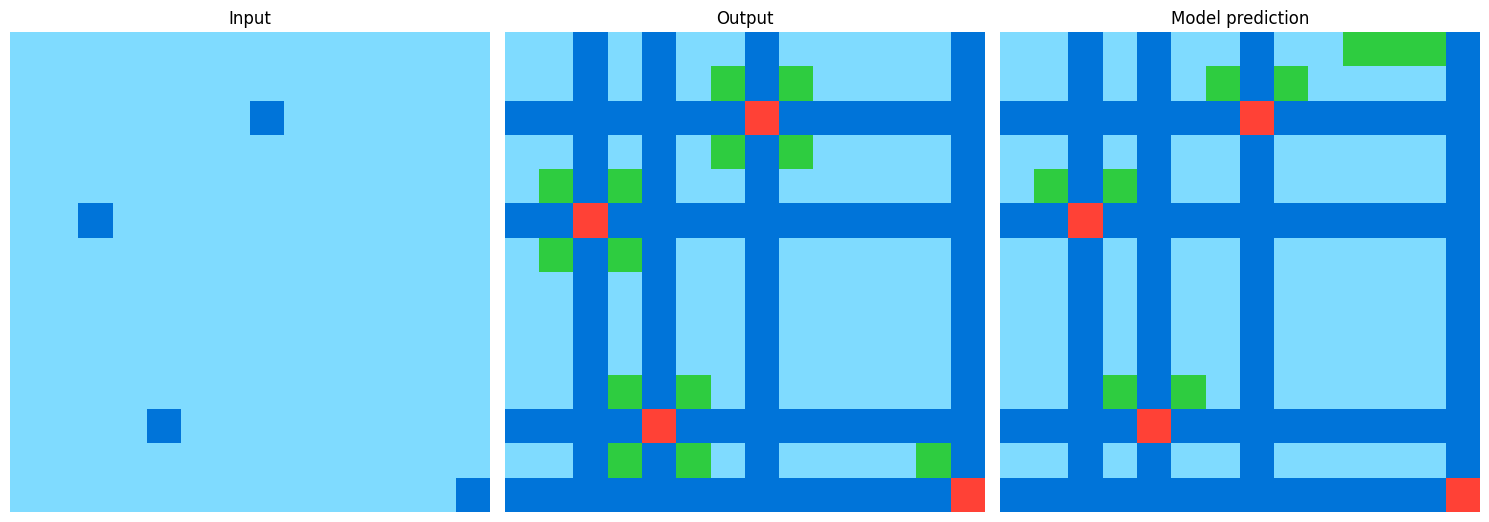

Accuracy: 0.9489795918367347


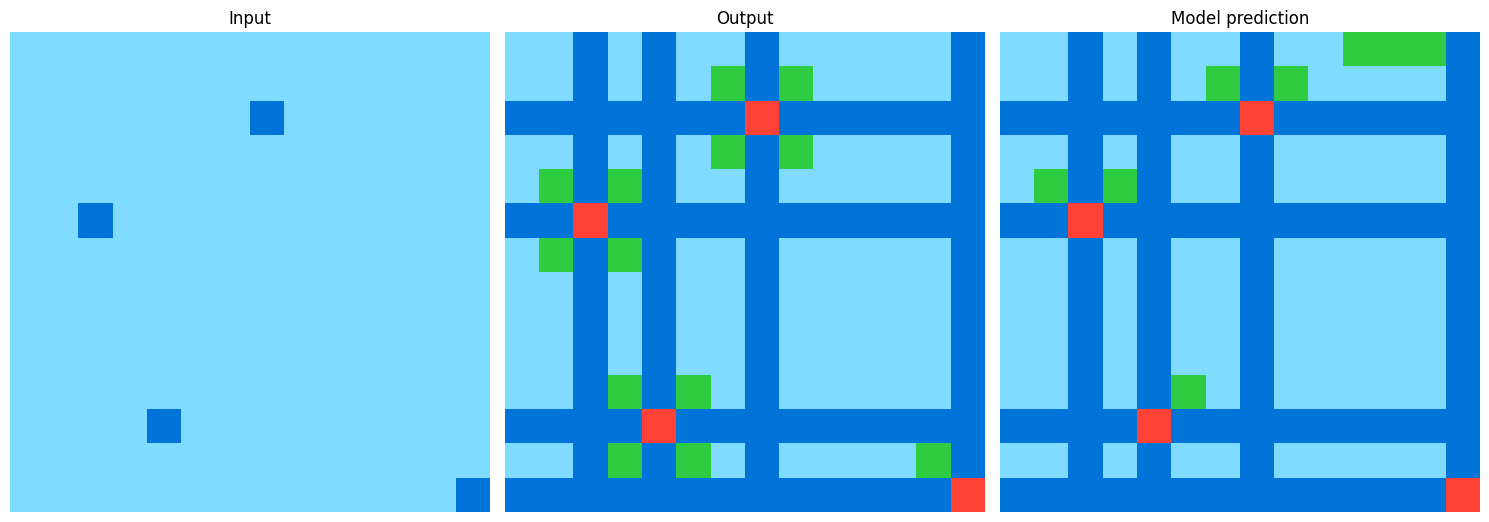

Accuracy: 0.9438775510204082
b7999b51
ac3e2b04


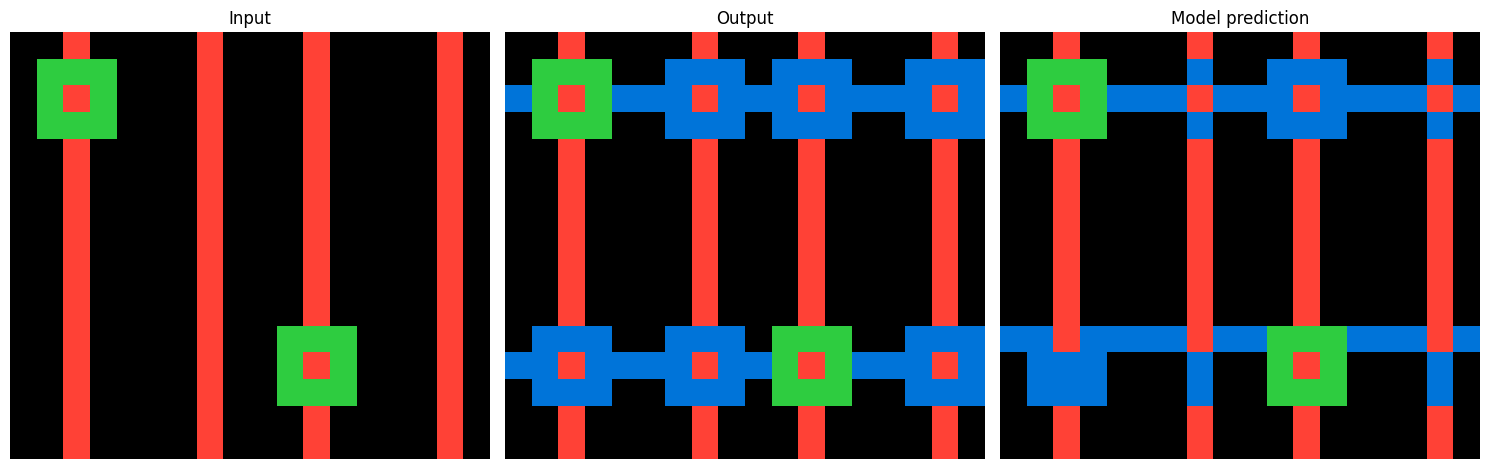

Accuracy: 0.8819444444444444


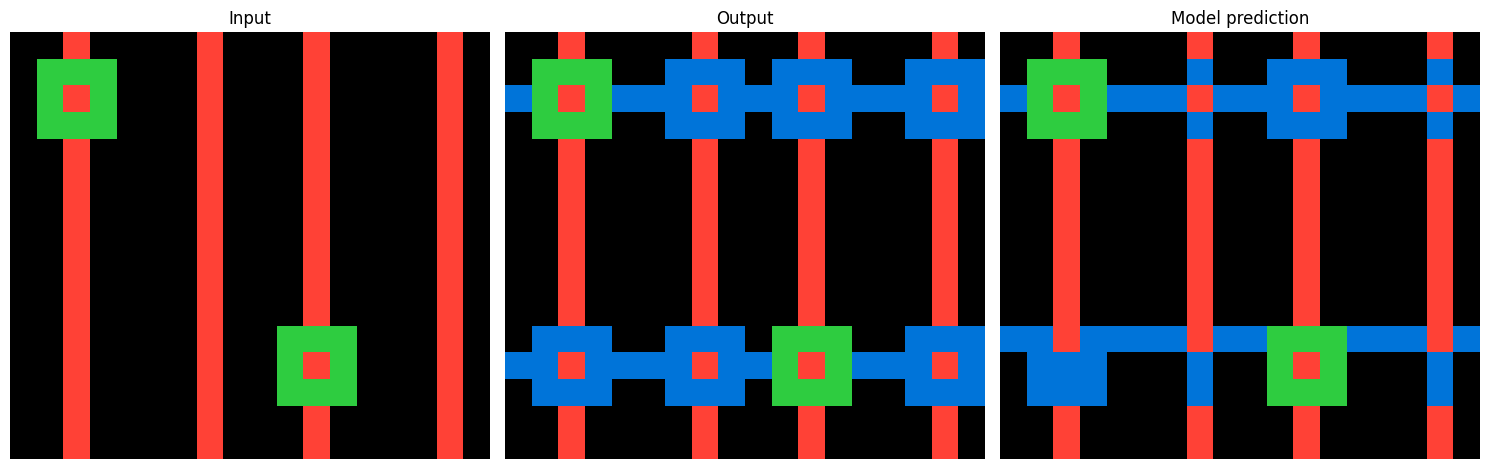

Accuracy: 0.8819444444444444


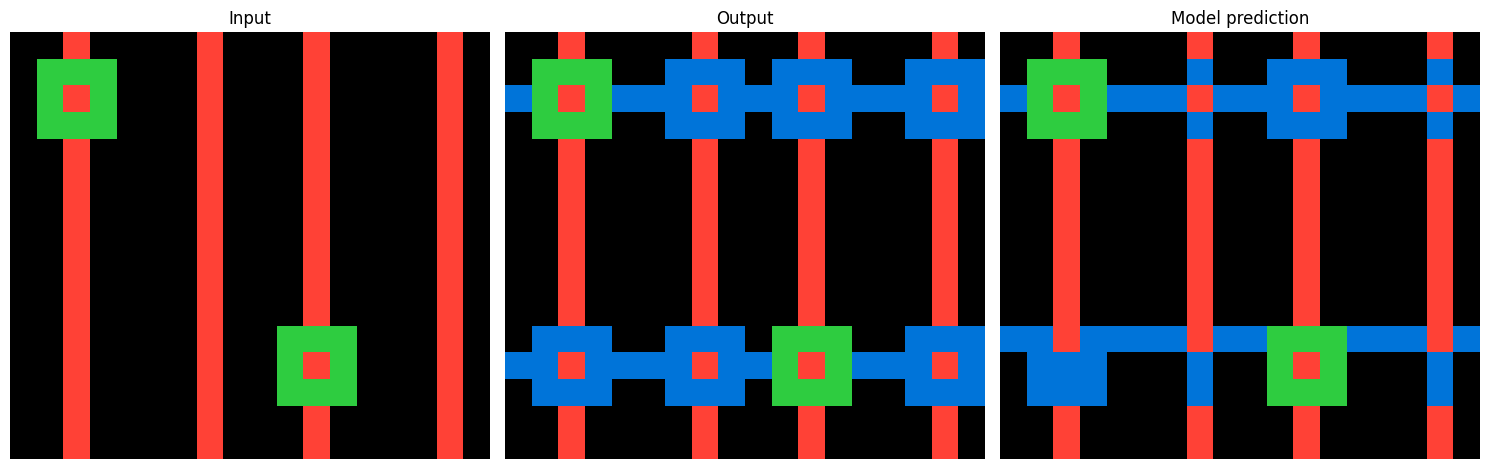

Accuracy: 0.8819444444444444
3d31c5b3
2546ccf6


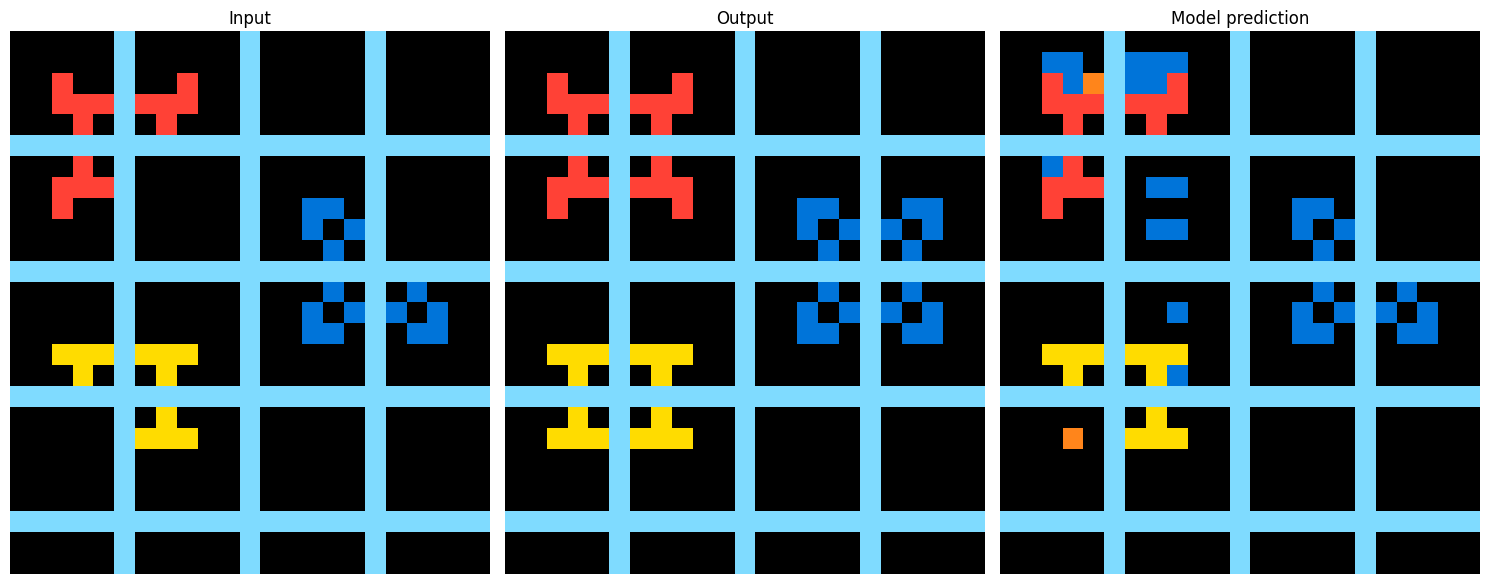

Accuracy: 0.9531772575250836


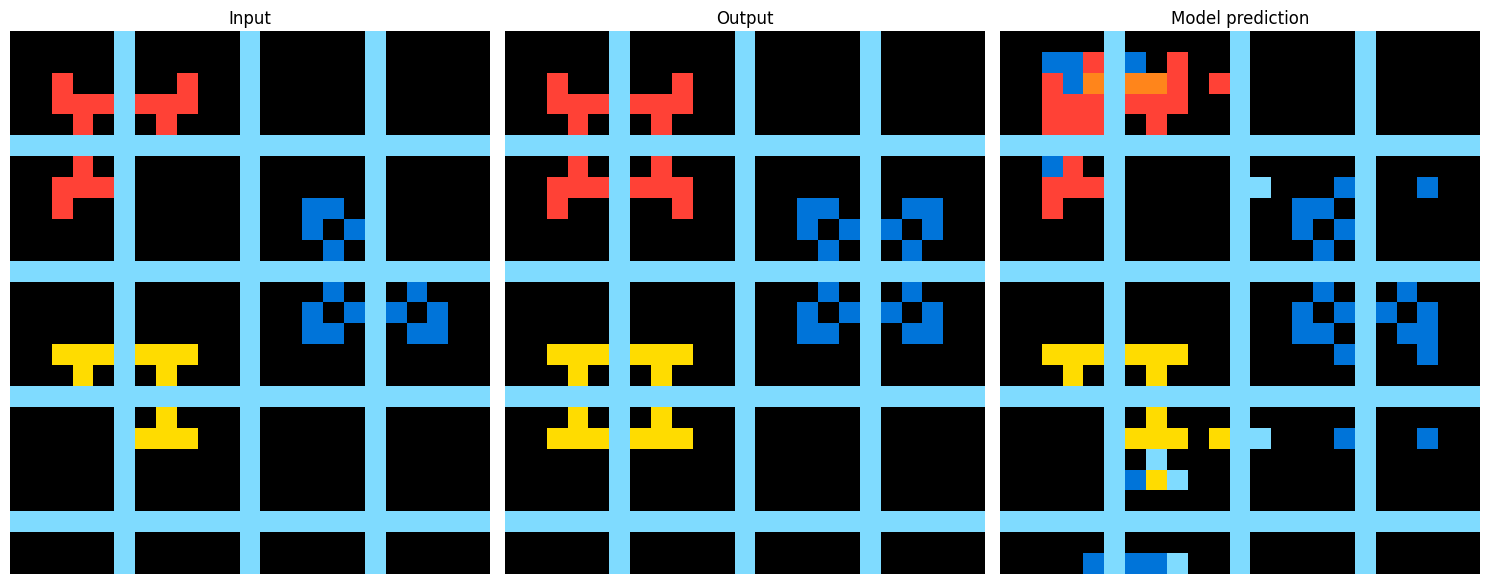

Accuracy: 0.9264214046822743


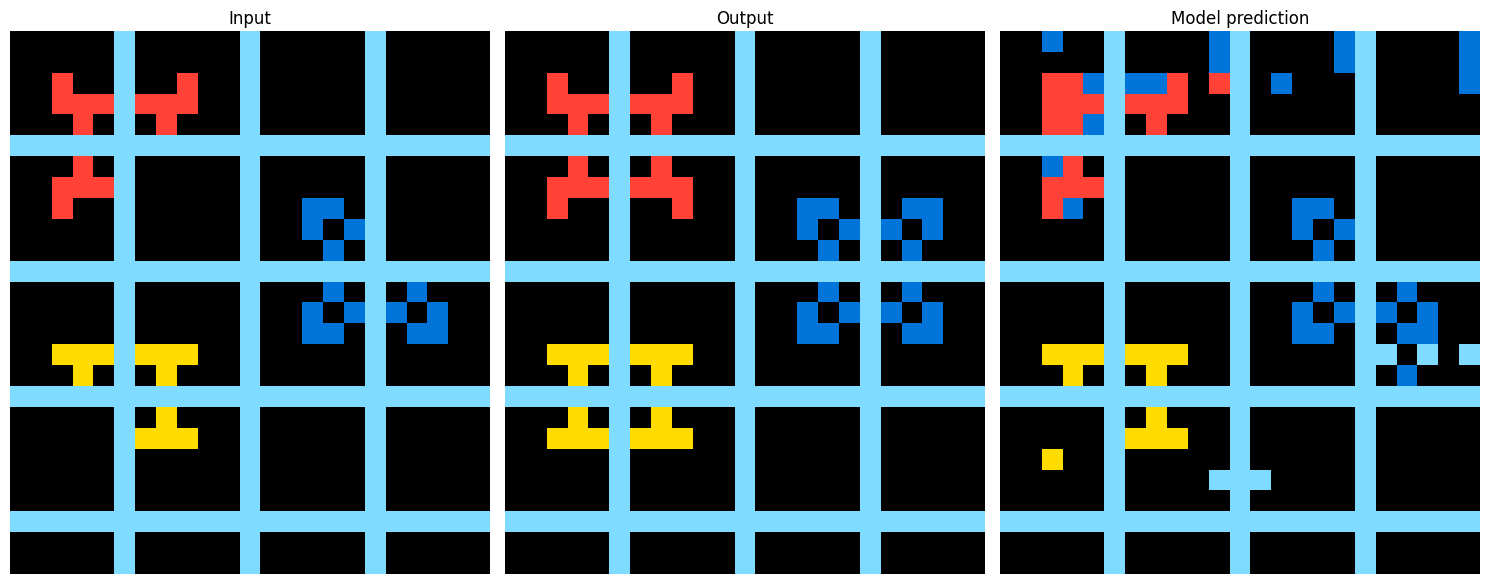

Accuracy: 0.9347826086956522
626c0bcc


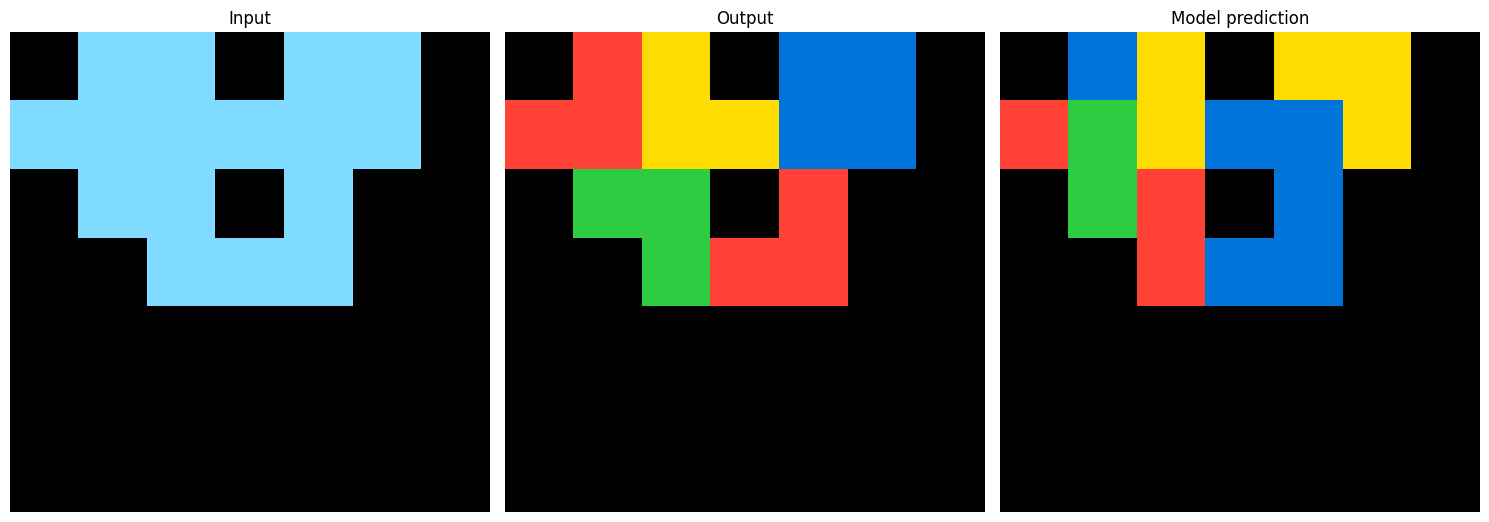

Accuracy: 0.7755102040816326


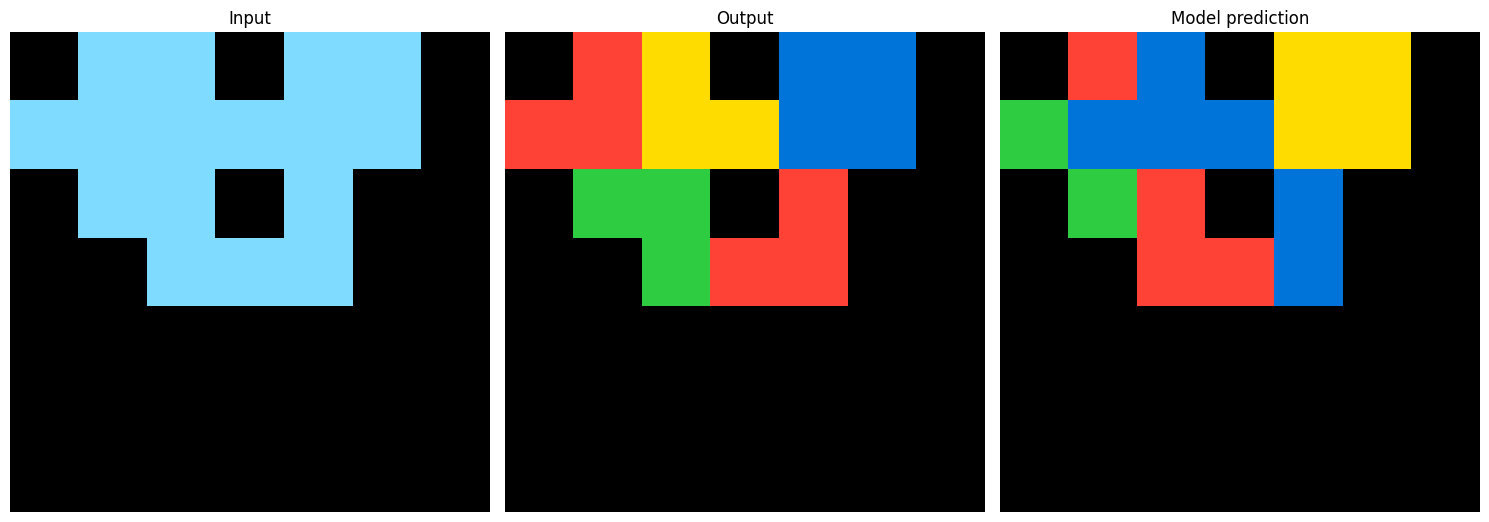

Accuracy: 0.7346938775510204


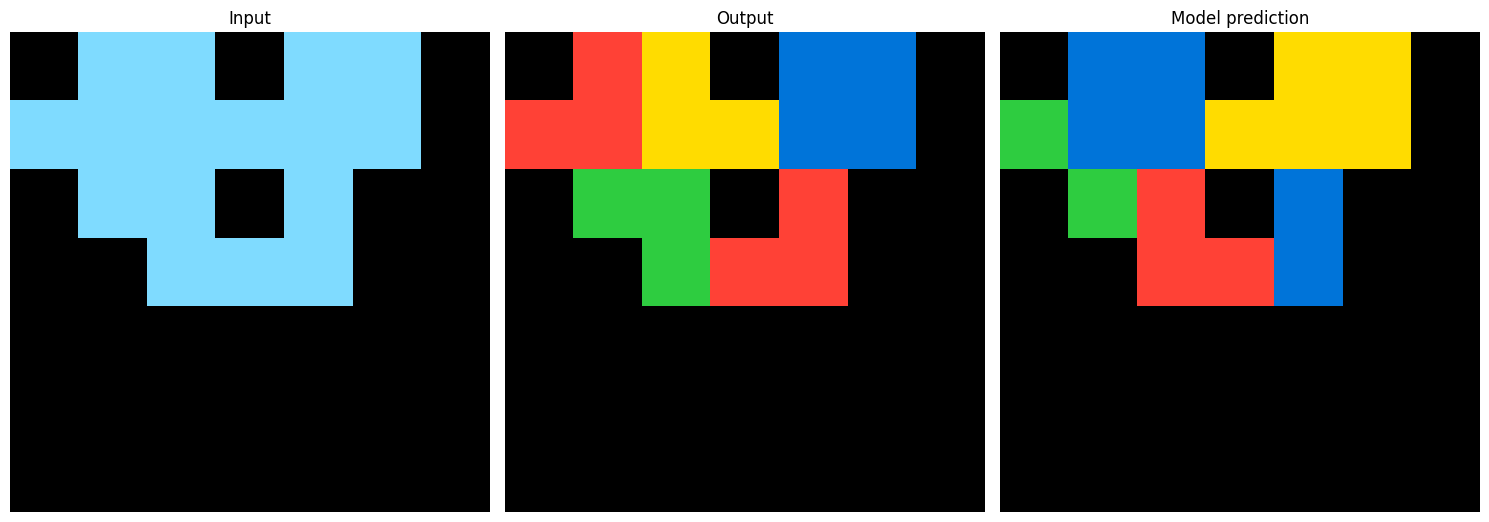

Accuracy: 0.7346938775510204
de493100
90347967


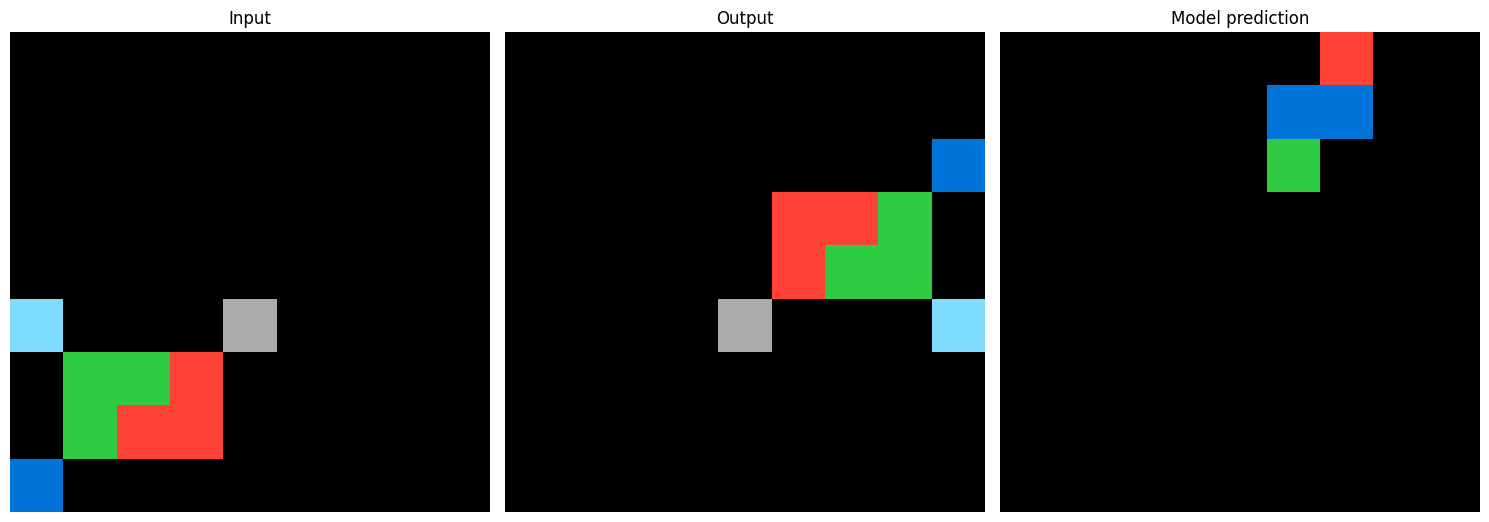

Accuracy: 0.8395061728395061


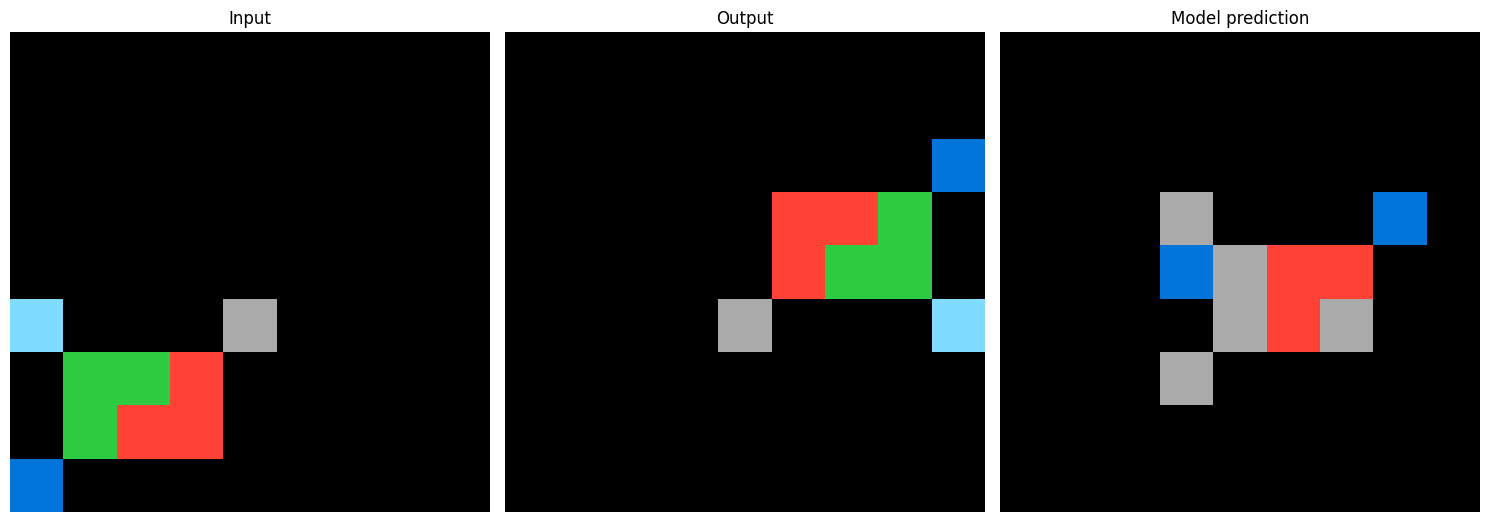

Accuracy: 0.8395061728395061


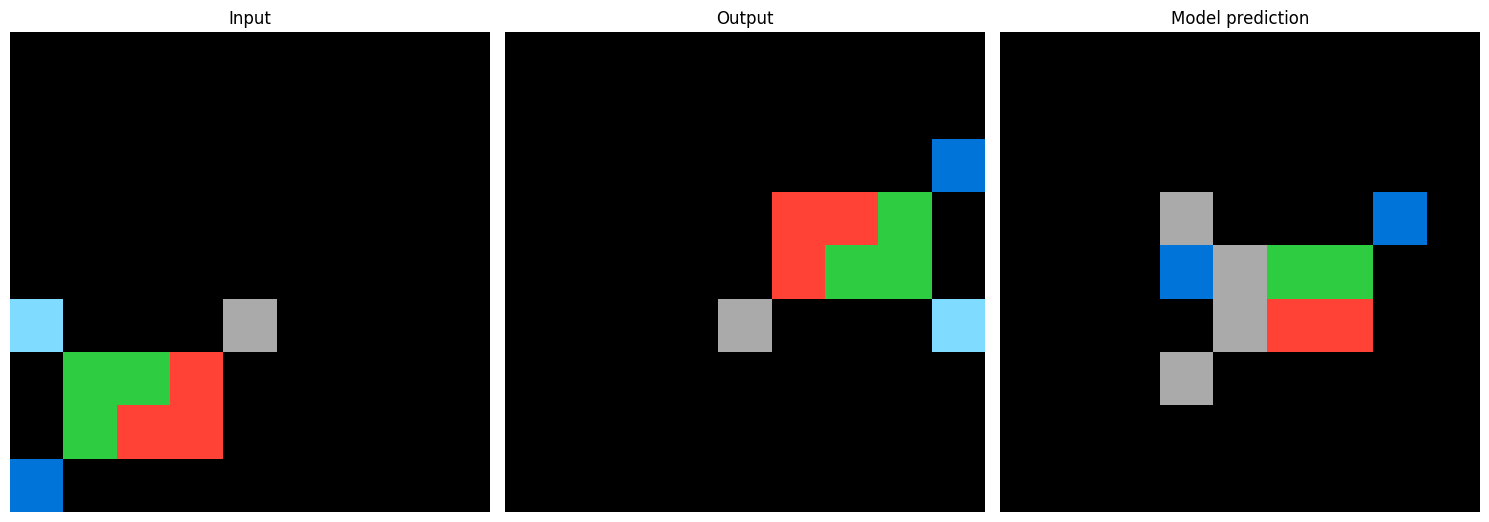

Accuracy: 0.8395061728395061
88207623


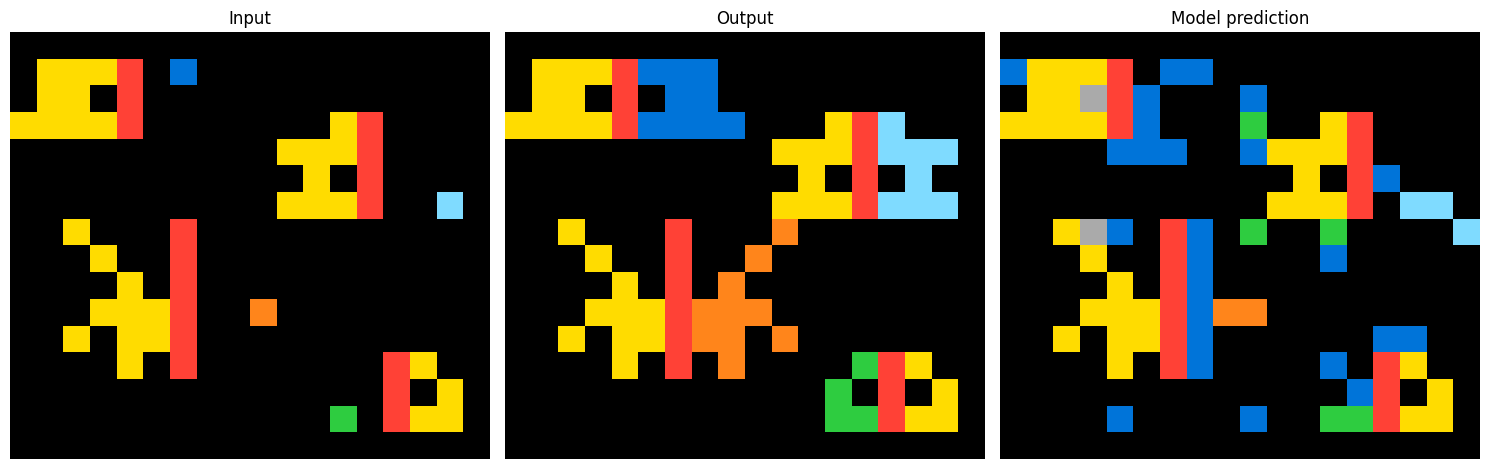

Accuracy: 0.8333333333333334


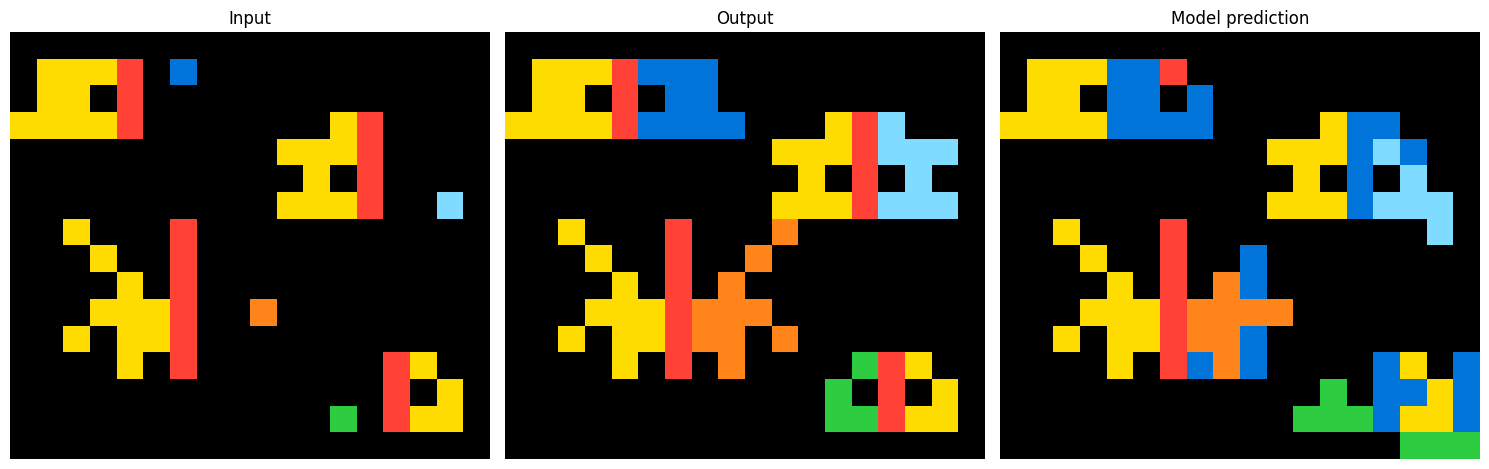

Accuracy: 0.875


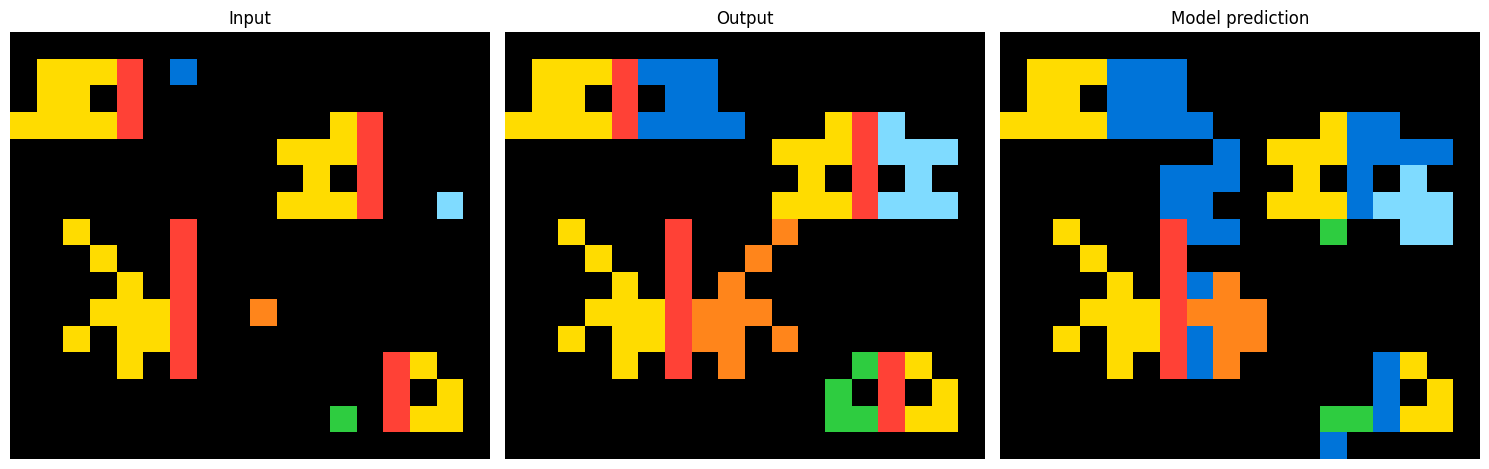

Accuracy: 0.8645833333333334
45737921


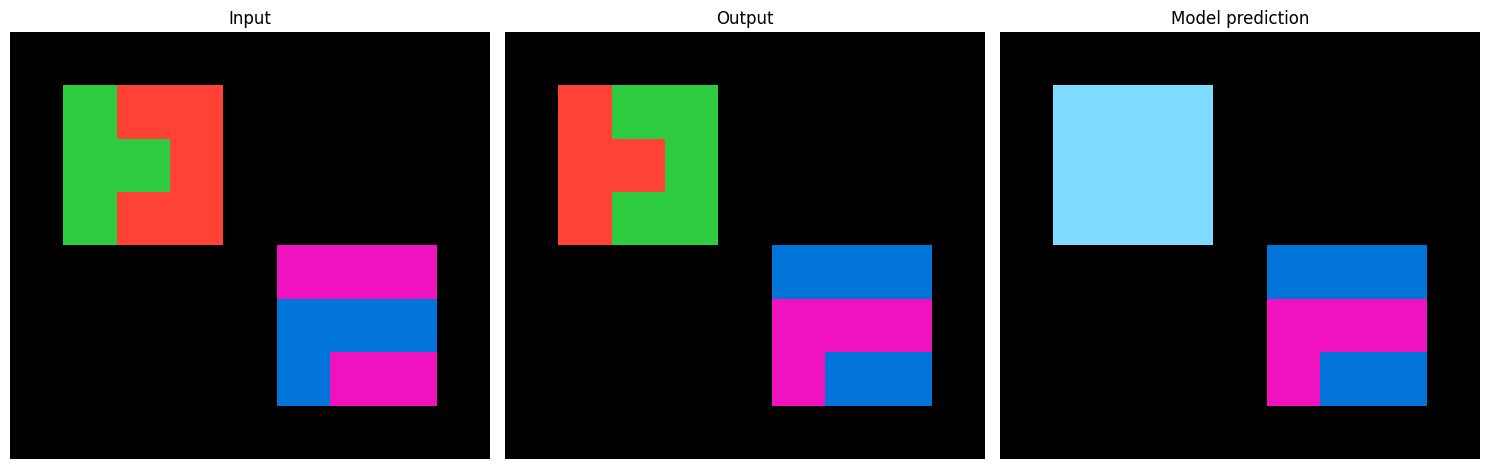

Accuracy: 0.875


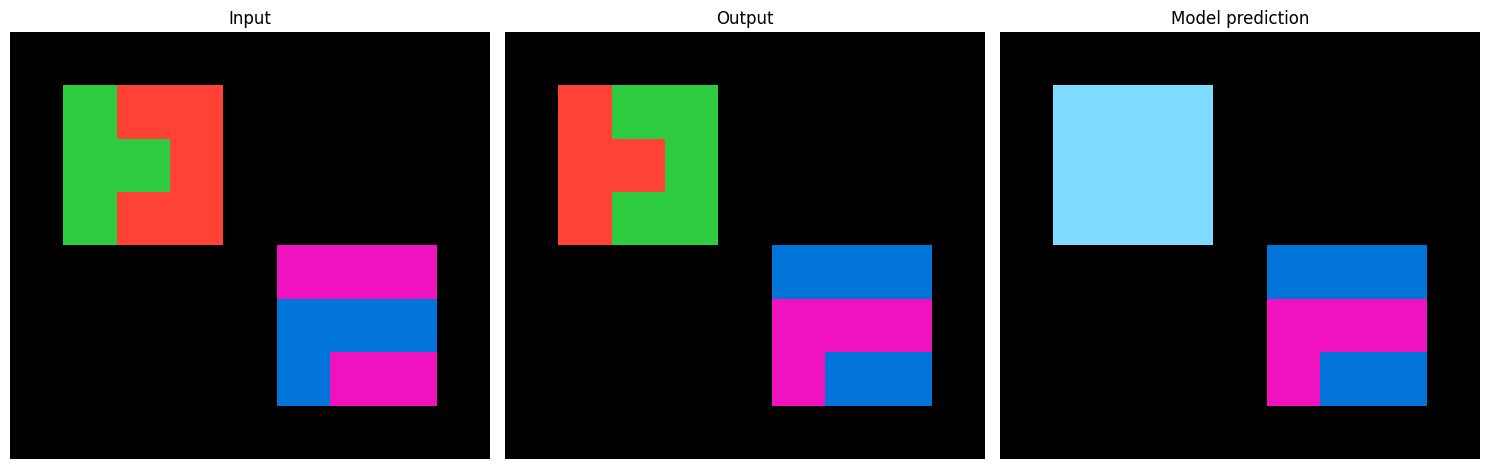

Accuracy: 0.875


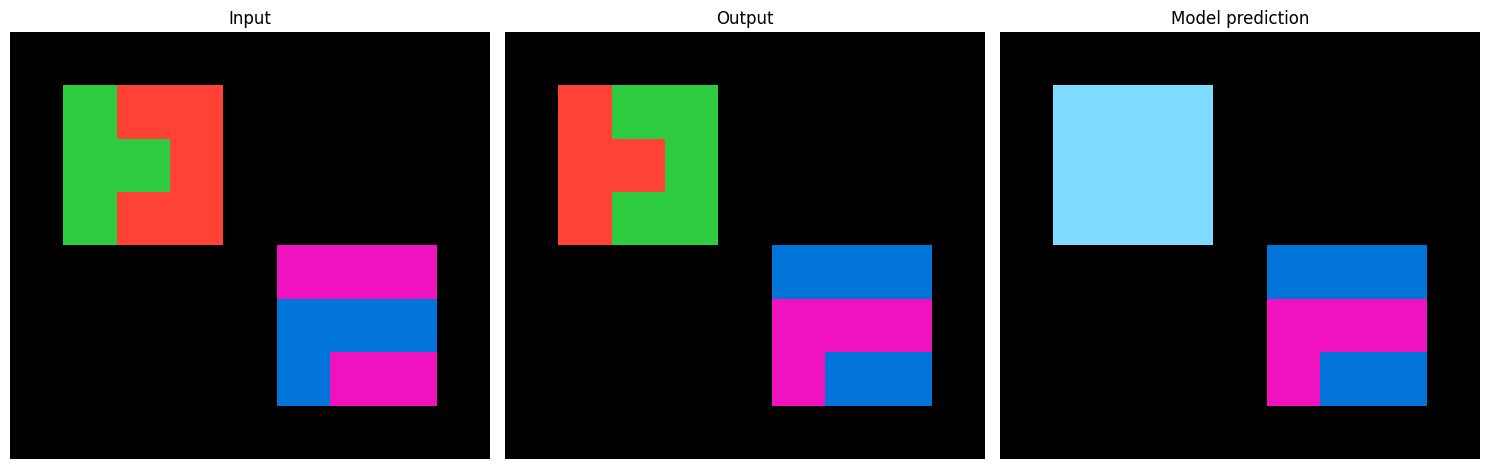

Accuracy: 0.875
fb791726
c3202e5a
642d658d
456873bc


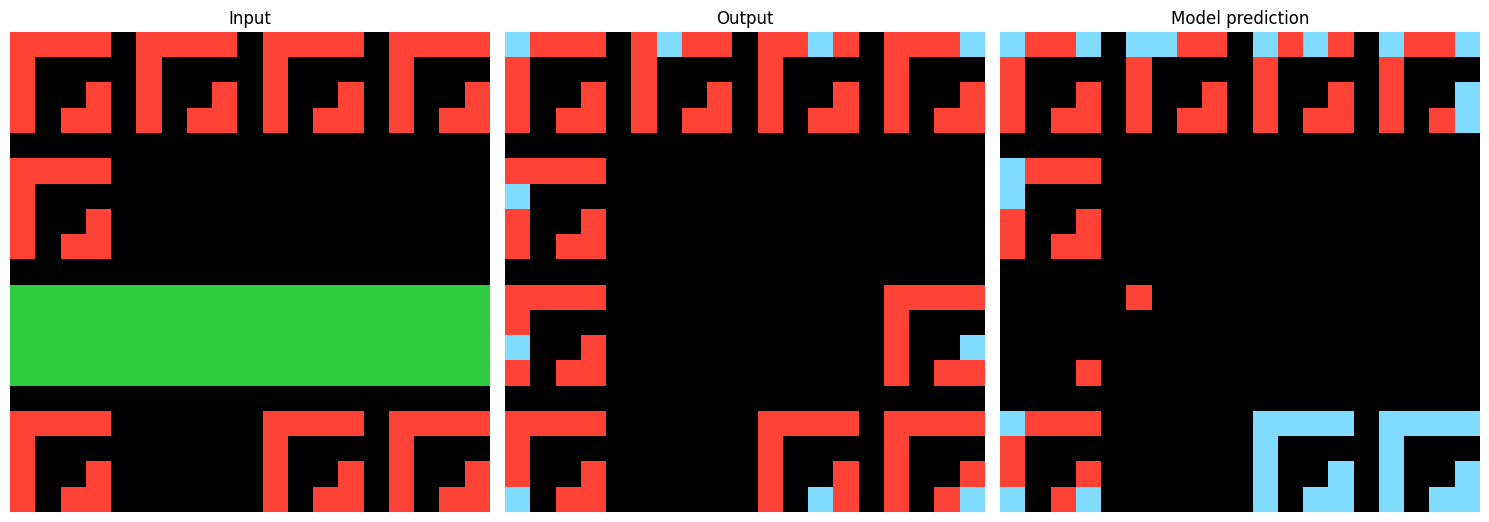

Accuracy: 0.8698060941828255


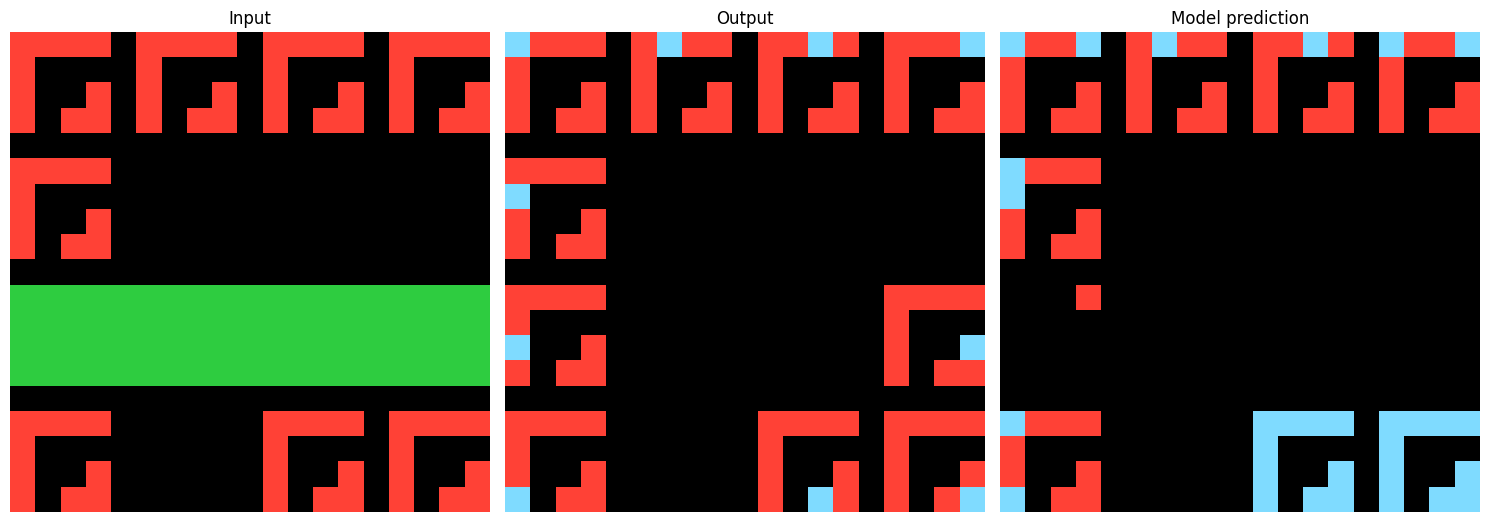

Accuracy: 0.8864265927977839


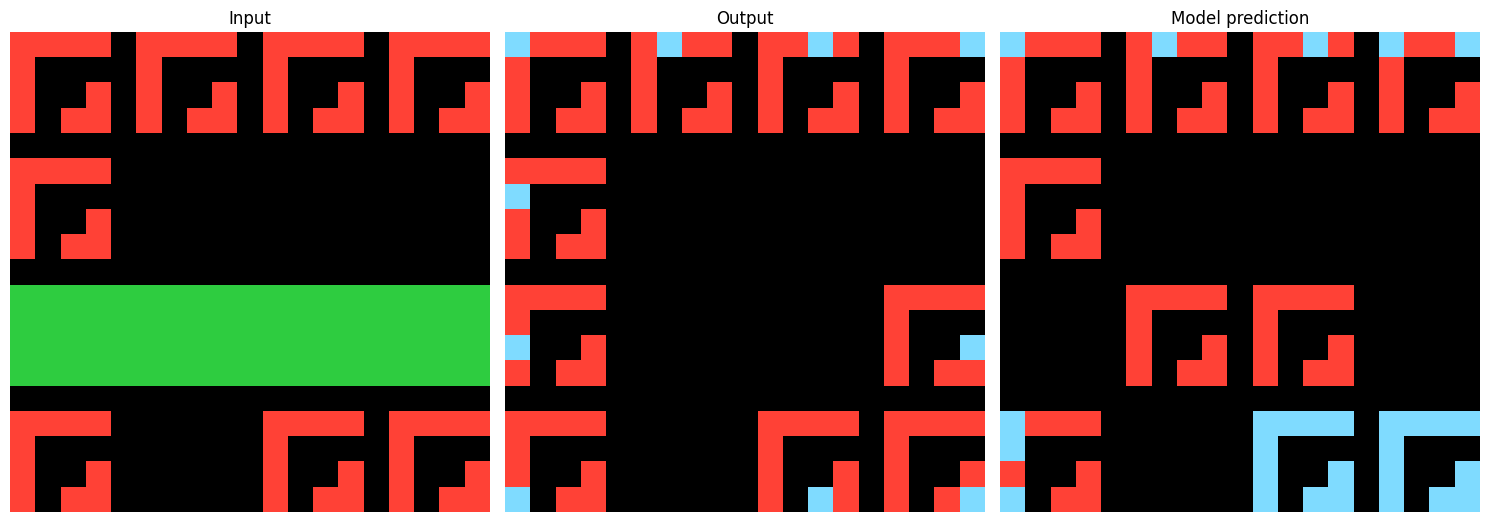

Accuracy: 0.8282548476454293
782b5218


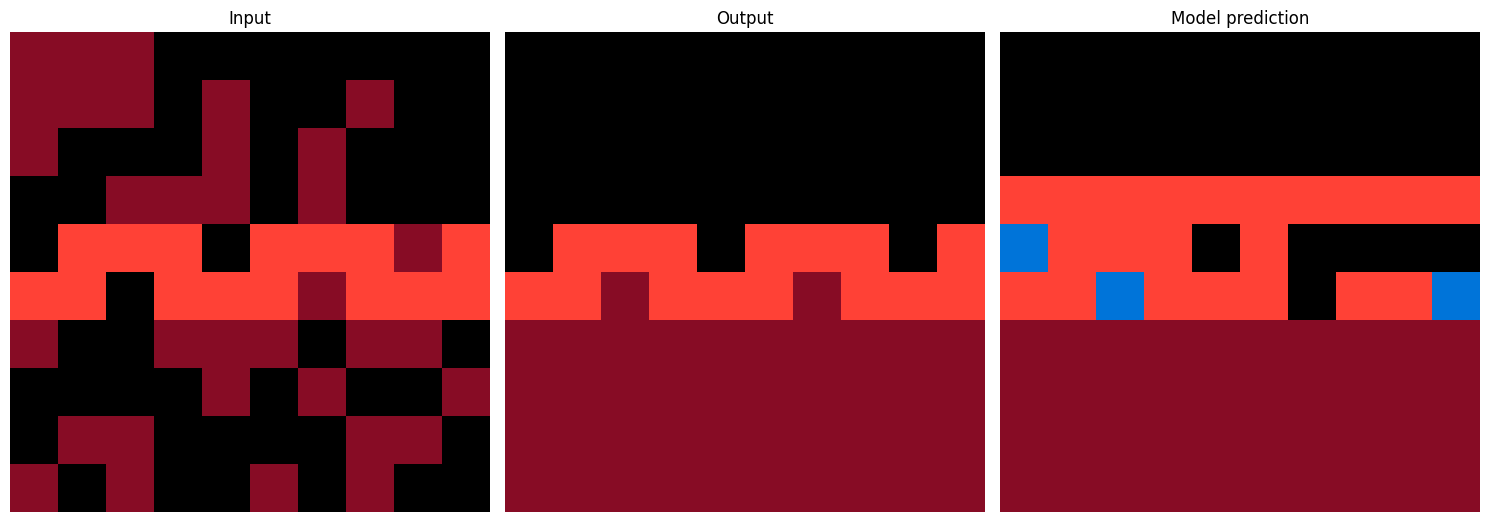

Accuracy: 0.83


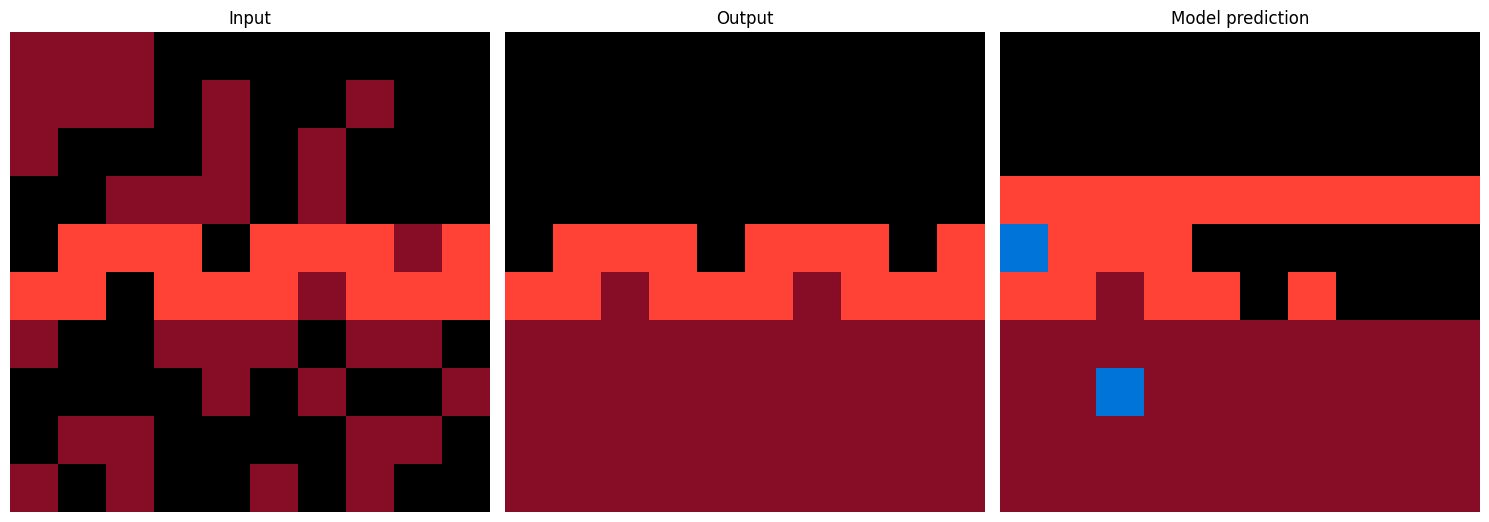

Accuracy: 0.79


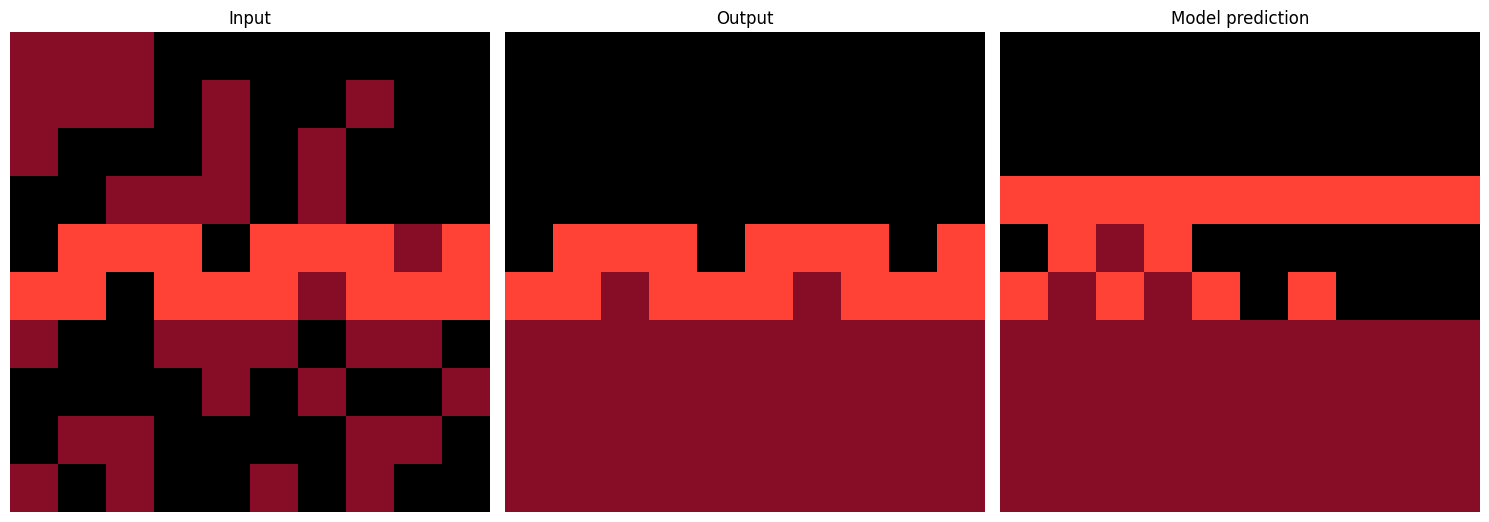

Accuracy: 0.77
9b365c51


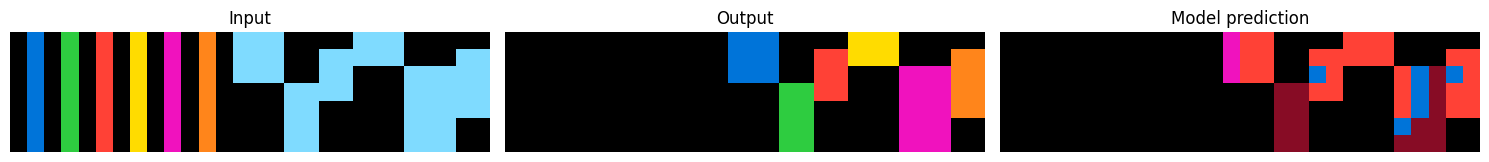

Accuracy: 0.7602040816326531


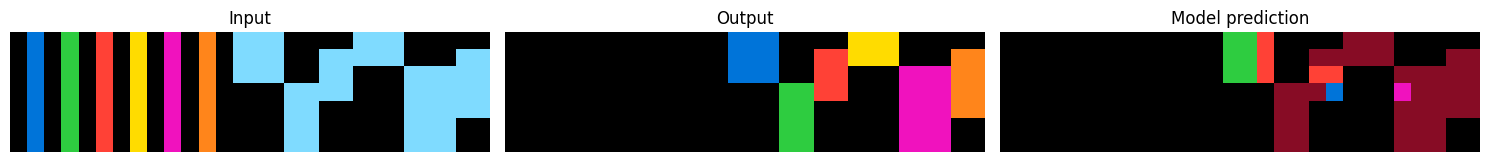

Accuracy: 0.75


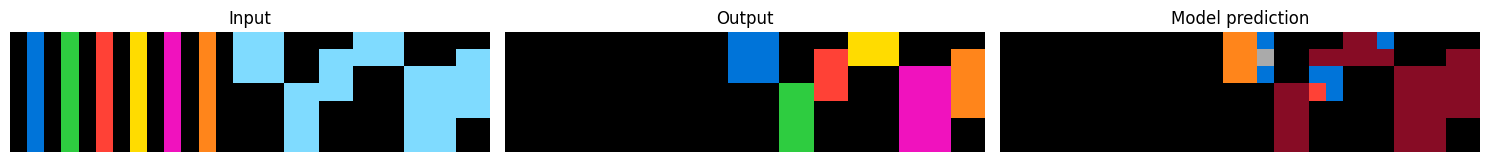

Accuracy: 0.75
b9630600


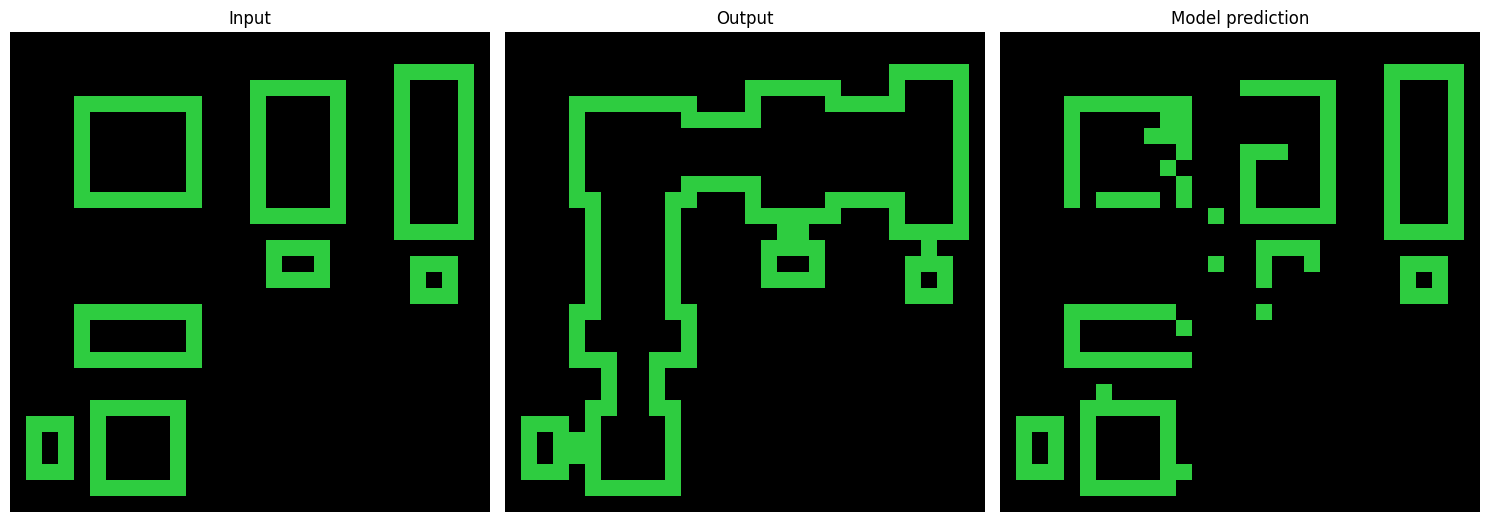

Accuracy: 0.9144444444444444


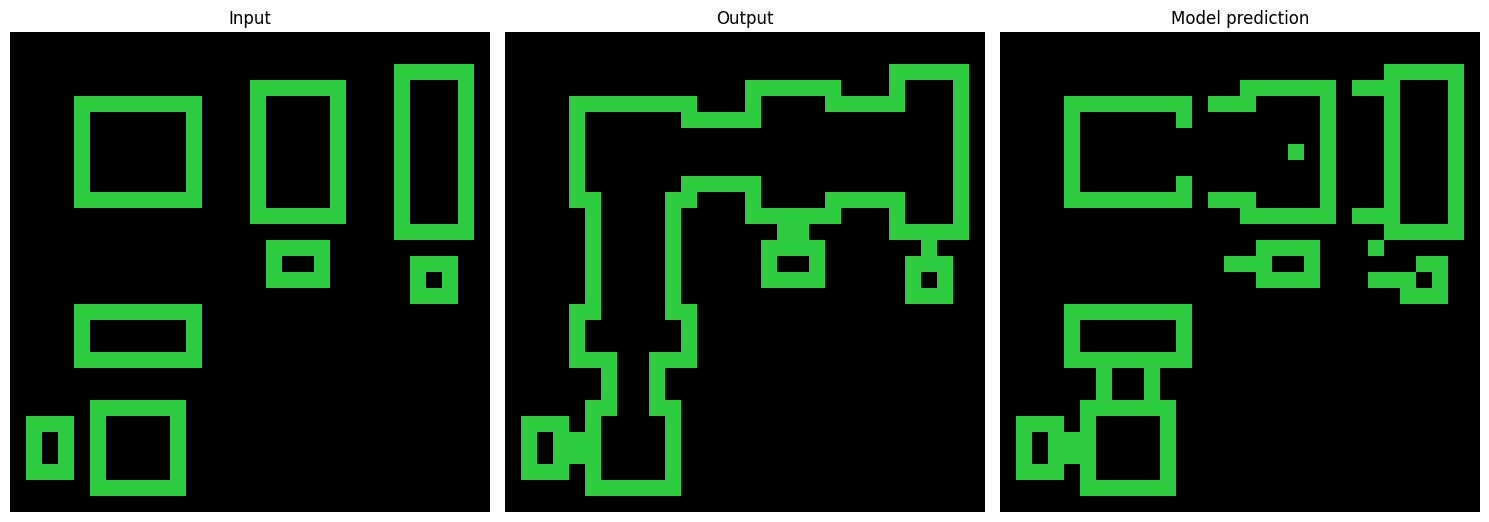

Accuracy: 0.9266666666666666


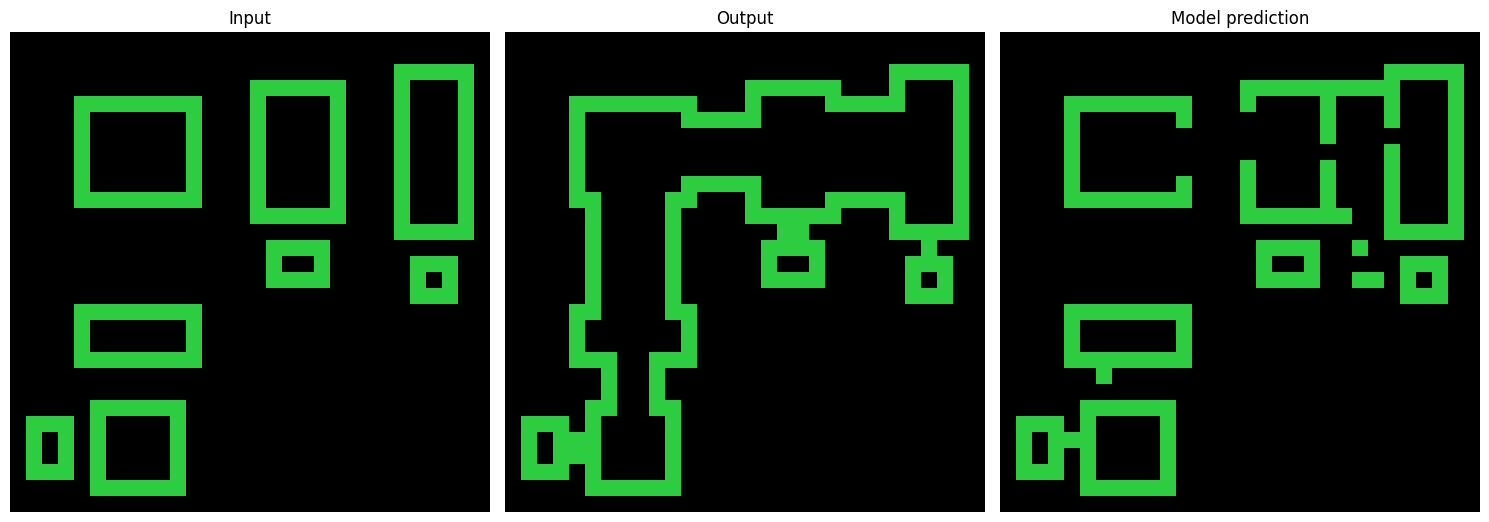

Accuracy: 0.9333333333333333
c7d4e6ad


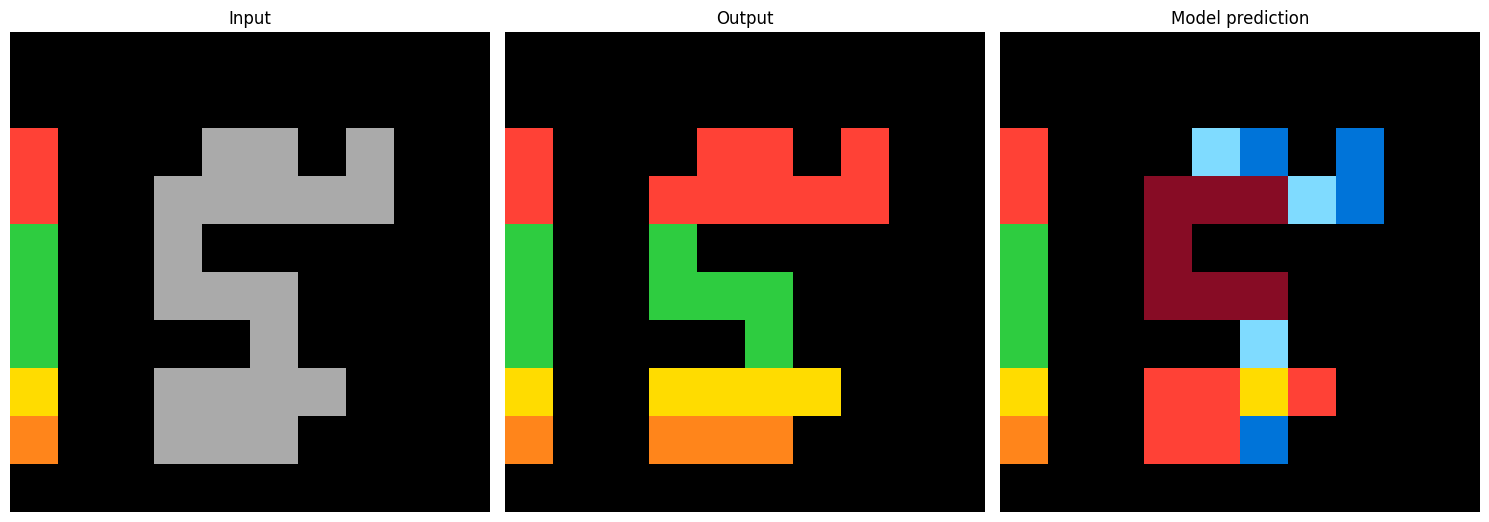

Accuracy: 0.81


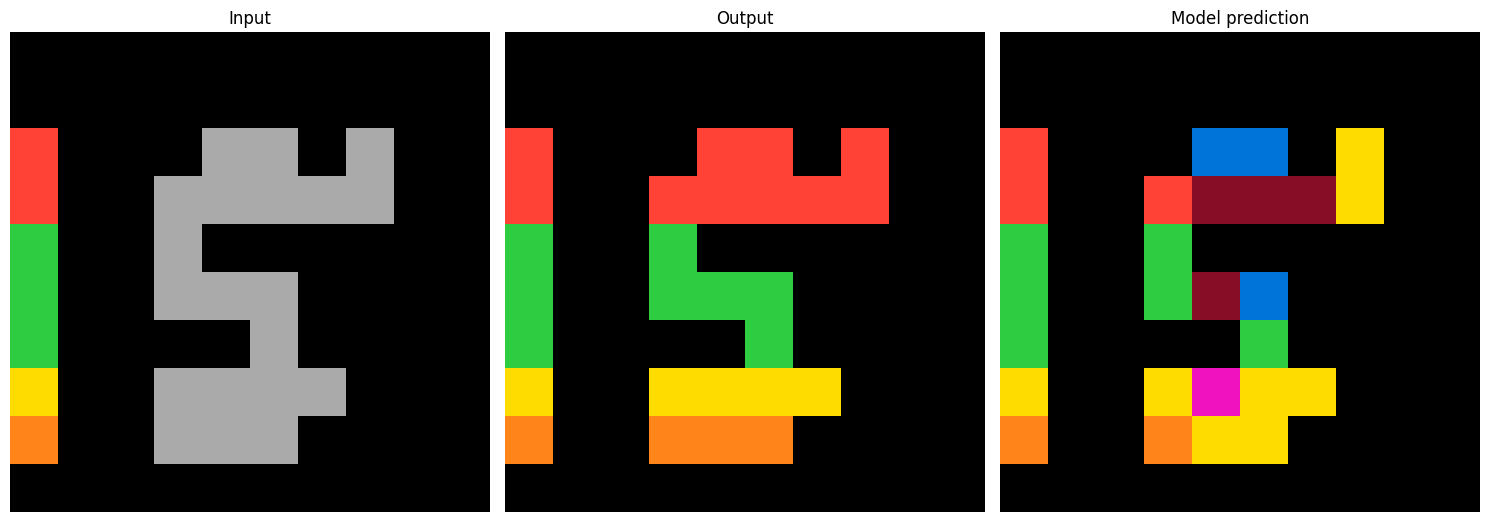

Accuracy: 0.88


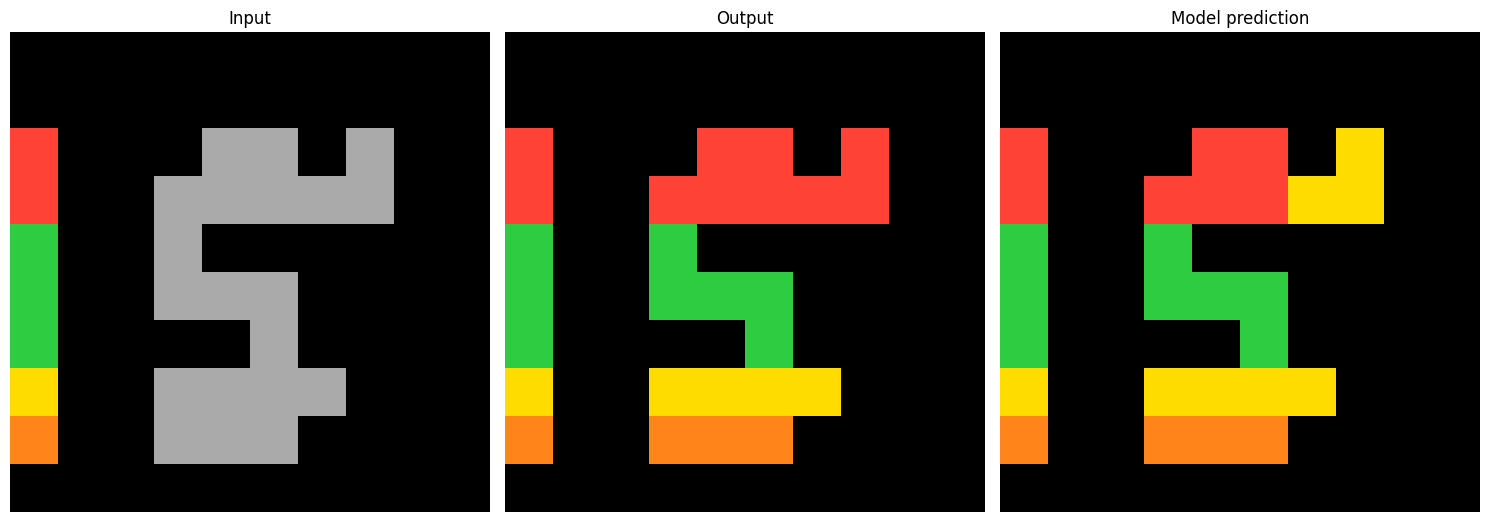

Accuracy: 0.97
c35c1b4c


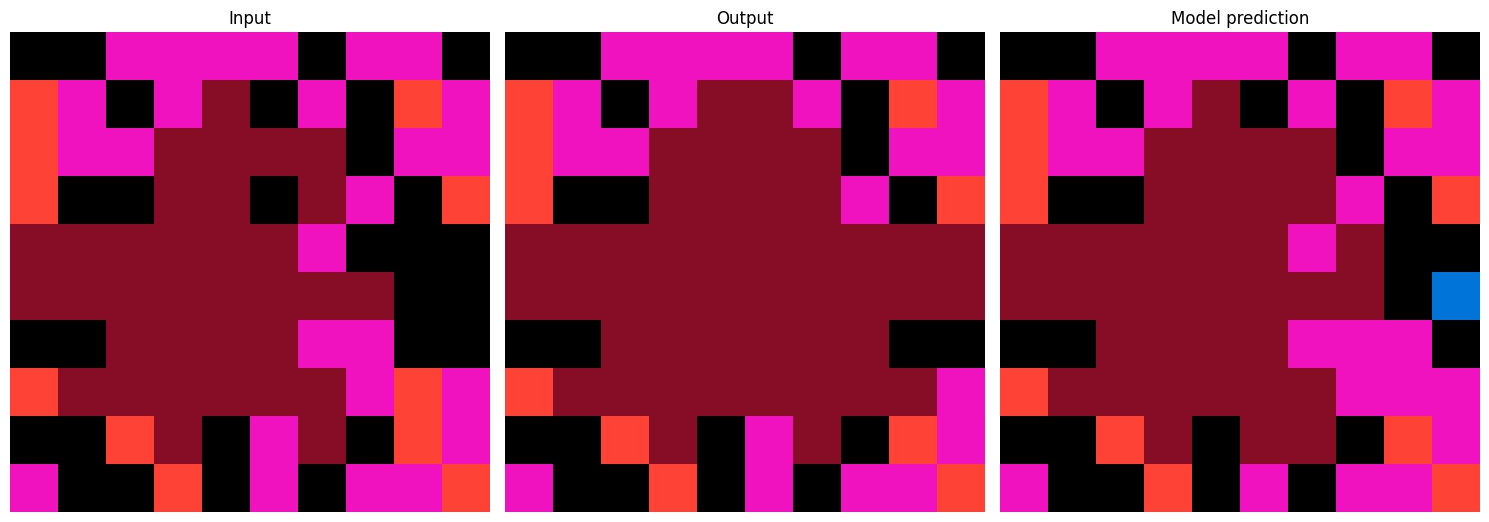

Accuracy: 0.88


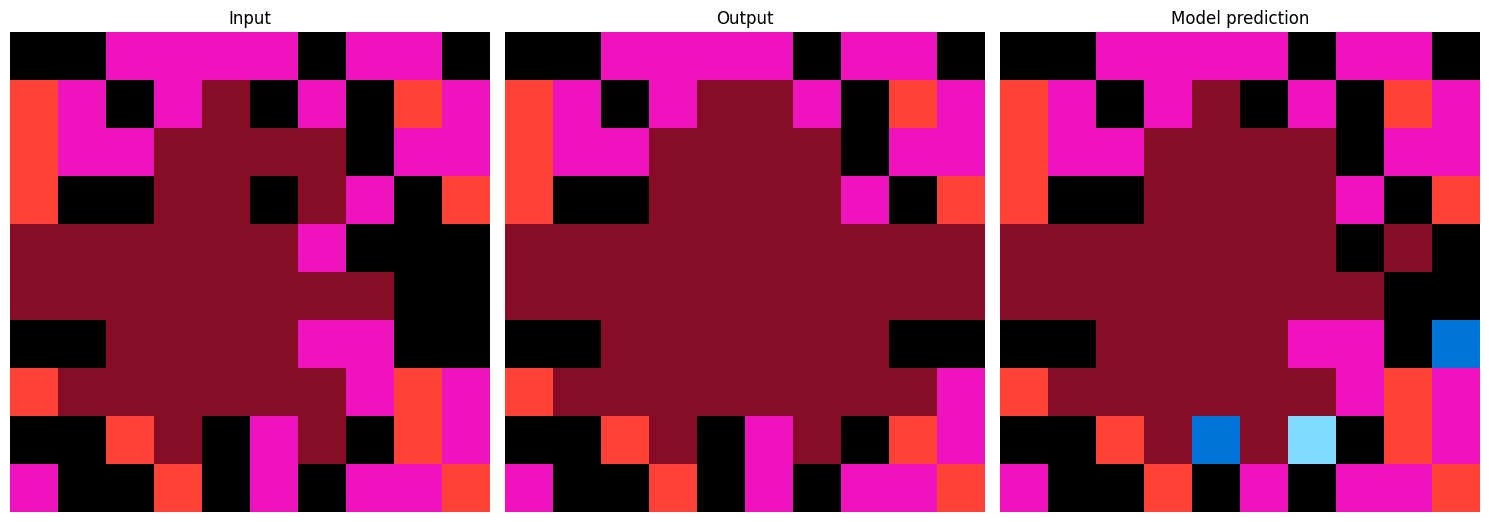

Accuracy: 0.87


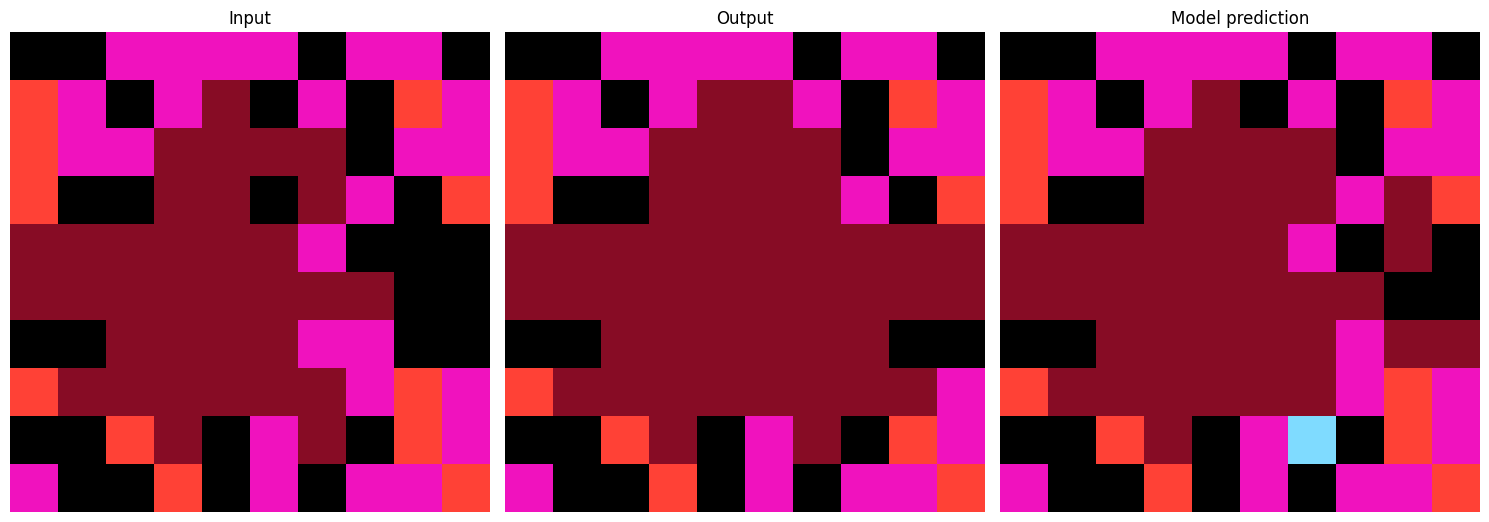

Accuracy: 0.87
60c09cac
d19f7514
8ba14f53
0c786b71
a04b2602


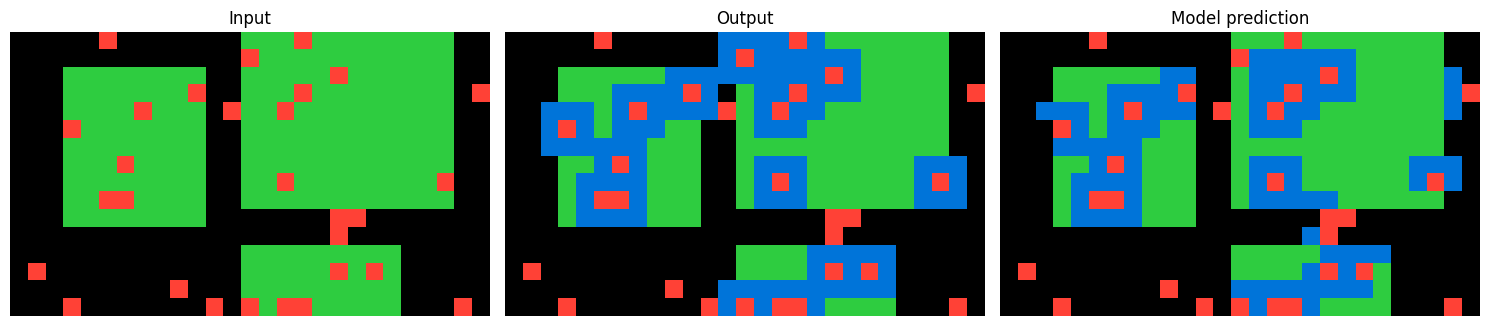

Accuracy: 0.9375


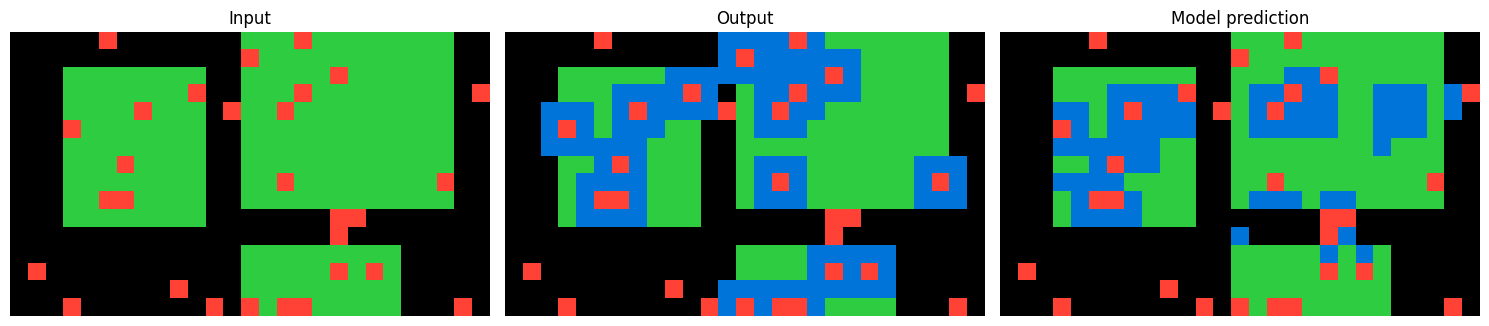

Accuracy: 0.8078703703703703


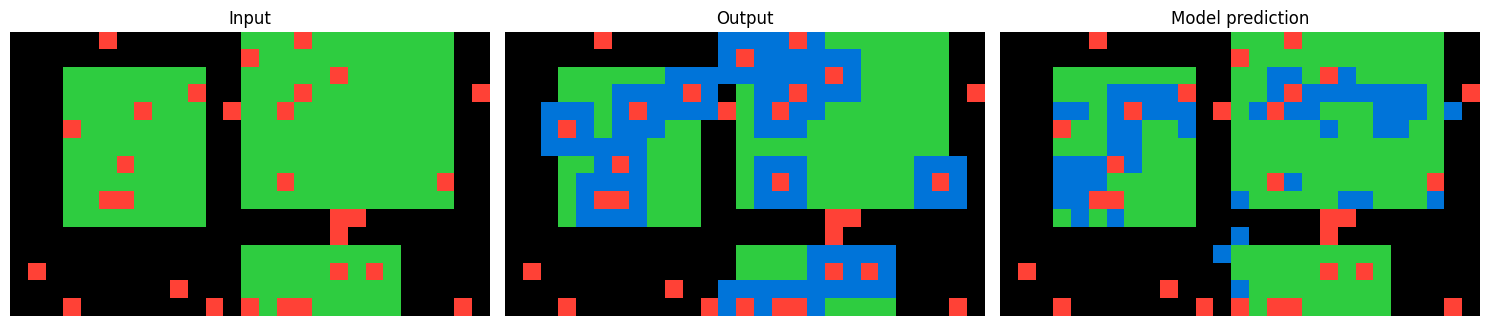

Accuracy: 0.7847222222222222
e6de6e8f
7039b2d7
7d18a6fb
4c177718
c97c0139


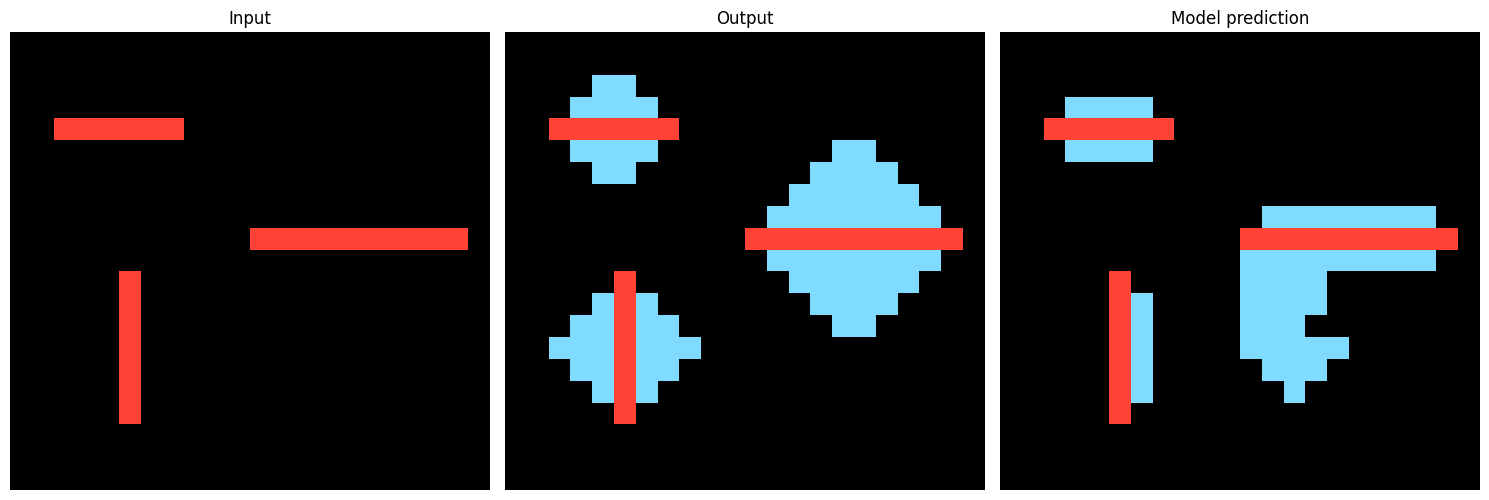

Accuracy: 0.8787878787878788


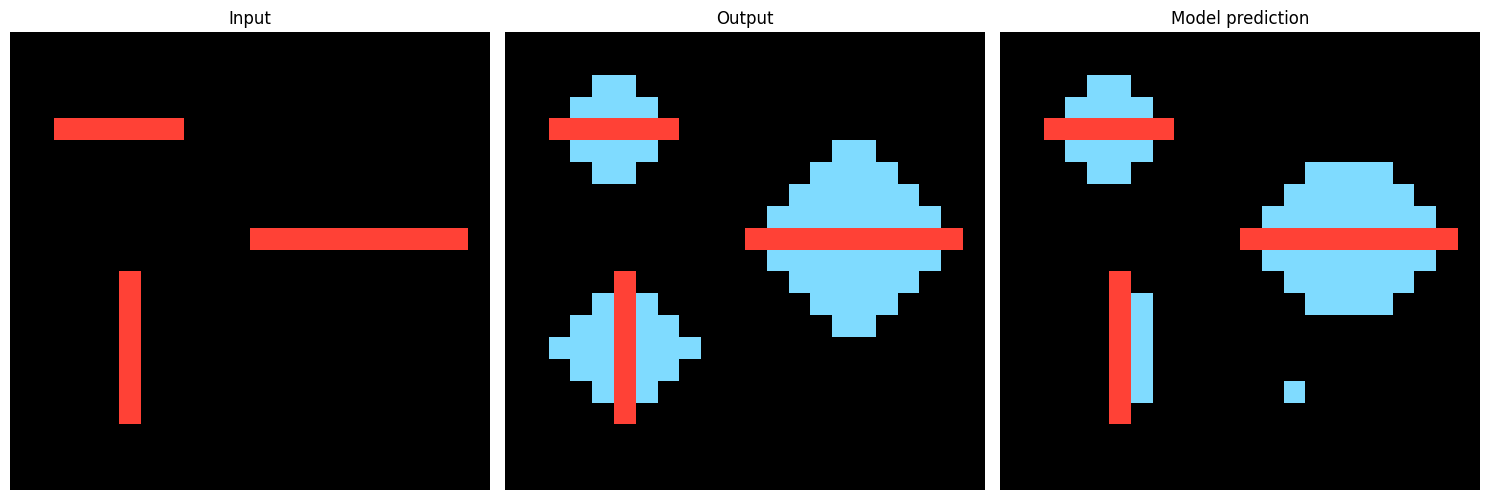

Accuracy: 0.961038961038961


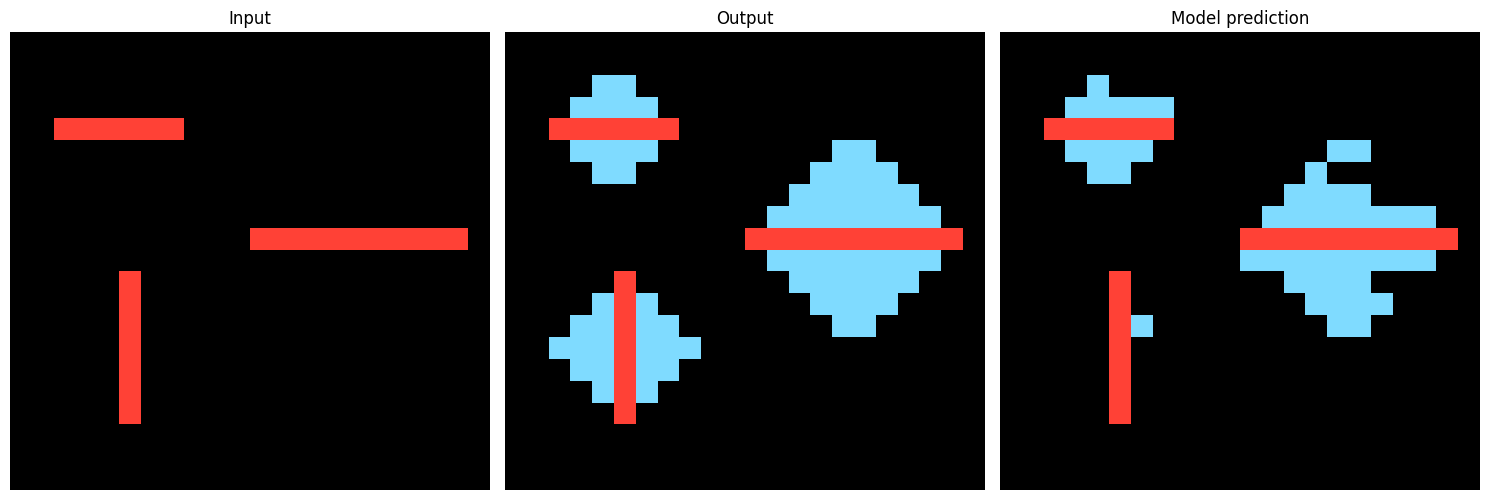

Accuracy: 0.9415584415584416
1e81d6f9


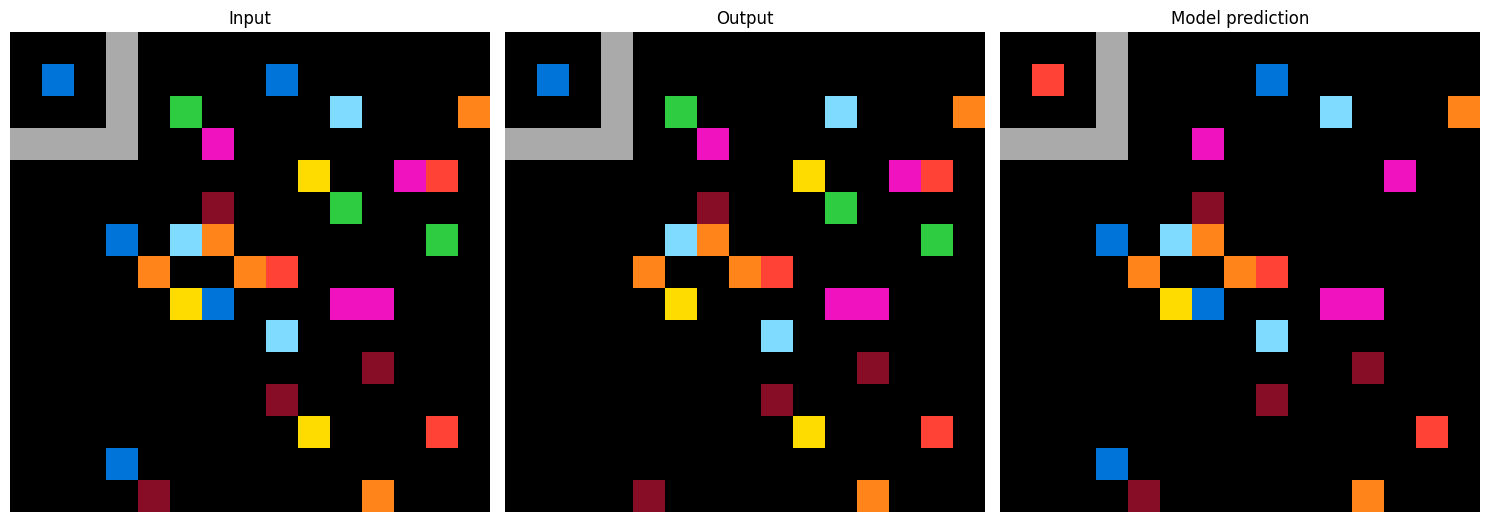

Accuracy: 0.9511111111111111


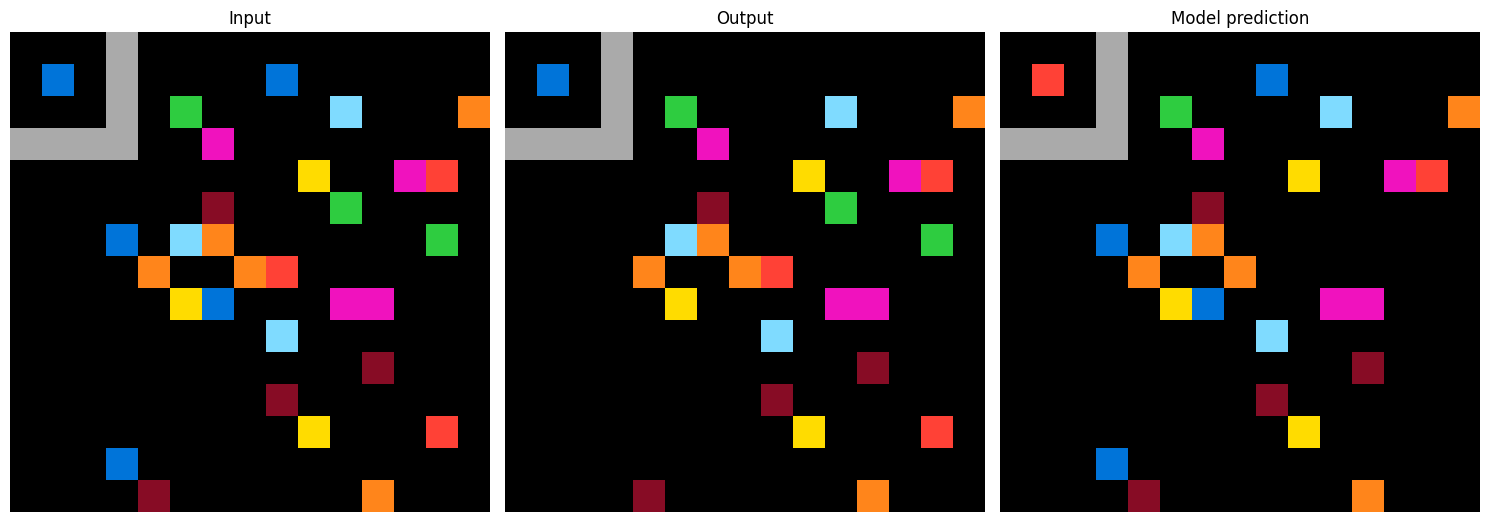

Accuracy: 0.96


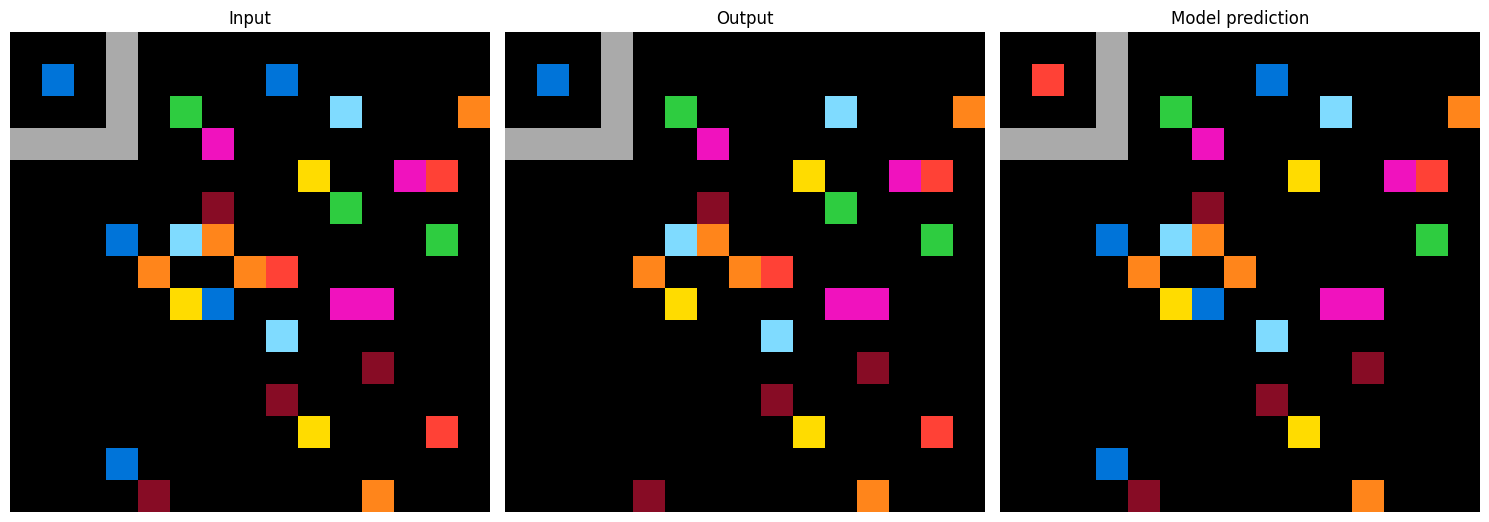

Accuracy: 0.9644444444444444
4364c1c4


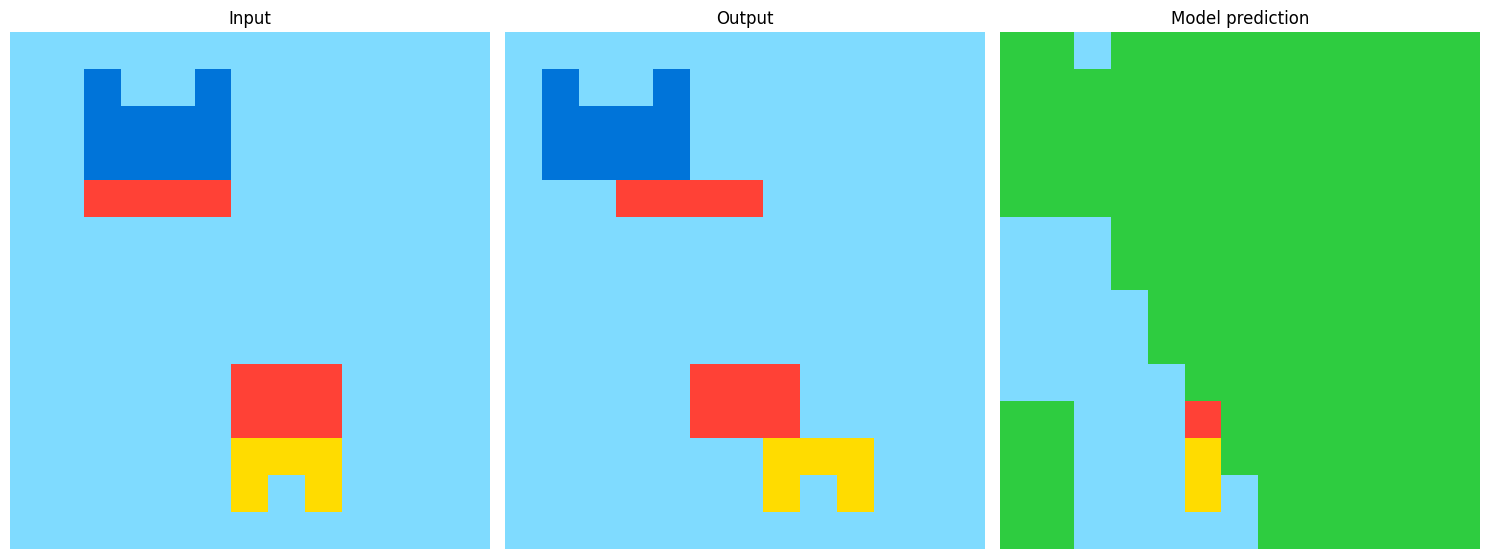

Accuracy: 0.1978021978021978


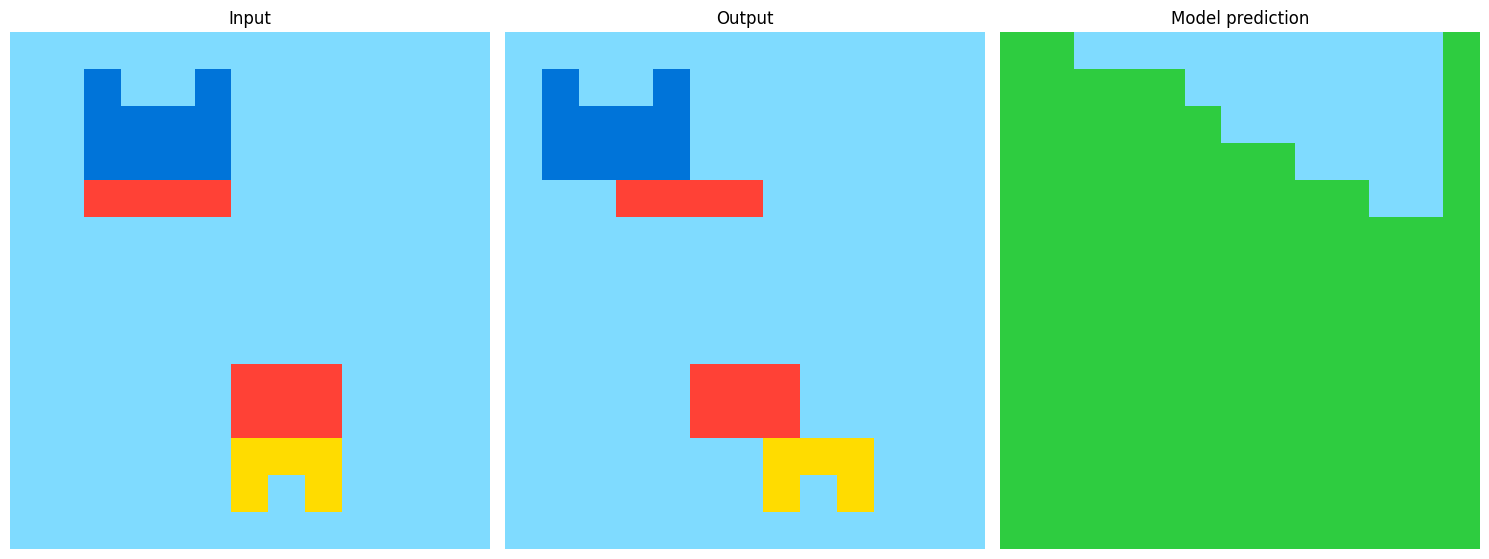

Accuracy: 0.15934065934065933


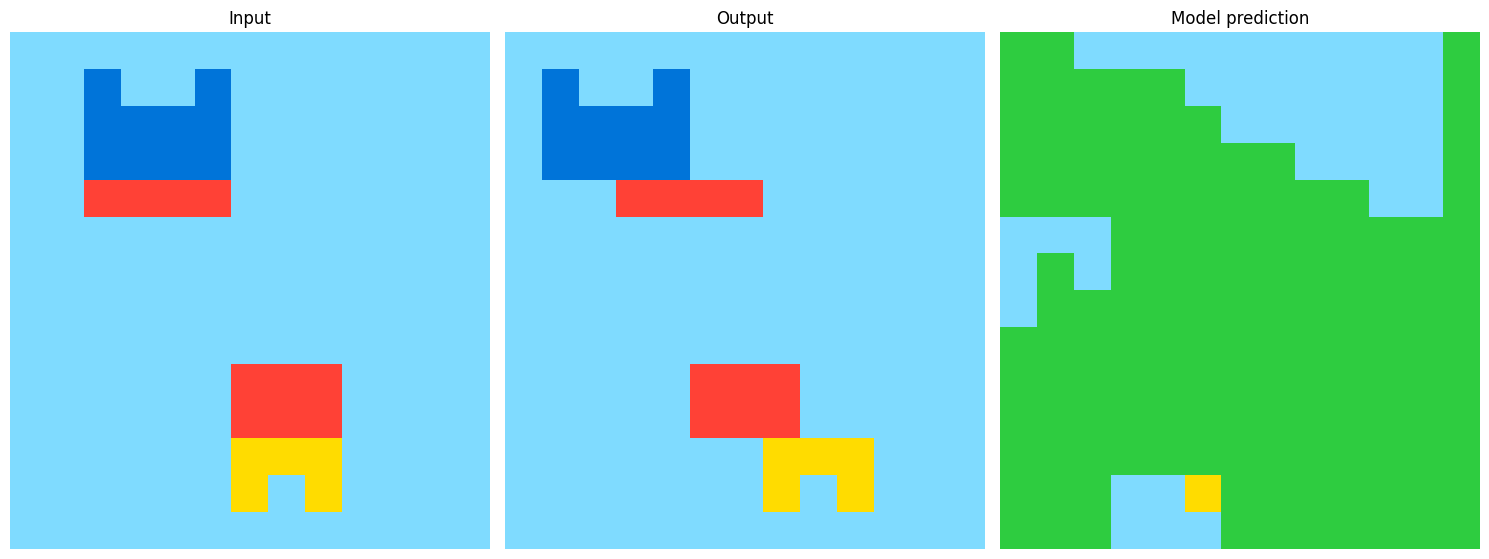

Accuracy: 0.21978021978021978
72207abc


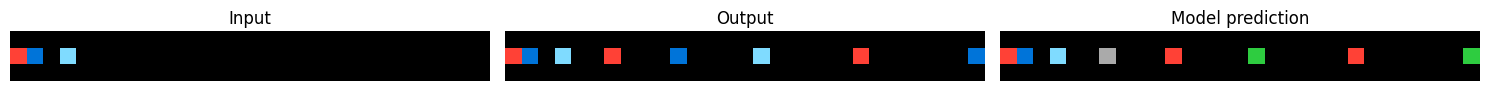

Accuracy: 0.9540229885057471


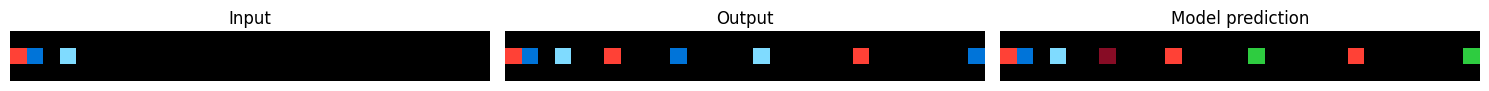

Accuracy: 0.9540229885057471


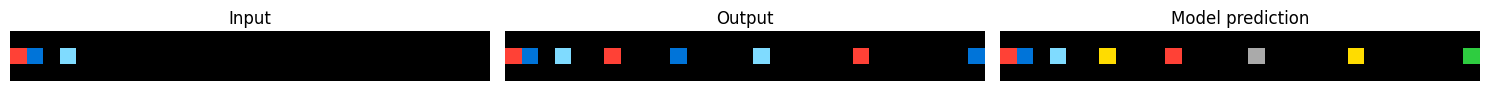

Accuracy: 0.9425287356321839
e4075551


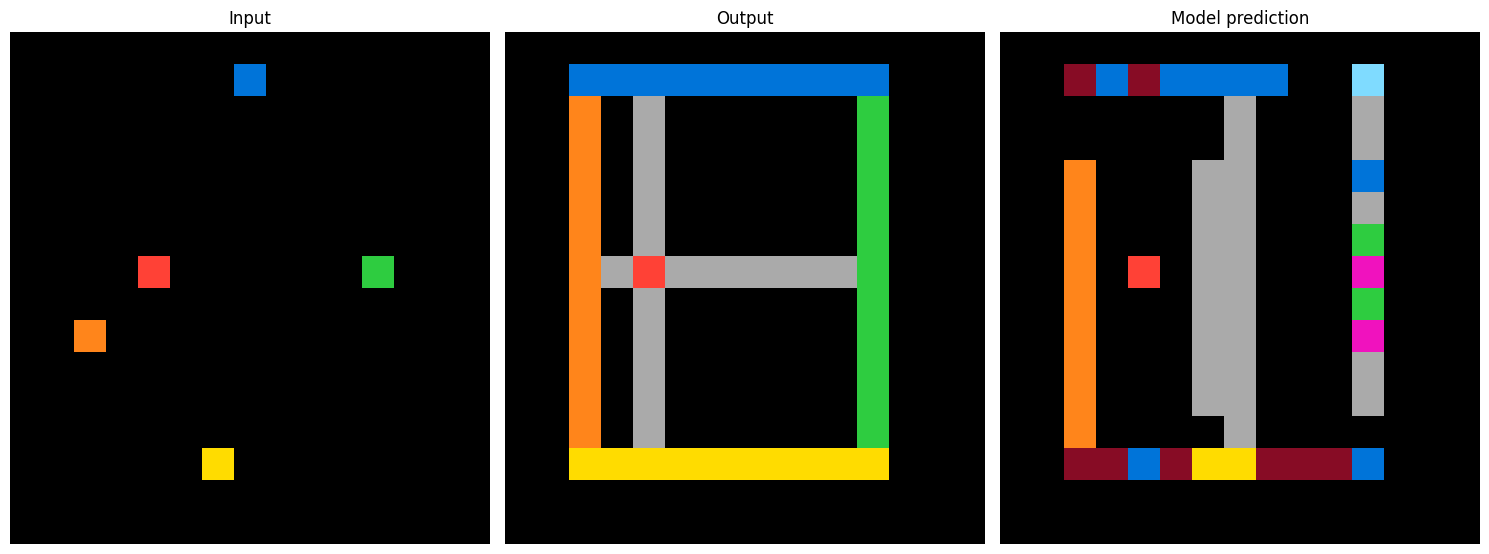

Accuracy: 0.7666666666666667


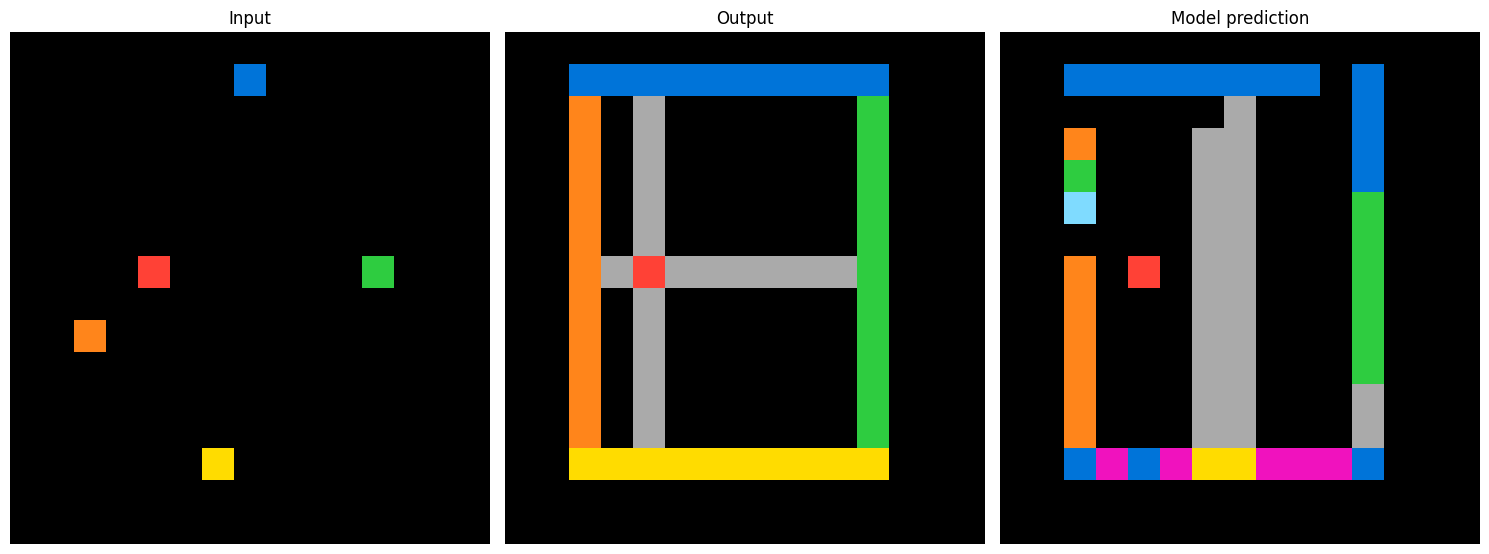

Accuracy: 0.7833333333333333


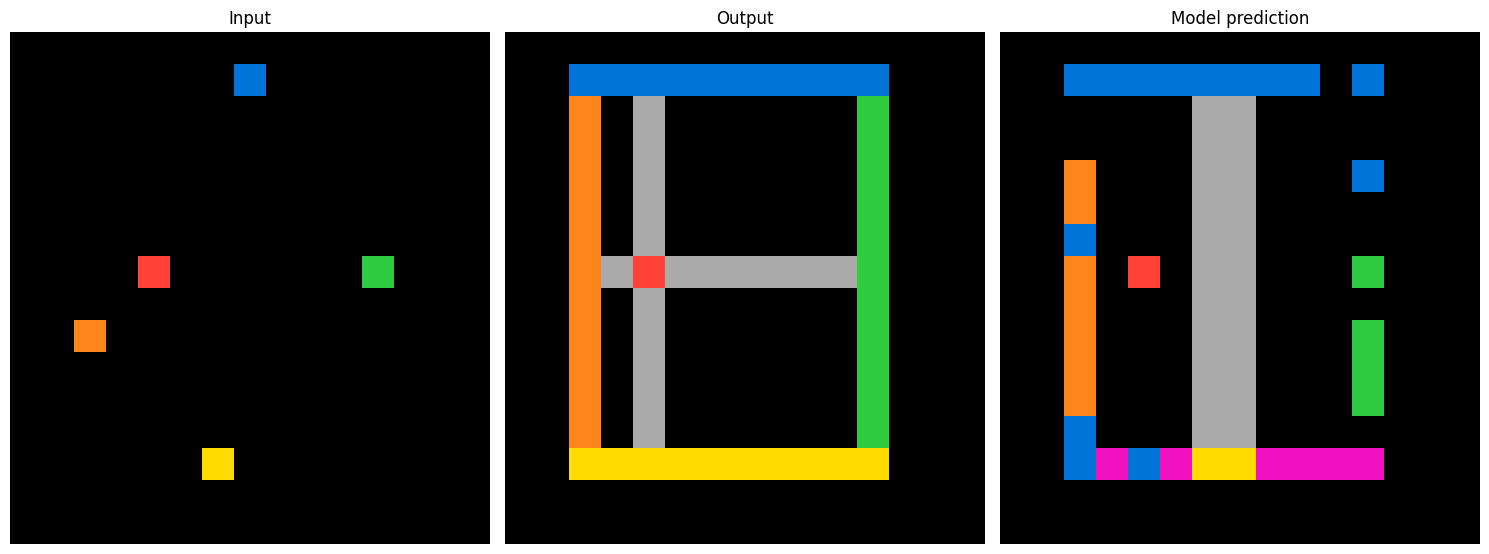

Accuracy: 0.7708333333333334
31d5ba1a
896d5239


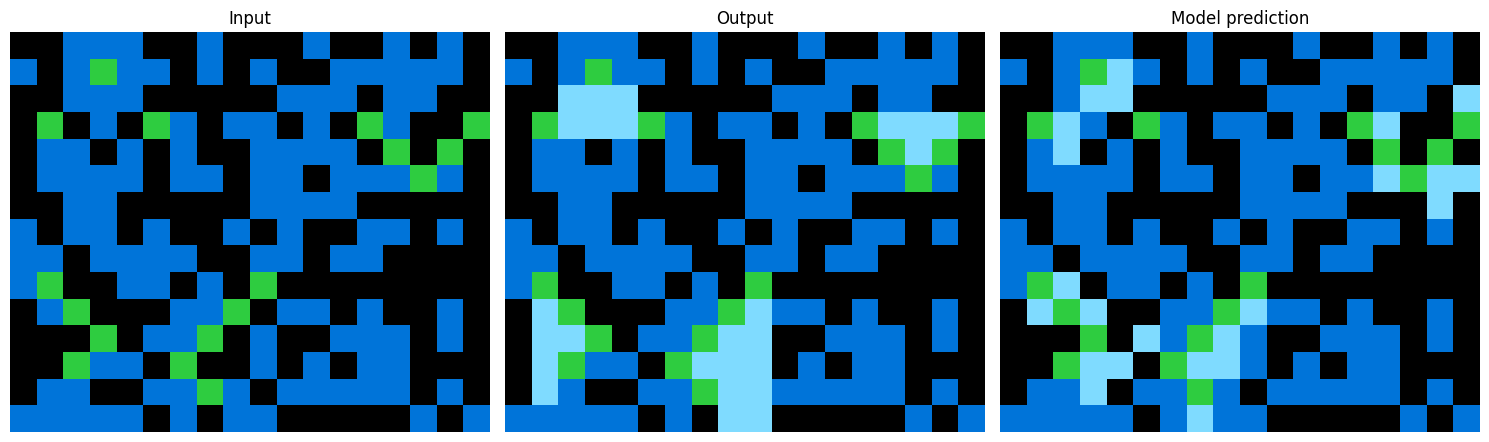

Accuracy: 0.8888888888888888


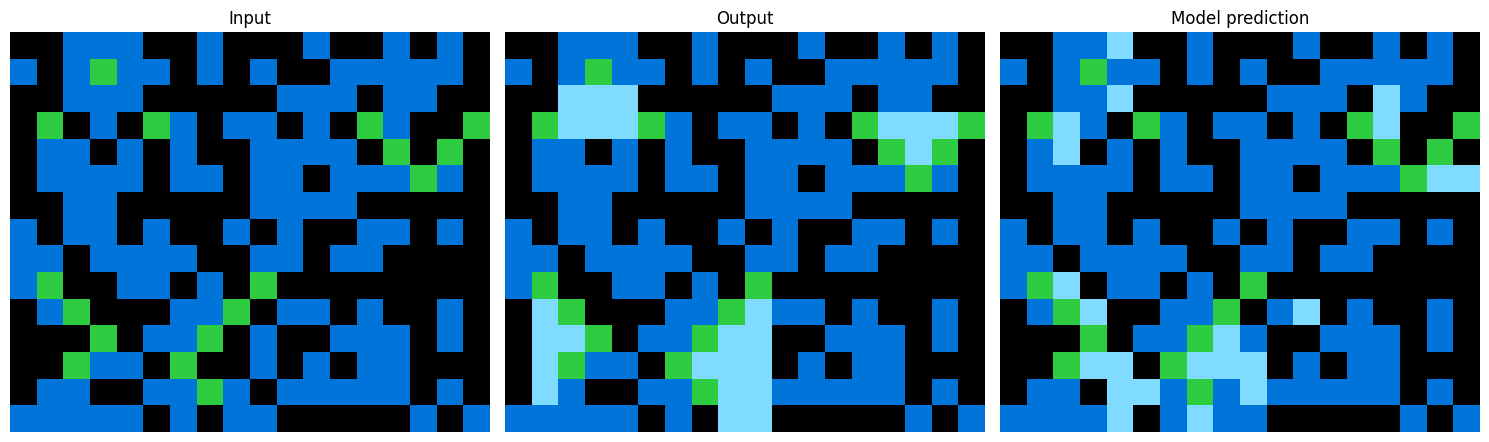

Accuracy: 0.8851851851851852


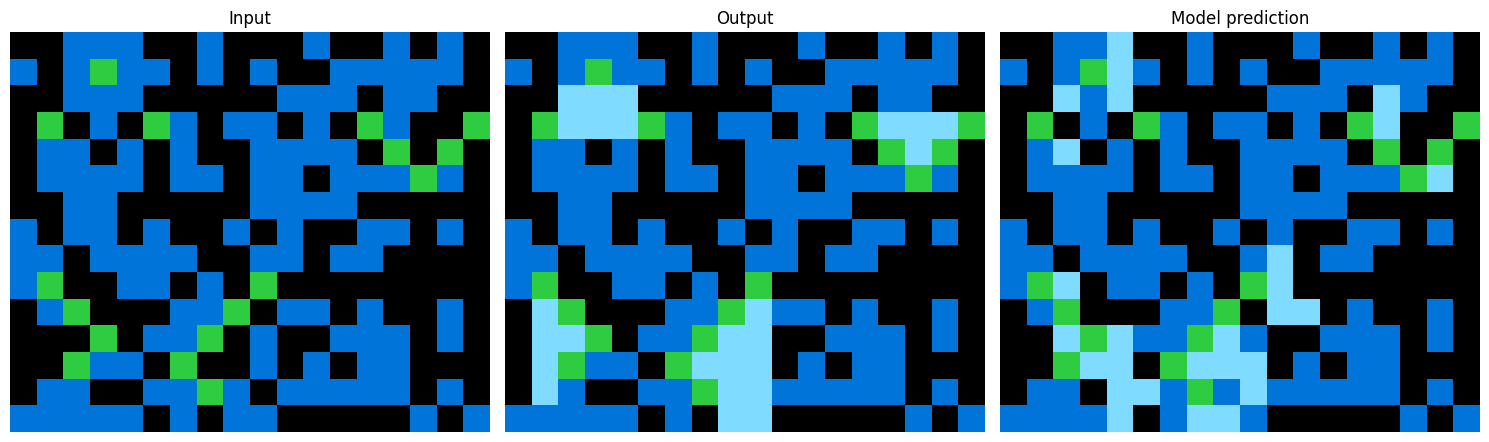

Accuracy: 0.8814814814814815
4e45f183


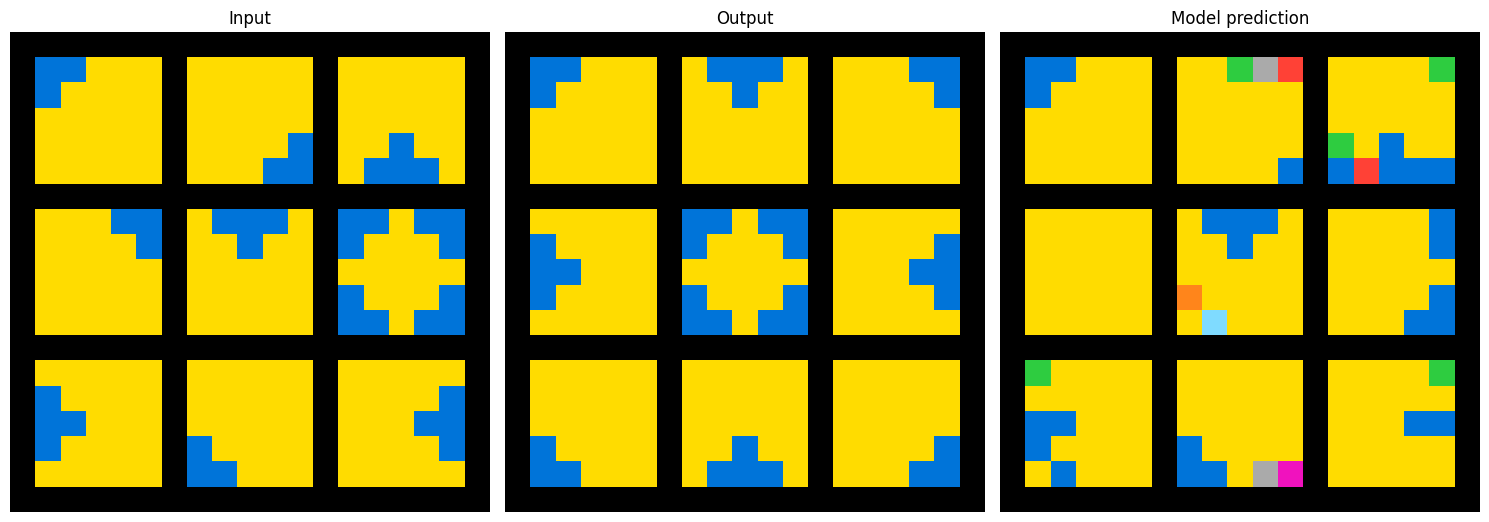

Accuracy: 0.853185595567867


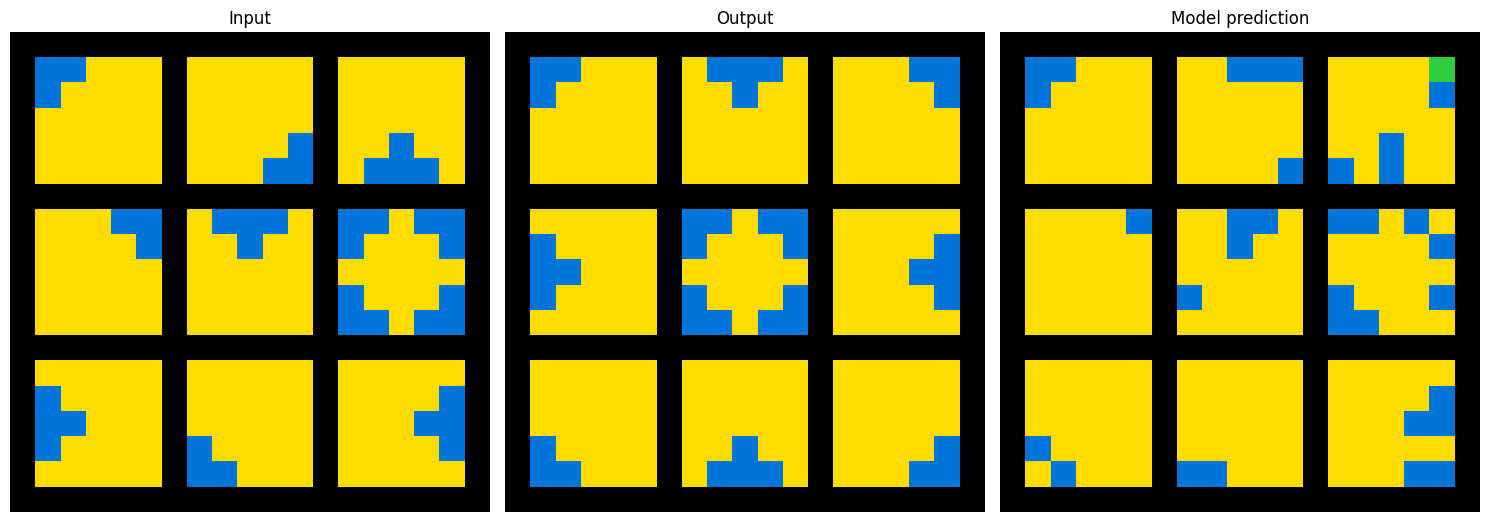

Accuracy: 0.8808864265927978


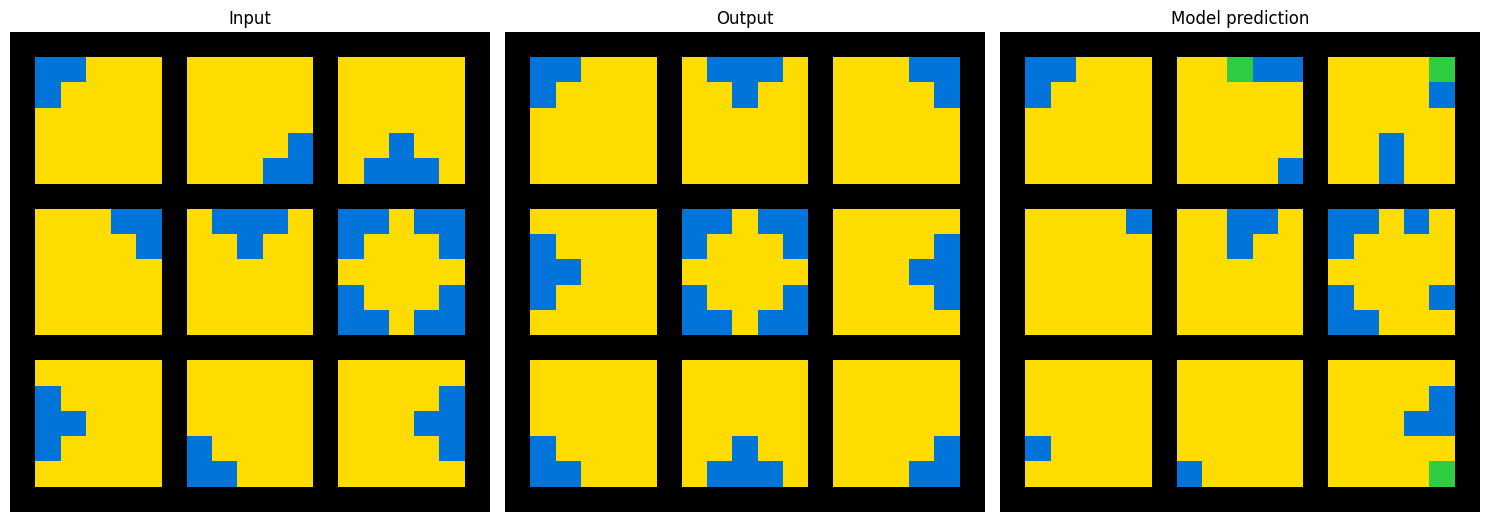

Accuracy: 0.8614958448753463
009d5c81


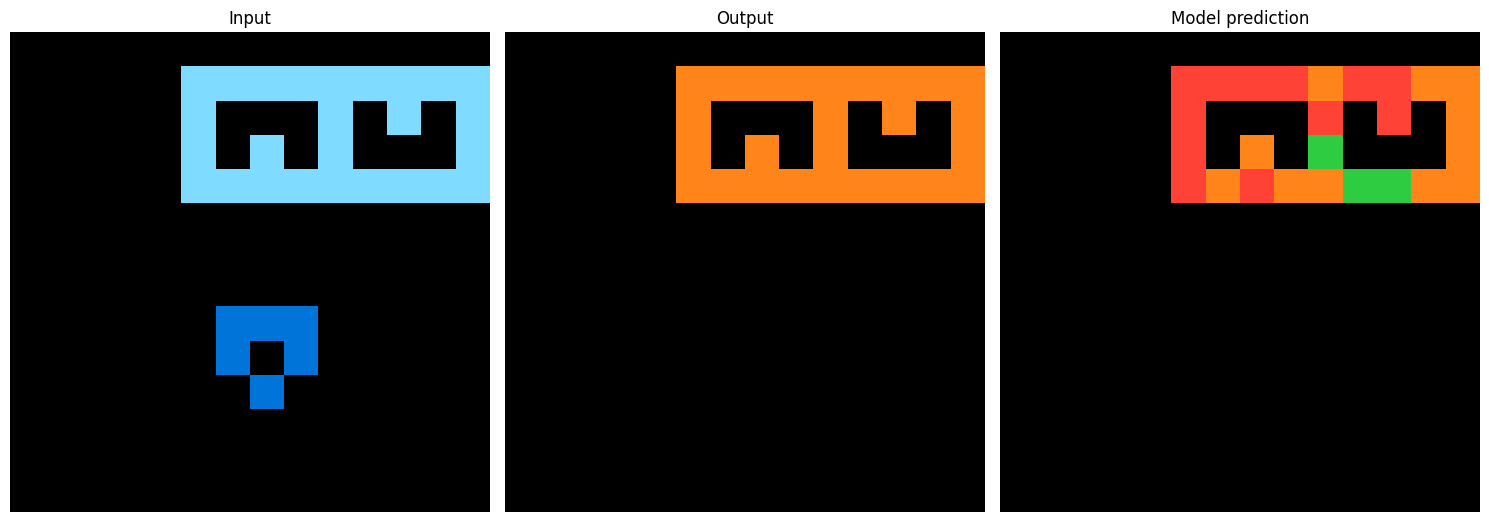

Accuracy: 0.923469387755102


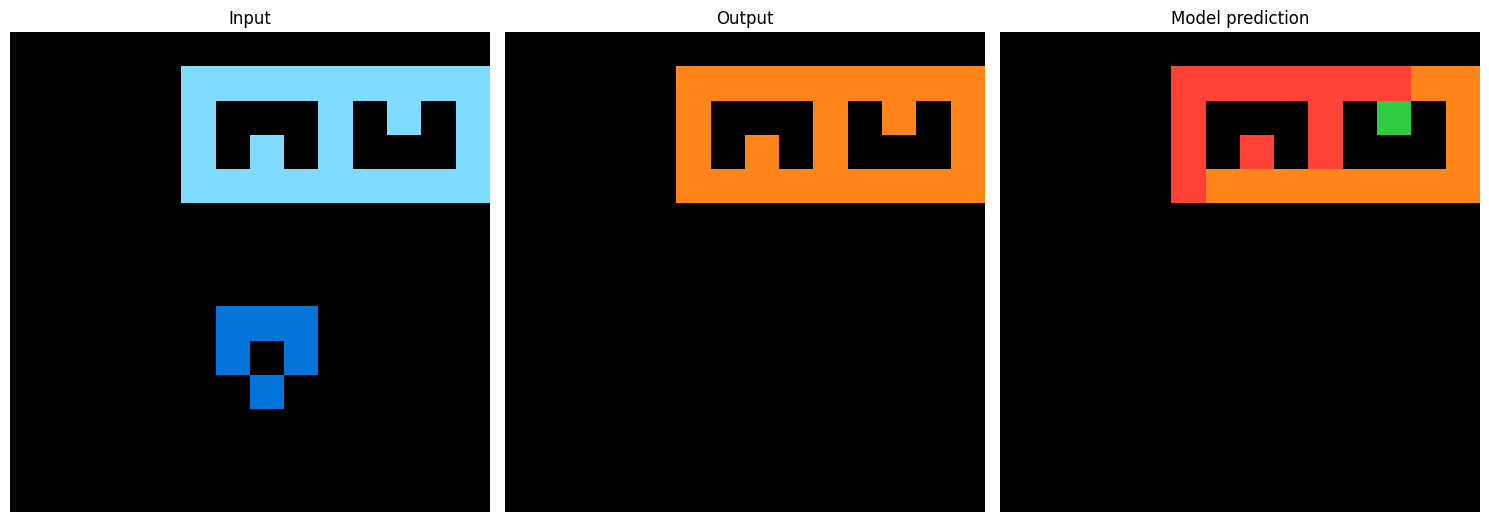

Accuracy: 0.9285714285714286


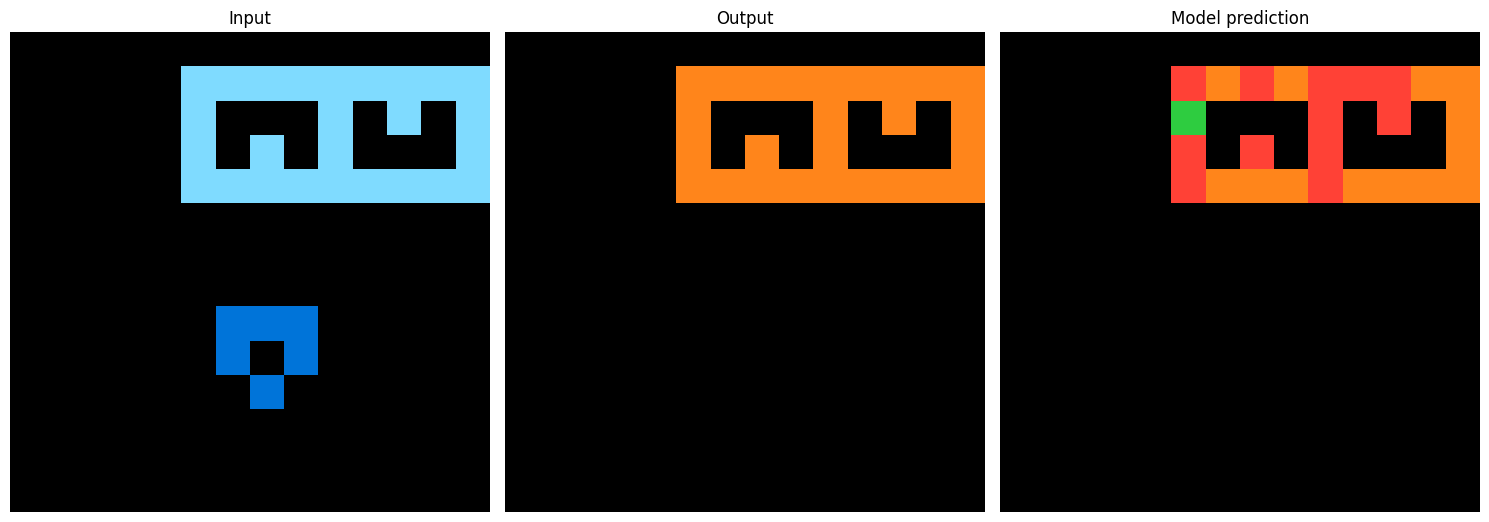

Accuracy: 0.9336734693877551
a406ac07


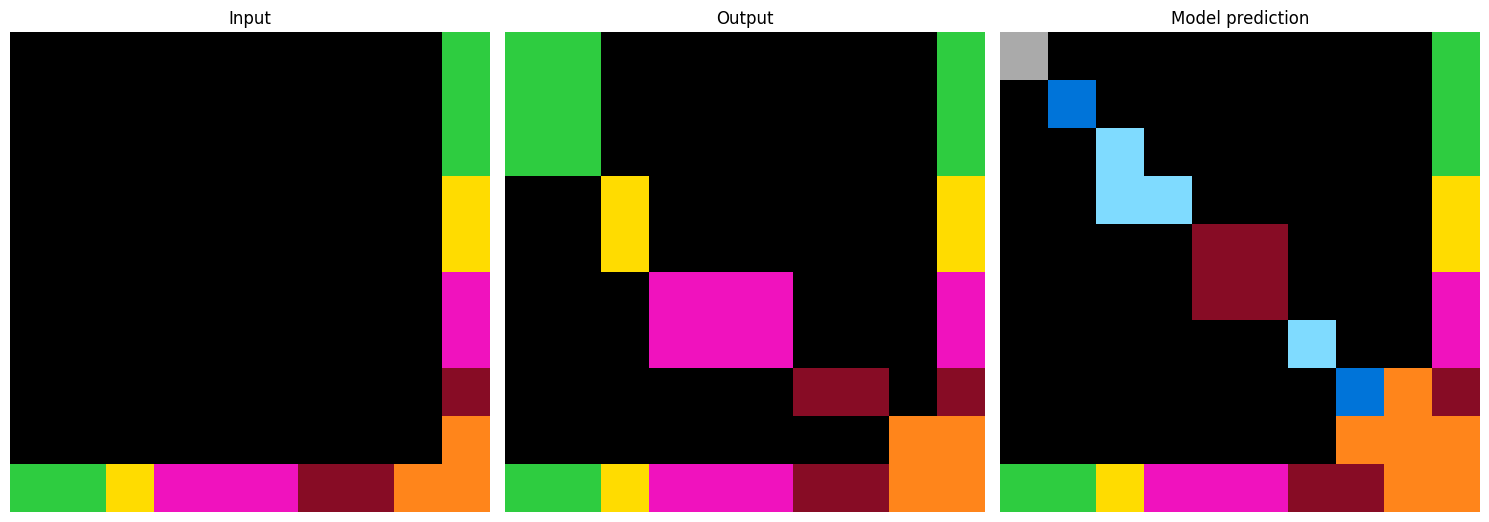

Accuracy: 0.77


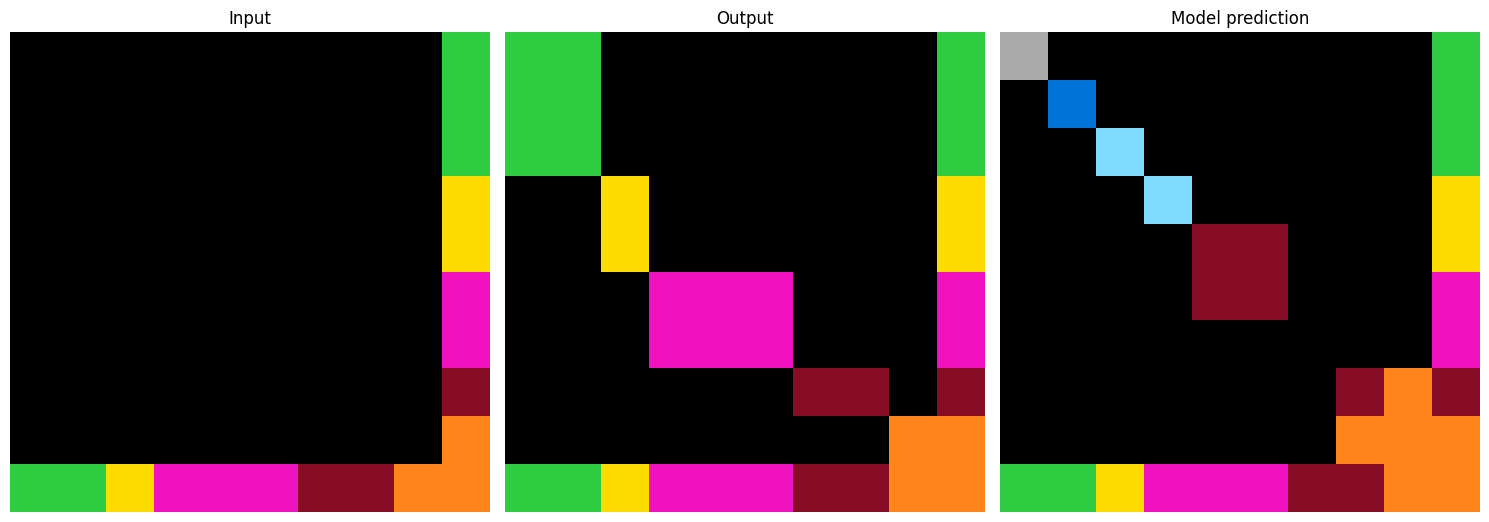

Accuracy: 0.79


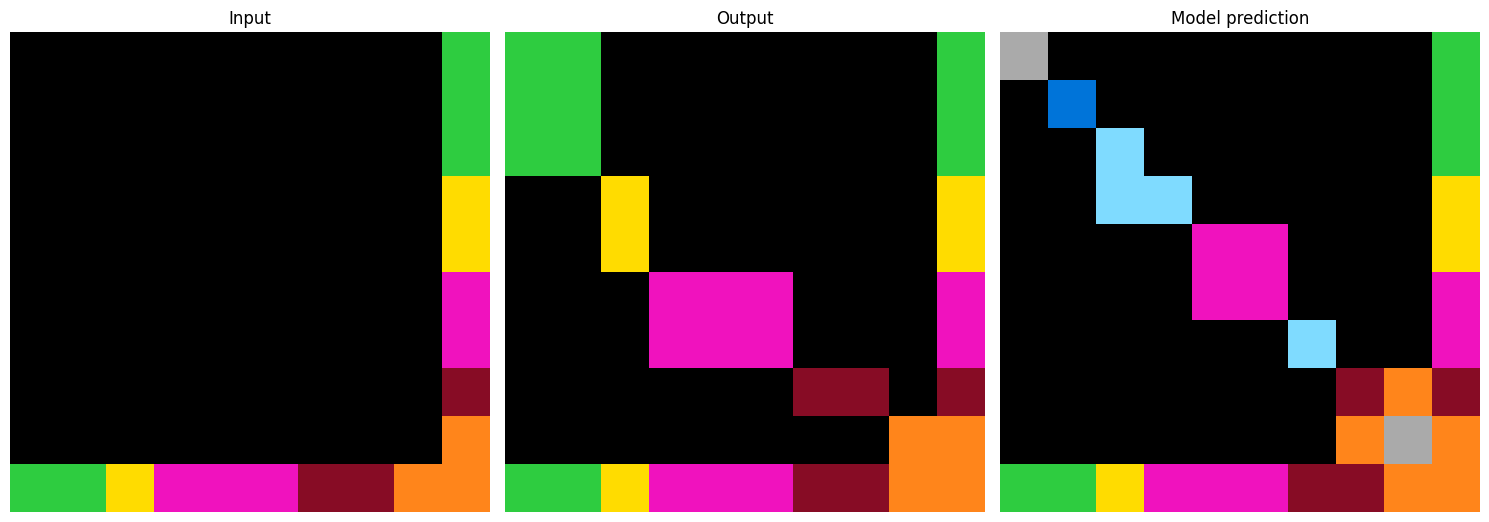

Accuracy: 0.79
5af49b42


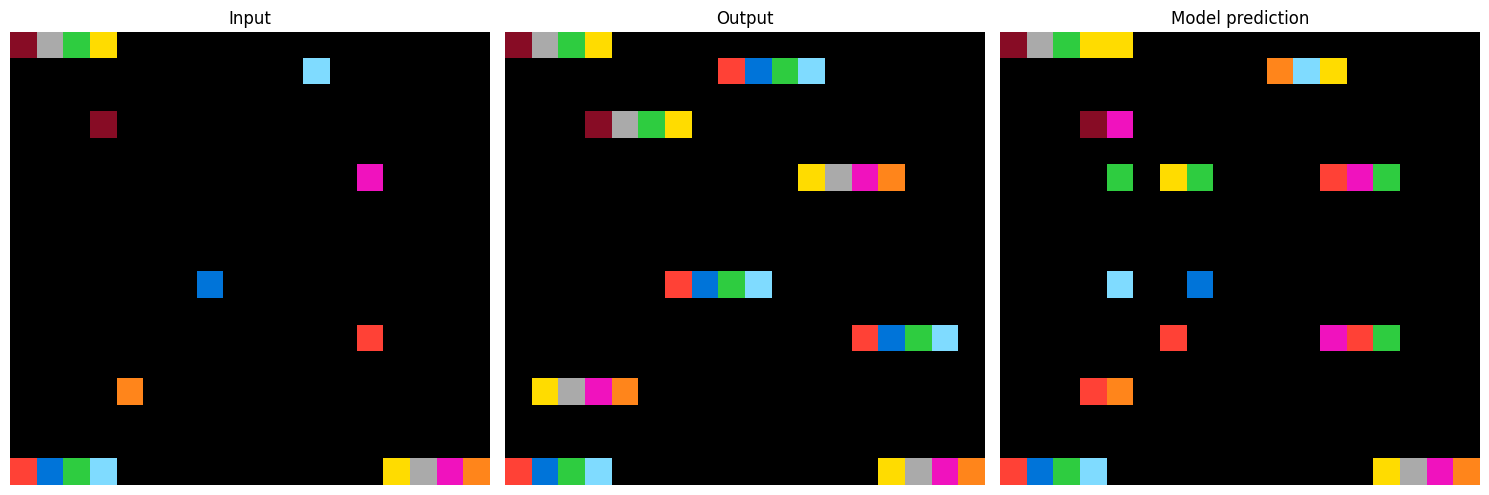

Accuracy: 0.9150326797385621


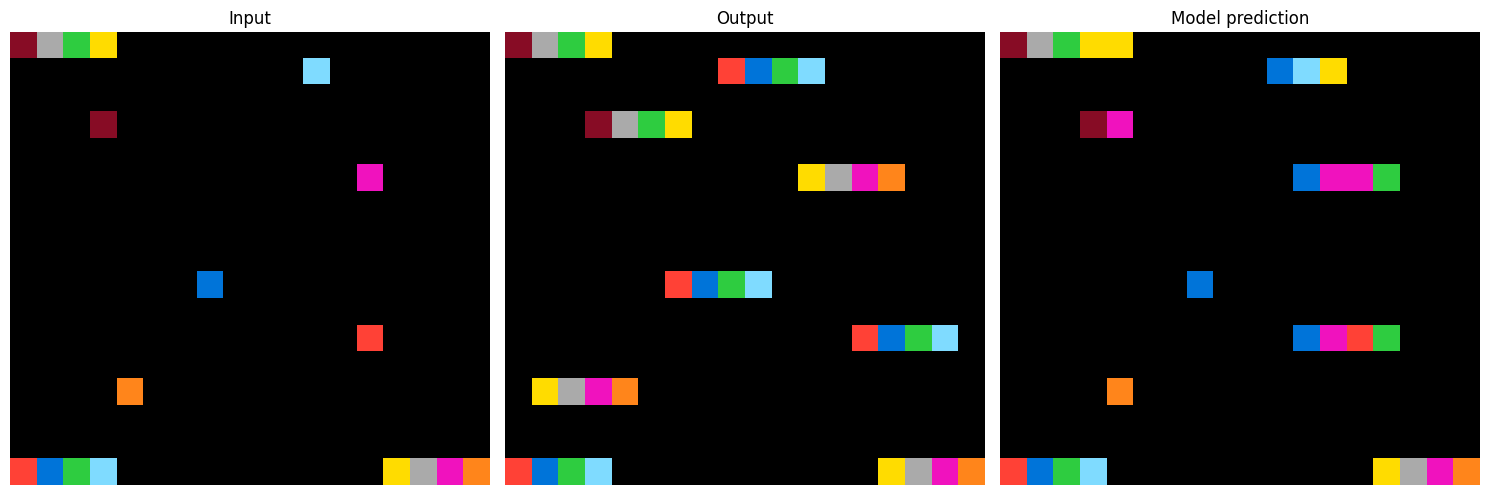

Accuracy: 0.9281045751633987


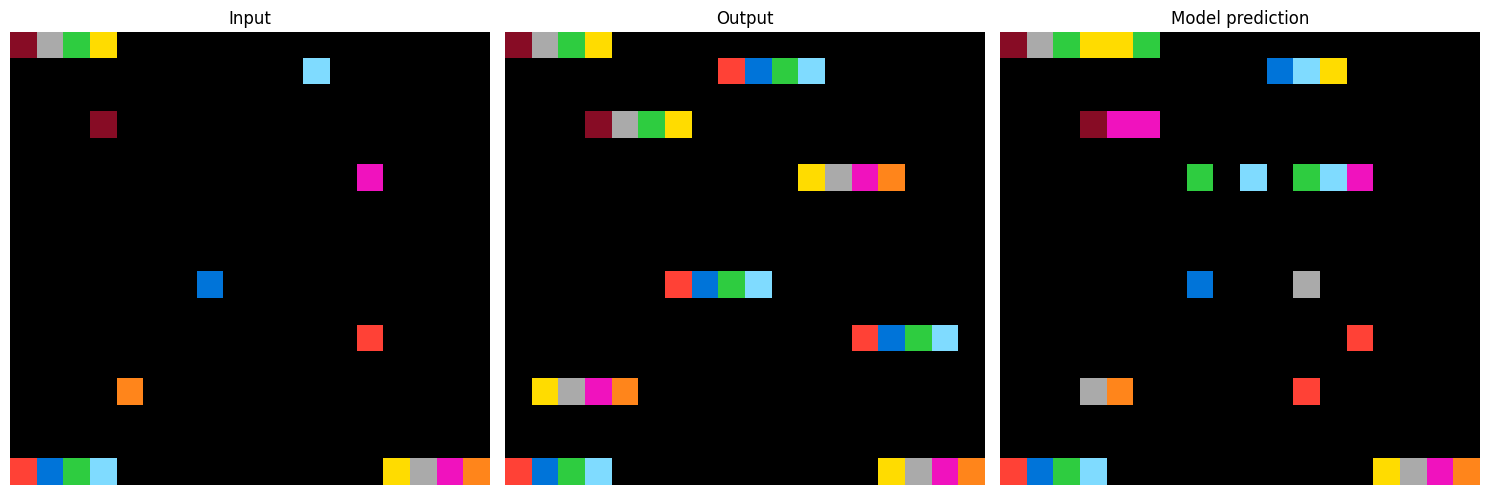

Accuracy: 0.9183006535947712
b942fd60


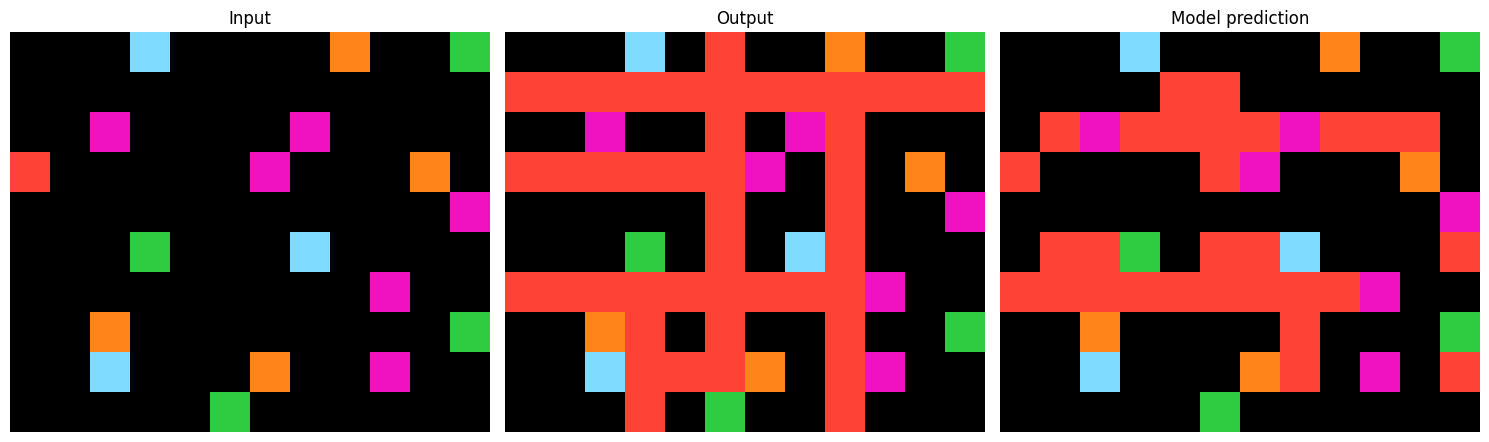

Accuracy: 0.6583333333333333


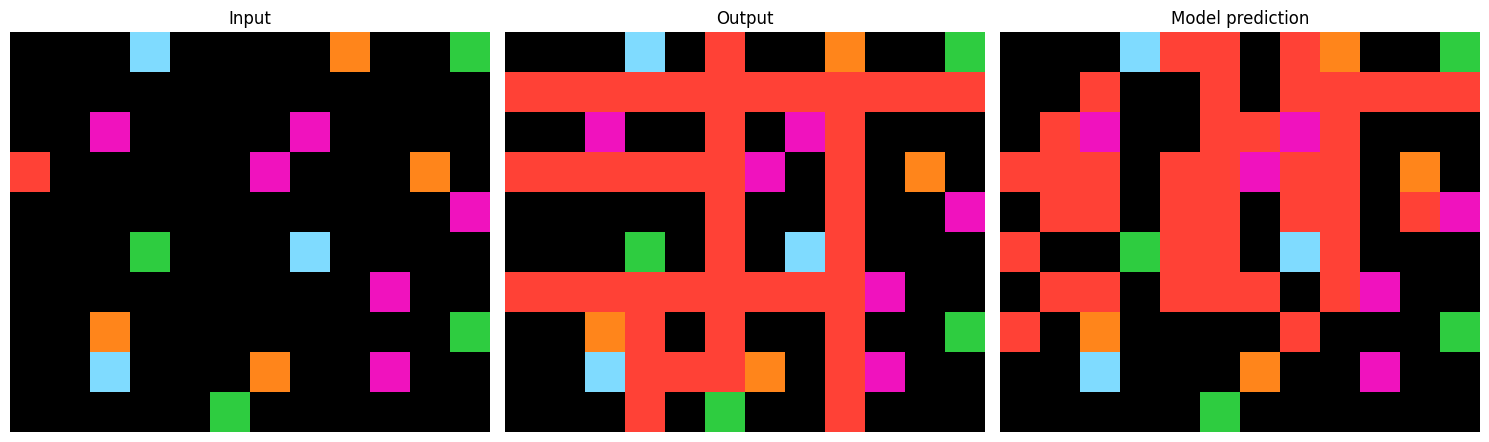

Accuracy: 0.7333333333333333


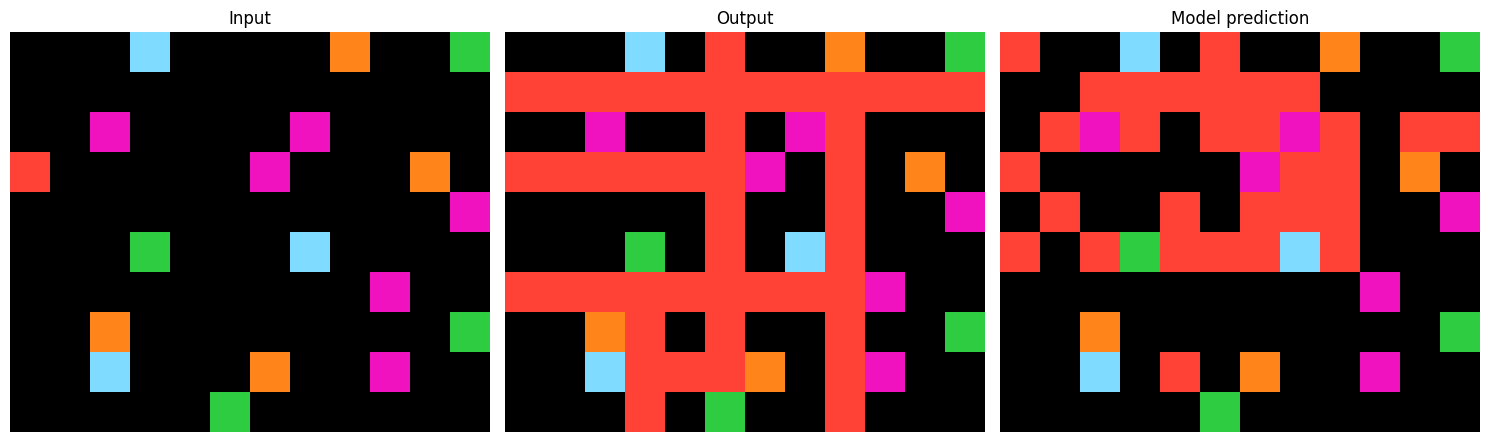

Accuracy: 0.6333333333333333
11e1fe23


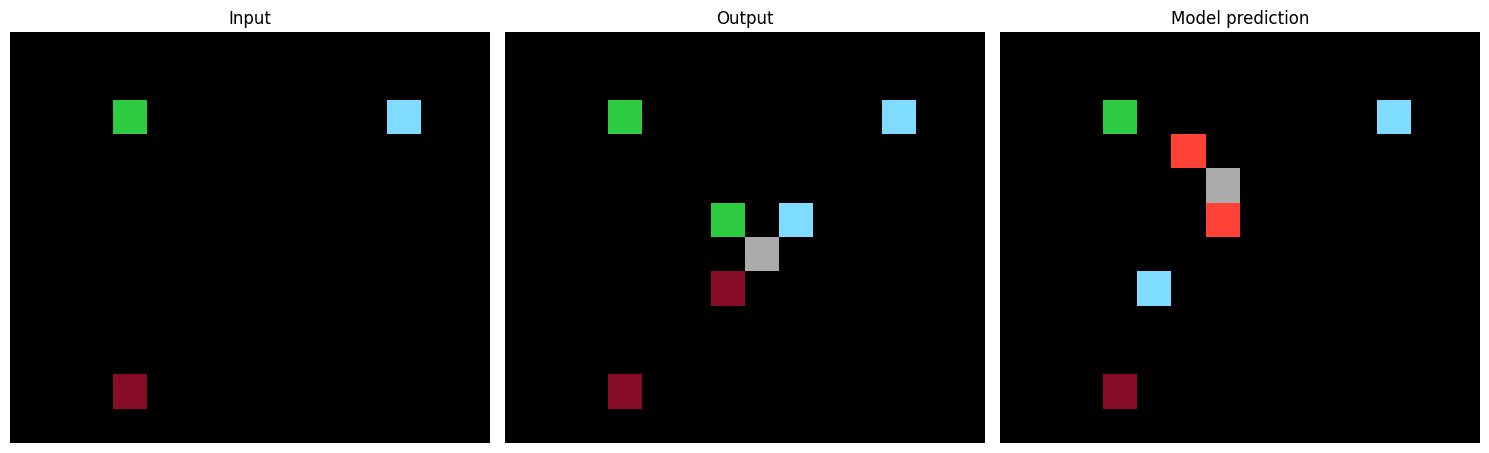

Accuracy: 0.9583333333333334


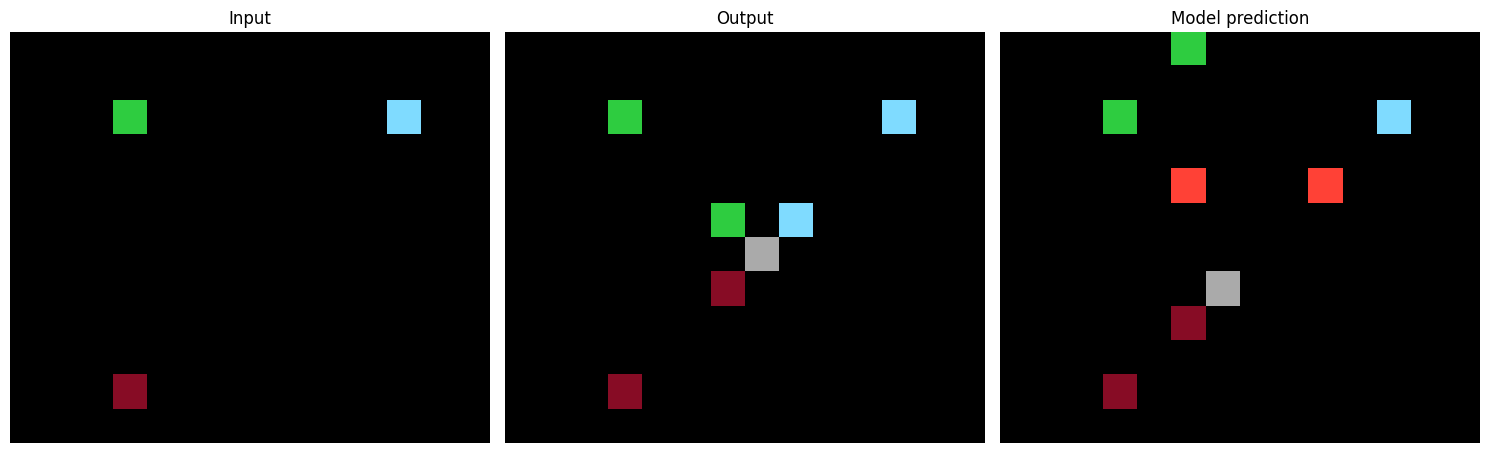

Accuracy: 0.9523809523809523


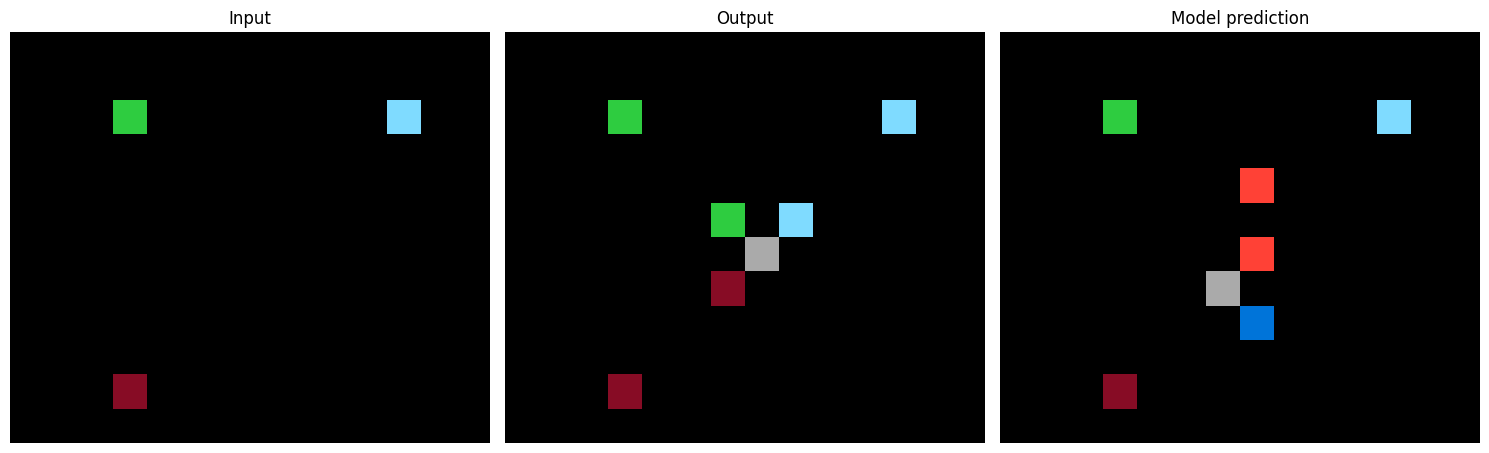

Accuracy: 0.9642857142857143
b7cb93ac
cfb2ce5a


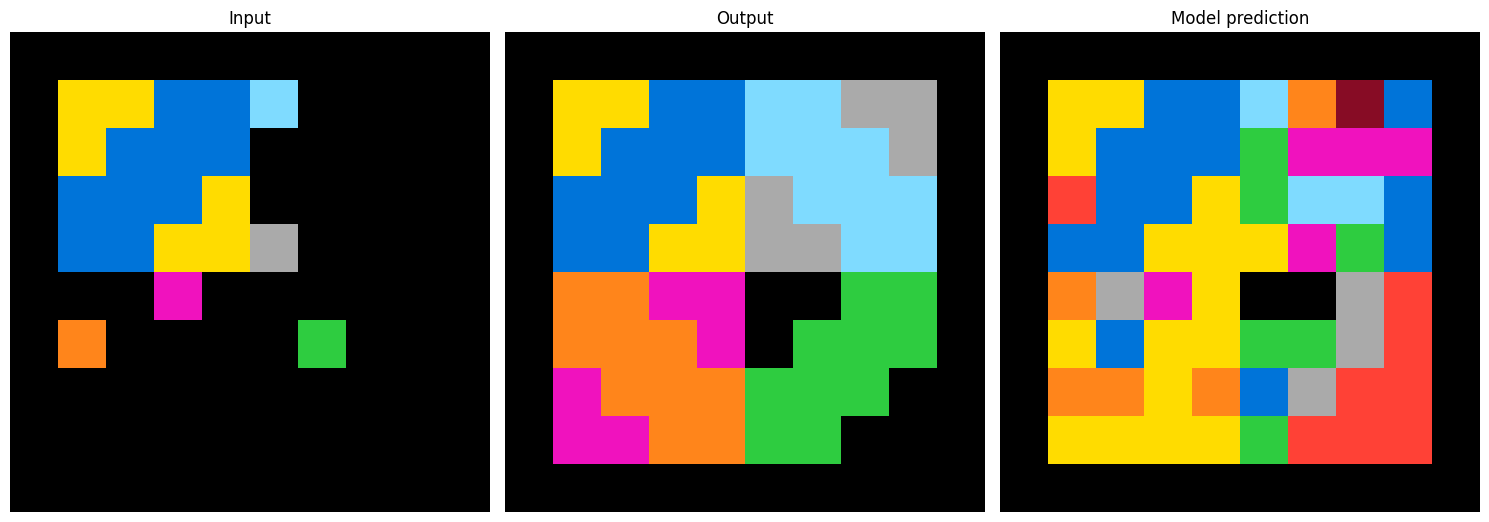

Accuracy: 0.62


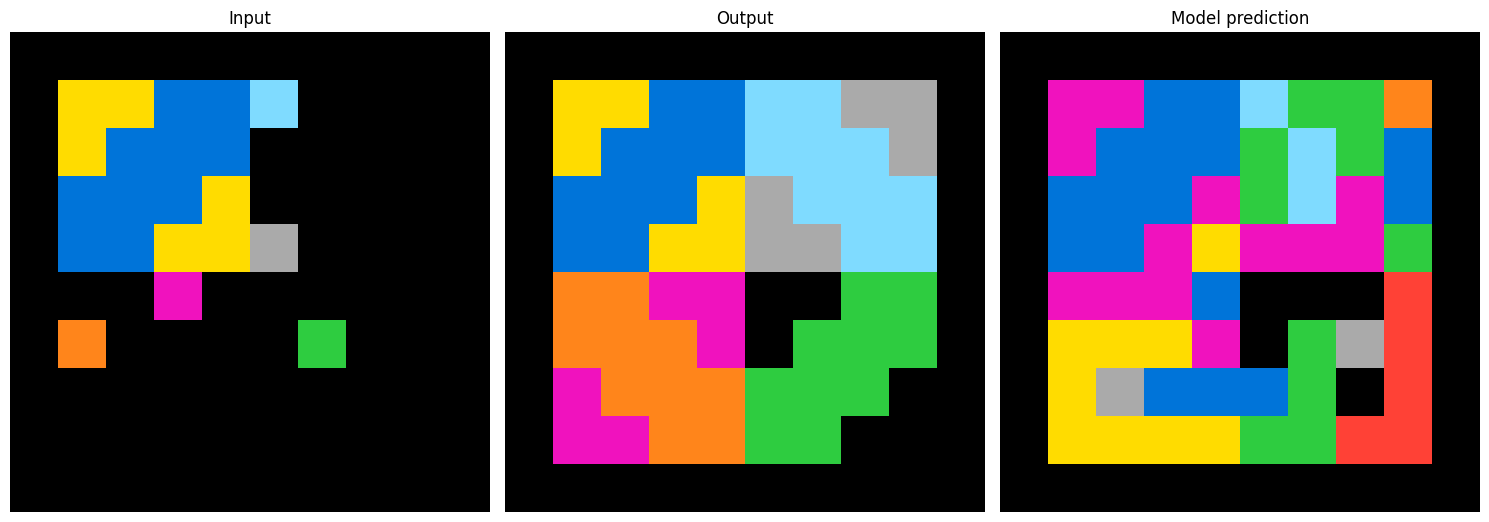

Accuracy: 0.59


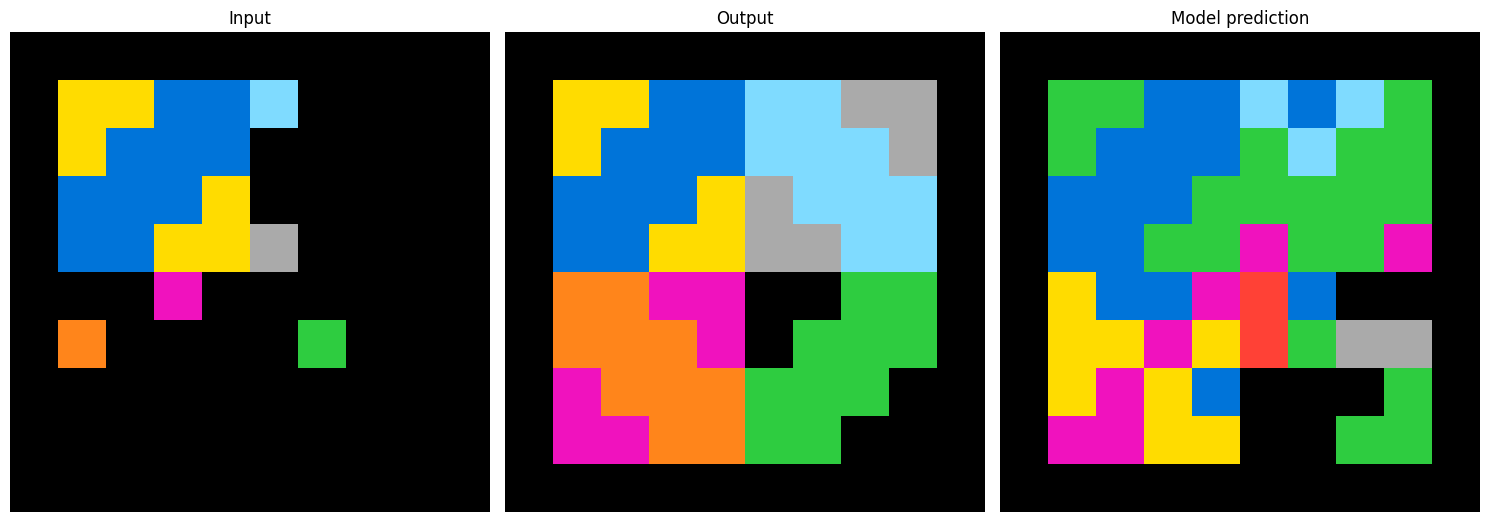

Accuracy: 0.52
62b74c02


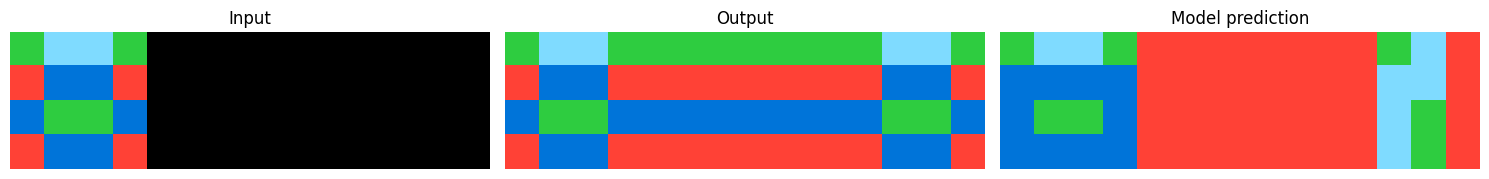

Accuracy: 0.5357142857142857


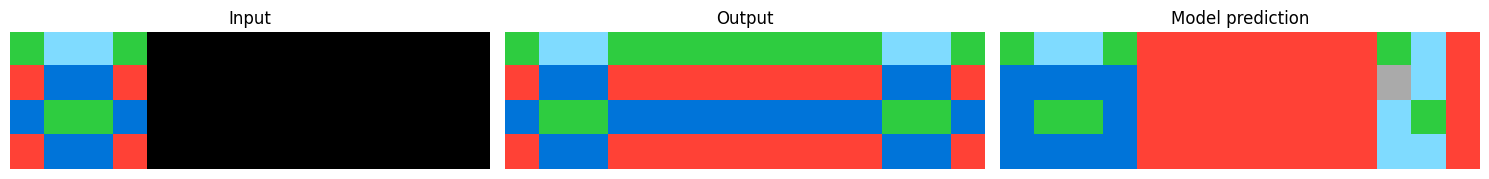

Accuracy: 0.5357142857142857


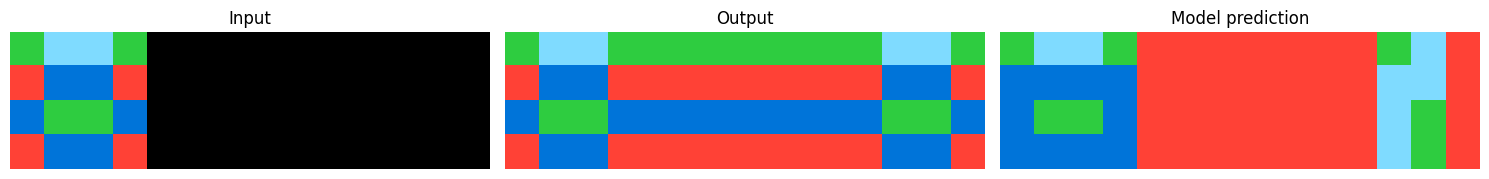

Accuracy: 0.5357142857142857
7953d61e
c663677b


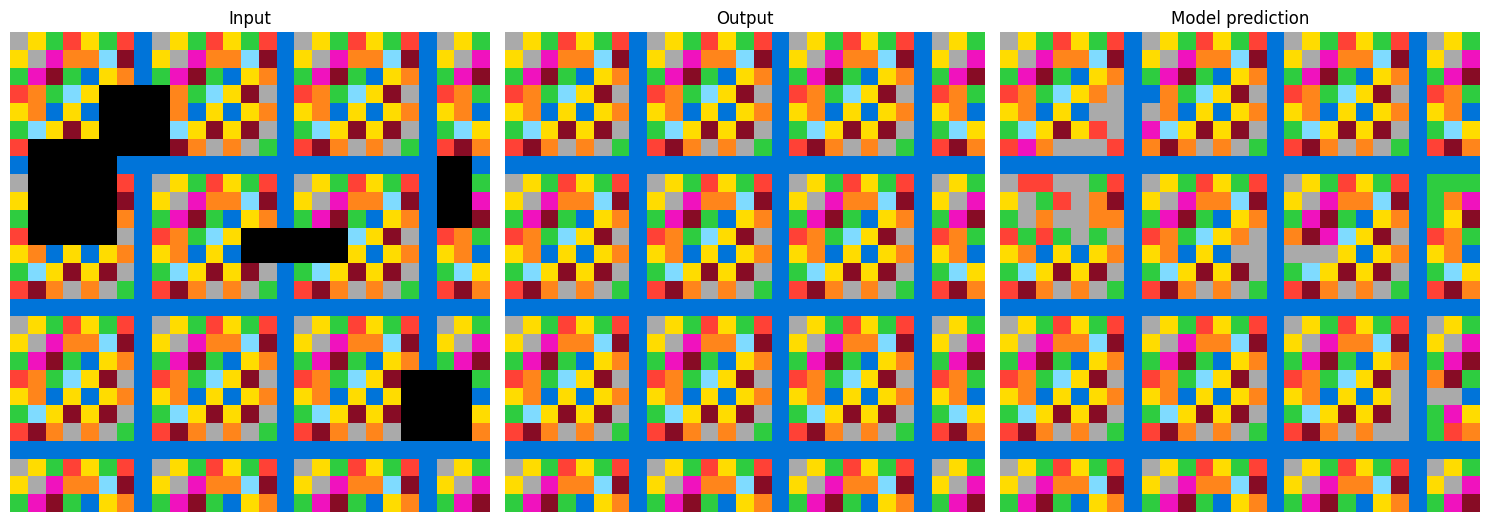

Accuracy: 0.9286694101508917


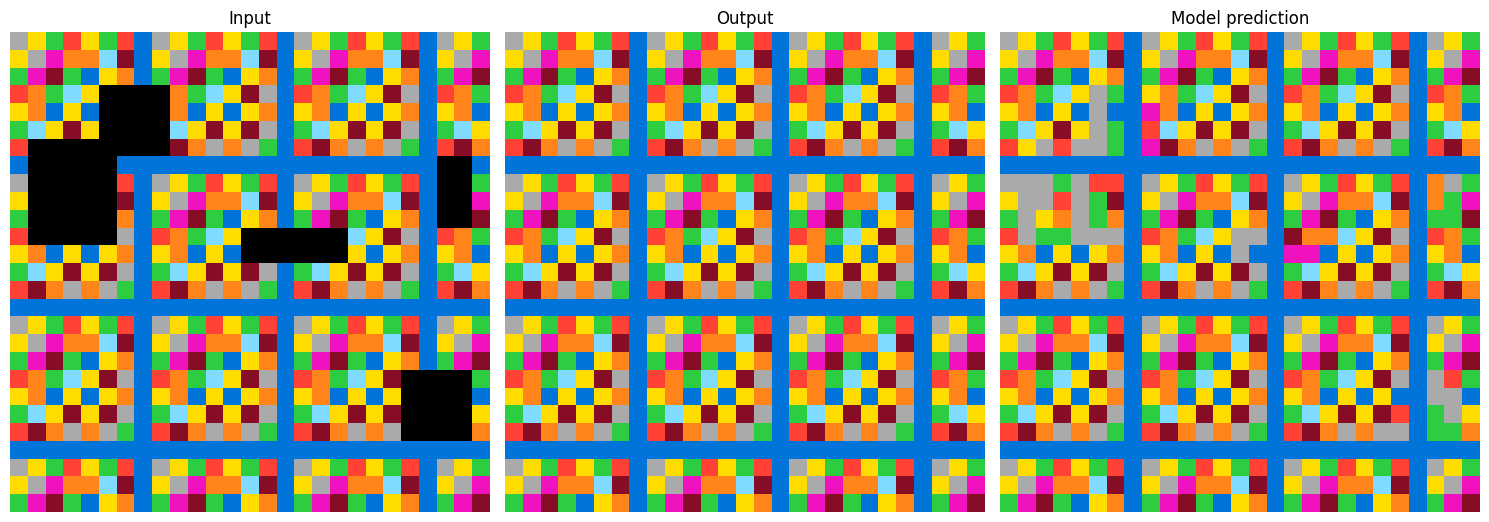

Accuracy: 0.9259259259259259


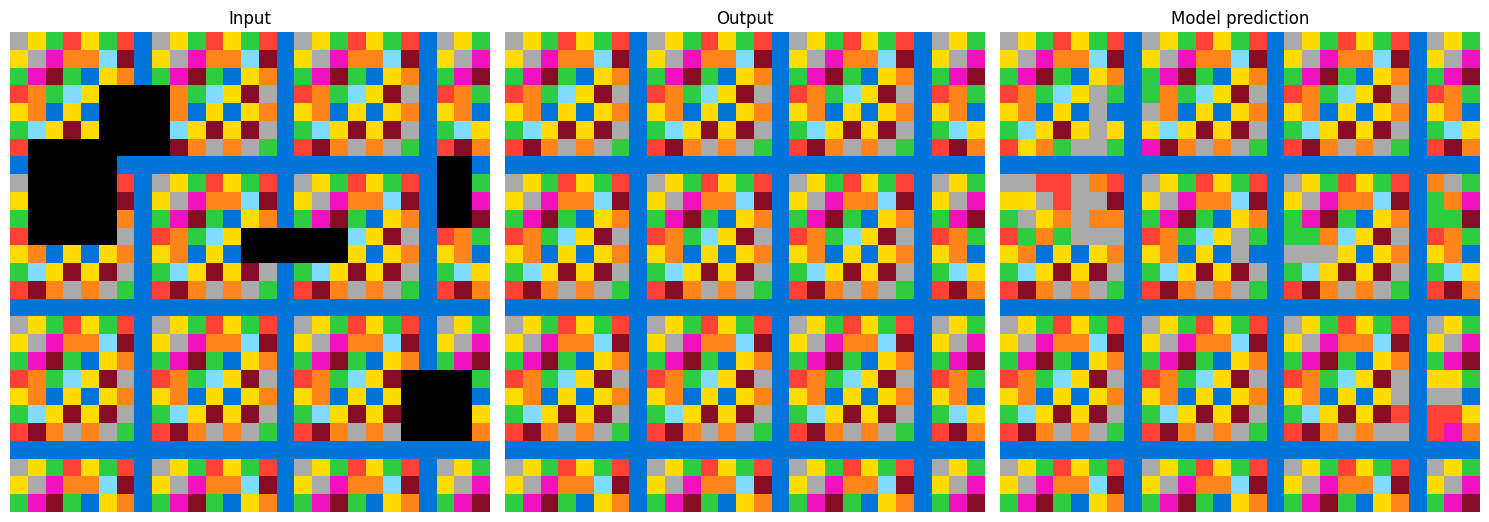

Accuracy: 0.9218106995884774
96a8c0cd


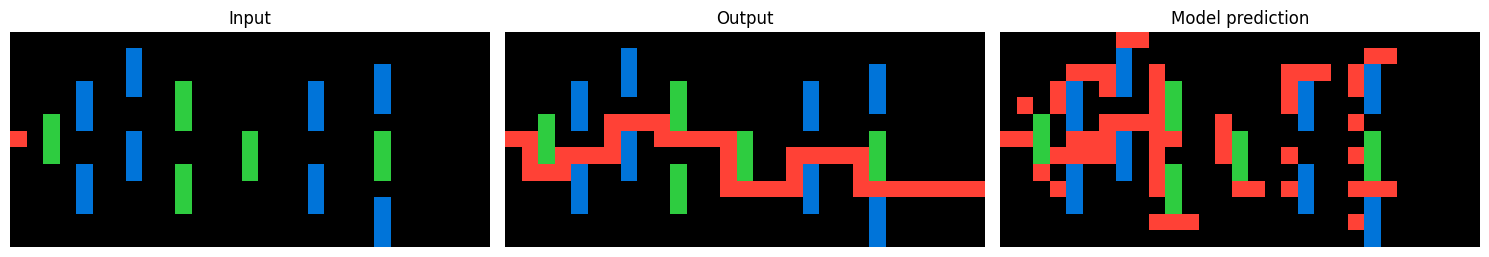

Accuracy: 0.8647214854111406


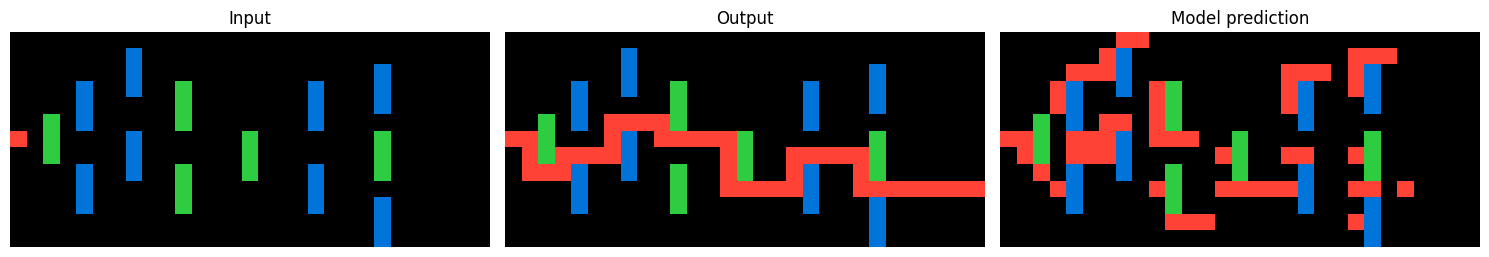

Accuracy: 0.883289124668435


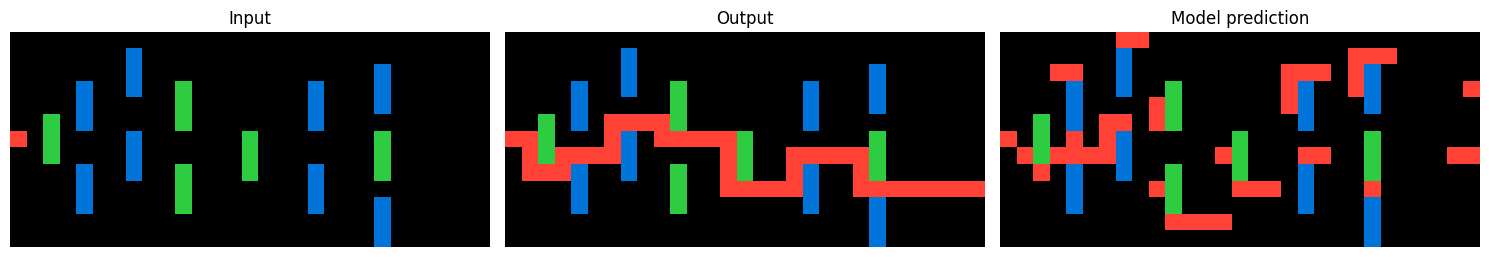

Accuracy: 0.8726790450928382
a8610ef7


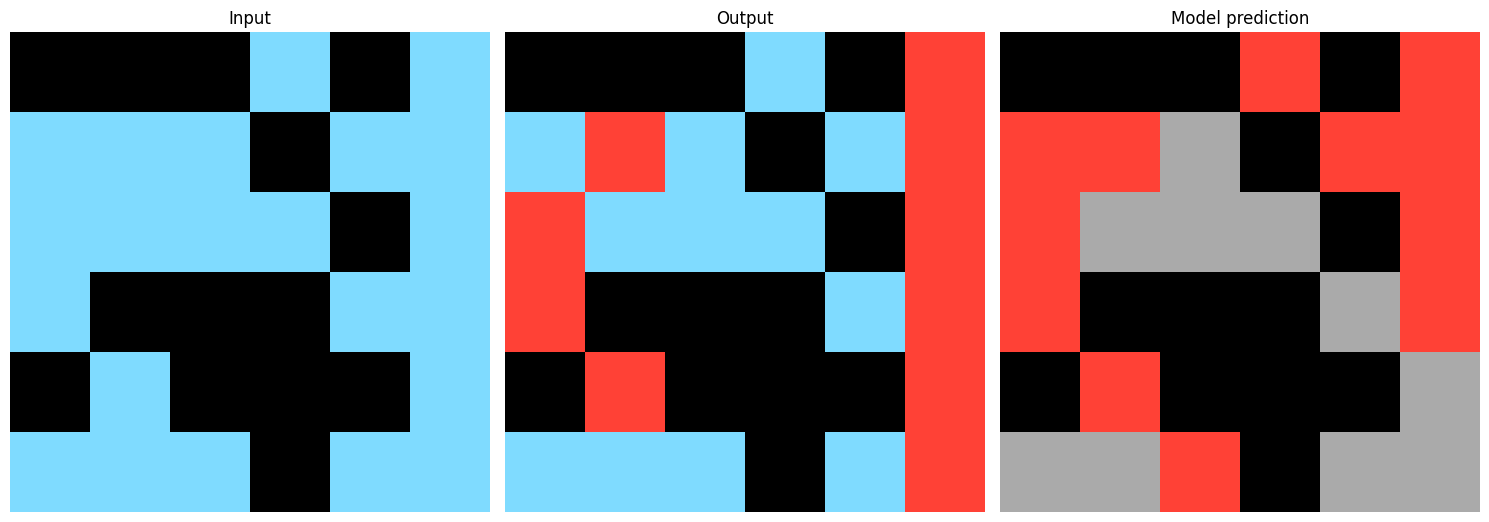

Accuracy: 0.6111111111111112


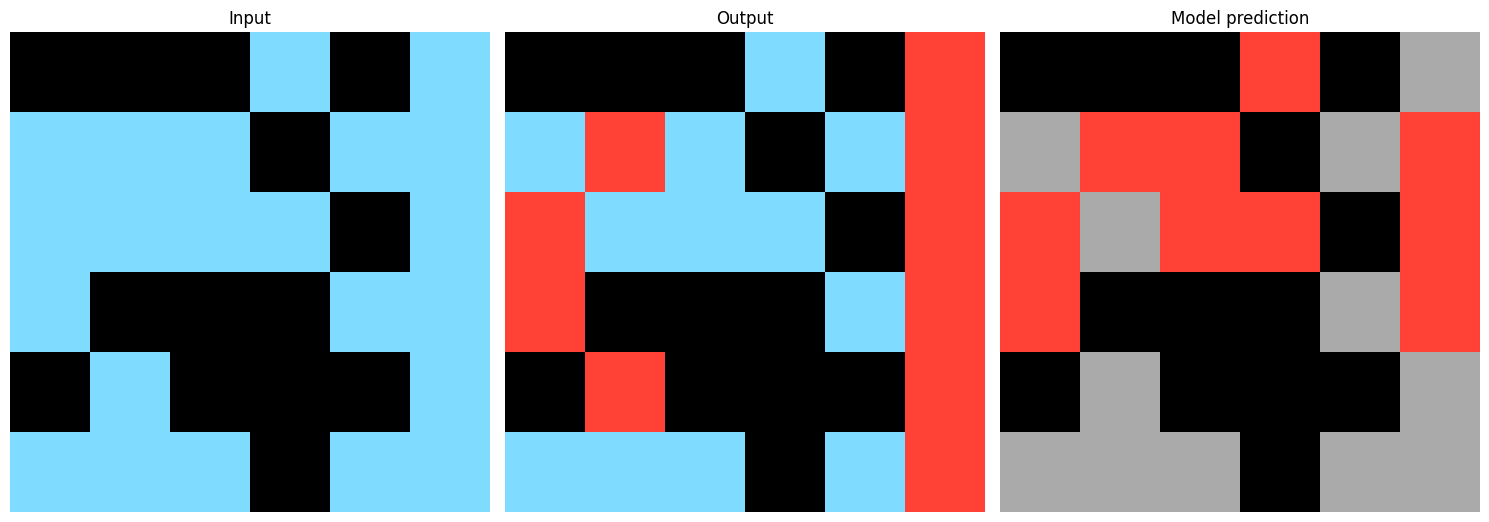

Accuracy: 0.5555555555555556


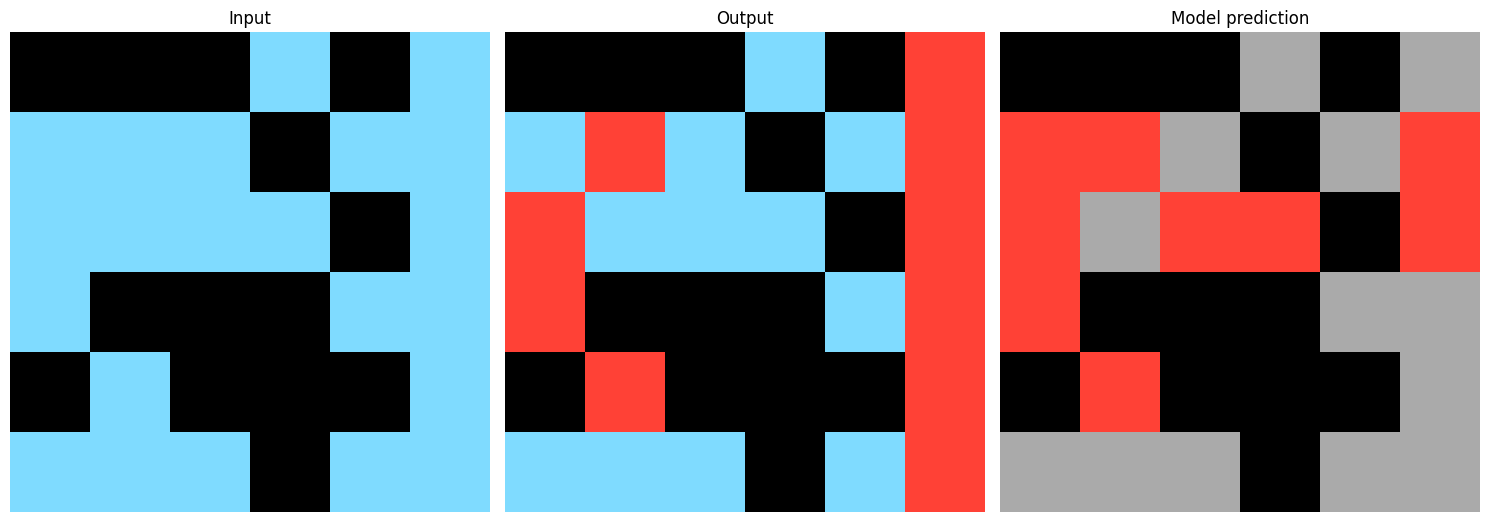

Accuracy: 0.5555555555555556
0a1d4ef5
69889d6e


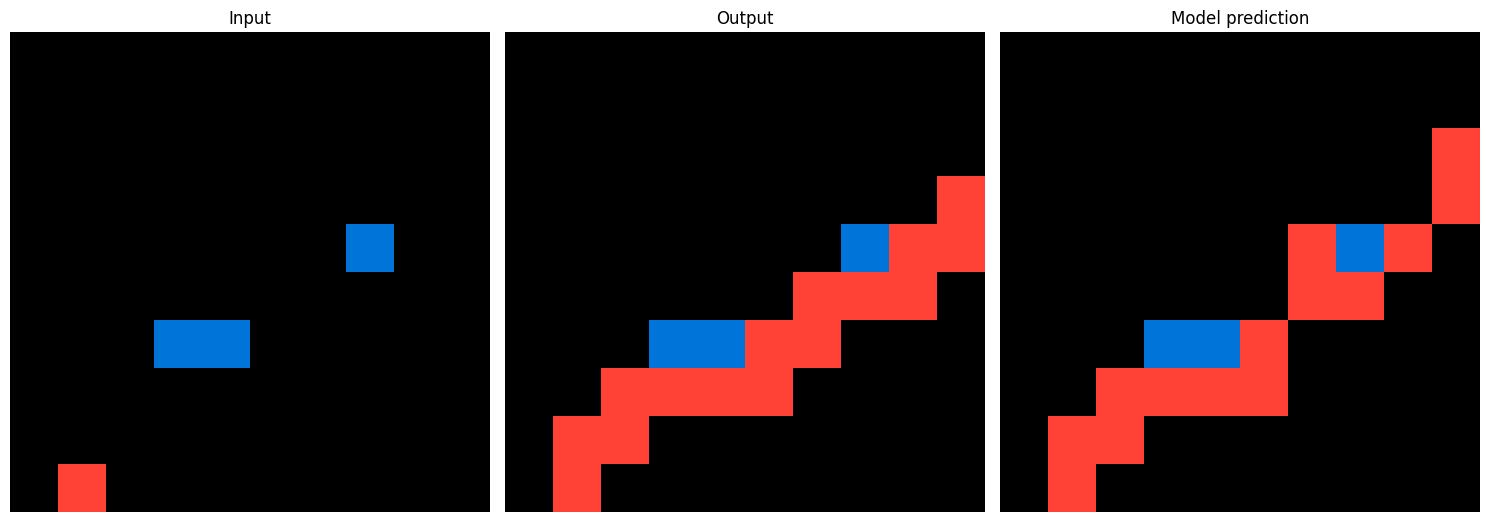

Accuracy: 0.95


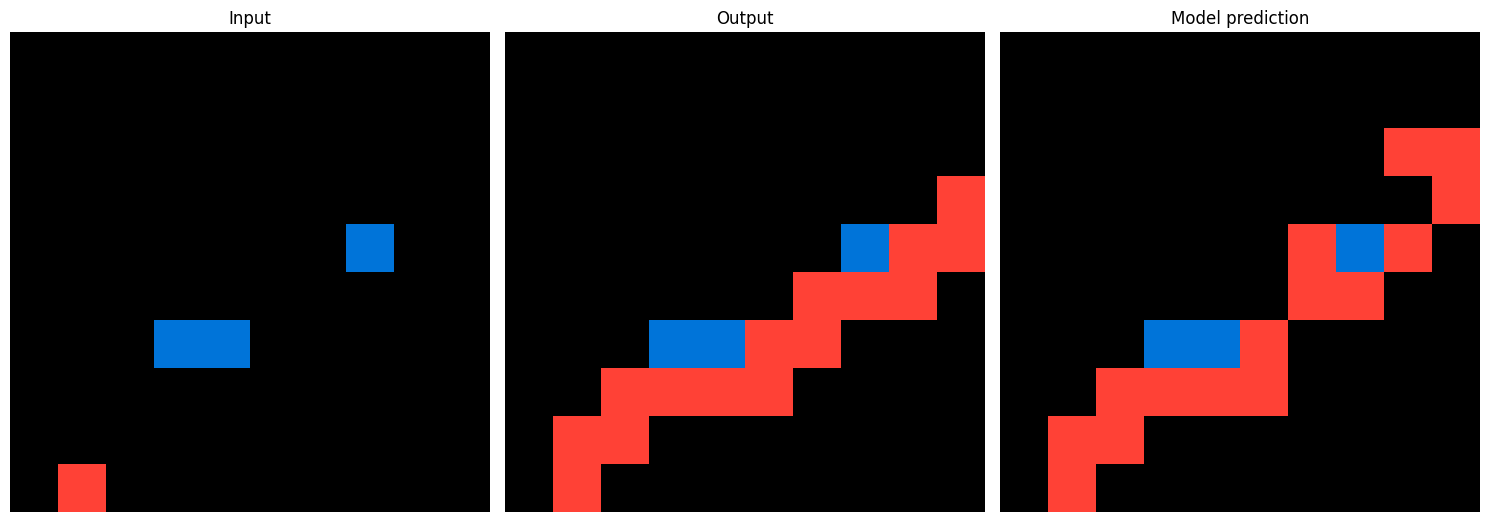

Accuracy: 0.94


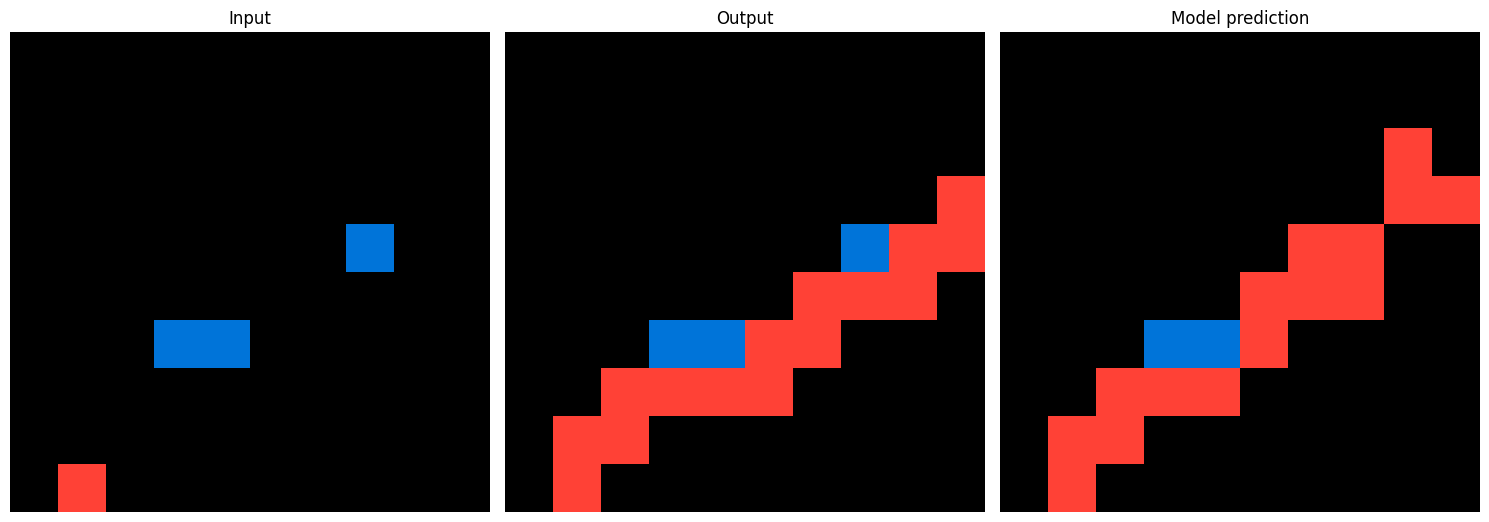

Accuracy: 0.9
a934301b


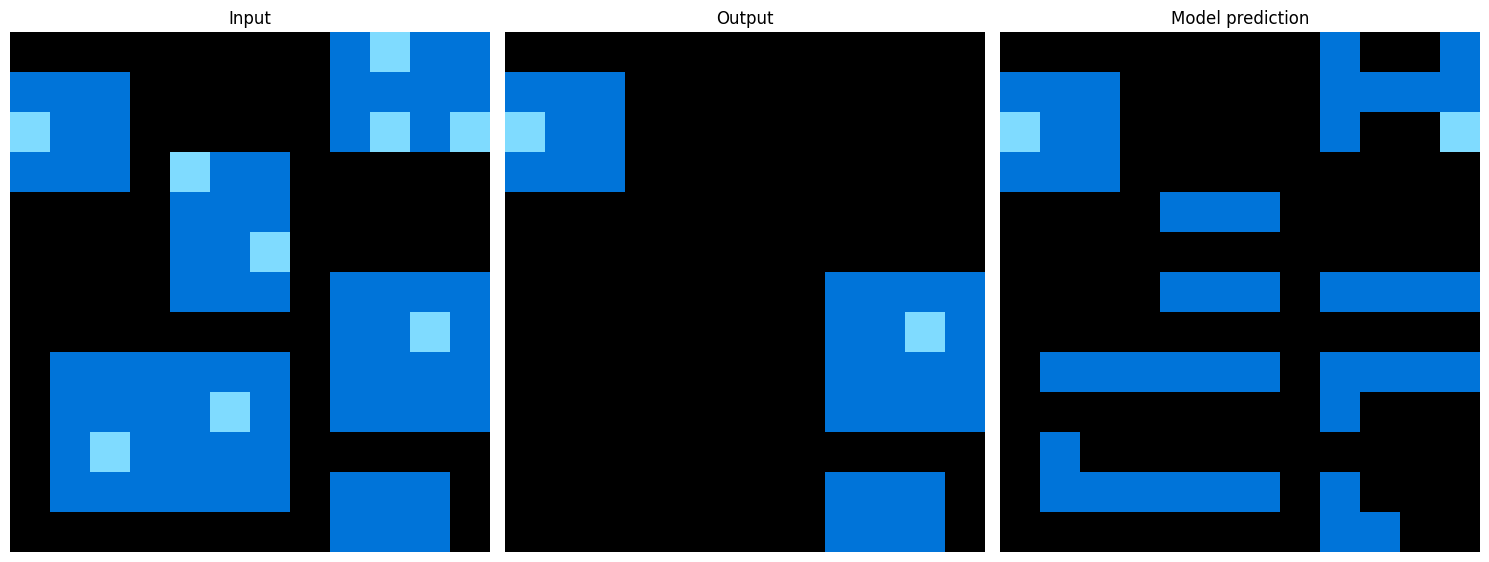

Accuracy: 0.7628205128205128


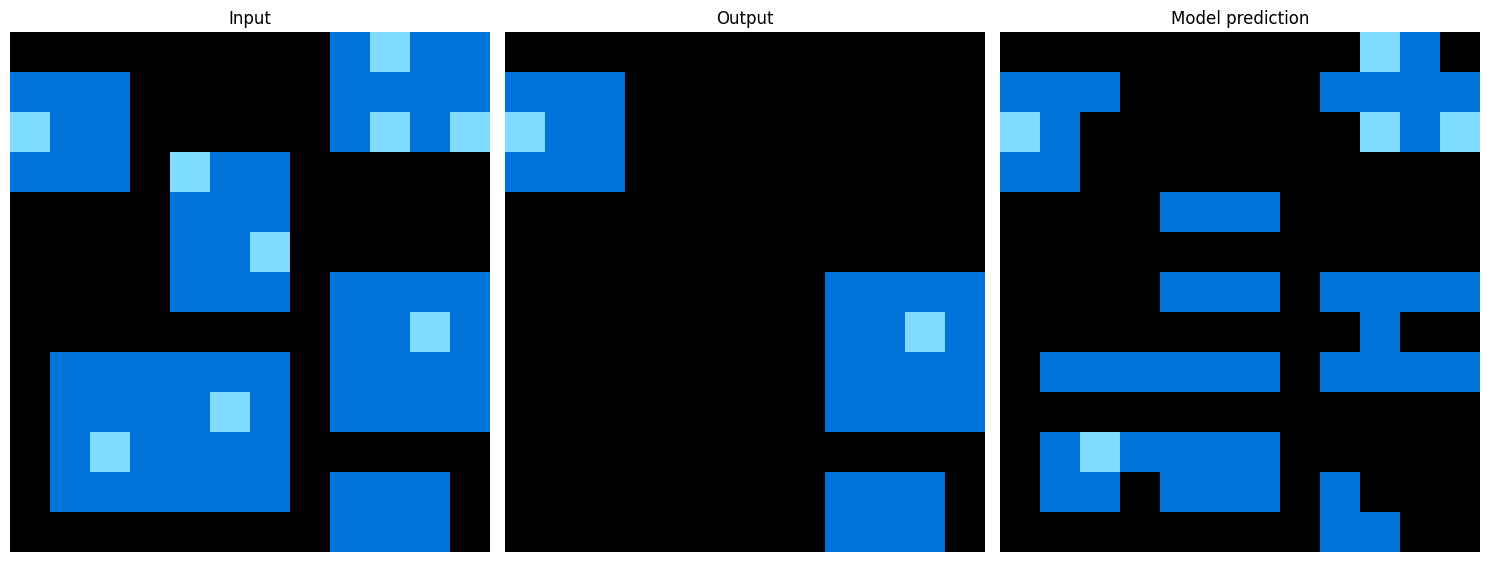

Accuracy: 0.717948717948718


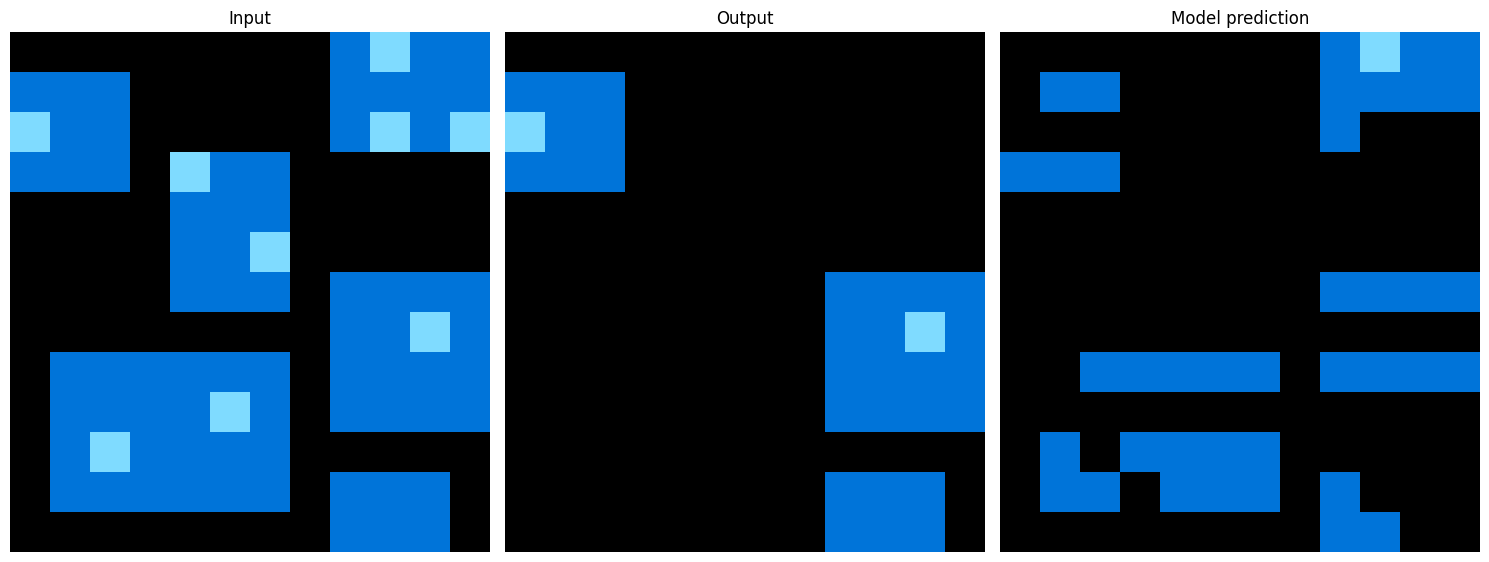

Accuracy: 0.75
97239e3d


KeyboardInterrupt: 

In [77]:
def inp_oup_dim_same(task_json):
    return all([ len(pair["input"]) == len(pair["output"]) and len(pair["input"][0]) == len(pair["output"][0])
                for pair in task_json['train']])
    

solved_task = 0
total_task = 0
task_ids = []
task_preds = []
for task_path in test_path.glob("*.json"):
    task_json = json.load(open(task_path))
    tk_id = str(task_path).split("/")[-1].split(".")[0]
    print(tk_id)
    if(inp_oup_dim_same(task_json)):
        a_size = get_a_size(task_json)
        bl_cols = get_bl_cols(task_json)
        
        isflip = False
        X1,Y1 = gettaskxy(task_json,True,1,bl_cols,isflip)
        X3,Y3 = gettaskxy(task_json,True,3,bl_cols,isflip)
        X5,Y5 = gettaskxy(task_json,True,5,bl_cols,isflip)
        
        model_1 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=100).fit(X1, Y1)
        model_3 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=100).fit(X3, Y3)
        model_5 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=100).fit(X5, Y5)
        
        pred_map_1 = submit_predict(task_json,model_1,1)
        pred_map_3 = submit_predict(task_json,model_3,3)
        pred_map_5 = submit_predict(task_json,model_5,5)
        
        for tks,str_pred in combine_preds(tk_id,pred_map_1,pred_map_3,pred_map_5):
            task_ids.append(tks)
            task_preds.append(str_pred)
            #print(tks,str_pred)
        solved_task+=1
        #break
    else:
        pred_map_1 = dumb_predict(task_json)
        pred_map_3 = dumb_predict(task_json)
        pred_map_5 = dumb_predict(task_json)
        
        for tks,str_pred in combine_preds(tk_id,pred_map_1,pred_map_3,pred_map_5):
            task_ids.append(tks)
            task_preds.append(str_pred)
            #print(tks,str_pred)
        
    total_task+=1

In [78]:
print(total_accuracy/(3*solved_task))

0.8091400665306263


In [79]:
solved_task

99